In [1]:
import multiprocessing
import numpy as np
import scipy.interpolate
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
from tectosaur.mesh.mesh_gen import make_rect
from tectosaur_topo import solve_topo
import cigcdm.gf_builder

In [3]:
def topo(x, y, flat):
    z = np.zeros_like(x)
    if flat:
        return z

    C = [0, 0]
    hill_height = 2 * 1000
    hill_xradius = 7 * 1000
    hill_yradius = 7 * 1000

    z += hill_height * np.exp(
        -(((x - C[0]) / hill_xradius) ** 2 + ((y - C[1]) / hill_yradius) ** 2)
    )

    return z

def setup_model(surf_el_size, fault_el_size, flat):
    fault_top_z = -3 * 1000
    fault_bottom_z = -15 * 1000
    fault_length = 70 * 1000
    fault_nx = int(fault_length / fault_el_size)
    fault_ny = int((fault_top_z - fault_bottom_z) / fault_el_size)
    print('Fault has: ' + str((fault_nx, fault_ny)) + ' elements')
    
    corners = [
        [-fault_length / 2, 0, fault_bottom_z],
        [fault_length / 2, 0, fault_bottom_z],
        [fault_length / 2, 0, fault_top_z],
        [-fault_length / 2, 0, fault_top_z],
    ]
    fault = make_rect(fault_nx, fault_ny, corners)
    fault_slip = np.array([[1, 0, 0]] * 3 * fault[1].shape[0]).flatten()

    wx = 100 * 1000
    wy = 100 * 1000
    n = int(wx / surf_el_size)
    print('Surf has: ' + str((n, n)) + ' elements')
    
    surf_corners = [[-wx, -wy, 0], [-wx, wy, 0], [wx, wy, 0], [wx, -wy, 0]]
    surf = make_rect(n, n, surf_corners)
    surf[0][:,2] = topo(surf[0][:,0], surf[0][:,1], flat)
    return fault, fault_slip, surf

In [4]:
surf_el_size = 2000
fault_el_size = 4000
fault, fault_slip, hill_surf = setup_model(surf_el_size, fault_el_size, False)
_, _, flat_surf = setup_model(surf_el_size, fault_el_size, True)

Fault has: (17, 3) elements
Surf has: (50, 50) elements
Fault has: (17, 3) elements
Surf has: (50, 50) elements


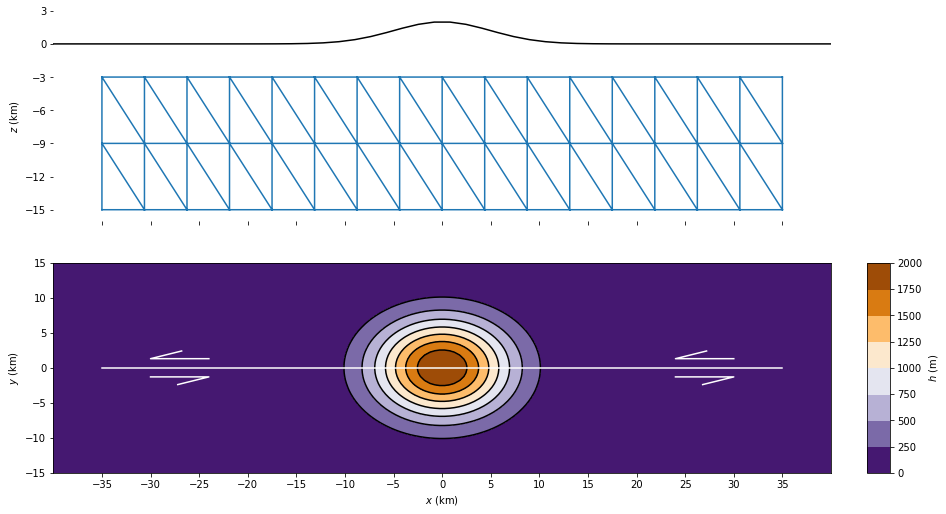

In [5]:
%matplotlib inline
x = np.linspace(-40000, 40000)
y = 0 * x
z = topo(x, y, flat = False)

fig = plt.figure(figsize = (15, 8.5))
ax1 = plt.subplot(211)
# ax1.set_aspect('equal')
triang = tri.Triangulation(fault[0][:,0] / 1000.0, fault[0][:,2] / 1000.0, fault[1])
plt.triplot(triang)
plt.xticks(np.linspace(-35.0, 35.0, 15))
plt.yticks(np.linspace(3.0, -15.0, 7))
plt.ylim([-16, 3])
# plt.xlabel('$x$ (km)')
plt.ylabel('$z$ (km)')
plt.plot(x / 1000, z / 1000, 'k-')
ax1.spines["top"].set_visible(False)
ax1.spines["bottom"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.spines["left"].set_visible(False)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="3%", pad=0.5)
cax.axis('off')
plt.setp(ax1.get_xticklabels(), visible=False)

x, y, z = hill_surf[0][:,0], hill_surf[0][:,1], hill_surf[0][:, 2]
nx = 400
ny = 400
x_new = np.linspace(np.min(x), np.max(x), nx)
y_new = np.linspace(np.min(y), np.max(y), ny)
X, Y = np.meshgrid(x_new, y_new)
Z = topo(X, Y, flat = False)
# Z = scipy.interpolate.griddata(
#     (x, y), z, (X, Y)
# )

ax2 = plt.subplot(212, sharex = ax1)
cmap = cm.get_cmap(name='PuOr_r')
cntf = plt.contourf(X / 1000, Y / 1000, Z, cmap = cmap)
try:
    plt.contour(
        X / 1000, Y / 1000, Z,
        linestyles = 'solid', colors=['k'], linewidths=[1.5]
    )
except ValueError:
    pass
plt.plot([-35.0, 35.0], [0.0, 0.0], 'w-', zorder = 1000)

plt.plot([-26.8,-30,-24], [2.4,1.3,1.3], 'w-')
plt.plot([-27.2,-24,-30], [-2.4,-1.3,-1.3], 'w-')
plt.plot([27.2,24,30], [2.4,1.3,1.3], 'w-')
plt.plot([26.8,30,24], [-2.4,-1.3,-1.3], 'w-')

plt.xlabel('$x$ (km)')
plt.ylabel('$y$ (km)')
plt.xlim([-40, 40])
plt.ylim([-15, 15])

divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="3%", pad=0.5)
cbar = plt.colorbar(cntf, cax = cax)
cbar.set_label('$h$ (m)')
plt.savefig('hill_ss_mapview.pdf')
plt.show()

In [6]:
def forward(surf, gpu_idx):
    import os
    os.environ['CUDA_DEVICE'] = str(gpu_idx)
    return solve_topo(surf, fault, fault_slip, 1.0, 0.25)

In [7]:
with multiprocessing.Pool(2) as pool:
    hill_res = pool.apply_async(forward, (hill_surf, 0))
    flat_res = pool.apply_async(forward, (flat_surf, 1))
    hill_surf_pts, hill_surf_disp, hill_soln = hill_res.get()
    flat_surf_pts, flat_surf_disp, flat_soln = flat_res.get()

2017-09-22 17:46:52,520 - tectosaur.util.gpu - DEBUG - start compiling nearfield/nearfield.cl
2017-09-22 17:46:52,589 - tectosaur.util.gpu - DEBUG - start compiling nearfield/nearfield.cl
2017-09-22 17:46:53,451 - tectosaur.util.cuda - DEBUG - Initialized CUDA on gpu: 1
2017-09-22 17:46:54,045 - tectosaur.util.cuda - DEBUG - Initialized CUDA on gpu: 0
2017-09-22 17:46:54,263 - tectosaur.util.gpu - DEBUG - compile took 1.7427935600280762
2017-09-22 17:46:54,279 - tectosaur.nearfield.nearfield_op - DEBUG -     setup pairs integrator took 1.758793592453003
2017-09-22 17:46:54,286 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- load table took 0.004616975784301758
2017-09-22 17:46:54,312 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- get pts took 0.023995399475097656
2017-09-22 17:46:54,313 - tectosaur.util.gpu - DEBUG - start compiling nearfield/table_lookup.cl
2017-09-22 17:46:54,341 - tectosaur.util.gpu - DEBUG - compile took 1.7513720989227295
2017-09-22 17:46:54

2017-09-22 17:46:56,715 - tectosaur.fmm.builder - DEBUG - compression factor: 0.39568252850879526
2017-09-22 17:46:56,716 - tectosaur.fmm.builder - DEBUG - # obs pts: 19464
2017-09-22 17:46:56,717 - tectosaur.fmm.builder - DEBUG - # src pts: 19464
2017-09-22 17:46:56,719 - tectosaur.fmm.builder - DEBUG - total tree interactions: 1.499033e+08
2017-09-22 17:46:56,721 - tectosaur.fmm.builder - DEBUG - total p2m interactions: 2.919600e+06
2017-09-22 17:46:56,722 - tectosaur.fmm.builder - DEBUG - total p2l interactions: 2.697900e+06
2017-09-22 17:46:56,724 - tectosaur.fmm.builder - DEBUG - total m2l interactions: 2.706750e+07
2017-09-22 17:46:56,725 - tectosaur.fmm.builder - DEBUG - total p2p interactions: 1.023440e+08
2017-09-22 17:46:56,727 - tectosaur.fmm.builder - DEBUG - total m2p interactions: 4.484700e+06
2017-09-22 17:46:56,728 - tectosaur.fmm.builder - DEBUG - total l2p interactions: 2.919600e+06
2017-09-22 17:46:56,730 - tectosaur.fmm.builder - DEBUG - total m2m interactions: 3.73

2017-09-22 17:46:57,470 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0005433559417724609
2017-09-22 17:46:57,472 - tectosaur_topo.solve - DEBUG - iteration # 4
2017-09-22 17:46:57,475 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0004189014434814453
2017-09-22 17:46:57,488 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.06448554992675781
2017-09-22 17:46:57,491 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.001046895980834961
2017-09-22 17:46:57,494 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0014820098876953125
2017-09-22 17:46:57,512 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.015171289443969727
2017-09-22 17:46:57,515 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.018023252487182617
2017-09-22 17:46:57,518 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.001018524169921875
2017-09-22 17:46:57,520 - tectosaur.ops.s

2017-09-22 17:46:57,773 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0012922286987304688
2017-09-22 17:46:57,775 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.03273177146911621
2017-09-22 17:46:57,778 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.09322834014892578
2017-09-22 17:46:57,780 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00032520294189453125
2017-09-22 17:46:57,782 - tectosaur_topo.solve - DEBUG - residual: 0.009215619718838414
2017-09-22 17:46:57,784 - tectosaur_topo.solve - DEBUG - iteration # 7
2017-09-22 17:46:57,786 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00043892860412597656
2017-09-22 17:46:57,816 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.06462740898132324
2017-09-22 17:46:57,819 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0011508464813232422
2017-09-22 17:46:57,822 - tectosaur.ops.s

2017-09-22 17:46:58,119 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.05125260353088379
2017-09-22 17:46:58,123 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0010881423950195312
2017-09-22 17:46:58,126 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0013551712036132812
2017-09-22 17:46:58,143 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014400005340576172
2017-09-22 17:46:58,145 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.016703367233276367
2017-09-22 17:46:58,148 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.001295328140258789
2017-09-22 17:46:58,150 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.058605194091796875
2017-09-22 17:46:58,150 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.0251922607421875
2017-09-22 17:46:58,153 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.001016378402709961
2017-0

2017-09-22 17:46:58,406 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0016384124755859375
2017-09-22 17:46:58,408 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.03328204154968262
2017-09-22 17:46:58,410 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.09665346145629883
2017-09-22 17:46:58,412 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002696514129638672
2017-09-22 17:46:58,414 - tectosaur_topo.solve - DEBUG - residual: 0.0004542005162167891
2017-09-22 17:46:58,416 - tectosaur_topo.solve - DEBUG - iteration # 10
2017-09-22 17:46:58,418 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0004496574401855469
2017-09-22 17:46:58,448 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.06334519386291504
2017-09-22 17:46:58,451 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.001129150390625
2017-09-22 17:46:58,454 - tectosaur.ops.spars

2017-09-22 17:46:58,751 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.05771636962890625
2017-09-22 17:46:58,754 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0012302398681640625
2017-09-22 17:46:58,758 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0013616085052490234
2017-09-22 17:46:58,775 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014825582504272461
2017-09-22 17:46:58,777 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.01723337173461914
2017-09-22 17:46:58,778 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.06101703643798828
2017-09-22 17:46:58,780 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0013446807861328125
2017-09-22 17:46:58,780 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0008211135864257812
2017-09-22 17:46:58,782 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.025899171829223633
2017

2017-09-22 17:46:59,031 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0013794898986816406
2017-09-22 17:46:59,033 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.03078293800354004
2017-09-22 17:46:59,035 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.09756875038146973
2017-09-22 17:46:59,037 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0003769397735595703
2017-09-22 17:46:59,039 - tectosaur_topo.solve - DEBUG - residual: 3.91648319685653e-07
2017-09-22 17:46:59,041 - tectosaur_topo.solve - DEBUG - iteration # 18
2017-09-22 17:46:59,043 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0004372596740722656
2017-09-22 17:46:59,071 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.05320096015930176
2017-09-22 17:46:59,076 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0016853809356689453
2017-09-22 17:46:59,079 - tectosaur.ops.sp

2017-09-22 17:46:59,335 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.06395626068115234
2017-09-22 17:46:59,339 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0018355846405029297
2017-09-22 17:46:59,342 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0014927387237548828
2017-09-22 17:46:59,359 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014281511306762695
2017-09-22 17:46:59,361 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.016622543334960938
2017-09-22 17:46:59,364 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0012619495391845703
2017-09-22 17:46:59,366 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.025514841079711914
2017-09-22 17:46:59,370 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0017595291137695312
2017-09-22 17:46:59,372 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.03468823432922363
20

2017-09-22 17:46:59,772 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0019299983978271484
2017-09-22 17:46:59,774 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.03636956214904785
2017-09-22 17:46:59,777 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.11019563674926758
2017-09-22 17:46:59,779 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0005600452423095703
2017-09-22 17:46:59,781 - tectosaur_topo.solve - DEBUG - residual: 1.1717485479128244e-08
2017-09-22 17:46:59,784 - tectosaur_topo.solve - DEBUG - residual: 4.925084301472064e-09
2017-09-22 17:46:59,786 - tectosaur_topo.solve - DEBUG - GMRES took 2.3664071559906006


In [8]:
flat_surf_pts_km = flat_surf_pts / 1000.0
d = 0
dimname = ['x', 'y', 'z'][d]
fields = [hill_surf_disp[:,d], flat_surf_disp[:,d], hill_surf_disp[:,d] - flat_surf_disp[:,d]]
vmin = [-0.2, -0.2, -0.05]
vmax = [0.2, 0.2, 0.05]

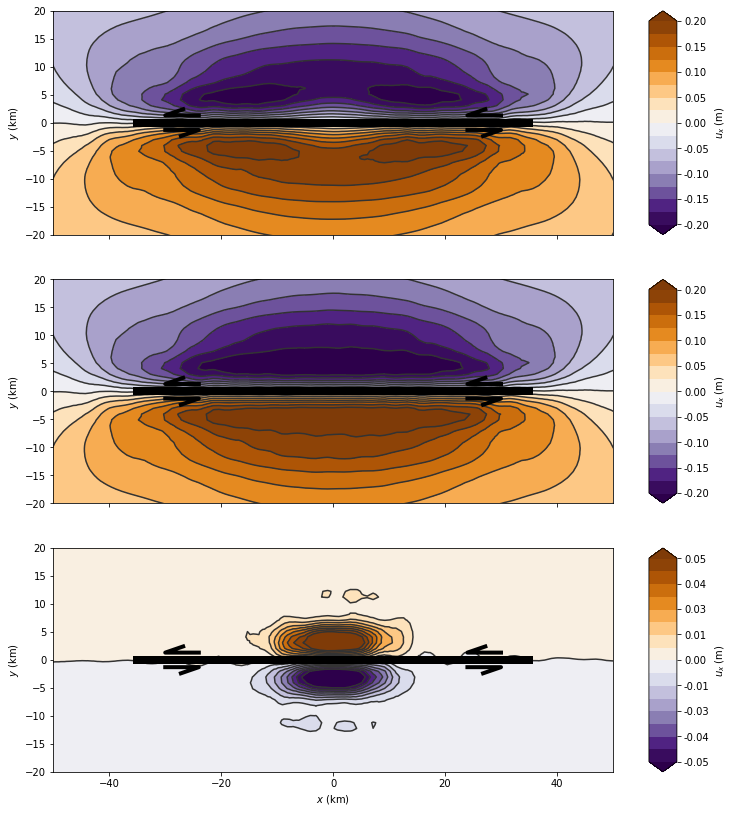

In [9]:
%matplotlib inline
plt.figure(figsize = (12,14))
all_axes = []
test = False
for field_idx in range(3):
    subplot_idx = int('31' + str(field_idx + 1))
    if field_idx == 0:
        ax = plt.subplot(subplot_idx)
    else:
        ax = plt.subplot(subplot_idx, sharex = all_axes[0])
    all_axes.append(ax)
    ax.set_aspect('equal')

    field = fields[field_idx]
    cmap = cm.get_cmap(name='PuOr_r')
    levels = np.linspace(vmin[field_idx], vmax[field_idx], 17)

    if not test:
        triang = tri.Triangulation(flat_surf_pts_km[:,0], flat_surf_pts_km[:,1])
        refiner = tri.UniformTriRefiner(triang)
        tri_refi, interp_vals = refiner.refine_field(field, subdiv=2)
        cntf = plt.tricontourf(tri_refi, interp_vals, levels = levels, extend = 'both', cmap = cmap)
        plt.tricontour(tri_refi, interp_vals, levels = levels, colors = '#333333', linestyles = 'solid', linewidths = 1.5)

    plt.plot([-35,35], [0,0], 'k-', linewidth = 8)
    plt.plot([-26.8,-30,-24], [2.4,1.3,1.3], 'k-', linewidth = 4)
    plt.plot([-27.2,-24,-30], [-2.4,-1.3,-1.3], 'k-', linewidth = 4)
    plt.plot([27.2,24,30], [2.4,1.3,1.3], 'k-', linewidth = 4)
    plt.plot([26.8,30,24], [-2.4,-1.3,-1.3], 'k-', linewidth = 4)
    plt.ylabel('$y$ (km)')
    plt.ylim([-20,20])

    if field_idx < 2:
        plt.setp(ax.get_xticklabels(), visible=False)
    else:
        plt.xlabel('$x$ (km)')
        plt.xlim([-50, 50])

    if not test:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.5)
        cbar = plt.colorbar(cntf, cax = cax)
        cbar.set_label('$u_' + dimname + '$ (m)')
        cbar.set_ticks(levels[::2])
        cbar.set_ticklabels(['{:.2f}'.format(l) for l in levels[::2]])
plt.show()

In [25]:
def gf_runner(args):
    proc_idx, flat = args
    n_gpus = 8
    import os
    os.environ['CUDA_DEVICE'] = str(proc_idx % n_gpus)
    surf = flat_surf if flat else hill_surf
    return cigcdm.gf_builder.build_greens_functions(
        flat_surf, fault, 500000, None, proc_idx, n_procs
    )

In [ ]:
n_procs = 16
with multiprocessing.Pool(n_procs) as pool:
    for flat in [False, True]:
        gf_results = pool.map(gf_runner, zip(range(n_procs), [flat] * n_procs))
        import importlib
        importlib.reload(cigcdm.gf_builder)
        surf_pts, slip_vecs, gfs = cigcdm.gf_builder.combine_gfs(fault, gf_results)
        filename = ('flat' if flat else 'hill') + '_gfs.npy'
        np.save(filename, [surf_pts, slip_vecs, gfs])

Building GFs in 0/16
Building GFs in 1/16
[4, 5, 6, 7]
[0, 1, 2, 3]
Building GFs in 10/16
Building GFs in 2/16
Building GFs in 6/16
Building GFs in 15/16
Building GFs in 11/16
[[ 30625.      0.  -3000.]
 [ 30625.      0.  -9000.]
 [ 26250.      0.  -3000.]]Building GFs in 14/16
Building GFs in 7/16
[[ 35000.      0.  -3000.]
 [ 35000.      0.  -9000.]
 [ 30625.      0.  -3000.]][24, 25, 26, 27]

[44, 45, 46, 47]
[40, 41, 42, 43]
[60, 61, 62, 63]
Building GFs in 4/16
[56, 57, 58, 59]

[28, 29, 30, 31]
[8, 9, 10, 11]
slip vector is [ 0.  0. -1.]
Building GFs in 8/16
[16, 17, 18, 19]
Building GFs in 13/16
slip vector is [ 0.  0. -1.]
Building GFs in 9/16
Building GFs in 3/16
[32, 33, 34, 35]
Building GFs in 12/16
Building GFs in 5/16
[52, 53, 54, 55]
[36, 37, 38, 39]
[48, 49, 50, 51]
[12, 13, 14, 15]
[20, 21, 22, 23]
[[ 4375.     0. -3000.]
 [ 4375.     0. -9000.]
 [    0.     0. -3000.]][[ 21875.      0.  -3000.]
 [ 21875.      0.  -9000.]
 [ 17500.      0.  -3000.]][[-4375.     0. -3000

2017-09-22 18:05:56,832 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- load table took 0.007338047027587891
2017-09-22 18:05:56,833 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- load table took 0.004885196685791016
2017-09-22 18:05:56,835 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- load table took 0.004000186920166016
2017-09-22 18:05:56,843 - tectosaur.nearfield.nearfield_op - DEBUG -     setup pairs integrator took 19.13169264793396
2017-09-22 18:05:56,847 - tectosaur.nearfield.nearfield_op - DEBUG -     setup pairs integrator took 19.11251997947693
2017-09-22 18:05:56,847 - tectosaur.nearfield.nearfield_op - DEBUG -     setup pairs integrator took 19.131470918655396
2017-09-22 18:05:56,848 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- get pts took 0.027199745178222656
2017-09-22 18:05:56,849 - tectosaur.util.gpu - DEBUG - compile took 19.12765622138977
2017-09-22 18:05:56,850 - tectosaur.util.gpu - DEBUG - start compiling nearfiel

2017-09-22 18:05:57,127 - tectosaur.nearfield.nearfield_op - DEBUG -     Coincident correction took 0.005112886428833008
2017-09-22 18:05:57,128 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- from standard took 0.013399124145507812
2017-09-22 18:05:57,130 - tectosaur.nearfield.nearfield_op - DEBUG -     Coincident took 0.30509424209594727
2017-09-22 18:05:57,131 - tectosaur.nearfield.nearfield_op - DEBUG -     Coincident correction took 0.003930091857910156
2017-09-22 18:05:57,132 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- from standard took 0.008893013000488281
2017-09-22 18:05:57,133 - tectosaur.nearfield.nearfield_op - DEBUG -     Coincident took 0.30994439125061035
2017-09-22 18:05:57,134 - tectosaur.nearfield.nearfield_op - DEBUG -     Coincident correction took 0.0035288333892822266
2017-09-22 18:05:57,137 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- interpolate took 0.2870218753814697
2017-09-22 18:05:57,138 - tectosaur.nearfield.nearfie

2017-09-22 18:05:57,215 - tectosaur.util.gpu - DEBUG - returning cached gpu module nearfield/table_lookup.cl
2017-09-22 18:05:57,216 - tectosaur.nearfield.nearfield_op - DEBUG -     Find nearfield/adjacency took 0.0327603816986084
2017-09-22 18:05:57,216 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- generate interp pts wts took 0.0005733966827392578
2017-09-22 18:05:57,216 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- interpolate took 0.29875683784484863
2017-09-22 18:05:57,217 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- generate interp pts wts took 0.0004649162292480469
2017-09-22 18:05:57,218 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- load table took 0.0010905265808105469
2017-09-22 18:05:57,219 - tectosaur.nearfield.nearfield_op - DEBUG -     Coincident took 0.3365797996520996
2017-09-22 18:05:57,219 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- load table took 0.0010030269622802734
2017-09-22 18:05:57,224 - tectosaur.nea

2017-09-22 18:05:57,307 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- generate interp pts wts took 0.0009200572967529297
2017-09-22 18:05:57,310 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- load table took 0.0012714862823486328
2017-09-22 18:05:57,313 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- interpolation took 0.01170802116394043
2017-09-22 18:05:57,326 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- get pts took 0.08158493041992188
2017-09-22 18:05:57,328 - tectosaur.util.gpu - DEBUG - returning cached gpu module nearfield/table_lookup.cl
2017-09-22 18:05:57,332 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- get pts took 0.07662272453308105
2017-09-22 18:05:57,334 - tectosaur.util.gpu - DEBUG - returning cached gpu module nearfield/table_lookup.cl
2017-09-22 18:05:57,337 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- interpolation took 0.008949756622314453
2017-09-22 18:05:57,337 - tectosaur.nearfield.table_lookup - D

2017-09-22 18:05:57,739 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- vert adj subbasis took 0.22182321548461914
2017-09-22 18:05:57,742 - tectosaur.nearfield.nearfield_op - DEBUG -     Edge adjacent took 0.5753006935119629
2017-09-22 18:05:57,751 - tectosaur.nearfield.nearfield_op - DEBUG -     Edge adjacent correction took 0.017783403396606445
2017-09-22 18:05:57,753 - tectosaur.nearfield.nearfield_op - DEBUG -     Edge adjacent correction took 0.008835792541503906
2017-09-22 18:05:57,753 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- vert adj subbasis took 0.2210688591003418
2017-09-22 18:05:57,756 - tectosaur.nearfield.nearfield_op - DEBUG -     Edge adjacent took 0.5923178195953369
2017-09-22 18:05:57,762 - tectosaur.nearfield.nearfield_op - DEBUG -     Edge adjacent correction took 0.00532221794128418
2017-09-22 18:05:57,767 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- vert adj subbasis took 0.2184438705444336
2017-09-22 18:05:57,768 - tectosaur.n

2017-09-22 18:05:57,982 - tectosaur.nearfield.nearfield_op - DEBUG -     Vert adjacent took 0.0719153881072998
2017-09-22 18:05:57,986 - tectosaur.nearfield.nearfield_op - DEBUG -     Nearfield took 0.10447382926940918
2017-09-22 18:05:57,989 - tectosaur.nearfield.nearfield_op - DEBUG -     Vert adjacent correction took 0.012555837631225586
2017-09-22 18:05:57,989 - tectosaur.nearfield.nearfield_op - DEBUG -     Nearfield took 0.10751104354858398
2017-09-22 18:05:57,989 - tectosaur.nearfield.nearfield_op - DEBUG -     Vert adjacent correction took 0.030274391174316406
2017-09-22 18:05:57,996 - tectosaur.nearfield.nearfield_op - DEBUG -     Vert adjacent correction took 0.012979745864868164
2017-09-22 18:05:58,017 - tectosaur.nearfield.nearfield_op - DEBUG -     Nearfield correction took 0.08201408386230469
2017-09-22 18:05:58,021 - tectosaur.nearfield.nearfield_op - DEBUG -     Vert adjacent took 0.08666133880615234
2017-09-22 18:05:58,028 - tectosaur.nearfield.nearfield_op - DEBUG -  

2017-09-22 18:05:58,303 - tectosaur.util.gpu - DEBUG - start compiling fmm/gpu_kernels.cl
2017-09-22 18:05:58,308 - tectosaur.util.gpu - DEBUG - start compiling fmm/gpu_kernels.cl
2017-09-22 18:05:58,312 - tectosaur.nearfield.nearfield_op - DEBUG -     Assemble matrix took 0.07497334480285645
2017-09-22 18:05:58,312 - tectosaur.nearfield.nearfield_op - DEBUG -     Assemble matrix took 0.07640933990478516
2017-09-22 18:05:58,314 - tectosaur.nearfield.nearfield_op - DEBUG -     Assemble uncorrected matrix took 6.508827209472656e-05
2017-09-22 18:05:58,314 - tectosaur.nearfield.nearfield_op - DEBUG -     Assemble uncorrected matrix took 5.2928924560546875e-05
2017-09-22 18:05:58,340 - tectosaur.util.gpu - DEBUG - start compiling fmm/gpu_kernels.cl
2017-09-22 18:05:58,364 - tectosaur.util.gpu - DEBUG - start compiling fmm/gpu_kernels.cl
2017-09-22 18:05:58,366 - tectosaur.util.gpu - DEBUG - start compiling fmm/gpu_kernels.cl
2017-09-22 18:05:58,366 - tectosaur.nearfield.nearfield_op - DEBU

2017-09-22 18:05:58,715 - tectosaur.fmm.builder - DEBUG - total m2p interactions: 6.912000e+05
2017-09-22 18:05:58,715 - tectosaur.fmm.builder - DEBUG - total p2l interactions: 3.456000e+05
2017-09-22 18:05:58,716 - tectosaur.fmm.builder - DEBUG - total l2p interactions: 2.900400e+06
2017-09-22 18:05:58,716 - tectosaur.fmm.builder - DEBUG - total m2m interactions: 3.735000e+06
2017-09-22 18:05:58,716 - tectosaur.fmm.builder - DEBUG - total m2l interactions: 2.904750e+07
2017-09-22 18:05:58,717 - tectosaur.fmm.builder - DEBUG - total l2l interactions: 3.735000e+06
2017-09-22 18:05:58,717 - tectosaur.fmm.builder - DEBUG - total p2p interactions: 9.917770e+07
2017-09-22 18:05:58,718 - tectosaur.fmm.builder - DEBUG - total m2p interactions: 6.720000e+05
2017-09-22 18:05:58,719 - tectosaur.fmm.builder - DEBUG - total l2p interactions: 2.900400e+06
2017-09-22 18:05:58,720 - tectosaur.fmm.builder - DEBUG - total m2m interactions: 3.735000e+06
2017-09-22 18:05:58,721 - tectosaur.fmm.builder - 

2017-09-22 18:05:58,863 - tectosaur.fmm.builder - DEBUG - compression factor: 0.3812251589340366
2017-09-22 18:05:58,863 - tectosaur.fmm.builder - DEBUG - total p2m interactions: 2.900400e+06
2017-09-22 18:05:58,864 - tectosaur.fmm.builder - DEBUG - # obs pts: 19336
2017-09-22 18:05:58,864 - tectosaur.fmm.builder - DEBUG - # src pts: 19336
2017-09-22 18:05:58,864 - tectosaur.fmm.builder - DEBUG - total p2l interactions: 3.456000e+05
2017-09-22 18:05:58,865 - tectosaur.fmm.builder - DEBUG - total tree interactions: 1.425328e+08
2017-09-22 18:05:58,865 - tectosaur.fmm.builder - DEBUG - total m2l interactions: 2.904750e+07
2017-09-22 18:05:58,866 - tectosaur.fmm.builder - DEBUG - total p2m interactions: 2.900400e+06
2017-09-22 18:05:58,866 - tectosaur.fmm.builder - DEBUG - total p2p interactions: 9.913854e+07
2017-09-22 18:05:58,867 - tectosaur.fmm.builder - DEBUG - total p2l interactions: 3.072000e+05
2017-09-22 18:05:58,867 - tectosaur.fmm.builder - DEBUG - total m2p interactions: 7.296

2017-09-22 18:05:59,048 - tectosaur_topo.solve - DEBUG - constraint matrix tocsr took 1.4543533325195312e-05
2017-09-22 18:05:59,052 - tectosaur_topo.solve - DEBUG - Build constraint matrix took 0.20768451690673828
2017-09-22 18:05:59,054 - tectosaur_topo.solve - DEBUG - constraint matrix tocsr took 1.5974044799804688e-05
2017-09-22 18:05:59,061 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.07304692268371582
2017-09-22 18:05:59,065 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0011968612670898438
2017-09-22 18:05:59,067 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0011303424835205078
2017-09-22 18:05:59,088 - tectosaur_topo.solve - DEBUG - Build constraint matrix took 0.24417853355407715
2017-09-22 18:05:59,090 - tectosaur_topo.solve - DEBUG - constraint matrix tocsr took 5.0067901611328125e-06
2017-09-22 18:05:59,090 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03482699394226074
2017-09-22 18:0

2017-09-22 18:05:59,216 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.002088785171508789
2017-09-22 18:05:59,218 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0003466606140136719
2017-09-22 18:05:59,217 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.21807551383972168
2017-09-22 18:05:59,218 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.2235264778137207
2017-09-22 18:05:59,219 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.2202298641204834
2017-09-22 18:05:59,221 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.00052642822265625
2017-09-22 18:05:59,221 - tectosaur_topo.solve - DEBUG - constrain rhs took 0.2790029048919678
2017-09-22 18:05:59,222 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.22481966018676758
2017-09-22 18:05:59,222 - tectosaur_topo.solve - DEBUG - Build preconditioner took 2.8848648071289062e-05
2017-09-22 18:05:59,224 - tectosaur_t

2017-09-22 18:05:59,285 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00030612945556640625
2017-09-22 18:05:59,286 - tectosaur_topo.solve - DEBUG - iteration # 1
2017-09-22 18:05:59,286 - tectosaur_topo.solve - DEBUG - iteration # 2
2017-09-22 18:05:59,287 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.01685309410095215
2017-09-22 18:05:59,288 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00041222572326660156
2017-09-22 18:05:59,288 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.01855158805847168
2017-09-22 18:05:59,288 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0005056858062744141
2017-09-22 18:05:59,291 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0015299320220947266
2017-09-22 18:05:59,292 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.024547338485717773
2017-09-22 18:05:59,292 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0

2017-09-22 18:05:59,344 - tectosaur_topo.solve - DEBUG - Build preconditioner took 2.1457672119140625e-05
2017-09-22 18:05:59,345 - tectosaur_topo.solve - DEBUG - iteration # 1
2017-09-22 18:05:59,346 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0003018379211425781
2017-09-22 18:05:59,348 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013862371444702148
2017-09-22 18:05:59,349 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.01500391960144043
2017-09-22 18:05:59,351 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0008215904235839844
2017-09-22 18:05:59,352 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.019638776779174805
2017-09-22 18:05:59,354 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0006368160247802734
2017-09-22 18:05:59,355 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.024806499481201172
2017-09-22 18:05:59,356 - tectosaur.fmm.evaluator - 

2017-09-22 18:05:59,389 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02297830581665039
2017-09-22 18:05:59,389 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.041543006896972656
2017-09-22 18:05:59,389 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.22279715538024902
2017-09-22 18:05:59,388 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.26465892791748047
2017-09-22 18:05:59,390 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.0707235336303711
2017-09-22 18:05:59,391 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.22483539581298828
2017-09-22 18:05:59,391 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.267535924911499
2017-09-22 18:05:59,391 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.048063039779663086
2017-09-22 18:05:59,391 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0008029937744140625
2017-09-22 18:05:59,391 - tectosaur_t

2017-09-22 18:05:59,420 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07888078689575195
2017-09-22 18:05:59,420 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.0275571346282959
2017-09-22 18:05:59,420 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0014235973358154297
2017-09-22 18:05:59,421 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0010428428649902344
2017-09-22 18:05:59,421 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002753734588623047
2017-09-22 18:05:59,421 - tectosaur_topo.solve - DEBUG - iteration # 3
2017-09-22 18:05:59,421 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07450079917907715
2017-09-22 18:05:59,421 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.2806720733642578
2017-09-22 18:05:59,422 - tectosaur_topo.solve - DEBUG - iteration # 2
2017-09-22 18:05:59,422 - tectosaur.ops.sparse_integral_op - DEBU

2017-09-22 18:05:59,445 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.02829289436340332
2017-09-22 18:05:59,446 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.000331878662109375
2017-09-22 18:05:59,446 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.0711967945098877
2017-09-22 18:05:59,447 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0003871917724609375
2017-09-22 18:05:59,447 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.03010869026184082
2017-09-22 18:05:59,448 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.03328084945678711
2017-09-22 18:05:59,447 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0003063678741455078
2017-09-22 18:05:59,447 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0006864070892333984
2017-09-22 18:05:59,449 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.019761085510253906
2017-09-22

2017-09-22 18:05:59,482 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014867305755615234
2017-09-22 18:05:59,482 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0005691051483154297
2017-09-22 18:05:59,482 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015339136123657227
2017-09-22 18:05:59,483 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0007283687591552734
2017-09-22 18:05:59,484 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.05860638618469238
2017-09-22 18:05:59,484 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.018389463424682617
2017-09-22 18:05:59,484 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0008547306060791016
2017-09-22 18:05:59,485 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0003821849822998047
2017-09-22 18:05:59,486 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.020402193069458008
2017-0

2017-09-22 18:05:59,510 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.029164791107177734
2017-09-22 18:05:59,510 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002875328063964844
2017-09-22 18:05:59,510 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014652490615844727
2017-09-22 18:05:59,511 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.028214216232299805
2017-09-22 18:05:59,510 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06394219398498535
2017-09-22 18:05:59,511 - tectosaur_topo.solve - DEBUG - iteration # 2
2017-09-22 18:05:59,511 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0004918575286865234
2017-09-22 18:05:59,511 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00036144256591796875
2017-09-22 18:05:59,511 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015451192855834961
2017-09-22 18:05:59,511 - tectosaur.ops.sparse_integral_op - 

2017-09-22 18:05:59,536 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.04163694381713867
2017-09-22 18:05:59,538 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0007374286651611328
2017-09-22 18:05:59,538 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0012390613555908203
2017-09-22 18:05:59,538 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.01920008659362793
2017-09-22 18:05:59,538 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.02141404151916504
2017-09-22 18:05:59,538 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0011746883392333984
2017-09-22 18:05:59,539 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.03518867492675781
2017-09-22 18:05:59,539 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.022786378860473633
2017-09-22 18:05:59,539 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0003612041473388672
2017

2017-09-22 18:05:59,562 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015382528305053711
2017-09-22 18:05:59,563 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06842803955078125
2017-09-22 18:05:59,563 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0003457069396972656
2017-09-22 18:05:59,563 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.032745361328125
2017-09-22 18:05:59,563 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0004494190216064453
2017-09-22 18:05:59,564 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0011086463928222656
2017-09-22 18:05:59,564 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.01935863494873047
2017-09-22 18:05:59,564 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00033283233642578125
2017-09-22 18:05:59,565 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.000787

2017-09-22 18:05:59,587 - tectosaur_topo.solve - DEBUG - residual: 0.12430472924949393
2017-09-22 18:05:59,589 - tectosaur_topo.solve - DEBUG - iteration # 6
2017-09-22 18:05:59,589 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0008747577667236328
2017-09-22 18:05:59,589 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.023019075393676758
2017-09-22 18:05:59,589 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0012235641479492188
2017-09-22 18:05:59,590 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0003733634948730469
2017-09-22 18:05:59,590 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.042792320251464844
2017-09-22 18:05:59,590 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.024010658264160156
2017-09-22 18:05:59,591 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00045990943908691406
2017-09-22 18:05:59,591 - tectosaur.ops.sparse_integral_op - DEBUG - fa

2017-09-22 18:05:59,622 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0009515285491943359
2017-09-22 18:05:59,622 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.037476301193237305
2017-09-22 18:05:59,623 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.00043320655822753906
2017-09-22 18:05:59,623 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0010275840759277344
2017-09-22 18:05:59,623 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.03461742401123047
2017-09-22 18:05:59,623 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.03019118309020996
2017-09-22 18:05:59,623 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.0350031852722168
2017-09-22 18:05:59,623 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.024010419845581055
2017-09-22 18:05:59,623 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0014650

2017-09-22 18:05:59,644 - tectosaur_topo.solve - DEBUG - residual: 0.12423396512345344
2017-09-22 18:05:59,644 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0009908676147460938
2017-09-22 18:05:59,644 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.01784062385559082
2017-09-22 18:05:59,645 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.03376960754394531
2017-09-22 18:05:59,645 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0003533363342285156
2017-09-22 18:05:59,645 - tectosaur_topo.solve - DEBUG - iteration # 6
2017-09-22 18:05:59,645 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0013320446014404297
2017-09-22 18:05:59,645 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.022280216217041016
2017-09-22 18:05:59,645 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.03027057647705078
2017-09-22 18:05:59,645 - tectosaur.ops.sparse_integral_op - DEBUG 

2017-09-22 18:05:59,665 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06303834915161133
2017-09-22 18:05:59,665 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0004668235778808594
2017-09-22 18:05:59,665 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0007181167602539062
2017-09-22 18:05:59,666 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002758502960205078
2017-09-22 18:05:59,666 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0012667179107666016
2017-09-22 18:05:59,666 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00021767616271972656
2017-09-22 18:05:59,667 - tectosaur_topo.solve - DEBUG - residual: 0.2950662613096315
2017-09-22 18:05:59,667 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02415156364440918
2017-09-22 18:05:59,668 - tectosaur_topo.solve - DEBUG - iteration # 5
2017-09-22 18:05:59,668 - tectosaur_topo.solve - DEB

2017-09-22 18:05:59,701 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0011341571807861328
2017-09-22 18:05:59,701 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0008132457733154297
2017-09-22 18:05:59,701 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0008871555328369141
2017-09-22 18:05:59,702 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.023643970489501953
2017-09-22 18:05:59,702 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.027953147888183594
2017-09-22 18:05:59,702 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.03203558921813965
2017-09-22 18:05:59,703 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.00043582916259765625
2017-09-22 18:05:59,703 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0004432201385498047
2017-09-22 18:05:59,703 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.0269

2017-09-22 18:05:59,724 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0003380775451660156
2017-09-22 18:05:59,724 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0010485649108886719
2017-09-22 18:05:59,724 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0002970695495605469
2017-09-22 18:05:59,725 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.020972013473510742
2017-09-22 18:05:59,725 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014008522033691406
2017-09-22 18:05:59,725 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.024195432662963867
2017-09-22 18:05:59,725 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.01507258415222168
2017-09-22 18:05:59,725 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.02193617820739746
2017-09-22 18:05:59,726 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.00039696693420410156
2017-09-22 18:05:59,72

2017-09-22 18:05:59,745 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0005657672882080078
2017-09-22 18:05:59,745 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0004360675811767578
2017-09-22 18:05:59,746 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0003712177276611328
2017-09-22 18:05:59,746 - tectosaur_topo.solve - DEBUG - residual: 0.045249725627107974
2017-09-22 18:05:59,747 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.000308990478515625
2017-09-22 18:05:59,747 - tectosaur_topo.solve - DEBUG - iteration # 7
2017-09-22 18:05:59,747 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0015795230865478516
2017-09-22 18:05:59,748 - tectosaur_topo.solve - DEBUG - residual: 0.04539298083531222
2017-09-22 18:05:59,749 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0006465911865234375
2017-09-22 18:05:59,749 - tectosaur_topo.solve - DEBUG - constraint matr

2017-09-22 18:05:59,775 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.03272104263305664
2017-09-22 18:05:59,775 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.01505732536315918
2017-09-22 18:05:59,775 - tectosaur_topo.solve - DEBUG - iteration # 7
2017-09-22 18:05:59,776 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00033283233642578125
2017-09-22 18:05:59,776 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06830501556396484
2017-09-22 18:05:59,776 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0003790855407714844
2017-09-22 18:05:59,776 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03981924057006836
2017-09-22 18:05:59,777 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00041985511779785156
2017-09-22 18:05:59,778 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.030765771865844727
2017-09-22 18:05:59,778 - tectosaur.ops.sparse_integral_o

2017-09-22 18:05:59,796 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07151103019714355
2017-09-22 18:05:59,796 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0005183219909667969
2017-09-22 18:05:59,796 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.01395106315612793
2017-09-22 18:05:59,797 - tectosaur_topo.solve - DEBUG - iteration # 7
2017-09-22 18:05:59,797 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0011086463928222656
2017-09-22 18:05:59,797 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.018093585968017578
2017-09-22 18:05:59,797 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06198406219482422
2017-09-22 18:05:59,798 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0005397796630859375
2017-09-22 18:05:59,797 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015172958374023438
2017-09-22 18:05:59,798 - tectosaur_topo

2017-09-22 18:05:59,822 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00022840499877929688
2017-09-22 18:05:59,823 - tectosaur_topo.solve - DEBUG - residual: 0.019455347779226445
2017-09-22 18:05:59,823 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0007307529449462891
2017-09-22 18:05:59,823 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013761758804321289
2017-09-22 18:05:59,824 - tectosaur_topo.solve - DEBUG - iteration # 8
2017-09-22 18:05:59,824 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014678478240966797
2017-09-22 18:05:59,825 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03174328804016113
2017-09-22 18:05:59,825 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0003750324249267578
2017-09-22 18:05:59,826 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0007698535919189453
2017-09-22 18:05:59,827 - tectosaur.ops.sparse_integral_op - DEBUG - i

2017-09-22 18:05:59,845 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0004799365997314453
2017-09-22 18:05:59,846 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0012633800506591797
2017-09-22 18:05:59,847 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013976335525512695
2017-09-22 18:05:59,847 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.01920628547668457
2017-09-22 18:05:59,847 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.0443720817565918
2017-09-22 18:05:59,848 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015395879745483398
2017-09-22 18:05:59,849 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0006208419799804688
2017-09-22 18:05:59,849 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0013468265533447266
2017-09-22 18:05:59,849 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0010640621185302734


2017-09-22 18:05:59,869 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0004961490631103516
2017-09-22 18:05:59,869 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06138324737548828
2017-09-22 18:05:59,869 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00028634071350097656
2017-09-22 18:05:59,869 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00036072731018066406
2017-09-22 18:05:59,870 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013766050338745117
2017-09-22 18:05:59,870 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.019728660583496094
2017-09-22 18:05:59,870 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07197713851928711
2017-09-22 18:05:59,871 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00022363662719726562
2017-09-22 18:05:59,871 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.0145

2017-09-22 18:05:59,896 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0009434223175048828
2017-09-22 18:05:59,896 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.000782012939453125
2017-09-22 18:05:59,896 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.019179582595825195
2017-09-22 18:05:59,896 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.04032778739929199
2017-09-22 18:05:59,897 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.018659114837646484
2017-09-22 18:05:59,897 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03828096389770508
2017-09-22 18:05:59,897 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.000782012939453125
2017-09-22 18:05:59,897 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014383316040039062
2017-09-22 18:05:59,898 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.000928878784179687

2017-09-22 18:05:59,920 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03579115867614746
2017-09-22 18:05:59,921 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0010597705841064453
2017-09-22 18:05:59,921 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00040841102600097656
2017-09-22 18:05:59,921 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0010650157928466797
2017-09-22 18:05:59,921 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0003032684326171875
2017-09-22 18:05:59,921 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.02786850929260254
2017-09-22 18:05:59,922 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02445363998413086
2017-09-22 18:05:59,922 - tectosaur_topo.solve - DEBUG - residual: 0.0031844734009477413
2017-09-22 18:05:59,922 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02400350570678711
2017-

2017-09-22 18:05:59,942 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.018423080444335938
2017-09-22 18:05:59,942 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.027652502059936523
2017-09-22 18:05:59,943 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0003933906555175781
2017-09-22 18:05:59,944 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013916730880737305
2017-09-22 18:05:59,944 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0010063648223876953
2017-09-22 18:05:59,945 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015059471130371094
2017-09-22 18:05:59,945 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.023088455200195312
2017-09-22 18:05:59,945 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07049894332885742
2017-09-22 18:05:59,946 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.00040268898010253906
2017-09-22 

2017-09-22 18:05:59,966 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.05964159965515137
2017-09-22 18:05:59,966 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03591609001159668
2017-09-22 18:05:59,966 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002803802490234375
2017-09-22 18:05:59,967 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002715587615966797
2017-09-22 18:05:59,968 - tectosaur_topo.solve - DEBUG - residual: 0.0005710933434093127
2017-09-22 18:05:59,968 - tectosaur_topo.solve - DEBUG - residual: 0.001348336374756211
2017-09-22 18:05:59,968 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0009222030639648438
2017-09-22 18:05:59,968 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.04156923294067383
2017-09-22 18:05:59,969 - tectosaur_topo.solve - DEBUG - iteration # 12
2017-09-22 18:05:59,969 - tectosaur.ops.sparse_integral_op - DEB

2017-09-22 18:05:59,995 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014003515243530273
2017-09-22 18:05:59,995 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0003631114959716797
2017-09-22 18:05:59,995 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002911090850830078
2017-09-22 18:05:59,995 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0002238750457763672
2017-09-22 18:05:59,996 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.000705718994140625
2017-09-22 18:05:59,996 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015223264694213867
2017-09-22 18:05:59,996 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0004975795745849609
2017-09-22 18:05:59,996 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.018666744232177734
2017-09-22 18:05:59,996 - tectosaur_topo.solve - DEBUG - residual: 0.0013487854603442516
2017-09-22 18:05:59,9

2017-09-22 18:06:00,017 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0013027191162109375
2017-09-22 18:06:00,017 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06632161140441895
2017-09-22 18:06:00,017 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0002701282501220703
2017-09-22 18:06:00,018 - tectosaur_topo.solve - DEBUG - residual: 0.0013566233937928776
2017-09-22 18:06:00,018 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0009558200836181641
2017-09-22 18:06:00,018 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00030612945556640625
2017-09-22 18:06:00,018 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.024714946746826172
2017-09-22 18:06:00,019 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.023975849151611328
2017-09-22 18:06:00,019 - tectosaur_topo.solve - DEBUG - iteration # 11
2017-09-22 18:06:00,019 - tectosaur_t

2017-09-22 18:06:00,044 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0010859966278076172
2017-09-22 18:06:00,044 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.023450613021850586
2017-09-22 18:06:00,044 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0012714862823486328
2017-09-22 18:06:00,045 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.001241922378540039
2017-09-22 18:06:00,045 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.023272037506103516
2017-09-22 18:06:00,046 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0009229183197021484
2017-09-22 18:06:00,046 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0007452964782714844
2017-09-22 18:06:00,046 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013951301574707031
2017-09-22 18:06:00,046 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 

2017-09-22 18:06:00,068 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0011682510375976562
2017-09-22 18:06:00,068 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0011396408081054688
2017-09-22 18:06:00,068 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0011112689971923828
2017-09-22 18:06:00,069 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.025655746459960938
2017-09-22 18:06:00,069 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02427220344543457
2017-09-22 18:06:00,069 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.026173830032348633
2017-09-22 18:06:00,071 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06206369400024414
2017-09-22 18:06:00,071 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07111692428588867
2017-09-22 18:06:00,071 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07

2017-09-22 18:06:00,091 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.0361175537109375
2017-09-22 18:06:00,091 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0004096031188964844
2017-09-22 18:06:00,091 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.034055471420288086
2017-09-22 18:06:00,091 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0013880729675292969
2017-09-22 18:06:00,091 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06577539443969727
2017-09-22 18:06:00,092 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0007114410400390625
2017-09-22 18:06:00,092 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0006895065307617188
2017-09-22 18:06:00,093 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.0355067253112793
2017-09-22 18:06:00,093 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.031086444854

2017-09-22 18:06:00,113 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00028967857360839844
2017-09-22 18:06:00,113 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0007512569427490234
2017-09-22 18:06:00,113 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.019614458084106445
2017-09-22 18:06:00,114 - tectosaur_topo.solve - DEBUG - residual: 0.0013534922881911907
2017-09-22 18:06:00,114 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0011434555053710938
2017-09-22 18:06:00,114 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.019234657287597656
2017-09-22 18:06:00,114 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.000888824462890625
2017-09-22 18:06:00,114 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0004868507385253906
2017-09-22 18:06:00,115 - tectosaur_topo.solve - DEBUG - iteration # 11
2017-09-22 18:06:00,115 - tectosa

2017-09-22 18:06:00,141 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014015913009643555
2017-09-22 18:06:00,141 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.000263214111328125
2017-09-22 18:06:00,141 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0009999275207519531
2017-09-22 18:06:00,141 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0012192726135253906
2017-09-22 18:06:00,141 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06545734405517578
2017-09-22 18:06:00,141 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03114032745361328
2017-09-22 18:06:00,141 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014986515045166016
2017-09-22 18:06:00,142 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014004945755004883
2017-09-22 18:06:00,142 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.021920442581176758
2017-09-22 

2017-09-22 18:06:00,161 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014231681823730469
2017-09-22 18:06:00,161 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.01744985580444336
2017-09-22 18:06:00,162 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015466928482055664
2017-09-22 18:06:00,162 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00034499168395996094
2017-09-22 18:06:00,163 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06448745727539062
2017-09-22 18:06:00,163 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0007219314575195312
2017-09-22 18:06:00,163 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013874053955078125
2017-09-22 18:06:00,164 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00024008750915527344
2017-09-22 18:06:00,164 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0006334781646728516
2017-09-22 18:06:0

2017-09-22 18:06:00,186 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0003941059112548828
2017-09-22 18:06:00,186 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.01886582374572754
2017-09-22 18:06:00,186 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.036284446716308594
2017-09-22 18:06:00,187 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0003216266632080078
2017-09-22 18:06:00,187 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.031786203384399414
2017-09-22 18:06:00,187 - tectosaur_topo.solve - DEBUG - iteration # 12
2017-09-22 18:06:00,188 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0002484321594238281
2017-09-22 18:06:00,188 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.01733255386352539
2017-09-22 18:06:00,188 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0010232925415039062
2017-09-22 18:06:00,188 - tectosaur

2017-09-22 18:06:00,211 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0011708736419677734
2017-09-22 18:06:00,211 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0016417503356933594
2017-09-22 18:06:00,212 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0006568431854248047
2017-09-22 18:06:00,212 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0011065006256103516
2017-09-22 18:06:00,212 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03940916061401367
2017-09-22 18:06:00,212 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.025235414505004883
2017-09-22 18:06:00,213 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.02058577537536621
2017-09-22 18:06:00,213 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.029695987701416016
2017-09-22 18:06:00,213 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0

2017-09-22 18:06:00,233 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0008521080017089844
2017-09-22 18:06:00,233 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0007202625274658203
2017-09-22 18:06:00,234 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.023899316787719727
2017-09-22 18:06:00,233 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.04454541206359863
2017-09-22 18:06:00,234 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.034047603607177734
2017-09-22 18:06:00,234 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013817548751831055
2017-09-22 18:06:00,234 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.0195462703704834
2017-09-22 18:06:00,235 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.061002492904663086
2017-09-22 18:06:00,236 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.000775098800659179

2017-09-22 18:06:00,264 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0006961822509765625
2017-09-22 18:06:00,264 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.042916297912597656
2017-09-22 18:06:00,265 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02286362648010254
2017-09-22 18:06:00,265 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.020168781280517578
2017-09-22 18:06:00,264 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.035437822341918945
2017-09-22 18:06:00,265 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0003457069396972656
2017-09-22 18:06:00,266 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06605195999145508
2017-09-22 18:06:00,266 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0011327266693115234
2017-09-22 18:06:00,266 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06859421730041504
201

2017-09-22 18:06:00,292 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.01394200325012207
2017-09-22 18:06:00,292 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.027194976806640625
2017-09-22 18:06:00,292 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.01569843292236328
2017-09-22 18:06:00,292 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.02306509017944336
2017-09-22 18:06:00,293 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00037407875061035156
2017-09-22 18:06:00,293 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015411615371704102
2017-09-22 18:06:00,293 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.024165630340576172
2017-09-22 18:06:00,293 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0006504058837890625
2017-09-22 18:06:00,294 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06676125526428223
2017-09-22 18:06:00,294 - tectos

2017-09-22 18:06:00,308 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.07736873626708984
2017-09-22 18:06:00,309 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.001027822494506836
2017-09-22 18:06:00,310 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00017762184143066406
2017-09-22 18:06:00,309 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.024656295776367188
2017-09-22 18:06:00,310 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.05620908737182617
2017-09-22 18:06:00,310 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.025822162628173828
2017-09-22 18:06:00,310 - tectosaur_topo.solve - DEBUG - residual: 0.00023110968938771525
2017-09-22 18:06:00,311 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00022864341735839844
2017-09-22 18:06:00,310 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.001121759414

2017-09-22 18:06:00,340 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.05899763107299805
2017-09-22 18:06:00,340 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00036454200744628906
2017-09-22 18:06:00,340 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0010764598846435547
2017-09-22 18:06:00,340 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0003955364227294922
2017-09-22 18:06:00,341 - tectosaur_topo.solve - DEBUG - residual: 3.933800099307808e-05
2017-09-22 18:06:00,341 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0003559589385986328
2017-09-22 18:06:00,341 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.023842573165893555
2017-09-22 18:06:00,342 - tectosaur_topo.solve - DEBUG - residual: 9.647933135388847e-05
2017-09-22 18:06:00,341 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.0436704158782959
2017-09-22 18:06:00,341

2017-09-22 18:06:00,371 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0009224414825439453
2017-09-22 18:06:00,371 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0011796951293945312
2017-09-22 18:06:00,371 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07372236251831055
2017-09-22 18:06:00,372 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.019901514053344727
2017-09-22 18:06:00,372 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.000385284423828125
2017-09-22 18:06:00,372 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013799190521240234
2017-09-22 18:06:00,372 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00035119056701660156
2017-09-22 18:06:00,373 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002942085266113281
2017-09-22 18:06:00,373 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.0146365165

2017-09-22 18:06:00,388 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014826536178588867
2017-09-22 18:06:00,388 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0013959407806396484
2017-09-22 18:06:00,387 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.01419520378112793
2017-09-22 18:06:00,388 - tectosaur_topo.solve - DEBUG - iteration # 15
2017-09-22 18:06:00,388 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.03354001045227051
2017-09-22 18:06:00,388 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0004227161407470703
2017-09-22 18:06:00,388 - tectosaur_topo.solve - DEBUG - residual: 3.911949565569312e-05
2017-09-22 18:06:00,388 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015366315841674805
2017-09-22 18:06:00,388 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.04463601112365723
2017-09-22 18:06:00,389 - tectosaur.ops.sparse_integral_op - DEBUG - to output s

2017-09-22 18:06:00,412 - tectosaur_topo.solve - DEBUG - iteration # 16
2017-09-22 18:06:00,412 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0009906291961669922
2017-09-22 18:06:00,413 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02383136749267578
2017-09-22 18:06:00,414 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0003981590270996094
2017-09-22 18:06:00,415 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07135653495788574
2017-09-22 18:06:00,416 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00034427642822265625
2017-09-22 18:06:00,417 - tectosaur_topo.solve - DEBUG - residual: 3.9356343031179485e-05
2017-09-22 18:06:00,417 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03885817527770996
2017-09-22 18:06:00,418 - tectosaur_topo.solve - DEBUG - iteration # 15
2017-09-22 18:06:00,419 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_ma

2017-09-22 18:06:00,446 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.01847243309020996
2017-09-22 18:06:00,446 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00037479400634765625
2017-09-22 18:06:00,447 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.01391458511352539
2017-09-22 18:06:00,447 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00037550926208496094
2017-09-22 18:06:00,447 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.000476837158203125
2017-09-22 18:06:00,447 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0009024143218994141
2017-09-22 18:06:00,447 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014788150787353516
2017-09-22 18:06:00,448 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.019148826599121094
2017-09-22 18:06:00,447 - tectosaur_topo.solve - DEBUG - residual: 6.642879459968329e-06
2017-09-22 18:06:00

2017-09-22 18:06:00,463 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0009403228759765625
2017-09-22 18:06:00,464 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0005590915679931641
2017-09-22 18:06:00,463 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013883352279663086
2017-09-22 18:06:00,464 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.028972148895263672
2017-09-22 18:06:00,464 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.022048234939575195
2017-09-22 18:06:00,464 - tectosaur_topo.solve - DEBUG - iteration # 16
2017-09-22 18:06:00,464 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.0765533447265625
2017-09-22 18:06:00,464 - tectosaur_topo.solve - DEBUG - residual: 1.5827324838289025e-05
2017-09-22 18:06:00,465 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015301704406738281
2017-09-22 18:06:00,465 - tectosaur.ops.sparse_integral_op - D

2017-09-22 18:06:00,500 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0006401538848876953
2017-09-22 18:06:00,500 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.028445720672607422
2017-09-22 18:06:00,500 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.016652584075927734
2017-09-22 18:06:00,500 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.032326698303222656
2017-09-22 18:06:00,500 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.019539833068847656
2017-09-22 18:06:00,501 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0004496574401855469
2017-09-22 18:06:00,502 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.01999187469482422
2017-09-22 18:06:00,501 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.02959442138671875
2017-09-22 18:06:00,502 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0008606910705566406
2017-

2017-09-22 18:06:00,520 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.017711639404296875
2017-09-22 18:06:00,521 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.016263484954833984
2017-09-22 18:06:00,522 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0004138946533203125
2017-09-22 18:06:00,522 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014320611953735352
2017-09-22 18:06:00,522 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.024819374084472656
2017-09-22 18:06:00,522 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.017703771591186523
2017-09-22 18:06:00,523 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015627384185791016
2017-09-22 18:06:00,523 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0010976791381835938
2017-09-22 18:06:00,523 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014081239700317383
2017-09-22 18:06:00,524 

2017-09-22 18:06:00,535 - tectosaur_topo.solve - DEBUG - iteration # 20
2017-09-22 18:06:00,535 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0006320476531982422
2017-09-22 18:06:00,534 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07175278663635254
2017-09-22 18:06:00,535 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.0673983097076416
2017-09-22 18:06:00,535 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014980792999267578
2017-09-22 18:06:00,535 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00031113624572753906
2017-09-22 18:06:00,536 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0003390312194824219
2017-09-22 18:06:00,535 - tectosaur_topo.solve - DEBUG - iteration # 20
2017-09-22 18:06:00,536 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0003142356872558594
2017-09-22 18:06:00,536 - tectosaur_topo.solve - DEBUG - iteration # 

2017-09-22 18:06:00,575 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0009114742279052734
2017-09-22 18:06:00,575 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0010683536529541016
2017-09-22 18:06:00,574 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.06155133247375488
2017-09-22 18:06:00,575 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.034940242767333984
2017-09-22 18:06:00,576 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.000965118408203125
2017-09-22 18:06:00,576 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00034618377685546875
2017-09-22 18:06:00,577 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0012021064758300781
2017-09-22 18:06:00,577 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00038552284240722656
2017-09-22 18:06:00,577 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot

2017-09-22 18:06:00,605 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.027750492095947266
2017-09-22 18:06:00,605 - tectosaur_topo.solve - DEBUG - iteration # 19
2017-09-22 18:06:00,605 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.026673078536987305
2017-09-22 18:06:00,605 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.025439739227294922
2017-09-22 18:06:00,606 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.02969217300415039
2017-09-22 18:06:00,606 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0006387233734130859
2017-09-22 18:06:00,606 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0007102489471435547
2017-09-22 18:06:00,606 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0010073184967041016
2017-09-22 18:06:00,607 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.02674388885498047
2017-09-22 18:06:00,607 - tectosaur.ops.sparse_integral_op 

2017-09-22 18:06:00,618 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00043392181396484375
2017-09-22 18:06:00,618 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0002315044403076172
2017-09-22 18:06:00,618 - tectosaur_topo.solve - DEBUG - residual: 1.1280428978423598e-06
2017-09-22 18:06:00,618 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00029087066650390625
2017-09-22 18:06:00,618 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.030971288681030273
2017-09-22 18:06:00,619 - tectosaur_topo.solve - DEBUG - iteration # 19
2017-09-22 18:06:00,618 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0007963180541992188
2017-09-22 18:06:00,619 - tectosaur_topo.solve - DEBUG - iteration # 17
2017-09-22 18:06:00,619 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.00042724609375
2017-09-22 18:06:00,619 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00054335594177246

2017-09-22 18:06:00,655 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03342008590698242
2017-09-22 18:06:00,655 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0009362697601318359
2017-09-22 18:06:00,655 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0008502006530761719
2017-09-22 18:06:00,656 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014816999435424805
2017-09-22 18:06:00,656 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0006344318389892578
2017-09-22 18:06:00,657 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0010297298431396484
2017-09-22 18:06:00,657 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0003466606140136719
2017-09-22 18:06:00,657 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0010669231414794922
2017-09-22 18:06:00,657 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.000875

2017-09-22 18:06:00,681 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0006387233734130859
2017-09-22 18:06:00,681 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.024782419204711914
2017-09-22 18:06:00,681 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02509784698486328
2017-09-22 18:06:00,682 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014093399047851562
2017-09-22 18:06:00,682 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0007512569427490234
2017-09-22 18:06:00,682 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.016845703125
2017-09-22 18:06:00,683 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.01905965805053711
2017-09-22 18:06:00,683 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.018458127975463867
2017-09-22 18:06:00,683 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06422972679138184
2017-09-22 18:06:00,683 - tectosaur.op

2017-09-22 18:06:00,696 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0008788108825683594
2017-09-22 18:06:00,696 - tectosaur_topo.solve - DEBUG - iteration # 19
2017-09-22 18:06:00,696 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.01872563362121582
2017-09-22 18:06:00,696 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07846593856811523
2017-09-22 18:06:00,696 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0004425048828125
2017-09-22 18:06:00,696 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07489609718322754
2017-09-22 18:06:00,696 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07529497146606445
2017-09-22 18:06:00,697 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014106273651123047
2017-09-22 18:06:00,697 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00034356117248535156
2017-09-22 18:06:00,697 - tectosaur_topo.solv

2017-09-22 18:06:00,733 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.018584012985229492
2017-09-22 18:06:00,733 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013928651809692383
2017-09-22 18:06:00,734 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.023999929428100586
2017-09-22 18:06:00,734 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014776468276977539
2017-09-22 18:06:00,733 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.035552263259887695
2017-09-22 18:06:00,733 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.043665170669555664
2017-09-22 18:06:00,735 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0010645389556884766
2017-09-22 18:06:00,735 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0003612041473388672
2017-09-22 18:06:00,735 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.059854745864868164
2017-09-22 

2017-09-22 18:06:00,754 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.044071197509765625
2017-09-22 18:06:00,754 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0010013580322265625
2017-09-22 18:06:00,755 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0006365776062011719
2017-09-22 18:06:00,755 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0003459453582763672
2017-09-22 18:06:00,755 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.01627349853515625
2017-09-22 18:06:00,755 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.0207369327545166
2017-09-22 18:06:00,756 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0011310577392578125
2017-09-22 18:06:00,757 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06709408760070801
2017-09-22 18:06:00,757 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.000819206

2017-09-22 18:06:00,777 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0011088848114013672
2017-09-22 18:06:00,777 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0004677772521972656
2017-09-22 18:06:00,777 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015140056610107422
2017-09-22 18:06:00,777 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.020083904266357422
2017-09-22 18:06:00,778 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0012464523315429688
2017-09-22 18:06:00,778 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.00113677978515625
2017-09-22 18:06:00,778 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.03491663932800293
2017-09-22 18:06:00,778 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06813383102416992
2017-09-22 18:06:00,778 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply 

2017-09-22 18:06:00,808 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0001842975616455078
2017-09-22 18:06:00,808 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.019582033157348633
2017-09-22 18:06:00,810 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0010335445404052734
2017-09-22 18:06:00,810 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.01495814323425293
2017-09-22 18:06:00,811 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02405548095703125
2017-09-22 18:06:00,811 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.016173124313354492
2017-09-22 18:06:00,811 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014265060424804688
2017-09-22 18:06:00,811 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.018567800521850586
2017-09-22 18:06:00,812 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.0137786865234375
2017-09-22 18:06:00,812 - tectos

2017-09-22 18:06:00,836 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013939142227172852
2017-09-22 18:06:00,836 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.00039458274841308594
2017-09-22 18:06:00,836 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013855934143066406
2017-09-22 18:06:00,836 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.001054525375366211
2017-09-22 18:06:00,836 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014799118041992188
2017-09-22 18:06:00,836 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.018799543380737305
2017-09-22 18:06:00,836 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.05000901222229004
2017-09-22 18:06:00,836 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014136314392089844
2017-09-22 18:06:00,837 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014964580535888672
2017-09-22 18:06:00,838 - tec


2017-09-22 18:06:00,854 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015098333358764648
2017-09-22 18:06:00,854 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.0755469799041748
2017-09-22 18:06:00,854 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.023902177810668945
2017-09-22 18:06:00,854 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013735294342041016
2017-09-22 18:06:00,855 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0004086494445800781
2017-09-22 18:06:00,855 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014703512191772461
slip vector is [-1.  0.  0.]
2017-09-22 18:06:00,855 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.01852107048034668
2017-09-22 18:06:00,855 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00032639503479003906
2017-09-22 18:06:00,856 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.0719282

2017-09-22 18:06:00,882 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.021853923797607422
2017-09-22 18:06:00,884 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.001262664794921875
2017-09-22 18:06:00,884 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.023012399673461914
2017-09-22 18:06:00,884 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0012083053588867188
2017-09-22 18:06:00,885 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.058977603912353516
2017-09-22 18:06:00,885 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.027148723602294922
2017-09-22 18:06:00,886 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.01630115509033203
2017-09-22 18:06:00,886 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.060114145278930664
2017-09-22 18:06:00,885 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.0154876708984375
2017-0

2017-09-22 18:06:00,910 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0007266998291015625
2017-09-22 18:06:00,911 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0009562969207763672
2017-09-22 18:06:00,911 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.020732641220092773
2017-09-22 18:06:00,911 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02534198760986328
2017-09-22 18:06:00,912 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0009167194366455078
2017-09-22 18:06:00,913 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0003490447998046875
2017-09-22 18:06:00,913 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0013926029205322266
2017-09-22 18:06:00,913 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.08758258819580078
2017-09-22 18:06:00,914 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.01

2017-09-22 18:06:00,937 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.03140068054199219
2017-09-22 18:06:00,937 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0034301280975341797
2017-09-22 18:06:00,938 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002865791320800781
2017-09-22 18:06:00,938 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.03467440605163574
2017-09-22 18:06:00,938 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0009284019470214844
2017-09-22 18:06:00,938 - tectosaur_topo.solve - DEBUG - residual: 1.8977487559431443e-07
2017-09-22 18:06:00,939 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0011141300201416016
2017-09-22 18:06:00,939 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.03606295585632324
2017-09-22 18:06:00,939 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00035119056

2017-09-22 18:06:00,965 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00028228759765625
2017-09-22 18:06:00,966 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.00035953521728515625
2017-09-22 18:06:00,966 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.018399953842163086
2017-09-22 18:06:00,966 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0005159378051757812
2017-09-22 18:06:00,966 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03325080871582031
2017-09-22 18:06:00,967 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0005364418029785156
2017-09-22 18:06:00,967 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0010323524475097656
2017-09-22 18:06:00,968 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0009534358978271484
2017-09-22 18:06:00,968 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took

2017-09-22 18:06:01,001 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0010843276977539062
2017-09-22 18:06:01,002 - tectosaur_topo.solve - DEBUG - residual: 5.641192504039707e-09
2017-09-22 18:06:01,003 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0006334781646728516
2017-09-22 18:06:01,003 - tectosaur_topo.solve - DEBUG - GMRES took 1.7275683879852295
2017-09-22 18:06:01,004 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0013170242309570312
2017-09-22 18:06:01,004 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.06162452697753906
2017-09-22 18:06:01,004 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0012028217315673828
2017-09-22 18:06:01,005 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.03747892379760742
2017-09-22 18:06:01,005 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.019683361053466797
2017-09-22 18:06:01,006 - tectosau

2017-09-22 18:06:01,031 - tectosaur_topo.solve - DEBUG - GMRES took 1.6920621395111084
2017-09-22 18:06:01,032 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0008823871612548828
2017-09-22 18:06:01,032 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.000339508056640625
2017-09-22 18:06:01,032 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.022867441177368164
2017-09-22 18:06:01,033 - tectosaur_topo.solve - DEBUG - residual: 7.862681731448423e-08
2017-09-22 18:06:01,034 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.051772356033325195
2017-09-22 18:06:01,034 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.034316062927246094
2017-09-22 18:06:01,034 - tectosaur_topo.solve - DEBUG - iteration # 22
2017-09-22 18:06:01,035 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002620220184326172
[[ 21875.      0.  -3000.]
 [ 21875.      0.  -9000.]
 [ 17500

2017-09-22 18:06:01,106 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014766454696655273
2017-09-22 18:06:01,107 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0005087852478027344
2017-09-22 18:06:01,108 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0004115104675292969
2017-09-22 18:06:01,108 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.01758575439453125
2017-09-22 18:06:01,109 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0005309581756591797
2017-09-22 18:06:01,110 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.020998239517211914
2017-09-22 18:06:01,111 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.060858964920043945
2017-09-22 18:06:01,112 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0001914501190185547
2017-09-22 18:06:01,113 - tectosaur_topo.solve - DEBUG - residual: 3.2918888345975705e-08
2017-09-22 18

[[-30625.      0.  -3000.]
 [-30625.      0.  -9000.]
 [-35000.      0.  -3000.]]2017-09-22 18:06:01,210 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0003428459167480469

slip vector is [-1.  0.  0.]
2017-09-22 18:06:01,211 - tectosaur_topo.solve - DEBUG - residual: 3.2878329115350694e-08
2017-09-22 18:06:01,213 - tectosaur_topo.solve - DEBUG - iteration # 23
Building GFs for fault triangle 52 with 32 subtris.
2017-09-22 18:06:01,214 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00021004676818847656
2017-09-22 18:06:01,266 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.050942182540893555
2017-09-22 18:06:01,268 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0008363723754882812
2017-09-22 18:06:01,269 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0005006790161132812
Building GFs for fault triangle 60 with 32 subtris.
2017-09-22 18:06:01,284 - tectosaur.fmm.evaluator -

2017-09-22 18:06:01,491 - tectosaur.util.gpu - DEBUG - returning cached gpu module nearfield/nearfield.cl
2017-09-22 18:06:01,494 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- from standard took 0.011238336563110352
2017-09-22 18:06:01,498 - tectosaur.util.gpu - DEBUG - returning cached gpu module nearfield/nearfield.cl
2017-09-22 18:06:01,499 - tectosaur.nearfield.nearfield_op - DEBUG -     setup pairs integrator took 0.008275270462036133
2017-09-22 18:06:01,499 - tectosaur.util.gpu - DEBUG - returning cached gpu module nearfield/nearfield.cl
2017-09-22 18:06:01,500 - tectosaur.util.gpu - DEBUG - returning cached gpu module nearfield/nearfield.cl
2017-09-22 18:06:01,501 - tectosaur.nearfield.nearfield_op - DEBUG -     Coincident took 0.050436973571777344
2017-09-22 18:06:01,502 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- from standard took 0.0504148006439209
2017-09-22 18:06:01,503 - tectosaur.util.gpu - DEBUG - returning cached gpu module nearfield/nearfield

2017-09-22 18:06:01,580 - tectosaur.nearfield.nearfield_op - DEBUG -     Coincident took 0.04433178901672363
2017-09-22 18:06:01,580 - tectosaur.nearfield.nearfield_op - DEBUG -     Find nearfield/adjacency took 0.06692719459533691
2017-09-22 18:06:01,582 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- generate interp pts wts took 0.0005083084106445312
2017-09-22 18:06:01,582 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- load table took 0.0033168792724609375
2017-09-22 18:06:01,583 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- load table took 0.0042269229888916016
2017-09-22 18:06:01,584 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- load table took 0.0011925697326660156
2017-09-22 18:06:01,586 - tectosaur.nearfield.nearfield_op - DEBUG -     Coincident correction took 0.005166292190551758
2017-09-22 18:06:01,587 - tectosaur.nearfield.nearfield_op - DEBUG -     Coincident took 0.0699307918548584
2017-09-22 18:06:01,594 - tectosaur.nearfield.

2017-09-22 18:06:01,674 - tectosaur.nearfield.nearfield_op - DEBUG -     Find nearfield/adjacency took 0.03512454032897949
2017-09-22 18:06:01,675 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- generate interp pts wts took 0.0003948211669921875
2017-09-22 18:06:01,676 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- interpolation took 0.011494874954223633
2017-09-22 18:06:01,677 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- load table took 0.0006840229034423828
2017-09-22 18:06:01,677 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- interpolate took 0.01696491241455078
2017-09-22 18:06:01,682 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- interpolation took 0.010721206665039062
2017-09-22 18:06:01,683 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- interpolation took 0.010991096496582031
2017-09-22 18:06:01,685 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- from standard took 0.006539106369018555
2017-09-22 18:06:01,

2017-09-22 18:06:01,866 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- vert adj subpairs took 0.14580345153808594
2017-09-22 18:06:01,870 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- vert adj subpairs took 0.1558551788330078
2017-09-22 18:06:01,878 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- vert adj subpairs took 0.1702723503112793
2017-09-22 18:06:01,883 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- from standard took 0.054579973220825195
2017-09-22 18:06:01,884 - tectosaur.util.gpu - DEBUG - returning cached gpu module nearfield/nearfield.cl
2017-09-22 18:06:01,884 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- vert adj subbasis took 0.2130582332611084
2017-09-22 18:06:01,885 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- vert adj subpairs took 0.16683578491210938
2017-09-22 18:06:01,887 - tectosaur.nearfield.nearfield_op - DEBUG -     Edge adjacent took 0.49053144454956055
2017-09-22 18:06:01,892 - tectosaur.nearfiel

2017-09-22 18:06:02,174 - tectosaur.nearfield.nearfield_op - DEBUG -     Edge adjacent correction took 0.011930227279663086
2017-09-22 18:06:02,176 - tectosaur.nearfield.nearfield_op - DEBUG -     Edge adjacent took 0.5094349384307861
2017-09-22 18:06:02,184 - tectosaur.nearfield.nearfield_op - DEBUG -     Edge adjacent correction took 0.01877593994140625
2017-09-22 18:06:02,185 - tectosaur.nearfield.nearfield_op - DEBUG -     Vert adjacent correction took 0.021665096282958984
2017-09-22 18:06:02,186 - tectosaur.nearfield.nearfield_op - DEBUG -     Edge adjacent correction took 0.02223944664001465
2017-09-22 18:06:02,192 - tectosaur.nearfield.nearfield_op - DEBUG -     Edge adjacent correction took 0.014600038528442383
2017-09-22 18:06:02,192 - tectosaur.nearfield.nearfield_op - DEBUG -     Vert adjacent correction took 0.025510549545288086
2017-09-22 18:06:02,201 - tectosaur.nearfield.nearfield_op - DEBUG -     Nearfield took 0.08077859878540039
2017-09-22 18:06:02,205 - tectosaur.nea

2017-09-22 18:06:02,477 - tectosaur.fmm.builder - DEBUG - total m2l interactions: 2.904750e+07
2017-09-22 18:06:02,477 - tectosaur.nearfield.nearfield_op - DEBUG -     Nearfield correction took 0.09651541709899902
2017-09-22 18:06:02,478 - tectosaur.fmm.builder - DEBUG - total p2p interactions: 9.925450e+07
2017-09-22 18:06:02,479 - tectosaur.fmm.builder - DEBUG - total m2p interactions: 6.720000e+05
2017-09-22 18:06:02,479 - tectosaur.fmm.builder - DEBUG - total l2p interactions: 2.900400e+06
2017-09-22 18:06:02,480 - tectosaur.fmm.builder - DEBUG - total m2m interactions: 3.735000e+06
2017-09-22 18:06:02,481 - tectosaur.fmm.builder - DEBUG - total l2l interactions: 3.735000e+06
2017-09-22 18:06:02,483 - tectosaur.nearfield.nearfield_op - DEBUG -     Assemble matrix took 0.06741571426391602
2017-09-22 18:06:02,485 - tectosaur.nearfield.nearfield_op - DEBUG -     Assemble uncorrected matrix took 0.0001285076141357422
2017-09-22 18:06:02,485 - tectosaur.util.gpu - DEBUG - returning cach

2017-09-22 18:06:02,717 - tectosaur.fmm.builder - DEBUG - total tree interactions: 1.423807e+08
2017-09-22 18:06:02,717 - tectosaur.fmm.builder - DEBUG - total m2m interactions: 3.735000e+06
2017-09-22 18:06:02,718 - tectosaur.fmm.builder - DEBUG - total p2m interactions: 2.900400e+06
2017-09-22 18:06:02,719 - tectosaur.fmm.builder - DEBUG - total p2l interactions: 2.304000e+05
2017-09-22 18:06:02,719 - tectosaur.fmm.builder - DEBUG - total l2l interactions: 3.735000e+06
2017-09-22 18:06:02,709 - tectosaur.fmm.builder - DEBUG - compression factor: 0.38081844117544855
2017-09-22 18:06:02,721 - tectosaur.fmm.builder - DEBUG - total m2l interactions: 2.904750e+07
2017-09-22 18:06:02,722 - tectosaur.fmm.builder - DEBUG - total p2p interactions: 9.917924e+07
2017-09-22 18:06:02,722 - tectosaur.util.gpu - DEBUG - returning cached gpu module fmm/gpu_kernels.cl
2017-09-22 18:06:02,722 - tectosaur.fmm.builder - DEBUG - # obs pts: 19336
2017-09-22 18:06:02,723 - tectosaur.fmm.builder - DEBUG - t

2017-09-22 18:06:02,801 - tectosaur.fmm.builder - DEBUG - total m2m interactions: 3.735000e+06
2017-09-22 18:06:02,802 - tectosaur.fmm.builder - DEBUG - total l2l interactions: 3.735000e+06
2017-09-22 18:06:02,806 - tectosaur.fmm.builder - DEBUG - compression factor: 0.38091703941995475
2017-09-22 18:06:02,808 - tectosaur.fmm.builder - DEBUG - # obs pts: 19336
2017-09-22 18:06:02,809 - tectosaur.fmm.builder - DEBUG - # src pts: 19336
2017-09-22 18:06:02,810 - tectosaur.util.gpu - DEBUG - returning cached gpu module fmm/gpu_kernels.cl
2017-09-22 18:06:02,810 - tectosaur.fmm.builder - DEBUG - total tree interactions: 1.424176e+08
2017-09-22 18:06:02,811 - tectosaur.fmm.builder - DEBUG - total p2m interactions: 2.900400e+06
2017-09-22 18:06:02,812 - tectosaur.fmm.builder - DEBUG - total p2l interactions: 2.688000e+05
2017-09-22 18:06:02,813 - tectosaur.fmm.builder - DEBUG - total m2l interactions: 2.904750e+07
2017-09-22 18:06:02,814 - tectosaur.fmm.builder - DEBUG - total p2p interaction

2017-09-22 18:06:02,937 - tectosaur.fmm.builder - DEBUG - total tree interactions: 1.423999e+08
2017-09-22 18:06:02,938 - tectosaur.fmm.builder - DEBUG - total p2m interactions: 2.900400e+06
2017-09-22 18:06:02,938 - tectosaur_topo.solve - DEBUG - Build constraint matrix took 0.19153428077697754
2017-09-22 18:06:02,939 - tectosaur.fmm.builder - DEBUG - total p2l interactions: 3.072000e+05
2017-09-22 18:06:02,939 - tectosaur_topo.solve - DEBUG - constraint matrix tocsr took 5.7220458984375e-06
2017-09-22 18:06:02,939 - tectosaur.fmm.builder - DEBUG - total m2l interactions: 2.904750e+07
2017-09-22 18:06:02,940 - tectosaur.fmm.builder - DEBUG - total p2p interactions: 9.910244e+07
2017-09-22 18:06:02,941 - tectosaur.fmm.builder - DEBUG - total m2p interactions: 6.720000e+05
2017-09-22 18:06:02,942 - tectosaur.fmm.builder - DEBUG - total l2p interactions: 2.900400e+06
2017-09-22 18:06:02,941 - tectosaur_topo.solve - DEBUG - iteration # 3
2017-09-22 18:06:02,942 - tectosaur.fmm.builder - D

2017-09-22 18:06:03,002 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0008051395416259766
2017-09-22 18:06:03,003 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0012791156768798828
2017-09-22 18:06:03,004 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.019618749618530273
2017-09-22 18:06:03,005 - tectosaur_topo.solve - DEBUG - Build constraint matrix took 0.1873173713684082
2017-09-22 18:06:03,005 - tectosaur_topo.solve - DEBUG - constraint matrix tocsr took 7.62939453125e-06
2017-09-22 18:06:03,006 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0012824535369873047
2017-09-22 18:06:03,008 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.024982452392578125
2017-09-22 18:06:03,010 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03507184982299805
2017-09-22 18:06:03,010 - tectosaur_topo.solve - DEBUG - constrain rhs took 0.05817246437072754
2017-09-22 18:06:03,010 

2017-09-22 18:06:03,048 - tectosaur_topo.solve - DEBUG - iteration # 1
2017-09-22 18:06:03,049 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0001423358917236328
2017-09-22 18:06:03,049 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0009665489196777344
2017-09-22 18:06:03,049 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.05916786193847656
2017-09-22 18:06:03,051 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0005564689636230469
2017-09-22 18:06:03,052 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013942480087280273
2017-09-22 18:06:03,052 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014627695083618164
2017-09-22 18:06:03,052 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0009608268737792969
2017-09-22 18:06:03,053 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.00042724609375
2017-09-22 18:06:03,054 - tectosaur.ops.spars

2017-09-22 18:06:03,082 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0011937618255615234
2017-09-22 18:06:03,083 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0004329681396484375
2017-09-22 18:06:03,083 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.024018526077270508
2017-09-22 18:06:03,083 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0008909702301025391
2017-09-22 18:06:03,083 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.027829885482788086
2017-09-22 18:06:03,083 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0011599063873291016
2017-09-22 18:06:03,084 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06971096992492676
2017-09-22 18:06:03,084 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.023885011672973633
2017-09-22 18:06:03,085 - tectosaur_topo.solve - DEBUG - constrain rhs took 0.060894012451171

2017-09-22 18:06:03,121 - tectosaur_topo.solve - DEBUG - iteration # 2
2017-09-22 18:06:03,122 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.030056476593017578
2017-09-22 18:06:03,122 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0014078617095947266
2017-09-22 18:06:03,122 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0001163482666015625
2017-09-22 18:06:03,123 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.04173445701599121
2017-09-22 18:06:03,123 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.027586698532104492
2017-09-22 18:06:03,124 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0006670951843261719
2017-09-22 18:06:03,125 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0003399848937988281
2017-09-22 18:06:03,125 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0010995864868164062
2017-09-22 18:06:03,1

2017-09-22 18:06:03,154 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.000232696533203125
2017-09-22 18:06:03,155 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02454376220703125
2017-09-22 18:06:03,155 - tectosaur_topo.solve - DEBUG - iteration # 1
2017-09-22 18:06:03,156 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015297651290893555
2017-09-22 18:06:03,156 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03889775276184082
2017-09-22 18:06:03,156 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.022994041442871094
2017-09-22 18:06:03,157 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.000324249267578125
2017-09-22 18:06:03,157 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07430100440979004
2017-09-22 18:06:03,158 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0004420280456542969
2017-09-22 18:06:03,158 - tectosaur.ops.sparse_integral_op - DEBU

2017-09-22 18:06:03,187 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014261960983276367
2017-09-22 18:06:03,187 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0008001327514648438
2017-09-22 18:06:03,187 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0010383129119873047
2017-09-22 18:06:03,187 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00033593177795410156
2017-09-22 18:06:03,188 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015333175659179688
2017-09-22 18:06:03,189 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00038051605224609375
2017-09-22 18:06:03,189 - tectosaur_topo.solve - DEBUG - iteration # 4
2017-09-22 18:06:03,189 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00035071372985839844
2017-09-22 18:06:03,190 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0007023811340332031
2017-09-22 18:06:03,190 -

2017-09-22 18:06:03,219 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.00041604042053222656
2017-09-22 18:06:03,219 - tectosaur_topo.solve - DEBUG - constrain rhs took 0.06464695930480957
2017-09-22 18:06:03,219 - tectosaur_topo.solve - DEBUG - residual: 0.029690099934789733
2017-09-22 18:06:03,220 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.018131017684936523
2017-09-22 18:06:03,220 - tectosaur_topo.solve - DEBUG - Build preconditioner took 3.409385681152344e-05
2017-09-22 18:06:03,220 - tectosaur_topo.solve - DEBUG - iteration # 7
2017-09-22 18:06:03,221 - tectosaur_topo.solve - DEBUG - iteration # 1
2017-09-22 18:06:03,220 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.0385899543762207
2017-09-22 18:06:03,221 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0007932186126708984
2017-09-22 18:06:03,221 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00010824203491210938
2017

2017-09-22 18:06:03,241 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0003628730773925781
2017-09-22 18:06:03,241 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.028389930725097656
2017-09-22 18:06:03,241 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015668392181396484
2017-09-22 18:06:03,243 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06712198257446289
2017-09-22 18:06:03,243 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0004093647003173828
2017-09-22 18:06:03,243 - tectosaur_topo.solve - DEBUG - iteration # 3
2017-09-22 18:06:03,244 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00023508071899414062
2017-09-22 18:06:03,244 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.019667387008666992
2017-09-22 18:06:03,244 - tectosaur_topo.solve - DEBUG - Build constraint matrix took 0.2037956714630127
2017-09-22 18:06:03,245 - tectosaur_topo.solve -

2017-09-22 18:06:03,281 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.0328059196472168
2017-09-22 18:06:03,282 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0008378028869628906
2017-09-22 18:06:03,282 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.05911111831665039
2017-09-22 18:06:03,282 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0009851455688476562
2017-09-22 18:06:03,283 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00034308433532714844
2017-09-22 18:06:03,283 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.001071929931640625
2017-09-22 18:06:03,283 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00032138824462890625
2017-09-22 18:06:03,283 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00035452842712402344
2017-09-22 18:06:03,284 - tectosaur_topo.solve - DEBUG - residual: 0.011717644143

2017-09-22 18:06:03,306 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.025501012802124023
2017-09-22 18:06:03,306 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.024357080459594727
2017-09-22 18:06:03,306 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.031203508377075195
2017-09-22 18:06:03,306 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015444278717041016
2017-09-22 18:06:03,306 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00045609474182128906
2017-09-22 18:06:03,307 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0005974769592285156
2017-09-22 18:06:03,306 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0013103485107421875
2017-09-22 18:06:03,307 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0008816719055175781
2017-09-22 18:06:03,307 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.026784420013427734
201

2017-09-22 18:06:03,322 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00030040740966796875
2017-09-22 18:06:03,322 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0009644031524658203
2017-09-22 18:06:03,323 - tectosaur_topo.solve - DEBUG - residual: 0.2088523605362622
2017-09-22 18:06:03,323 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.000362396240234375
2017-09-22 18:06:03,324 - tectosaur_topo.solve - DEBUG - iteration # 5
2017-09-22 18:06:03,323 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.036653995513916016
2017-09-22 18:06:03,324 - tectosaur_topo.solve - DEBUG - iteration # 3
2017-09-22 18:06:03,325 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0002675056457519531
2017-09-22 18:06:03,325 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014327049255371094
2017-09-22 18:06:03,326 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.00088

2017-09-22 18:06:03,362 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0008709430694580078
2017-09-22 18:06:03,362 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0011031627655029297
2017-09-22 18:06:03,362 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.05409717559814453
2017-09-22 18:06:03,362 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0005605220794677734
2017-09-22 18:06:03,363 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0008575916290283203
2017-09-22 18:06:03,363 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.019609689712524414
2017-09-22 18:06:03,363 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.025092601776123047
2017-09-22 18:06:03,365 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0010352134704589844
2017-09-22 18:06:03,365 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took

2017-09-22 18:06:03,386 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.019808053970336914
2017-09-22 18:06:03,387 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.000286102294921875
2017-09-22 18:06:03,387 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0009491443634033203
2017-09-22 18:06:03,387 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06110525131225586
2017-09-22 18:06:03,387 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.01866292953491211
2017-09-22 18:06:03,388 - tectosaur_topo.solve - DEBUG - residual: 0.2087166743649099
2017-09-22 18:06:03,387 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.02572154998779297
2017-09-22 18:06:03,388 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.03148674964904785
2017-09-22 18:06:03,389 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0013260841369628906
2017-09-22 18:06

2017-09-22 18:06:03,405 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0004076957702636719
2017-09-22 18:06:03,405 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00034928321838378906
2017-09-22 18:06:03,406 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0003075599670410156
2017-09-22 18:06:03,407 - tectosaur_topo.solve - DEBUG - residual: 0.0787372802490295
2017-09-22 18:06:03,406 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014384746551513672
2017-09-22 18:06:03,407 - tectosaur_topo.solve - DEBUG - residual: 0.029617114129180677
2017-09-22 18:06:03,407 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015807151794433594
2017-09-22 18:06:03,407 - tectosaur_topo.solve - DEBUG - iteration # 6
2017-09-22 18:06:03,408 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00026154518127441406
2017-09-22 18:06:03,408 - tectosaur_topo.solve - DEBUG - iteration # 7
2017-09-22

2017-09-22 18:06:03,444 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00041985511779785156
2017-09-22 18:06:03,444 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.000244140625
2017-09-22 18:06:03,445 - tectosaur_topo.solve - DEBUG - residual: 0.030210740793585843
2017-09-22 18:06:03,445 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06257486343383789
2017-09-22 18:06:03,446 - tectosaur_topo.solve - DEBUG - iteration # 7
2017-09-22 18:06:03,446 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002815723419189453
2017-09-22 18:06:03,447 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03667140007019043
2017-09-22 18:06:03,447 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0003075599670410156
2017-09-22 18:06:03,449 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.027757883071899414
2017-09-22 18:06:03,449 - tectosaur.fmm.evaluator - DEBUG - fmm

2017-09-22 18:06:03,464 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.04575395584106445
2017-09-22 18:06:03,464 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06488943099975586
2017-09-22 18:06:03,464 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06087684631347656
2017-09-22 18:06:03,464 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00033926963806152344
2017-09-22 18:06:03,465 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00022554397583007812
2017-09-22 18:06:03,466 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0003018379211425781
2017-09-22 18:06:03,465 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.0208127498626709
2017-09-22 18:06:03,466 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07897138595581055
2017-09-22 18:06:03,466 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.02145838737487793
2017-0

2017-09-22 18:06:03,482 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0003058910369873047
2017-09-22 18:06:03,482 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.0632319450378418
2017-09-22 18:06:03,483 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07788562774658203
2017-09-22 18:06:03,483 - tectosaur_topo.solve - DEBUG - residual: 0.011699518478193064
2017-09-22 18:06:03,483 - tectosaur_topo.solve - DEBUG - residual: 0.029496438569483835
2017-09-22 18:06:03,484 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.00089263916015625
2017-09-22 18:06:03,483 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002999305725097656
2017-09-22 18:06:03,484 - tectosaur_topo.solve - DEBUG - iteration # 8
2017-09-22 18:06:03,484 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0009746551513671875
2017-09-22 18:06:03,484 - tectosaur.ops.sparse_integral_op - DEB

2017-09-22 18:06:03,521 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0007932186126708984
2017-09-22 18:06:03,522 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0006997585296630859
2017-09-22 18:06:03,522 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.0328371524810791
2017-09-22 18:06:03,522 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.022069215774536133
2017-09-22 18:06:03,523 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.0201876163482666
2017-09-22 18:06:03,523 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.019622325897216797
2017-09-22 18:06:03,523 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0009443759918212891
2017-09-22 18:06:03,524 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0007164478302001953
2017-09-22 18:06:03,523 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03531503677368164
20

2017-09-22 18:06:03,540 - tectosaur_topo.solve - DEBUG - iteration # 8
2017-09-22 18:06:03,540 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014713287353515625
2017-09-22 18:06:03,540 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00044727325439453125
2017-09-22 18:06:03,541 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.001219034194946289
2017-09-22 18:06:03,541 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.025318384170532227
2017-09-22 18:06:03,541 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0010721683502197266
2017-09-22 18:06:03,541 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06836915016174316
2017-09-22 18:06:03,541 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014336585998535156
2017-09-22 18:06:03,541 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.001600503921508789
2017-09-22 18:06:03,542 -

2017-09-22 18:06:03,554 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00011992454528808594
2017-09-22 18:06:03,555 - tectosaur_topo.solve - DEBUG - residual: 0.005008373918821475
2017-09-22 18:06:03,555 - tectosaur_topo.solve - DEBUG - iteration # 7
2017-09-22 18:06:03,555 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.00081634521484375
2017-09-22 18:06:03,556 - tectosaur_topo.solve - DEBUG - iteration # 9
2017-09-22 18:06:03,556 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.020055532455444336
2017-09-22 18:06:03,556 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00022077560424804688
2017-09-22 18:06:03,557 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0003046989440917969
2017-09-22 18:06:03,558 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0012333393096923828
2017-09-22 18:06:03,559 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.025

2017-09-22 18:06:03,595 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0010135173797607422
2017-09-22 18:06:03,594 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0004916191101074219
2017-09-22 18:06:03,595 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0008862018585205078
2017-09-22 18:06:03,596 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0008337497711181641
2017-09-22 18:06:03,596 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.02301502227783203
2017-09-22 18:06:03,596 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00035572052001953125
2017-09-22 18:06:03,596 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0006248950958251953
2017-09-22 18:06:03,598 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0011417865753173828
2017-09-22 18:06:03,598 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot to

2017-09-22 18:06:03,619 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02487349510192871
2017-09-22 18:06:03,619 - tectosaur_topo.solve - DEBUG - residual: 0.2086942771230303
2017-09-22 18:06:03,619 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0011181831359863281
2017-09-22 18:06:03,619 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.027979612350463867
2017-09-22 18:06:03,619 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.02578902244567871
2017-09-22 18:06:03,620 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0010907649993896484
2017-09-22 18:06:03,620 - tectosaur_topo.solve - DEBUG - iteration # 5
2017-09-22 18:06:03,621 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.0254361629486084
2017-09-22 18:06:03,621 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.03526425361633301
2017-09-22 18:06:03,621 - tectosaur.ops.sparse_integral_op - DEBUG - far

2017-09-22 18:06:03,636 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00037169456481933594
2017-09-22 18:06:03,636 - tectosaur_topo.solve - DEBUG - iteration # 10
2017-09-22 18:06:03,637 - tectosaur_topo.solve - DEBUG - residual: 0.029784302418801777
2017-09-22 18:06:03,637 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0006558895111083984
2017-09-22 18:06:03,637 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00043511390686035156
2017-09-22 18:06:03,637 - tectosaur_topo.solve - DEBUG - residual: 0.005069942790628013
2017-09-22 18:06:03,637 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.000270843505859375
2017-09-22 18:06:03,638 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00031828880310058594
2017-09-22 18:06:03,638 - tectosaur_topo.solve - DEBUG - iteration # 7
2017-09-22 18:06:03,638 - tectosaur_topo.solve - DEBUG - iteration # 9
2017-09-22 18:06:03,639 - tectosaur

2017-09-22 18:06:03,679 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014084339141845703
2017-09-22 18:06:03,679 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0007588863372802734
2017-09-22 18:06:03,679 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0012156963348388672
2017-09-22 18:06:03,680 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0011911392211914062
2017-09-22 18:06:03,680 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0003159046173095703
2017-09-22 18:06:03,680 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0007224082946777344
2017-09-22 18:06:03,680 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015222787857055664
2017-09-22 18:06:03,681 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0004546642303466797
2017-09-22 18:06:03,681 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0003509521484375
20

2017-09-22 18:06:03,698 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0006277561187744141
2017-09-22 18:06:03,698 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06760978698730469
2017-09-22 18:06:03,699 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.02273845672607422
2017-09-22 18:06:03,699 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0006976127624511719
2017-09-22 18:06:03,699 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00037932395935058594
2017-09-22 18:06:03,699 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0005431175231933594
2017-09-22 18:06:03,699 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0009062290191650391
2017-09-22 18:06:03,699 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.020448923110961914
2017-09-22 18:06:03,699 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.000728130340

2017-09-22 18:06:03,717 - tectosaur_topo.solve - DEBUG - iteration # 7
2017-09-22 18:06:03,717 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0006024837493896484
2017-09-22 18:06:03,718 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07759261131286621
2017-09-22 18:06:03,718 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.01544332504272461
2017-09-22 18:06:03,718 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00025844573974609375
2017-09-22 18:06:03,718 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.020049095153808594
2017-09-22 18:06:03,719 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00029587745666503906
2017-09-22 18:06:03,719 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03786754608154297
2017-09-22 18:06:03,720 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0009038448333740234
2017-09-22 18:06:03,720 - tectosaur_topo

2017-09-22 18:06:03,756 - tectosaur_topo.solve - DEBUG - residual: 0.0008729080445938571
2017-09-22 18:06:03,756 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.05951380729675293
2017-09-22 18:06:03,756 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.02481365203857422
2017-09-22 18:06:03,757 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0008757114410400391
2017-09-22 18:06:03,757 - tectosaur_topo.solve - DEBUG - iteration # 11
2017-09-22 18:06:03,757 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013846397399902344
2017-09-22 18:06:03,757 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0008974075317382812
2017-09-22 18:06:03,758 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014873027801513672
2017-09-22 18:06:03,758 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0010256767272949219
2017-09-22 18:06:03,758 - tectosaur_topo.solve - DEBUG - constr

2017-09-22 18:06:03,776 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.01494741439819336
2017-09-22 18:06:03,777 - tectosaur_topo.solve - DEBUG - iteration # 15
2017-09-22 18:06:03,777 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.03516101837158203
2017-09-22 18:06:03,778 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0006201267242431641
2017-09-22 18:06:03,777 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.02148580551147461
2017-09-22 18:06:03,778 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0003497600555419922
2017-09-22 18:06:03,778 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0006208419799804688
2017-09-22 18:06:03,779 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.020239830017089844
2017-09-22 18:06:03,779 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.001138448715209961
2017-09-22 18:06:03,779 - tectosaur_topo.

2017-09-22 18:06:03,800 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0003685951232910156
2017-09-22 18:06:03,800 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.000926971435546875
2017-09-22 18:06:03,800 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0003018379211425781
2017-09-22 18:06:03,801 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002067089080810547
2017-09-22 18:06:03,801 - tectosaur_topo.solve - DEBUG - residual: 0.0008574922809470083
2017-09-22 18:06:03,801 - tectosaur_topo.solve - DEBUG - residual: 0.0008758359092886167
2017-09-22 18:06:03,801 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.036004066467285156
2017-09-22 18:06:03,801 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.04129838943481445
2017-09-22 18:06:03,802 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0012197494506835938
2017-09-22 18:06:

2017-09-22 18:06:03,834 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.036605119705200195
2017-09-22 18:06:03,834 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.0220034122467041
2017-09-22 18:06:03,834 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.029296875
2017-09-22 18:06:03,834 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03241467475891113
2017-09-22 18:06:03,835 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.061868906021118164
2017-09-22 18:06:03,837 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03257036209106445
2017-09-22 18:06:03,836 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06768107414245605
2017-09-22 18:06:03,837 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.001245260238647461
2017-09-22 18:06:03,837 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.05787467956542969
2017-09-22 18:06:03,8

2017-09-22 18:06:03,861 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.0747060775756836
2017-09-22 18:06:03,862 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00030994415283203125
2017-09-22 18:06:03,862 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07175469398498535
2017-09-22 18:06:03,862 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0011072158813476562
2017-09-22 18:06:03,863 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00040078163146972656
2017-09-22 18:06:03,863 - tectosaur_topo.solve - DEBUG - residual: 0.01180641788595415
2017-09-22 18:06:03,863 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0003638267517089844
2017-09-22 18:06:03,863 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.05159306526184082
2017-09-22 18:06:03,864 - tectosaur_topo.solve - DEBUG - residual: 0.0003819738068398353
2017-09-22 18:06:03,864 

2017-09-22 18:06:03,884 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0004703998565673828
2017-09-22 18:06:03,884 - tectosaur_topo.solve - DEBUG - iteration # 12
2017-09-22 18:06:03,885 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00040459632873535156
2017-09-22 18:06:03,885 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03907132148742676
2017-09-22 18:06:03,885 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.041676998138427734
2017-09-22 18:06:03,885 - tectosaur_topo.solve - DEBUG - residual: 0.011823694747169477
2017-09-22 18:06:03,886 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0003159046173095703
2017-09-22 18:06:03,887 - tectosaur_topo.solve - DEBUG - iteration # 8
2017-09-22 18:06:03,887 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0008771419525146484
2017-09-22 18:06:03,887 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat

2017-09-22 18:06:03,916 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013976335525512695
2017-09-22 18:06:03,917 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.02098703384399414
2017-09-22 18:06:03,917 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07161211967468262
2017-09-22 18:06:03,917 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.032288312911987305
2017-09-22 18:06:03,917 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015404224395751953
2017-09-22 18:06:03,918 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.022369861602783203
2017-09-22 18:06:03,918 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0008447170257568359
2017-09-22 18:06:03,918 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.0743715763092041
2017-09-22 18:06:03,918 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002601146697998047
2017-09-22 18:06

2017-09-22 18:06:03,944 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0006923675537109375
2017-09-22 18:06:03,949 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013891220092773438
2017-09-22 18:06:03,949 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.02584218978881836
2017-09-22 18:06:03,949 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.04284381866455078
2017-09-22 18:06:03,950 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015294790267944336
2017-09-22 18:06:03,950 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.027649641036987305
2017-09-22 18:06:03,951 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0006971359252929688
2017-09-22 18:06:03,952 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.019489526748657227
2017-09-22 18:06:03,951 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.045017242431640625
2017-09-22 18:06:03,952 - tectosaur

2017-09-22 18:06:03,969 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002651214599609375
2017-09-22 18:06:03,969 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.08440232276916504
2017-09-22 18:06:03,969 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0003628730773925781
2017-09-22 18:06:03,970 - tectosaur_topo.solve - DEBUG - residual: 0.005057194353217465
2017-09-22 18:06:03,970 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002071857452392578
2017-09-22 18:06:03,970 - tectosaur_topo.solve - DEBUG - residual: 0.00037481987189526966
2017-09-22 18:06:03,970 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.10384416580200195
2017-09-22 18:06:03,971 - tectosaur_topo.solve - DEBUG - iteration # 9
2017-09-22 18:06:03,971 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013859033584594727
2017-09-22 18:06:03,971 - tectosaur_topo.solve - DEBUG - iteration # 12
2017-

2017-09-22 18:06:03,994 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.0626058578491211
2017-09-22 18:06:03,994 - tectosaur_topo.solve - DEBUG - residual: 0.00014955268212579536
2017-09-22 18:06:03,994 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00040221214294433594
2017-09-22 18:06:03,994 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014163732528686523
2017-09-22 18:06:03,995 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0005083084106445312
2017-09-22 18:06:03,995 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00032138824462890625
2017-09-22 18:06:03,995 - tectosaur_topo.solve - DEBUG - residual: 0.0003792424601899708
2017-09-22 18:06:03,995 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015549421310424805
2017-09-22 18:06:03,995 - tectosaur_topo.solve - DEBUG - iteration # 13
2017-09-22 18:06:03,996 - tectosaur.ops.sparse_integral_op - DEBUG - farfield

2017-09-22 18:06:04,023 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0003597736358642578
2017-09-22 18:06:04,024 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002841949462890625
2017-09-22 18:06:04,024 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014210700988769531
2017-09-22 18:06:04,024 - tectosaur_topo.solve - DEBUG - residual: 6.242095554831838e-05
2017-09-22 18:06:04,025 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015429496765136719
2017-09-22 18:06:04,025 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.05122041702270508
2017-09-22 18:06:04,025 - tectosaur_topo.solve - DEBUG - iteration # 14
2017-09-22 18:06:04,026 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.00040411949157714844
2017-09-22 18:06:04,026 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0001418590545654297
2017-09-22 18:06:04,026 - tectosaur.fmm.evaluator - DEBUG - fmm data

2017-09-22 18:06:04,047 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00022840499877929688
2017-09-22 18:06:04,048 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.000362396240234375
2017-09-22 18:06:04,048 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.061946868896484375
2017-09-22 18:06:04,048 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.001241922378540039
2017-09-22 18:06:04,048 - tectosaur_topo.solve - DEBUG - residual: 0.0001473944110918314
2017-09-22 18:06:04,048 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0010182857513427734
2017-09-22 18:06:04,049 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.05367279052734375
2017-09-22 18:06:04,049 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.023174524307250977
2017-09-22 18:06:04,049 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.000355720520

2017-09-22 18:06:04,073 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.00048661231994628906
2017-09-22 18:06:04,073 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.025142192840576172
2017-09-22 18:06:04,074 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.026262283325195312
2017-09-22 18:06:04,074 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0008788108825683594
2017-09-22 18:06:04,074 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.02081775665283203
2017-09-22 18:06:04,074 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0006895065307617188
2017-09-22 18:06:04,075 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0003781318664550781
2017-09-22 18:06:04,074 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0012013912200927734
2017-09-22 18:06:04,076 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.0298643112182

2017-09-22 18:06:04,095 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03867650032043457
2017-09-22 18:06:04,095 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.030369043350219727
2017-09-22 18:06:04,095 - tectosaur_topo.solve - DEBUG - residual: 6.12819999146713e-05
2017-09-22 18:06:04,096 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.00047206878662109375
2017-09-22 18:06:04,096 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.023288965225219727
2017-09-22 18:06:04,096 - tectosaur_topo.solve - DEBUG - iteration # 14
2017-09-22 18:06:04,097 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0012645721435546875
2017-09-22 18:06:04,097 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0010671615600585938
2017-09-22 18:06:04,097 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00031256675720214844
2017-09-22 18:06:04,097 - tectosaur.op

2017-09-22 18:06:04,122 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03783059120178223
2017-09-22 18:06:04,123 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.01385498046875
2017-09-22 18:06:04,123 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.05863595008850098
2017-09-22 18:06:04,123 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0006670951843261719
2017-09-22 18:06:04,123 - tectosaur_topo.solve - DEBUG - residual: 0.0008696232847929913
2017-09-22 18:06:04,124 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015143871307373047
2017-09-22 18:06:04,124 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03253650665283203
2017-09-22 18:06:04,125 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0010738372802734375
2017-09-22 18:06:04,124 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00037360191345214844
2017-09-22 18:06:04,124 - te

2017-09-22 18:06:04,151 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.04035663604736328
2017-09-22 18:06:04,152 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06725239753723145
2017-09-22 18:06:04,152 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.025285005569458008
2017-09-22 18:06:04,152 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.0236203670501709
2017-09-22 18:06:04,153 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.026144027709960938
2017-09-22 18:06:04,153 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002644062042236328
2017-09-22 18:06:04,153 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0003485679626464844
2017-09-22 18:06:04,154 - tectosaur_topo.solve - DEBUG - residual: 0.00014989240825039743
2017-09-22 18:06:04,154 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.026473045349121094
2017-09-22 18:06:04,154 - tectosaur.ops

2017-09-22 18:06:04,167 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06116199493408203
2017-09-22 18:06:04,167 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.038992881774902344
2017-09-22 18:06:04,168 - tectosaur_topo.solve - DEBUG - residual: 1.0516689906971308e-05
2017-09-22 18:06:04,168 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0003654956817626953
2017-09-22 18:06:04,169 - tectosaur_topo.solve - DEBUG - iteration # 16
2017-09-22 18:06:04,169 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0009479522705078125
2017-09-22 18:06:04,169 - tectosaur_topo.solve - DEBUG - residual: 0.0003805004877486079
2017-09-22 18:06:04,170 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0004181861877441406
2017-09-22 18:06:04,170 - tectosaur_topo.solve - DEBUG - iteration # 12
2017-09-22 18:06:04,170 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.0724244117736816

2017-09-22 18:06:04,201 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00035500526428222656
2017-09-22 18:06:04,202 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0007066726684570312
2017-09-22 18:06:04,202 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.034989118576049805
2017-09-22 18:06:04,203 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0003497600555419922
2017-09-22 18:06:04,203 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0008912086486816406
2017-09-22 18:06:04,203 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014753341674804688
2017-09-22 18:06:04,204 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0003345012664794922
2017-09-22 18:06:04,204 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.016558408737182617
2017-09-22 18:06:04,205 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03253793716430664
2017

2017-09-22 18:06:04,227 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.00044918060302734375
2017-09-22 18:06:04,227 - tectosaur_topo.solve - DEBUG - iteration # 17
2017-09-22 18:06:04,227 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014898300170898438
2017-09-22 18:06:04,228 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.01958632469177246
2017-09-22 18:06:04,227 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.001024007797241211
2017-09-22 18:06:04,228 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.026321887969970703
2017-09-22 18:06:04,228 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.035428762435913086
2017-09-22 18:06:04,229 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0003662109375
2017-09-22 18:06:04,229 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.001033782958984375
2017-09-22 18:06:04,229 - tectosaur.ops.sparse_inte

2017-09-22 18:06:04,245 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.03237128257751465
2017-09-22 18:06:04,246 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.02002120018005371
2017-09-22 18:06:04,246 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0007395744323730469
2017-09-22 18:06:04,247 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.001033782958984375
2017-09-22 18:06:04,247 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.0350193977355957
2017-09-22 18:06:04,248 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.025063037872314453
2017-09-22 18:06:04,248 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0010821819305419922
2017-09-22 18:06:04,248 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014088153839111328
2017-09-22 18:06:04,248 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot to

2017-09-22 18:06:04,282 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.01399993896484375
2017-09-22 18:06:04,283 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00034236907958984375
2017-09-22 18:06:04,283 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0003559589385986328
2017-09-22 18:06:04,283 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.017862319946289062
2017-09-22 18:06:04,283 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015317678451538086
2017-09-22 18:06:04,284 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0006623268127441406
2017-09-22 18:06:04,285 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0006353855133056641
2017-09-22 18:06:04,286 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.02018284797668457
2017-09-22 18:06:04,285 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.021599292755126953
2017-09-2

2017-09-22 18:06:04,307 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014011621475219727
2017-09-22 18:06:04,308 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015344381332397461
2017-09-22 18:06:04,309 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.00041604042053222656
2017-09-22 18:06:04,309 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.04164910316467285
2017-09-22 18:06:04,310 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.044931650161743164
2017-09-22 18:06:04,310 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.018392324447631836
2017-09-22 18:06:04,311 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0010161399841308594
2017-09-22 18:06:04,311 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.02775263786315918
2017-09-22 18:06:04,312 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.02872943878173828
2017-09-22 18:06:04,312 -

2017-09-22 18:06:04,333 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.029181957244873047
2017-09-22 18:06:04,334 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.020325660705566406
2017-09-22 18:06:04,334 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.09444427490234375
2017-09-22 18:06:04,334 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0014414787292480469
2017-09-22 18:06:04,335 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07710003852844238
2017-09-22 18:06:04,335 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.01711249351501465
2017-09-22 18:06:04,336 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0010821819305419922
2017-09-22 18:06:04,336 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0004756450653076172
2017-09-22 18:06:04,336 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.0180418491

2017-09-22 18:06:04,360 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.001316070556640625
2017-09-22 18:06:04,361 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0005710124969482422
2017-09-22 18:06:04,362 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.001146554946899414
2017-09-22 18:06:04,362 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.023853302001953125
2017-09-22 18:06:04,362 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0006258487701416016
2017-09-22 18:06:04,362 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.018779516220092773
2017-09-22 18:06:04,362 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03305792808532715
2017-09-22 18:06:04,364 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.05950617790222168
2017-09-22 18:06:04,364 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.00

2017-09-22 18:06:04,389 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06017303466796875
2017-09-22 18:06:04,390 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0003826618194580078
2017-09-22 18:06:04,390 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.08780741691589355
2017-09-22 18:06:04,390 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.04676413536071777
2017-09-22 18:06:04,392 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00020575523376464844
2017-09-22 18:06:04,392 - tectosaur_topo.solve - DEBUG - residual: 3.013389267340214e-07
2017-09-22 18:06:04,392 - tectosaur_topo.solve - DEBUG - residual: 4.40853838135076e-06
2017-09-22 18:06:04,393 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013926506042480469
2017-09-22 18:06:04,392 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.034751176834106445
2017-09-22 18:06:04,393 - tectosaur.ops.s

2017-09-22 18:06:04,414 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.017331361770629883
2017-09-22 18:06:04,415 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.027923583984375
2017-09-22 18:06:04,415 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00041556358337402344
2017-09-22 18:06:04,415 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0004794597625732422
2017-09-22 18:06:04,415 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0011138916015625
2017-09-22 18:06:04,415 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0012316703796386719
2017-09-22 18:06:04,415 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.09076929092407227
2017-09-22 18:06:04,416 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0013909339904785156
2017-09-22 18:06:04,415 - tectosaur.ops.sparse_integral_op - DEBUG - fmm ev

2017-09-22 18:06:04,443 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.047385454177856445
2017-09-22 18:06:04,444 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0006272792816162109
2017-09-22 18:06:04,444 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.01587510108947754
2017-09-22 18:06:04,445 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.020823955535888672
2017-09-22 18:06:04,445 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03935885429382324
2017-09-22 18:06:04,446 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0007507801055908203
2017-09-22 18:06:04,447 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0016338825225830078
2017-09-22 18:06:04,447 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.020632028579711914
2017-09-22 18:06:04,448 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.001111984252

2017-09-22 18:06:04,472 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.025088787078857422
2017-09-22 18:06:04,472 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0007884502410888672
2017-09-22 18:06:04,473 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002315044403076172
2017-09-22 18:06:04,473 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0008814334869384766
[[-13125.      0.  -9000.]
 [-17500.      0.  -9000.]
 [-17500.      0.  -3000.]]2017-09-22 18:06:04,474 - tectosaur_topo.solve - DEBUG - residual: 1.7882470116128138e-06
2017-09-22 18:06:04,473 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02366328239440918
2017-09-22 18:06:04,473 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06762838363647461

2017-09-22 18:06:04,475 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00020432472229003906
2017-09-22 18:06:04,475 - tec

2017-09-22 18:06:04,497 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.03594255447387695
2017-09-22 18:06:04,497 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.00041604042053222656
2017-09-22 18:06:04,497 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06523799896240234
2017-09-22 18:06:04,497 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014042854309082031
2017-09-22 18:06:04,497 - tectosaur_topo.solve - DEBUG - iteration # 21
2017-09-22 18:06:04,498 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03879737854003906
2017-09-22 18:06:04,498 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07336854934692383
2017-09-22 18:06:04,498 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.026549100875854492
2017-09-22 18:06:04,498 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00032329559326171875
2017-09-22 18:06:04,498 - tectosaur.ops.spars

2017-09-22 18:06:04,522 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0007166862487792969
2017-09-22 18:06:04,522 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03260469436645508
2017-09-22 18:06:04,523 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.023157358169555664
2017-09-22 18:06:04,523 - tectosaur_topo.solve - DEBUG - residual: 3.058100595162268e-07
2017-09-22 18:06:04,523 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0012090206146240234
2017-09-22 18:06:04,523 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013930320739746094
2017-09-22 18:06:04,524 - tectosaur_topo.solve - DEBUG - iteration # 20
2017-09-22 18:06:04,524 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.025461912155151367
2017-09-22 18:06:04,524 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015343904495239258
2017-09-22 18:06:04,525 - tectosaur_topo.solve - DEBUG - integr

2017-09-22 18:06:04,554 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.01829218864440918
2017-09-22 18:06:04,555 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0003364086151123047
2017-09-22 18:06:04,556 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0010402202606201172
2017-09-22 18:06:04,556 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0009808540344238281
2017-09-22 18:06:04,557 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00035881996154785156
2017-09-22 18:06:04,557 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.023527860641479492
2017-09-22 18:06:04,558 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07971429824829102
2017-09-22 18:06:04,559 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.05883169174194336
2017-09-22 18:06:04,559 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0

2017-09-22 18:06:04,579 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015548467636108398
2017-09-22 18:06:04,579 - tectosaur_topo.solve - DEBUG - residual: 3.026117420183967e-07
2017-09-22 18:06:04,580 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00022459030151367188
2017-09-22 18:06:04,580 - tectosaur_topo.solve - DEBUG - iteration # 20
2017-09-22 18:06:04,580 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0015938282012939453
2017-09-22 18:06:04,580 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.03670382499694824
2017-09-22 18:06:04,580 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03119206428527832
2017-09-22 18:06:04,581 - tectosaur_topo.solve - DEBUG - iteration # 20
2017-09-22 18:06:04,581 - tectosaur_topo.solve - DEBUG - residual: 1.7894787353372913e-06
2017-09-22 18:06:04,581 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.027994871139526367
2017-0

2017-09-22 18:06:04,601 - tectosaur_topo.solve - DEBUG - residual: 1.2422247051618706e-07
2017-09-22 18:06:04,601 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07501482963562012
2017-09-22 18:06:04,602 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.0160372257232666
2017-09-22 18:06:04,602 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.026150941848754883
2017-09-22 18:06:04,603 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002384185791015625
2017-09-22 18:06:04,602 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0007040500640869141
2017-09-22 18:06:04,603 - tectosaur_topo.solve - DEBUG - iteration # 21
2017-09-22 18:06:04,603 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0005576610565185547
2017-09-22 18:06:04,603 - tectosaur_topo.solve - DEBUG - residual: 1.273159993523013e-07
2017-09-22 18:06:04,604 - tectosaur_topo.solve - DEBUG - integral operator multiply too

2017-09-22 18:06:04,640 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013851642608642578
2017-09-22 18:06:04,641 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.018827199935913086
2017-09-22 18:06:04,641 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03547072410583496
2017-09-22 18:06:04,641 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015395402908325195
2017-09-22 18:06:04,641 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03235435485839844
2017-09-22 18:06:04,642 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0005636215209960938
2017-09-22 18:06:04,642 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013902664184570312
2017-09-22 18:06:04,643 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.016098737716674805
2017-09-22 18:06:04,643 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.023115873336791992
2017-09-22 18:06:04,643 - t

2017-09-22 18:06:04,659 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06519365310668945
2017-09-22 18:06:04,659 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013790369033813477
2017-09-22 18:06:04,659 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0005805492401123047
2017-09-22 18:06:04,659 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0011544227600097656
2017-09-22 18:06:04,659 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.020831584930419922
2017-09-22 18:06:04,659 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07071280479431152
2017-09-22 18:06:04,660 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0001862049102783203
2017-09-22 18:06:04,660 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.03431200981140137
2017-09-22 18:06:04,660 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014759540557861

2017-09-22 18:06:04,676 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013805627822875977
2017-09-22 18:06:04,676 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0003917217254638672
2017-09-22 18:06:04,677 - tectosaur_topo.solve - DEBUG - iteration # 22
2017-09-22 18:06:04,677 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015271902084350586
2017-09-22 18:06:04,678 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0002067089080810547
2017-09-22 18:06:04,678 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0006012916564941406
2017-09-22 18:06:04,679 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.01920604705810547
2017-09-22 18:06:04,681 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0008215904235839844
2017-09-22 18:06:04,681 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.022713422775268555
2017-09-22 18:06:04,682 - tectosaur.ops.sparse

2017-09-22 18:06:04,715 - tectosaur_topo.solve - DEBUG - residual: 3.0412540084739267e-07
2017-09-22 18:06:04,715 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03745698928833008
2017-09-22 18:06:04,715 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014670848846435547
2017-09-22 18:06:04,715 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0007889270782470703
[[-26250.      0.  -9000.]
 [-30625.      0.  -9000.]
 [-30625.      0.  -3000.]]2017-09-22 18:06:04,716 - tectosaur_topo.solve - DEBUG - residual: 2.157355182978604e-08

2017-09-22 18:06:04,716 - tectosaur_topo.solve - DEBUG - iteration # 20
slip vector is [ 0. -0. -1.]
2017-09-22 18:06:04,717 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0007686614990234375
2017-09-22 18:06:04,717 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0010874271392822266
[[ 4375.     0. -9000.]
 [    0.     0. -9000.]
 [    0.     0. -3000.]]2017-09-22 1

2017-09-22 18:06:04,747 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.021131515502929688
2017-09-22 18:06:04,749 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0010755062103271484
2017-09-22 18:06:04,750 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.026233911514282227
2017-09-22 18:06:04,750 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.030691862106323242
2017-09-22 18:06:04,751 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07490944862365723
2017-09-22 18:06:04,752 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0009326934814453125
2017-09-22 18:06:04,752 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002491474151611328
2017-09-22 18:06:04,753 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00033283233642578125
2017-09-22 18:06:04,753 - tectosaur_topo.solve - DEBUG - residual: 2.1202614207001923e-08

slip vector is [ 0. -0. -1.]
2017-09-22 18:06:04,796 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0006690025329589844
2017-09-22 18:06:04,797 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0003330707550048828
2017-09-22 18:06:04,797 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.020084381103515625
2017-09-22 18:06:04,797 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.019721508026123047
2017-09-22 18:06:04,799 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0007250308990478516
2017-09-22 18:06:04,799 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0009593963623046875
2017-09-22 18:06:04,800 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02458643913269043
2017-09-22 18:06:04,800 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02488088607788086
Building GFs for fault triangle 17 with 32 subtris.
2017-09-22 18:06:

2017-09-22 18:06:04,890 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00033593177795410156
2017-09-22 18:06:04,891 - tectosaur_topo.solve - DEBUG - residual: 5.21001342027215e-08
2017-09-22 18:06:04,893 - tectosaur_topo.solve - DEBUG - iteration # 22
2017-09-22 18:06:04,894 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0002803802490234375
2017-09-22 18:06:04,903 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013722419738769531
2017-09-22 18:06:04,904 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014688730239868164
2017-09-22 18:06:04,907 - tectosaur.util.gpu - DEBUG - returning cached gpu module nearfield/nearfield.cl
2017-09-22 18:06:04,908 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0003643035888671875
2017-09-22 18:06:04,909 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.020374298095703125
2017-09-22 18:06:04,910 - tectosaur.ops.sparse_integral_op - DEBUG - i

2017-09-22 18:06:05,175 - tectosaur.util.gpu - DEBUG - returning cached gpu module nearfield/table_lookup.cl
2017-09-22 18:06:05,176 - tectosaur.nearfield.nearfield_op - DEBUG -     setup pairs integrator took 0.007848501205444336
2017-09-22 18:06:05,180 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- load table took 0.0025887489318847656
2017-09-22 18:06:05,181 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- get pts took 0.02285933494567871
2017-09-22 18:06:05,183 - tectosaur.util.gpu - DEBUG - returning cached gpu module nearfield/table_lookup.cl
2017-09-22 18:06:05,184 - tectosaur.util.gpu - DEBUG - returning cached gpu module nearfield/nearfield.cl
2017-09-22 18:06:05,191 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- interpolate took 0.016708850860595703
2017-09-22 18:06:05,193 - tectosaur.nearfield.nearfield_op - DEBUG -     setup pairs integrator took 0.008701801300048828
2017-09-22 18:06:05,194 - tectosaur.nearfield.table_lookup - DEBUG - coinc

2017-09-22 18:06:05,270 - tectosaur.util.gpu - DEBUG - returning cached gpu module nearfield/table_lookup.cl
2017-09-22 18:06:05,271 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- generate interp pts wts took 0.00039649009704589844
2017-09-22 18:06:05,271 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- load table took 0.0038704872131347656
2017-09-22 18:06:05,273 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- load table took 0.0008265972137451172
2017-09-22 18:06:05,273 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- get pts took 0.021940946578979492
2017-09-22 18:06:05,274 - tectosaur.util.gpu - DEBUG - returning cached gpu module nearfield/table_lookup.cl
2017-09-22 18:06:05,277 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- from standard took 0.009345293045043945
2017-09-22 18:06:05,280 - tectosaur.nearfield.nearfield_op - DEBUG -     Find nearfield/adjacency took 0.03190255165100098
2017-09-22 18:06:05,281 - tectosaur.nearfield.

2017-09-22 18:06:05,352 - tectosaur.util.gpu - DEBUG - returning cached gpu module nearfield/table_lookup.cl
2017-09-22 18:06:05,357 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- get pts took 0.01844000816345215
2017-09-22 18:06:05,358 - tectosaur.util.gpu - DEBUG - returning cached gpu module nearfield/table_lookup.cl
2017-09-22 18:06:05,362 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- interpolation took 0.010246753692626953
2017-09-22 18:06:05,363 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- interpolation took 0.0117340087890625
2017-09-22 18:06:05,371 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- interpolate took 0.012590408325195312
2017-09-22 18:06:05,371 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- get pts took 0.06770920753479004
2017-09-22 18:06:05,373 - tectosaur.util.gpu - DEBUG - returning cached gpu module nearfield/table_lookup.cl
2017-09-22 18:06:05,376 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- f

2017-09-22 18:06:05,517 - tectosaur.nearfield.nearfield_op - DEBUG -     Coincident correction took 0.0028798580169677734
2017-09-22 18:06:05,517 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- get pts took 0.013801097869873047
2017-09-22 18:06:05,519 - tectosaur.util.gpu - DEBUG - returning cached gpu module nearfield/table_lookup.cl
2017-09-22 18:06:05,522 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- vert adj subpairs took 0.1430807113647461
2017-09-22 18:06:05,530 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- interpolate took 0.012508869171142578
2017-09-22 18:06:05,533 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- vert adj subpairs took 0.15646862983703613
2017-09-22 18:06:05,534 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- vert adj subpairs took 0.13626742362976074
2017-09-22 18:06:05,534 - tectosaur.nearfield.nearfield_op - DEBUG -     Find nearfield/adjacency took 0.069366455078125
2017-09-22 18:06:05,537 - tectosaur.nea

2017-09-22 18:06:05,824 - tectosaur.nearfield.nearfield_op - DEBUG -     Vert adjacent took 0.0663301944732666
2017-09-22 18:06:05,825 - tectosaur.nearfield.nearfield_op - DEBUG -     Edge adjacent took 0.48468565940856934
2017-09-22 18:06:05,825 - tectosaur.nearfield.nearfield_op - DEBUG -     Edge adjacent correction took 0.008268356323242188
2017-09-22 18:06:05,834 - tectosaur.nearfield.nearfield_op - DEBUG -     Edge adjacent correction took 0.008599519729614258
2017-09-22 18:06:05,838 - tectosaur.nearfield.nearfield_op - DEBUG -     Vert adjacent correction took 0.012606620788574219
2017-09-22 18:06:05,839 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- vert adj subbasis took 0.2418212890625
2017-09-22 18:06:05,841 - tectosaur.nearfield.nearfield_op - DEBUG -     Edge adjacent took 0.5379238128662109
2017-09-22 18:06:05,853 - tectosaur.nearfield.nearfield_op - DEBUG -     Edge adjacent correction took 0.010390758514404297
2017-09-22 18:06:05,858 - tectosaur.nearfield.tabl

2017-09-22 18:06:06,120 - tectosaur.util.gpu - DEBUG - returning cached gpu module fmm/gpu_kernels.cl
2017-09-22 18:06:06,121 - tectosaur.nearfield.nearfield_op - DEBUG -     Nearfield correction took 0.0904691219329834
2017-09-22 18:06:06,123 - tectosaur.nearfield.nearfield_op - DEBUG -     Nearfield correction took 0.09015822410583496
2017-09-22 18:06:06,125 - tectosaur.nearfield.nearfield_op - DEBUG -     Edge adjacent correction took 0.007964134216308594
2017-09-22 18:06:06,134 - tectosaur.nearfield.nearfield_op - DEBUG -     Assemble matrix took 0.058892250061035156
2017-09-22 18:06:06,136 - tectosaur.nearfield.nearfield_op - DEBUG -     Assemble uncorrected matrix took 3.337860107421875e-05
2017-09-22 18:06:06,136 - tectosaur.nearfield.nearfield_op - DEBUG -     Nearfield correction took 0.0735936164855957
2017-09-22 18:06:06,140 - tectosaur.nearfield.nearfield_op - DEBUG -     Nearfield took 0.10463094711303711
2017-09-22 18:06:06,160 - tectosaur.nearfield.nearfield_op - DEBUG -

2017-09-22 18:06:06,339 - tectosaur.fmm.builder - DEBUG - total tree interactions: 1.424575e+08
2017-09-22 18:06:06,340 - tectosaur.fmm.builder - DEBUG - total p2m interactions: 2.900400e+06
2017-09-22 18:06:06,340 - tectosaur.fmm.builder - DEBUG - total p2l interactions: 3.072000e+05
2017-09-22 18:06:06,341 - tectosaur.fmm.builder - DEBUG - total m2l interactions: 2.904750e+07
2017-09-22 18:06:06,342 - tectosaur.fmm.builder - DEBUG - total p2p interactions: 9.917924e+07
2017-09-22 18:06:06,342 - tectosaur.fmm.builder - DEBUG - total m2p interactions: 6.528000e+05
2017-09-22 18:06:06,343 - tectosaur.fmm.builder - DEBUG - total l2p interactions: 2.900400e+06
2017-09-22 18:06:06,343 - tectosaur.fmm.builder - DEBUG - total m2m interactions: 3.735000e+06
2017-09-22 18:06:06,344 - tectosaur.fmm.builder - DEBUG - total l2l interactions: 3.735000e+06
2017-09-22 18:06:06,346 - tectosaur.util.gpu - DEBUG - returning cached gpu module fmm/gpu_kernels.cl
2017-09-22 18:06:06,348 - tectosaur.nearfi

2017-09-22 18:06:06,467 - tectosaur.fmm.builder - DEBUG - total p2m interactions: 2.900400e+06
2017-09-22 18:06:06,467 - tectosaur.fmm.builder - DEBUG - total p2l interactions: 2.304000e+05
2017-09-22 18:06:06,468 - tectosaur.fmm.builder - DEBUG - total p2l interactions: 3.072000e+05
2017-09-22 18:06:06,469 - tectosaur.fmm.builder - DEBUG - total m2l interactions: 2.904750e+07
2017-09-22 18:06:06,468 - tectosaur.fmm.builder - DEBUG - total m2l interactions: 2.904750e+07
2017-09-22 18:06:06,469 - tectosaur.fmm.builder - DEBUG - total p2p interactions: 9.913777e+07
2017-09-22 18:06:06,470 - tectosaur.fmm.builder - DEBUG - total m2p interactions: 7.104000e+05
2017-09-22 18:06:06,469 - tectosaur.fmm.builder - DEBUG - total p2p interactions: 9.917924e+07
2017-09-22 18:06:06,470 - tectosaur.fmm.builder - DEBUG - total l2p interactions: 2.900400e+06
2017-09-22 18:06:06,471 - tectosaur.fmm.builder - DEBUG - total m2m interactions: 3.735000e+06
2017-09-22 18:06:06,470 - tectosaur.fmm.builder - 

2017-09-22 18:06:06,633 - tectosaur_topo.solve - DEBUG - Build constraint matrix took 0.18788504600524902
2017-09-22 18:06:06,634 - tectosaur_topo.solve - DEBUG - constraint matrix tocsr took 5.9604644775390625e-06
2017-09-22 18:06:06,635 - tectosaur_topo.solve - DEBUG - Build constraint matrix took 0.17433762550354004
2017-09-22 18:06:06,635 - tectosaur_topo.solve - DEBUG - constraint matrix tocsr took 4.76837158203125e-06
2017-09-22 18:06:06,637 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013928413391113281
2017-09-22 18:06:06,636 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.04393625259399414
2017-09-22 18:06:06,637 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014691352844238281
2017-09-22 18:06:06,638 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0003361701965332031
2017-09-22 18:06:06,639 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.017484188079833984
2017-09-22 18:06:06,639 - tectosa

2017-09-22 18:06:06,692 - tectosaur_topo.solve - DEBUG - Build constraint matrix took 0.23999595642089844
2017-09-22 18:06:06,693 - tectosaur_topo.solve - DEBUG - Build preconditioner took 1.9788742065429688e-05
2017-09-22 18:06:06,693 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.020004749298095703
2017-09-22 18:06:06,694 - tectosaur_topo.solve - DEBUG - constraint matrix tocsr took 1.2874603271484375e-05
2017-09-22 18:06:06,694 - tectosaur_topo.solve - DEBUG - iteration # 1
2017-09-22 18:06:06,694 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0011782646179199219
2017-09-22 18:06:06,694 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0006086826324462891
2017-09-22 18:06:06,695 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00031185150146484375
2017-09-22 18:06:06,696 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0007390975952148438
2017-09-22 18:06:06,696 - tectosa

2017-09-22 18:06:06,744 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0006644725799560547
2017-09-22 18:06:06,744 - tectosaur_topo.solve - DEBUG - Build constraint matrix took 0.23685526847839355
2017-09-22 18:06:06,745 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.021954059600830078
2017-09-22 18:06:06,745 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014280319213867188
2017-09-22 18:06:06,745 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00048041343688964844
2017-09-22 18:06:06,746 - tectosaur_topo.solve - DEBUG - iteration # 3
2017-09-22 18:06:06,746 - tectosaur_topo.solve - DEBUG - constraint matrix tocsr took 5.9604644775390625e-06
2017-09-22 18:06:06,746 - tectosaur.fmm.builder - DEBUG - compression factor: 0.3807670879231016
2017-09-22 18:06:06,746 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.01612401008605957
2017-09-22 18:06:06,747 - tectosaur_topo.solve - DEBUG - constraint 

2017-09-22 18:06:06,794 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0005559921264648438
2017-09-22 18:06:06,794 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.021079063415527344
2017-09-22 18:06:06,795 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.019134521484375
2017-09-22 18:06:06,795 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.022128820419311523
2017-09-22 18:06:06,796 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0008704662322998047
2017-09-22 18:06:06,796 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0005524158477783203
2017-09-22 18:06:06,797 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.023811817169189453
2017-09-22 18:06:06,797 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.025801897048950195
2017-09-22 18:06:06,799 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.00068855285644531

2017-09-22 18:06:06,820 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014470338821411133
2017-09-22 18:06:06,821 - tectosaur.fmm.builder - DEBUG - total l2p interactions: 2.900400e+06
2017-09-22 18:06:06,821 - tectosaur_topo.solve - DEBUG - constraint matrix tocsr took 1.7881393432617188e-05
2017-09-22 18:06:06,821 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015643596649169922
2017-09-22 18:06:06,822 - tectosaur.fmm.builder - DEBUG - total m2m interactions: 3.735000e+06
2017-09-22 18:06:06,822 - tectosaur.fmm.builder - DEBUG - total m2m interactions: 3.735000e+06
2017-09-22 18:06:06,822 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.016138553619384766
2017-09-22 18:06:06,823 - tectosaur.fmm.builder - DEBUG - total l2l interactions: 3.735000e+06
2017-09-22 18:06:06,823 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0005426406860351562
2017-09-22 18:06:06,823 - tectosaur.fmm.builder - DEBUG - total l2l interactions: 3.735

2017-09-22 18:06:06,854 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0007035732269287109
2017-09-22 18:06:06,856 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0009889602661132812
2017-09-22 18:06:06,859 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0008802413940429688
2017-09-22 18:06:06,864 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013994932174682617
2017-09-22 18:06:06,865 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015140771865844727
2017-09-22 18:06:06,864 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014006853103637695
2017-09-22 18:06:06,865 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013817787170410156
2017-09-22 18:06:06,866 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.00036525726318359375
2017-09-22 18:06:06,866 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.018568038940429688
2017-09-22 18:06:06,

2017-09-22 18:06:06,893 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014000177383422852
2017-09-22 18:06:06,894 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0003910064697265625
2017-09-22 18:06:06,894 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.01534891128540039
2017-09-22 18:06:06,895 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.01790475845336914
2017-09-22 18:06:06,895 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0005850791931152344
2017-09-22 18:06:06,896 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0009081363677978516
2017-09-22 18:06:06,896 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.019316434860229492
2017-09-22 18:06:06,897 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013832569122314453
2017-09-22 18:06:06,897 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.021802663803100586
2017-09-22 18:

2017-09-22 18:06:06,923 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014190673828125
2017-09-22 18:06:06,924 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03105330467224121
2017-09-22 18:06:06,924 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0003800392150878906
2017-09-22 18:06:06,924 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0002951622009277344
2017-09-22 18:06:06,924 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015697240829467773
2017-09-22 18:06:06,926 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0010445117950439453
2017-09-22 18:06:06,927 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0011911392211914062
2017-09-22 18:06:06,928 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0007770061492919922
2017-09-22 18:06:06,928 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.022092580795288086
2017-09-22 1

2017-09-22 18:06:06,962 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.025118112564086914
2017-09-22 18:06:06,964 - tectosaur_topo.solve - DEBUG - iteration # 3
2017-09-22 18:06:06,965 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0006585121154785156
2017-09-22 18:06:06,965 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014056205749511719
2017-09-22 18:06:06,966 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0002391338348388672
2017-09-22 18:06:06,966 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014961957931518555
2017-09-22 18:06:06,966 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.029867887496948242
2017-09-22 18:06:06,966 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.022561311721801758
2017-09-22 18:06:06,966 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.04073929786682129
2017-09-22 18:06:06,967 - tectosaur.ops.sparse_integral_op - DEBUG - to

2017-09-22 18:06:06,986 - tectosaur_topo.solve - DEBUG - constraint matrix tocsr took 5.9604644775390625e-06
2017-09-22 18:06:06,987 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00045752525329589844
2017-09-22 18:06:06,987 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0006728172302246094
2017-09-22 18:06:06,988 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.01961970329284668
2017-09-22 18:06:06,990 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0008857250213623047
2017-09-22 18:06:06,990 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02335047721862793
2017-09-22 18:06:06,992 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06668782234191895
2017-09-22 18:06:06,991 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.0666966438293457
2017-09-22 18:06:06,993 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.000265598297

2017-09-22 18:06:07,022 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.021643638610839844
2017-09-22 18:06:07,022 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.09735846519470215
2017-09-22 18:06:07,022 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0003323554992675781
2017-09-22 18:06:07,024 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0003781318664550781
2017-09-22 18:06:07,024 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0009522438049316406
2017-09-22 18:06:07,025 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.026617050170898438
2017-09-22 18:06:07,025 - tectosaur_topo.solve - DEBUG - iteration # 4
2017-09-22 18:06:07,025 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.04626202583312988
2017-09-22 18:06:07,027 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0003337860107421875
2017-09-22 18:06:07,027 - tec

2017-09-22 18:06:07,049 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0007495880126953125
2017-09-22 18:06:07,049 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.037038564682006836
2017-09-22 18:06:07,050 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0009784698486328125
2017-09-22 18:06:07,051 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07256007194519043
2017-09-22 18:06:07,051 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014046192169189453
2017-09-22 18:06:07,051 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.02127861976623535
2017-09-22 18:06:07,051 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.035680532455444336
2017-09-22 18:06:07,052 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.000993967056274414
2017-09-22 18:06:07,052 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.000343

2017-09-22 18:06:07,082 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.0646510124206543
2017-09-22 18:06:07,083 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.0742483139038086
2017-09-22 18:06:07,083 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015081405639648438
2017-09-22 18:06:07,084 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0012516975402832031
2017-09-22 18:06:07,085 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.00035071372985839844
2017-09-22 18:06:07,084 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0003314018249511719
2017-09-22 18:06:07,085 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0008292198181152344
2017-09-22 18:06:07,085 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.040630340576171875
2017-09-22 18:06:07,086 - tectosaur_topo.solve - DEBUG - residual: 0.10542645716581119
2017-09-22 

2017-09-22 18:06:07,110 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.028041362762451172
2017-09-22 18:06:07,111 - tectosaur_topo.solve - DEBUG - constrain rhs took 0.06655359268188477
2017-09-22 18:06:07,111 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0003712177276611328
2017-09-22 18:06:07,111 - tectosaur_topo.solve - DEBUG - Build preconditioner took 8.821487426757812e-06
2017-09-22 18:06:07,112 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013836145401000977
2017-09-22 18:06:07,112 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0006494522094726562
2017-09-22 18:06:07,112 - tectosaur_topo.solve - DEBUG - iteration # 1
2017-09-22 18:06:07,112 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.04952287673950195
2017-09-22 18:06:07,112 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.0939936637878418
2017-09-22 18:06:07,112 - tectosaur_topo.solve - DEBUG - i

2017-09-22 18:06:07,134 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.019145488739013672
2017-09-22 18:06:07,134 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00020742416381835938
2017-09-22 18:06:07,135 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013889789581298828
2017-09-22 18:06:07,135 - tectosaur_topo.solve - DEBUG - residual: 0.03522301134956742
2017-09-22 18:06:07,135 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.05319952964782715
2017-09-22 18:06:07,136 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0008764266967773438
2017-09-22 18:06:07,136 - tectosaur_topo.solve - DEBUG - iteration # 7
2017-09-22 18:06:07,136 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015136241912841797
2017-09-22 18:06:07,136 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.023293495178222656
2017-09-22 18:06:07,136 - tectosaur.fmm.evaluator - DEBUG - fm

2017-09-22 18:06:07,161 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.017824649810791016
2017-09-22 18:06:07,162 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013885736465454102
2017-09-22 18:06:07,163 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015005350112915039
2017-09-22 18:06:07,163 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0006930828094482422
2017-09-22 18:06:07,162 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.037291526794433594
2017-09-22 18:06:07,163 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02167034149169922
2017-09-22 18:06:07,164 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.00040221214294433594
2017-09-22 18:06:07,164 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.04922628402709961
2017-09-22 18:06:07,164 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.01826620101928711
2017-09-22 1

2017-09-22 18:06:07,188 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00040459632873535156
2017-09-22 18:06:07,189 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.022036075592041016
2017-09-22 18:06:07,189 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00020599365234375
2017-09-22 18:06:07,189 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.02283930778503418
2017-09-22 18:06:07,190 - tectosaur_topo.solve - DEBUG - residual: 0.28001063196454334
2017-09-22 18:06:07,190 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07902240753173828
2017-09-22 18:06:07,190 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013830423355102539
2017-09-22 18:06:07,190 - tectosaur_topo.solve - DEBUG - iteration # 5
2017-09-22 18:06:07,191 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.00041675567626953125
2017-09-22 18:06:07,191 - tectosaur_topo.solve - DEBUG - constraint matrix tran

2017-09-22 18:06:07,205 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03305530548095703
2017-09-22 18:06:07,206 - tectosaur_topo.solve - DEBUG - iteration # 6
2017-09-22 18:06:07,206 - tectosaur_topo.solve - DEBUG - residual: 0.015399895807978658
2017-09-22 18:06:07,207 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07913780212402344
2017-09-22 18:06:07,206 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0002300739288330078
2017-09-22 18:06:07,207 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00032639503479003906
2017-09-22 18:06:07,207 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0001881122589111328
2017-09-22 18:06:07,207 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0012602806091308594
2017-09-22 18:06:07,207 - tectosaur_topo.solve - DEBUG - iteration # 8
2017-09-22 18:06:07,207 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002858

2017-09-22 18:06:07,232 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02110576629638672
2017-09-22 18:06:07,232 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.060819387435913086
2017-09-22 18:06:07,233 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.060425758361816406
2017-09-22 18:06:07,233 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002593994140625
2017-09-22 18:06:07,233 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0006668567657470703
2017-09-22 18:06:07,233 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.052609920501708984
2017-09-22 18:06:07,233 - tectosaur_topo.solve - DEBUG - residual: 0.03515924039325695
2017-09-22 18:06:07,233 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.04118156433105469
2017-09-22 18:06:07,234 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00026869773864746094
2017-09-22 18:06:0

2017-09-22 18:06:07,263 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.01735401153564453
2017-09-22 18:06:07,263 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.026859521865844727
2017-09-22 18:06:07,264 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00044727325439453125
2017-09-22 18:06:07,263 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0005745887756347656
2017-09-22 18:06:07,264 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0007872581481933594
2017-09-22 18:06:07,264 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0013725757598876953
2017-09-22 18:06:07,264 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.08159828186035156
2017-09-22 18:06:07,265 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0011425018310546875
2017-09-22 18:06:07,265 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took

2017-09-22 18:06:07,286 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0008578300476074219
2017-09-22 18:06:07,288 - tectosaur_topo.solve - DEBUG - iteration # 10
2017-09-22 18:06:07,288 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013943195343017578
2017-09-22 18:06:07,287 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0003674030303955078
2017-09-22 18:06:07,288 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0009355545043945312
2017-09-22 18:06:07,288 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.0757436752319336
2017-09-22 18:06:07,288 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.02750086784362793
2017-09-22 18:06:07,288 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.024954795837402344
2017-09-22 18:06:07,289 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002765655517578125
2017-09-22 18:06:07,289 - tectosa

2017-09-22 18:06:07,316 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0005240440368652344
2017-09-22 18:06:07,317 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.02297067642211914
2017-09-22 18:06:07,317 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0008981227874755859
2017-09-22 18:06:07,317 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.001260519027709961
2017-09-22 18:06:07,317 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0007879734039306641
2017-09-22 18:06:07,317 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0008177757263183594
2017-09-22 18:06:07,318 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0003638267517089844
2017-09-22 18:06:07,318 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.03439474105834961
2017-09-22 18:06:07,318 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.00058102607727050

2017-09-22 18:06:07,342 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.0693662166595459
2017-09-22 18:06:07,342 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0007681846618652344
2017-09-22 18:06:07,342 - tectosaur_topo.solve - DEBUG - residual: 0.28005726124674674
2017-09-22 18:06:07,342 - tectosaur_topo.solve - DEBUG - residual: 0.002481026993024909
2017-09-22 18:06:07,343 - tectosaur_topo.solve - DEBUG - iteration # 5
2017-09-22 18:06:07,343 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00029659271240234375
2017-09-22 18:06:07,343 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013844013214111328
2017-09-22 18:06:07,343 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00018405914306640625
2017-09-22 18:06:07,343 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0006506443023681641
2017-09-22 18:06:07,343 - tectosaur_topo.solve - DEBUG - iteration # 10
2017-0

2017-09-22 18:06:07,359 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00021457672119140625
2017-09-22 18:06:07,359 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0004820823669433594
2017-09-22 18:06:07,360 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00029659271240234375
2017-09-22 18:06:07,360 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.060690879821777344
2017-09-22 18:06:07,360 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0010535717010498047
2017-09-22 18:06:07,360 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00033664703369140625
2017-09-22 18:06:07,361 - tectosaur_topo.solve - DEBUG - residual: 0.0059881909995443214
2017-09-22 18:06:07,361 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00021910667419433594
2017-09-22 18:06:07,361 - tectosaur.ops.sparse_integral_op - DEBUG - to output s

2017-09-22 18:06:07,397 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03637433052062988
2017-09-22 18:06:07,397 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00021529197692871094
2017-09-22 18:06:07,397 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013995647430419922
2017-09-22 18:06:07,398 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0003833770751953125
2017-09-22 18:06:07,398 - tectosaur_topo.solve - DEBUG - residual: 0.0010167187404276812
2017-09-22 18:06:07,398 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0003733634948730469
2017-09-22 18:06:07,398 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015438556671142578
2017-09-22 18:06:07,399 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0008473396301269531
2017-09-22 18:06:07,399 - tectosaur_topo.solve - DEBUG - iteration # 11
2017-09-22 18:06:07,399 - tectosaur.ops.sparse_integral_op 

2017-09-22 18:06:07,416 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.00037384033203125
2017-09-22 18:06:07,417 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.08220386505126953
2017-09-22 18:06:07,417 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0004401206970214844
2017-09-22 18:06:07,417 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.019667387008666992
2017-09-22 18:06:07,417 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002090930938720703
2017-09-22 18:06:07,418 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0012140274047851562
2017-09-22 18:06:07,418 - tectosaur_topo.solve - DEBUG - residual: 0.27993920119138027
2017-09-22 18:06:07,418 - tectosaur_topo.solve - DEBUG - iteration # 4
2017-09-22 18:06:07,418 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.0257875919342041
2017-09-22 18:06:07,419 - tectosaur.ops.sp

2017-09-22 18:06:07,437 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.0661013126373291
2017-09-22 18:06:07,436 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0005736351013183594
2017-09-22 18:06:07,437 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0003666877746582031
2017-09-22 18:06:07,437 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03575897216796875
2017-09-22 18:06:07,437 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013962984085083008
2017-09-22 18:06:07,438 - tectosaur_topo.solve - DEBUG - residual: 0.015372751644341145
2017-09-22 18:06:07,438 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0010004043579101562
2017-09-22 18:06:07,438 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0003147125244140625
2017-09-22 18:06:07,439 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07327985763549805
2017-09-

2017-09-22 18:06:07,474 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03241848945617676
2017-09-22 18:06:07,475 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0008711814880371094
2017-09-22 18:06:07,475 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0006144046783447266
2017-09-22 18:06:07,476 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06280899047851562
2017-09-22 18:06:07,476 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.037595272064208984
2017-09-22 18:06:07,477 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0010519027709960938
2017-09-22 18:06:07,477 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0003581047058105469
2017-09-22 18:06:07,478 - tectosaur_topo.solve - DEBUG - residual: 0.00044177060488082546
2017-09-22 18:06:07,478 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.000545501708984375
2017-09-22 18:

2017-09-22 18:06:07,496 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.044534921646118164
2017-09-22 18:06:07,497 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02535247802734375
2017-09-22 18:06:07,497 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.01530766487121582
2017-09-22 18:06:07,498 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013985157012939453
2017-09-22 18:06:07,498 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.060936689376831055
2017-09-22 18:06:07,498 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.01887679100036621
2017-09-22 18:06:07,498 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0009107589721679688
2017-09-22 18:06:07,498 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0013587474822998047
2017-09-22 18:06:07,499 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07349419593811035
2017-09-22 18

2017-09-22 18:06:07,515 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0003917217254638672
2017-09-22 18:06:07,515 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0002799034118652344
2017-09-22 18:06:07,515 - tectosaur_topo.solve - DEBUG - residual: 0.0024833195244086032
2017-09-22 18:06:07,515 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.09053635597229004
2017-09-22 18:06:07,516 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0003693103790283203
2017-09-22 18:06:07,516 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.02422022819519043
2017-09-22 18:06:07,516 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07460975646972656
2017-09-22 18:06:07,516 - tectosaur_topo.solve - DEBUG - iteration # 10
2017-09-22 18:06:07,517 - tectosaur_topo.solve - DEBUG - residual: 0.001016461031374686
2017-09-22 18:06:07,517 - tectosaur_topo.solve - DEBUG - constraint matrix tran

2017-09-22 18:06:07,550 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00034427642822265625
2017-09-22 18:06:07,550 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.0467987060546875
2017-09-22 18:06:07,550 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015497446060180664
2017-09-22 18:06:07,551 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0008563995361328125
2017-09-22 18:06:07,552 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0007996559143066406
2017-09-22 18:06:07,552 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0006885528564453125
2017-09-22 18:06:07,552 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0008854866027832031
2017-09-22 18:06:07,552 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.04494762420654297
2017-09-22 18:06:07,552 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.016086101531982422
2017-09-22 1

2017-09-22 18:06:07,574 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06356000900268555
2017-09-22 18:06:07,574 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.015173673629760742
2017-09-22 18:06:07,575 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0003383159637451172
2017-09-22 18:06:07,574 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0003871917724609375
2017-09-22 18:06:07,575 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.017479658126831055
2017-09-22 18:06:07,575 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.019306182861328125
2017-09-22 18:06:07,575 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02699589729309082
2017-09-22 18:06:07,575 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0007426738739013672
2017-09-22 18:06:07,576 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.000262975692

2017-09-22 18:06:07,594 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0006263256072998047
2017-09-22 18:06:07,594 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014965534210205078
2017-09-22 18:06:07,594 - tectosaur_topo.solve - DEBUG - iteration # 11
2017-09-22 18:06:07,595 - tectosaur_topo.solve - DEBUG - iteration # 12
2017-09-22 18:06:07,595 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03288698196411133
2017-09-22 18:06:07,596 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0004398822784423828
2017-09-22 18:06:07,596 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.000946044921875
2017-09-22 18:06:07,597 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.04579901695251465
2017-09-22 18:06:07,597 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00039124488830566406
2017-09-22 18:06:07,597 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.020

2017-09-22 18:06:07,631 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0007741451263427734
2017-09-22 18:06:07,631 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.04639720916748047
2017-09-22 18:06:07,632 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0004107952117919922
2017-09-22 18:06:07,632 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.01498723030090332
2017-09-22 18:06:07,633 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.03271484375
2017-09-22 18:06:07,633 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.0264585018157959
2017-09-22 18:06:07,634 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013788700103759766
2017-09-22 18:06:07,634 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014573097229003906
2017-09-22 18:06:07,634 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0008473396301269531
2017-09-22 18:06:07,634 - tectos

2017-09-22 18:06:07,648 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.05794119834899902
2017-09-22 18:06:07,648 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0007185935974121094
2017-09-22 18:06:07,649 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002777576446533203
2017-09-22 18:06:07,649 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00037097930908203125
2017-09-22 18:06:07,648 - tectosaur_topo.solve - DEBUG - iteration # 13
2017-09-22 18:06:07,649 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.08497810363769531
2017-09-22 18:06:07,650 - tectosaur_topo.solve - DEBUG - residual: 0.00017489070668554198
2017-09-22 18:06:07,650 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0003559589385986328
2017-09-22 18:06:07,651 - tectosaur_topo.solve - DEBUG - iteration # 13
2017-09-22 18:06:07,651 - tectosaur_topo.solve - DEBUG - constraint matrix transpose 

2017-09-22 18:06:07,674 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0005166530609130859
2017-09-22 18:06:07,674 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.000919342041015625
2017-09-22 18:06:07,675 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00014352798461914062
2017-09-22 18:06:07,674 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00033593177795410156
2017-09-22 18:06:07,675 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.019434452056884766
2017-09-22 18:06:07,676 - tectosaur_topo.solve - DEBUG - residual: 7.467793924745226e-05
2017-09-22 18:06:07,676 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0016565322875976562
2017-09-22 18:06:07,677 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.03405332565307617
2017-09-22 18:06:07,677 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.00094008445739

2017-09-22 18:06:07,708 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0011749267578125
2017-09-22 18:06:07,709 - tectosaur_topo.solve - DEBUG - iteration # 12
2017-09-22 18:06:07,709 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0007085800170898438
2017-09-22 18:06:07,708 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.04016518592834473
2017-09-22 18:06:07,709 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.023513078689575195
2017-09-22 18:06:07,709 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014153242111206055
2017-09-22 18:06:07,709 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.017186641693115234
2017-09-22 18:06:07,710 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.020703792572021484
2017-09-22 18:06:07,710 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0004127025604248047
2017-09-22 18:06:07,710 - tectosaur.ops.sparse_inte

2017-09-22 18:06:07,731 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013803958892822266
2017-09-22 18:06:07,731 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.018483400344848633
2017-09-22 18:06:07,731 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014564037322998047
2017-09-22 18:06:07,732 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00077056884765625
2017-09-22 18:06:07,732 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013753175735473633
2017-09-22 18:06:07,732 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0007300376892089844
2017-09-22 18:06:07,732 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0003535747528076172
2017-09-22 18:06:07,732 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014623165130615234
2017-09-22 18:06:07,733 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.022820234298706055
2017-09-22 18:06:07,733

2017-09-22 18:06:07,750 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0010173320770263672
2017-09-22 18:06:07,751 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00038242340087890625
2017-09-22 18:06:07,752 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.020806312561035156
2017-09-22 18:06:07,752 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.05978655815124512
2017-09-22 18:06:07,753 - tectosaur_topo.solve - DEBUG - residual: 0.0004402978642208846
2017-09-22 18:06:07,753 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00020599365234375
2017-09-22 18:06:07,753 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014113664627075195
2017-09-22 18:06:07,754 - tectosaur_topo.solve - DEBUG - residual: 0.00017474712696331323
2017-09-22 18:06:07,754 - tectosaur_topo.solve - DEBUG - iteration # 12
2017-09-22 18:06:07,754 - tectosaur.ops.sparse_integral_op - DEBUG - fmm

2017-09-22 18:06:07,779 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03933453559875488
2017-09-22 18:06:07,780 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.000335693359375
2017-09-22 18:06:07,780 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.02061772346496582
2017-09-22 18:06:07,781 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0010731220245361328
2017-09-22 18:06:07,782 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00036454200744628906
2017-09-22 18:06:07,782 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0012302398681640625
2017-09-22 18:06:07,782 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013921737670898438
2017-09-22 18:06:07,783 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.025888919830322266
2017-09-22 18:06:07,783 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015005350112915039
2017-09

2017-09-22 18:06:07,800 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0003147125244140625
2017-09-22 18:06:07,800 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0007131099700927734
2017-09-22 18:06:07,800 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0006783008575439453
2017-09-22 18:06:07,801 - tectosaur_topo.solve - DEBUG - iteration # 17
2017-09-22 18:06:07,801 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.021553993225097656
2017-09-22 18:06:07,801 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0010030269622802734
2017-09-22 18:06:07,801 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0004892349243164062
2017-09-22 18:06:07,801 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00016379356384277344
2017-09-22 18:06:07,802 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0006191730499267578
2017-09-22 18:06:07

2017-09-22 18:06:07,821 - tectosaur_topo.solve - DEBUG - residual: 5.150018638496208e-06
2017-09-22 18:06:07,822 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.02215886116027832
2017-09-22 18:06:07,822 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0004119873046875
2017-09-22 18:06:07,823 - tectosaur_topo.solve - DEBUG - iteration # 17
2017-09-22 18:06:07,823 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0011973381042480469
2017-09-22 18:06:07,823 - tectosaur_topo.solve - DEBUG - residual: 5.144494288525438e-06
2017-09-22 18:06:07,824 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0003039836883544922
2017-09-22 18:06:07,824 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0012712478637695312
2017-09-22 18:06:07,824 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.024666786193847656
2017-09-22 18:06:07,825 - tectosaur_topo.solve - DEBUG - it

2017-09-22 18:06:07,852 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02255415916442871
2017-09-22 18:06:07,852 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0007305145263671875
2017-09-22 18:06:07,852 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.01657867431640625
2017-09-22 18:06:07,853 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.023374319076538086
2017-09-22 18:06:07,853 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013849496841430664
2017-09-22 18:06:07,853 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.018525123596191406
2017-09-22 18:06:07,853 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00067138671875
2017-09-22 18:06:07,854 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.000576019287109375
2017-09-22 18:06:07,854 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0005931854248046875
2017-09-22 18:06:

2017-09-22 18:06:07,875 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0003705024719238281
2017-09-22 18:06:07,876 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0006299018859863281
2017-09-22 18:06:07,876 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.023221254348754883
2017-09-22 18:06:07,876 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014258623123168945
2017-09-22 18:06:07,877 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.01880621910095215
2017-09-22 18:06:07,877 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0010464191436767578
2017-09-22 18:06:07,877 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015637636184692383
2017-09-22 18:06:07,878 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0006916522979736328
2017-09-22 18:06:07,878 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0003974437713

2017-09-22 18:06:07,897 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014012813568115234
2017-09-22 18:06:07,898 - tectosaur_topo.solve - DEBUG - iteration # 15
2017-09-22 18:06:07,898 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0009379386901855469
2017-09-22 18:06:07,898 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.018338918685913086
2017-09-22 18:06:07,898 - tectosaur_topo.solve - DEBUG - residual: 2.0888654538848025e-06
2017-09-22 18:06:07,899 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.019327163696289062
2017-09-22 18:06:07,899 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.029462575912475586
2017-09-22 18:06:07,899 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.000171661376953125
2017-09-22 18:06:07,898 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015196800231933594
2017-09-22 18:06:07,900 - tectosaur_topo.solve - DEBUG - iteration # 18
2017-09-22 

2017-09-22 18:06:07,925 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013775825500488281
2017-09-22 18:06:07,926 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.019263505935668945
2017-09-22 18:06:07,925 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0008428096771240234
2017-09-22 18:06:07,926 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002689361572265625
2017-09-22 18:06:07,926 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0011324882507324219
2017-09-22 18:06:07,926 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0009937286376953125
2017-09-22 18:06:07,927 - tectosaur_topo.solve - DEBUG - residual: 2.097604337348313e-06
2017-09-22 18:06:07,926 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015327692031860352
2017-09-22 18:06:07,927 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.024618148803710938

2017-09-22 18:06:07,945 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0003223419189453125
2017-09-22 18:06:07,946 - tectosaur_topo.solve - DEBUG - residual: 3.0371428119576914e-05
2017-09-22 18:06:07,945 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.01880025863647461
2017-09-22 18:06:07,946 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013921499252319336
2017-09-22 18:06:07,946 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0008637905120849609
2017-09-22 18:06:07,946 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014767646789550781
2017-09-22 18:06:07,947 - tectosaur_topo.solve - DEBUG - iteration # 15
2017-09-22 18:06:07,947 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.034020423889160156
2017-09-22 18:06:07,947 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0008723735809326172
2017-09-22 18:06:07,948 - tectosaur.ops.sparse_integral_op - DEBUG - 

2017-09-22 18:06:07,966 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.02886199951171875
2017-09-22 18:06:07,964 - tectosaur_topo.solve - DEBUG - residual: 8.760349398106803e-07
2017-09-22 18:06:07,967 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0009474754333496094
2017-09-22 18:06:07,967 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07056546211242676
2017-09-22 18:06:07,967 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002307891845703125
2017-09-22 18:06:07,967 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014894962310791016
2017-09-22 18:06:07,967 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.034150123596191406
2017-09-22 18:06:07,968 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0006558895111083984
2017-09-22 18:06:07,968 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0003345012664794922
2017-09-22 18:06:0

2017-09-22 18:06:07,993 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0012972354888916016
2017-09-22 18:06:07,994 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0004036426544189453
2017-09-22 18:06:07,994 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02523064613342285
2017-09-22 18:06:07,994 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0014896392822265625
2017-09-22 18:06:07,994 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.000598907470703125
2017-09-22 18:06:07,995 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02758049964904785
2017-09-22 18:06:07,995 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.0625143051147461
2017-09-22 18:06:07,996 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00034332275390625
2017-09-22 18:06:07,997 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.0603

2017-09-22 18:06:08,020 - tectosaur_topo.solve - DEBUG - iteration # 19
2017-09-22 18:06:08,020 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.033519744873046875
2017-09-22 18:06:08,020 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0004050731658935547
2017-09-22 18:06:08,020 - tectosaur_topo.solve - DEBUG - iteration # 19
2017-09-22 18:06:08,021 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00035572052001953125
2017-09-22 18:06:08,021 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.028066635131835938
2017-09-22 18:06:08,021 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0010807514190673828
2017-09-22 18:06:08,022 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0003864765167236328
2017-09-22 18:06:08,021 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.0802922248840332
2017-09-22 18:06:08,022 - tectosaur.ops.sparse_integral_op - DEBUG - interp_gal

2017-09-22 18:06:08,037 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.021461009979248047
2017-09-22 18:06:08,038 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.0291595458984375
2017-09-22 18:06:08,038 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06338119506835938
2017-09-22 18:06:08,039 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.04434800148010254
2017-09-22 18:06:08,039 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.001079559326171875
2017-09-22 18:06:08,039 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.05923891067504883
2017-09-22 18:06:08,039 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.035196781158447266
2017-09-22 18:06:08,039 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002808570861816406
2017-09-22 18:06:08,039 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0009

2017-09-22 18:06:08,070 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.0226287841796875
2017-09-22 18:06:08,070 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0005002021789550781
2017-09-22 18:06:08,071 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0027735233306884766
2017-09-22 18:06:08,072 - tectosaur_topo.solve - DEBUG - residual: 8.761479809625332e-07
2017-09-22 18:06:08,072 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00037479400634765625
2017-09-22 18:06:08,072 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.060163259506225586
2017-09-22 18:06:08,073 - tectosaur_topo.solve - DEBUG - iteration # 19
2017-09-22 18:06:08,073 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0015349388122558594
2017-09-22 18:06:08,073 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03654217720031738
2017-09-22 18:06:08,074 - tectosaur_topo.so

2017-09-22 18:06:08,100 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0006902217864990234
2017-09-22 18:06:08,099 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015656709671020508
2017-09-22 18:06:08,100 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.027013540267944336
2017-09-22 18:06:08,100 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.018669605255126953
2017-09-22 18:06:08,101 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00026679039001464844
2017-09-22 18:06:08,101 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.022587060928344727
2017-09-22 18:06:08,101 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.00034046173095703125
2017-09-22 18:06:08,101 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0007390975952148438
2017-09-22 18:06:08,101 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.00

2017-09-22 18:06:08,117 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.09007000923156738
2017-09-22 18:06:08,117 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.020261287689208984
2017-09-22 18:06:08,117 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07965755462646484
2017-09-22 18:06:08,117 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00024199485778808594
2017-09-22 18:06:08,118 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00021409988403320312
2017-09-22 18:06:08,118 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00018858909606933594
2017-09-22 18:06:08,118 - tectosaur_topo.solve - DEBUG - residual: 0.00017520041100620133
2017-09-22 18:06:08,118 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0009915828704833984
2017-09-22 18:06:08,118 - tectosaur_topo.solve - DEBUG - residual: 2.094969948312121e-06
2017-0

2017-09-22 18:06:08,146 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002684593200683594
2017-09-22 18:06:08,146 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.05330538749694824
2017-09-22 18:06:08,147 - tectosaur_topo.solve - DEBUG - residual: 1.469092605002669e-07
2017-09-22 18:06:08,147 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.05626559257507324
2017-09-22 18:06:08,147 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00021767616271972656
2017-09-22 18:06:08,148 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.034555673599243164
2017-09-22 18:06:08,148 - tectosaur_topo.solve - DEBUG - iteration # 21
2017-09-22 18:06:08,148 - tectosaur_topo.solve - DEBUG - residual: 3.035045791836312e-05
2017-09-22 18:06:08,148 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00036787986755371094
2017-09-22 18:06:08,149 - tectosaur_topo.solve - DEBUG - i

2017-09-22 18:06:08,173 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.01928400993347168
2017-09-22 18:06:08,174 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0009450912475585938
2017-09-22 18:06:08,174 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0003464221954345703
2017-09-22 18:06:08,174 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.01493692398071289
2017-09-22 18:06:08,174 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.024098873138427734
2017-09-22 18:06:08,174 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.09753179550170898
2017-09-22 18:06:08,175 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0009992122650146484
2017-09-22 18:06:08,175 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0006477832794189453
2017-09-22 18:06:08,176 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00038313865

2017-09-22 18:06:08,189 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.03438687324523926
2017-09-22 18:06:08,190 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.02279353141784668
2017-09-22 18:06:08,191 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07661151885986328
2017-09-22 18:06:08,192 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0009312629699707031
2017-09-22 18:06:08,192 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014228343963623047
2017-09-22 18:06:08,193 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0003762245178222656
2017-09-22 18:06:08,193 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.027931690216064453
2017-09-22 18:06:08,194 - tectosaur_topo.solve - DEBUG - residual: 2.0945639264751423e-06
2017-09-22 18:06:08,193 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015851259231567383
2017-09-22 18:06:08,193 -

2017-09-22 18:06:08,224 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014315128326416016
2017-09-22 18:06:08,225 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0013418197631835938
2017-09-22 18:06:08,225 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015490531921386719
2017-09-22 18:06:08,226 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.05289959907531738
2017-09-22 18:06:08,227 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0003814697265625
2017-09-22 18:06:08,227 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0009486675262451172
2017-09-22 18:06:08,227 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0004515647888183594
2017-09-22 18:06:08,228 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.019121885299682617
2017-09-22 18:06:08,228 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.04284524917602539
2017

2017-09-22 18:06:08,249 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00033855438232421875
2017-09-22 18:06:08,249 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.059740304946899414
2017-09-22 18:06:08,250 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015367746353149414
2017-09-22 18:06:08,250 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.026790618896484375
2017-09-22 18:06:08,250 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.06063246726989746
2017-09-22 18:06:08,251 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.00047397613525390625
2017-09-22 18:06:08,251 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.0352475643157959
2017-09-22 18:06:08,251 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.04218602180480957
2017-09-22 18:06:08,252 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.09502625465393066
2017-09-22 18:06:08,25

2017-09-22 18:06:08,274 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0007092952728271484
2017-09-22 18:06:08,274 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0007910728454589844
2017-09-22 18:06:08,274 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03429675102233887
2017-09-22 18:06:08,275 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.020254135131835938
2017-09-22 18:06:08,275 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0003631114959716797
2017-09-22 18:06:08,275 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00033211708068847656
2017-09-22 18:06:08,276 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0010154247283935547
2017-09-22 18:06:08,276 - tectosaur_topo.solve - DEBUG - residual: 2.5240968903566074e-08
2017-09-22 18:06:08,277 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.00094

2017-09-22 18:06:08,298 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0011255741119384766
2017-09-22 18:06:08,299 - tectosaur_topo.solve - DEBUG - iteration # 15
2017-09-22 18:06:08,299 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.019813060760498047
2017-09-22 18:06:08,299 - tectosaur_topo.solve - DEBUG - residual: 8.764024346046531e-07
2017-09-22 18:06:08,300 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00037550926208496094
2017-09-22 18:06:08,300 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0007953643798828125
2017-09-22 18:06:08,300 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06040334701538086
2017-09-22 18:06:08,301 - tectosaur_topo.solve - DEBUG - iteration # 19
2017-09-22 18:06:08,301 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0008847713470458984
2017-09-22 18:06:08,301 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot 

2017-09-22 18:06:08,331 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.0137939453125
2017-09-22 18:06:08,331 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0006287097930908203
2017-09-22 18:06:08,332 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014646530151367188
2017-09-22 18:06:08,332 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07555651664733887
2017-09-22 18:06:08,331 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0003807544708251953
2017-09-22 18:06:08,332 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.00070953369140625
2017-09-22 18:06:08,333 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0003464221954345703
2017-09-22 18:06:08,333 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002689361572265625
2017-09-22 18:06:08,333 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.02698683738708496
2017

2017-09-22 18:06:08,352 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02698373794555664
2017-09-22 18:06:08,352 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0010523796081542969
2017-09-22 18:06:08,352 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.024550199508666992
2017-09-22 18:06:08,354 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.000797271728515625
2017-09-22 18:06:08,354 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00035452842712402344
2017-09-22 18:06:08,354 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06153726577758789
2017-09-22 18:06:08,355 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06989717483520508
2017-09-22 18:06:08,355 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0003151893615722656
2017-09-22 18:06:08,355 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.000789

2017-09-22 18:06:08,380 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0011749267578125
slip vector is [-1.  0. -0.]
2017-09-22 18:06:08,381 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00037932395935058594
2017-09-22 18:06:08,381 - tectosaur_topo.solve - DEBUG - residual: 1.216862572062306e-05
2017-09-22 18:06:08,381 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02826213836669922
2017-09-22 18:06:08,382 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0007777214050292969
2017-09-22 18:06:08,382 - tectosaur_topo.solve - DEBUG - iteration # 16
2017-09-22 18:06:08,383 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.0664670467376709
2017-09-22 18:06:08,384 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.01815342903137207
2017-09-22 18:06:08,384 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0004382133483886719
2017-09-22 18:06:08,384 - tectosaur_topo.s

2017-09-22 18:06:08,424 - tectosaur_topo.solve - DEBUG - residual: 1.0211089444906939e-08
2017-09-22 18:06:08,424 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002987384796142578
[[ 17500.      0.  -9000.]
 [ 13125.      0.  -9000.]
 [ 13125.      0.  -3000.]]2017-09-22 18:06:08,424 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.022142887115478516
Building GFs for fault triangle 45 with 32 subtris.

2017-09-22 18:06:08,425 - tectosaur_topo.solve - DEBUG - residual: 6.041117261498896e-08
2017-09-22 18:06:08,425 - tectosaur_topo.solve - DEBUG - residual: 4.2592507397333485e-09
slip vector is [-1.  0. -0.]
2017-09-22 18:06:08,426 - tectosaur_topo.solve - DEBUG - GMRES took 1.6824755668640137
2017-09-22 18:06:08,426 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.001117706298828125
2017-09-22 18:06:08,426 - tectosaur_topo.solve - DEBUG - iteration # 22
2017-09-22 18:06:08,427 - tectosaur.fmm.evaluator - DEBU

2017-09-22 18:06:08,456 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0003495216369628906
2017-09-22 18:06:08,456 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00025200843811035156
2017-09-22 18:06:08,456 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015005350112915039
2017-09-22 18:06:08,457 - tectosaur_topo.solve - DEBUG - residual: 5.1581540341579224e-06
2017-09-22 18:06:08,458 - tectosaur_topo.solve - DEBUG - iteration # 17
2017-09-22 18:06:08,458 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0005817413330078125
2017-09-22 18:06:08,459 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00018286705017089844
2017-09-22 18:06:08,459 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.01885843276977539
2017-09-22 18:06:08,460 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0009505748748779297
2017-09-22 18:06:08,461 - tectosaur.ops.sparse

2017-09-22 18:06:08,506 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.00041031837463378906
2017-09-22 18:06:08,506 - tectosaur_topo.solve - DEBUG - residual: 2.5202109348328973e-08
2017-09-22 18:06:08,506 - tectosaur_topo.solve - DEBUG - residual: 6.025392067202061e-08
2017-09-22 18:06:08,507 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.018898725509643555
2017-09-22 18:06:08,506 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0013728141784667969
2017-09-22 18:06:08,508 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013688087463378906
2017-09-22 18:06:08,508 - tectosaur_topo.solve - DEBUG - iteration # 23
2017-09-22 18:06:08,508 - tectosaur_topo.solve - DEBUG - iteration # 22
2017-09-22 18:06:08,508 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0007417201995849609
2017-09-22 18:06:08,509 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.00124502182006835

2017-09-22 18:06:08,568 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0003509521484375
2017-09-22 18:06:08,568 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015906095504760742
2017-09-22 18:06:08,569 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013854265213012695
2017-09-22 18:06:08,569 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.01468968391418457
2017-09-22 18:06:08,570 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0009348392486572266
2017-09-22 18:06:08,570 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.034271955490112305
2017-09-22 18:06:08,570 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0003604888916015625
2017-09-22 18:06:08,570 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.05067706108093262
2017-09-22 18:06:08,571 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.020401954650878906
2017-09-22 18:06:08,571 - tect

2017-09-22 18:06:08,614 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0007405281066894531
2017-09-22 18:06:08,619 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.01402425765991211
2017-09-22 18:06:08,620 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015385150909423828
[[-4375.     0. -9000.]
 [-8750.     0. -9000.]
 [-8750.     0. -3000.]]2017-09-22 18:06:08,622 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0007672309875488281

2017-09-22 18:06:08,623 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.020289182662963867
slip vector is [-1.  0. -0.]
2017-09-22 18:06:08,625 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0008549690246582031
2017-09-22 18:06:08,626 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02615952491760254
2017-09-22 18:06:08,628 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06957626342773438
2017-09-22 18:06:08,

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.


2017-09-22 18:06:10,390 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00036597251892089844
2017-09-22 18:06:10,391 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.025299072265625
2017-09-22 18:06:10,393 - tectosaur_topo.solve - DEBUG - constrain rhs took 0.06031537055969238
2017-09-22 18:06:10,394 - tectosaur_topo.solve - DEBUG - Build preconditioner took 1.4066696166992188e-05
2017-09-22 18:06:10,395 - tectosaur_topo.solve - DEBUG - iteration # 1
2017-09-22 18:06:10,396 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0004334449768066406
2017-09-22 18:06:10,397 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.04166579246520996
2017-09-22 18:06:10,399 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.001111745834350586
2017-09-22 18:06:10,400 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0005369186401367188
2017-09-22 18:06:10,400 - tectosaur.fmm.builder - DEBUG - compr

2017-09-22 18:06:10,460 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0007710456848144531
2017-09-22 18:06:10,460 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.00034737586975097656
2017-09-22 18:06:10,461 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06363821029663086
2017-09-22 18:06:10,461 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0003669261932373047
2017-09-22 18:06:10,461 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.017589330673217773
2017-09-22 18:06:10,461 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.038550376892089844
2017-09-22 18:06:10,461 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00024700164794921875
2017-09-22 18:06:10,462 - tectosaur_topo.solve - DEBUG - iteration # 2
2017-09-22 18:06:10,462 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0005180835723876953
2017-09-22 18

2017-09-22 18:06:10,502 - tectosaur.fmm.builder - DEBUG - total p2l interactions: 2.304000e+05
2017-09-22 18:06:10,503 - tectosaur.fmm.builder - DEBUG - total m2l interactions: 2.904750e+07
2017-09-22 18:06:10,504 - tectosaur.fmm.builder - DEBUG - total p2p interactions: 9.917924e+07
2017-09-22 18:06:10,504 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.04034233093261719
2017-09-22 18:06:10,504 - tectosaur.fmm.builder - DEBUG - total m2p interactions: 6.528000e+05
2017-09-22 18:06:10,505 - tectosaur.fmm.builder - DEBUG - total l2p interactions: 2.900400e+06
2017-09-22 18:06:10,506 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0009093284606933594
2017-09-22 18:06:10,506 - tectosaur_topo.solve - DEBUG - iteration # 3
2017-09-22 18:06:10,506 - tectosaur.fmm.builder - DEBUG - total m2m interactions: 3.735000e+06
2017-09-22 18:06:10,507 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00033926963806152344
2017-09-22 18:06:10,

2017-09-22 18:06:10,541 - tectosaur.fmm.builder - DEBUG - total l2l interactions: 3.735000e+06
2017-09-22 18:06:10,541 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015204906463623047
2017-09-22 18:06:10,542 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.027461528778076172
2017-09-22 18:06:10,543 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0007925033569335938
2017-09-22 18:06:10,543 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.035207509994506836
2017-09-22 18:06:10,544 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.02064800262451172
2017-09-22 18:06:10,545 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0011143684387207031
2017-09-22 18:06:10,546 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0011398792266845703
2017-09-22 18:06:10,547 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0010027885437011719

2017-09-22 18:06:10,581 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.00033664703369140625
2017-09-22 18:06:10,581 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.02606678009033203
2017-09-22 18:06:10,581 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.00039887428283691406
2017-09-22 18:06:10,582 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0004916191101074219
2017-09-22 18:06:10,582 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.01964735984802246
2017-09-22 18:06:10,583 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.030096054077148438
2017-09-22 18:06:10,584 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0008847713470458984
2017-09-22 18:06:10,584 - tectosaur_topo.solve - DEBUG - constrain rhs took 0.06667256355285645
2017-09-22 18:06:10,585 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02349996566772461

2017-09-22 18:06:10,620 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0013267993927001953
2017-09-22 18:06:10,621 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0005323886871337891
2017-09-22 18:06:10,622 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0003445148468017578
2017-09-22 18:06:10,622 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0007996559143066406
2017-09-22 18:06:10,622 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03467559814453125
2017-09-22 18:06:10,622 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.017973661422729492
2017-09-22 18:06:10,622 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0007312297821044922
2017-09-22 18:06:10,623 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0008103847503662109
2017-09-22 18:06:10,624 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.

2017-09-22 18:06:10,659 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.03669452667236328
2017-09-22 18:06:10,660 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0008265972137451172
2017-09-22 18:06:10,661 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07362532615661621
2017-09-22 18:06:10,661 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0011837482452392578
2017-09-22 18:06:10,661 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00020360946655273438
2017-09-22 18:06:10,661 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.04065990447998047
2017-09-22 18:06:10,662 - tectosaur_topo.solve - DEBUG - iteration # 2
2017-09-22 18:06:10,663 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 9.894371032714844e-05
2017-09-22 18:06:10,663 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.02773571014404297
2017-09-22 18:06:10,663 - tectosaur_to

2017-09-22 18:06:10,697 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03421521186828613
2017-09-22 18:06:10,698 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013827085494995117
2017-09-22 18:06:10,699 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014875650405883789
2017-09-22 18:06:10,700 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0008423328399658203
2017-09-22 18:06:10,700 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.00038361549377441406
2017-09-22 18:06:10,700 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.01751875877380371
2017-09-22 18:06:10,700 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0003991127014160156
2017-09-22 18:06:10,702 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0007395744323730469
2017-09-22 18:06:10,701 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.035131216049194336


2017-09-22 18:06:10,730 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.025190353393554688
2017-09-22 18:06:10,730 - tectosaur_topo.solve - DEBUG - constraint matrix tocsr took 4.5299530029296875e-06
2017-09-22 18:06:10,731 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0005180835723876953
2017-09-22 18:06:10,731 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.03222489356994629
2017-09-22 18:06:10,732 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.09202742576599121
2017-09-22 18:06:10,732 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0006823539733886719
2017-09-22 18:06:10,732 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.020911455154418945
2017-09-22 18:06:10,733 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.028690099716186523
2017-09-22 18:06:10,733 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06972169876098633
2017-09-22 18:06

2017-09-22 18:06:10,766 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0012590885162353516
2017-09-22 18:06:10,768 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0008919239044189453
2017-09-22 18:06:10,768 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0008969306945800781
2017-09-22 18:06:10,769 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0006244182586669922
2017-09-22 18:06:10,769 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.04066300392150879
2017-09-22 18:06:10,769 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03282523155212402
2017-09-22 18:06:10,771 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014005422592163086
2017-09-22 18:06:10,772 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0008828639984130859
2017-09-22 18:06:10,772 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015366792678833

2017-09-22 18:06:10,796 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00034618377685546875
2017-09-22 18:06:10,796 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.02591538429260254
2017-09-22 18:06:10,796 - tectosaur.fmm.builder - DEBUG - total p2l interactions: 3.456000e+05
2017-09-22 18:06:10,796 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0003123283386230469
2017-09-22 18:06:10,796 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.01861858367919922
2017-09-22 18:06:10,796 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015688180923461914
2017-09-22 18:06:10,797 - tectosaur.fmm.builder - DEBUG - total m2l interactions: 2.904750e+07
2017-09-22 18:06:10,796 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.023839712142944336
2017-09-22 18:06:10,797 - tectosaur_topo.solve - DEBUG - residual: 0.023492385037574656
2017-09-22 18:06:10,797 - tectosaur.ops.sparse_integral_op - D

2017-09-22 18:06:10,814 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.025801897048950195
2017-09-22 18:06:10,816 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06740760803222656
2017-09-22 18:06:10,817 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.01379084587097168
2017-09-22 18:06:10,817 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03440284729003906
2017-09-22 18:06:10,818 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00037097930908203125
2017-09-22 18:06:10,818 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014818906784057617
2017-09-22 18:06:10,819 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0007615089416503906
2017-09-22 18:06:10,820 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0005574226379394531
2017-09-22 18:06:10,820 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0006210803985595703
2017

2017-09-22 18:06:10,847 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.0355677604675293
2017-09-22 18:06:10,848 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02597641944885254
2017-09-22 18:06:10,849 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0012538433074951172
2017-09-22 18:06:10,849 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0012443065643310547
2017-09-22 18:06:10,850 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00034618377685546875
2017-09-22 18:06:10,850 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0003693103790283203
2017-09-22 18:06:10,850 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06183743476867676
2017-09-22 18:06:10,851 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.04090404510498047
2017-09-22 18:06:10,852 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002875

2017-09-22 18:06:10,877 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.016422033309936523
2017-09-22 18:06:10,878 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06745600700378418
2017-09-22 18:06:10,878 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0008423328399658203
2017-09-22 18:06:10,878 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002627372741699219
2017-09-22 18:06:10,878 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.01763010025024414
2017-09-22 18:06:10,878 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06671667098999023
2017-09-22 18:06:10,879 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.018408775329589844
2017-09-22 18:06:10,879 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00026226043701171875
2017-09-22 18:06:10,879 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02186393737792968

2017-09-22 18:06:10,900 - tectosaur_topo.solve - DEBUG - residual: 0.009746816082789952
2017-09-22 18:06:10,900 - tectosaur_topo.solve - DEBUG - iteration # 8
2017-09-22 18:06:10,900 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.04521441459655762
2017-09-22 18:06:10,901 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00022721290588378906
2017-09-22 18:06:10,903 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.001285552978515625
2017-09-22 18:06:10,903 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013927459716796875
2017-09-22 18:06:10,903 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014478445053100586
2017-09-22 18:06:10,904 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015018701553344727
2017-09-22 18:06:10,904 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.031328439712524414
2017-09-22 18:06:10,904 - tectosaur.ops.sparse_integral_op - DEBUG - to tree spac

2017-09-22 18:06:10,928 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0010728836059570312
2017-09-22 18:06:10,928 - tectosaur_topo.solve - DEBUG - residual: 0.004133867407699905
2017-09-22 18:06:10,929 - tectosaur_topo.solve - DEBUG - iteration # 9
2017-09-22 18:06:10,929 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0003952980041503906
2017-09-22 18:06:10,930 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00038695335388183594
2017-09-22 18:06:10,930 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0002086162567138672
2017-09-22 18:06:10,930 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013775110244750977
2017-09-22 18:06:10,931 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014751672744750977
2017-09-22 18:06:10,933 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0006222724914550781
2017-09-22 18:06:10,932 - tectosaur.fmm.evaluator - DEBUG - fmm data 

2017-09-22 18:06:10,952 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.001554250717163086
2017-09-22 18:06:10,952 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00020694732666015625
2017-09-22 18:06:10,952 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02529001235961914
2017-09-22 18:06:10,952 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.024743318557739258
2017-09-22 18:06:10,953 - tectosaur_topo.solve - DEBUG - residual: 0.023692745788766147
2017-09-22 18:06:10,953 - tectosaur_topo.solve - DEBUG - iteration # 7
2017-09-22 18:06:10,954 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00010848045349121094
2017-09-22 18:06:10,954 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.0630486011505127
2017-09-22 18:06:10,955 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06399226188659668
2017-09-22 18:06:10,955 - tectosaur.fmm.evaluator - DE

2017-09-22 18:06:10,981 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0005757808685302734
2017-09-22 18:06:10,981 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.018689870834350586
2017-09-22 18:06:10,983 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0011217594146728516
2017-09-22 18:06:10,983 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013926982879638672
2017-09-22 18:06:10,983 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03475189208984375
2017-09-22 18:06:10,984 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.022839784622192383
2017-09-22 18:06:10,984 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.01860666275024414
2017-09-22 18:06:10,984 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015483617782592773
2017-09-22 18:06:10,985 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0009016990661621094
2017-09-

2017-09-22 18:06:11,009 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0006821155548095703
2017-09-22 18:06:11,009 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0011131763458251953
2017-09-22 18:06:11,009 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0010426044464111328
2017-09-22 18:06:11,010 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.020335912704467773
2017-09-22 18:06:11,010 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.000331878662109375
2017-09-22 18:06:11,011 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.026347637176513672
2017-09-22 18:06:11,012 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0014820098876953125
2017-09-22 18:06:11,012 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.04427814483642578
2017-09-22 18:06:11,013 - tectosaur_topo.solve - DEBUG - integral operator multiply took

2017-09-22 18:06:11,031 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013766765594482422
2017-09-22 18:06:11,032 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014971733093261719
2017-09-22 18:06:11,032 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0010271072387695312
2017-09-22 18:06:11,032 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0010793209075927734
2017-09-22 18:06:11,033 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0011785030364990234
2017-09-22 18:06:11,033 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0007898807525634766
2017-09-22 18:06:11,034 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0004754066467285156
2017-09-22 18:06:11,034 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.000986337661743164
2017-09-22 18:06:11,034 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.0258769989

2017-09-22 18:06:11,058 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0008537769317626953
2017-09-22 18:06:11,058 - tectosaur_topo.solve - DEBUG - iteration # 12
2017-09-22 18:06:11,059 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00021576881408691406
2017-09-22 18:06:11,059 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02200460433959961
2017-09-22 18:06:11,058 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.022307634353637695
2017-09-22 18:06:11,059 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0001380443572998047
2017-09-22 18:06:11,059 - tectosaur_topo.solve - DEBUG - residual: 0.0017006690568979997
2017-09-22 18:06:11,059 - tectosaur_topo.solve - DEBUG - iteration # 11
2017-09-22 18:06:11,060 - tectosaur_topo.solve - DEBUG - iteration # 10
2017-09-22 18:06:11,060 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0002522468566894531
2017-09-22 18:

2017-09-22 18:06:11,088 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.019033432006835938
2017-09-22 18:06:11,087 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.031659841537475586
2017-09-22 18:06:11,088 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0008833408355712891
2017-09-22 18:06:11,088 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0002243518829345703
2017-09-22 18:06:11,088 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.0214998722076416
2017-09-22 18:06:11,089 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02158951759338379
2017-09-22 18:06:11,089 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0008087158203125
2017-09-22 18:06:11,090 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.05880880355834961
2017-09-22 18:06:11,090 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0009829998016

2017-09-22 18:06:11,109 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013649225234985352
2017-09-22 18:06:11,109 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0012426376342773438
2017-09-22 18:06:11,109 - tectosaur_topo.solve - DEBUG - iteration # 11
2017-09-22 18:06:11,109 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.04015040397644043
2017-09-22 18:06:11,109 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0008347034454345703
2017-09-22 18:06:11,109 - tectosaur_topo.solve - DEBUG - residual: 0.0668926071893857
2017-09-22 18:06:11,110 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014916419982910156
2017-09-22 18:06:11,110 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00036334991455078125
2017-09-22 18:06:11,110 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0003666877746582031
2017-09-22 18:06:11,111 - tectosaur_topo.solve - DEBUG - iteration # 6
2017

2017-09-22 18:06:11,135 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0001914501190185547
2017-09-22 18:06:11,135 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00033164024353027344
2017-09-22 18:06:11,136 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.025126934051513672
2017-09-22 18:06:11,136 - tectosaur_topo.solve - DEBUG - residual: 0.06839005825498046
2017-09-22 18:06:11,136 - tectosaur_topo.solve - DEBUG - residual: 0.000303414559807375
2017-09-22 18:06:11,137 - tectosaur_topo.solve - DEBUG - iteration # 6
2017-09-22 18:06:11,137 - tectosaur_topo.solve - DEBUG - iteration # 12
2017-09-22 18:06:11,137 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0007510185241699219
2017-09-22 18:06:11,138 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00022745132446289062
2017-09-22 18:06:11,138 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.030086040496826172


2017-09-22 18:06:11,163 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0004279613494873047
2017-09-22 18:06:11,163 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0003616809844970703
2017-09-22 18:06:11,164 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.019366979598999023
2017-09-22 18:06:11,164 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0008392333984375
2017-09-22 18:06:11,166 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0011060237884521484
2017-09-22 18:06:11,166 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0007462501525878906
2017-09-22 18:06:11,166 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03565669059753418
2017-09-22 18:06:11,167 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.024820566177368164
2017-09-22 18:06:11,168 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.01442146301269531

2017-09-22 18:06:11,187 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.022950410842895508
2017-09-22 18:06:11,187 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.046273231506347656
2017-09-22 18:06:11,188 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0012602806091308594
2017-09-22 18:06:11,188 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.024015426635742188
2017-09-22 18:06:11,188 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015556097030639648
2017-09-22 18:06:11,188 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0003685951232910156
2017-09-22 18:06:11,188 - tectosaur_topo.solve - DEBUG - iteration # 14
2017-09-22 18:06:11,188 - tectosaur_topo.solve - DEBUG - iteration # 2
2017-09-22 18:06:11,189 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0003464221954345703
2017-09-22 18:06:11,188 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.d

2017-09-22 18:06:11,205 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.023035287857055664
2017-09-22 18:06:11,205 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00038623809814453125
2017-09-22 18:06:11,206 - tectosaur_topo.solve - DEBUG - residual: 0.00011986352635573901
2017-09-22 18:06:11,206 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06066298484802246
2017-09-22 18:06:11,207 - tectosaur_topo.solve - DEBUG - iteration # 13
2017-09-22 18:06:11,207 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00019979476928710938
2017-09-22 18:06:11,207 - tectosaur_topo.solve - DEBUG - residual: 0.00030471179599385665
2017-09-22 18:06:11,207 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00020575523376464844
2017-09-22 18:06:11,208 - tectosaur_topo.solve - DEBUG - iteration # 12
2017-09-22 18:06:11,209 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.000139236450

2017-09-22 18:06:11,236 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03262805938720703
2017-09-22 18:06:11,239 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014882564544677734
2017-09-22 18:06:11,240 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0002770423889160156
2017-09-22 18:06:11,240 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0008473396301269531
2017-09-22 18:06:11,241 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0006854534149169922
2017-09-22 18:06:11,241 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0013773441314697266
2017-09-22 18:06:11,242 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.01834869384765625
2017-09-22 18:06:11,243 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0005009174346923828
2017-09-22 18:06:11,243 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0007610321044

2017-09-22 18:06:11,259 - tectosaur_topo.solve - DEBUG - iteration # 15
2017-09-22 18:06:11,259 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015787124633789062
2017-09-22 18:06:11,259 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0010423660278320312
2017-09-22 18:06:11,259 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.0317990779876709
2017-09-22 18:06:11,261 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00034618377685546875
2017-09-22 18:06:11,261 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.001280069351196289
2017-09-22 18:06:11,261 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0007750988006591797
2017-09-22 18:06:11,261 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0005915164947509766
2017-09-22 18:06:11,261 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0006768703460693359
2017-09-22 18:06:11,26

2017-09-22 18:06:11,287 - tectosaur_topo.solve - DEBUG - residual: 5.0191907734855145e-05
2017-09-22 18:06:11,288 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0007193088531494141
2017-09-22 18:06:11,288 - tectosaur_topo.solve - DEBUG - residual: 0.0016944036434689096
2017-09-22 18:06:11,289 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0003066062927246094
2017-09-22 18:06:11,288 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.029926300048828125
2017-09-22 18:06:11,289 - tectosaur_topo.solve - DEBUG - iteration # 14
2017-09-22 18:06:11,289 - tectosaur_topo.solve - DEBUG - iteration # 10
2017-09-22 18:06:11,290 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0003333091735839844
2017-09-22 18:06:11,290 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013771533966064453
2017-09-22 18:06:11,290 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0003795623779296875
2017-09-22 1

2017-09-22 18:06:11,311 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.00130462646484375
2017-09-22 18:06:11,311 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00011682510375976562
2017-09-22 18:06:11,311 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.024427175521850586
2017-09-22 18:06:11,312 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00034546852111816406
2017-09-22 18:06:11,312 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.02047252655029297
2017-09-22 18:06:11,311 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014087438583374023
2017-09-22 18:06:11,312 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0009531974792480469
2017-09-22 18:06:11,313 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06068086624145508
2017-09-22 18:06:11,313 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.000695466995239257

2017-09-22 18:06:11,336 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.0250852108001709
2017-09-22 18:06:11,336 - tectosaur_topo.solve - DEBUG - residual: 0.004125972550951085
2017-09-22 18:06:11,337 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015268802642822266
2017-09-22 18:06:11,338 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06910848617553711
2017-09-22 18:06:11,338 - tectosaur_topo.solve - DEBUG - iteration # 9
2017-09-22 18:06:11,338 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03661704063415527
2017-09-22 18:06:11,339 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002999305725097656
2017-09-22 18:06:11,339 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0007257461547851562
2017-09-22 18:06:11,339 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.018993616104125977
2017-09-22 18:06:11,339 - tectosaur_topo.solve - DEBUG - residual: 0.0

2017-09-22 18:06:11,358 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.01572561264038086
2017-09-22 18:06:11,359 - tectosaur_topo.solve - DEBUG - iteration # 15
2017-09-22 18:06:11,360 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0010075569152832031
2017-09-22 18:06:11,360 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0006623268127441406
2017-09-22 18:06:11,360 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.000347137451171875
2017-09-22 18:06:11,361 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.019817590713500977
2017-09-22 18:06:11,361 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0007205009460449219
2017-09-22 18:06:11,363 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0012552738189697266
2017-09-22 18:06:11,364 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.024931669235229492
2017-09-22 18:06:11,366 - tectos

2017-09-22 18:06:11,385 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0002498626708984375
2017-09-22 18:06:11,385 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0004544258117675781
2017-09-22 18:06:11,385 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06423807144165039
2017-09-22 18:06:11,386 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.01385498046875
2017-09-22 18:06:11,385 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03592824935913086
2017-09-22 18:06:11,387 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00024199485778808594
2017-09-22 18:06:11,387 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014933109283447266
2017-09-22 18:06:11,387 - tectosaur_topo.solve - DEBUG - residual: 0.00417705126250567
2017-09-22 18:06:11,388 - tectosaur_topo.solve - DEBUG - iteration # 9
2017-09-22 18:06:11,388 - tectosaur.ops.sparse_integral_op - DEBUG - interp_g

2017-09-22 18:06:11,410 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0002944469451904297
2017-09-22 18:06:11,410 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0007593631744384766
2017-09-22 18:06:11,410 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0009043216705322266
2017-09-22 18:06:11,411 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00033283233642578125
2017-09-22 18:06:11,411 - tectosaur_topo.solve - DEBUG - iteration # 10
2017-09-22 18:06:11,412 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.021975994110107422
2017-09-22 18:06:11,412 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00039267539978027344
2017-09-22 18:06:11,413 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0008957386016845703
2017-09-22 18:06:11,414 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.027202367782592773
2017-09-22 18:06:11,415 - tect

2017-09-22 18:06:11,435 - tectosaur_topo.solve - DEBUG - iteration # 5
2017-09-22 18:06:11,436 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015133142471313477
2017-09-22 18:06:11,435 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03442668914794922
2017-09-22 18:06:11,436 - tectosaur_topo.solve - DEBUG - residual: 0.0017061998313599722
2017-09-22 18:06:11,437 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.00038552284240722656
2017-09-22 18:06:11,437 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.000324249267578125
2017-09-22 18:06:11,437 - tectosaur_topo.solve - DEBUG - iteration # 10
2017-09-22 18:06:11,438 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.01831960678100586
2017-09-22 18:06:11,438 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0009310245513916016
2017-09-22 18:06:11,439 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.000351667404

2017-09-22 18:06:11,462 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013746976852416992
2017-09-22 18:06:11,463 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015285730361938477
2017-09-22 18:06:11,463 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014816999435424805
2017-09-22 18:06:11,464 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06270337104797363
2017-09-22 18:06:11,464 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.00038051605224609375
2017-09-22 18:06:11,464 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.0532529354095459
2017-09-22 18:06:11,464 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0009295940399169922
2017-09-22 18:06:11,465 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.01960277557373047
2017-09-22 18:06:11,465 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002818107604980469
2017-09-

2017-09-22 18:06:11,485 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.01438593864440918
2017-09-22 18:06:11,486 - tectosaur_topo.solve - DEBUG - iteration # 13
2017-09-22 18:06:11,486 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.023137331008911133
2017-09-22 18:06:11,487 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00032711029052734375
2017-09-22 18:06:11,487 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07407975196838379
2017-09-22 18:06:11,487 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00028204917907714844
2017-09-22 18:06:11,487 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.016240835189819336
2017-09-22 18:06:11,487 - tectosaur_topo.solve - DEBUG - iteration # 17
2017-09-22 18:06:11,488 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.05971670150756836
2017-09-22 18:06:11,488 - tectosaur_topo.solve - DEBUG - residual: 3.605646731326521e-06


2017-09-22 18:06:11,512 - tectosaur_topo.solve - DEBUG - residual: 0.0007012434341632085
2017-09-22 18:06:11,512 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.01901555061340332
2017-09-22 18:06:11,512 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0007505416870117188
2017-09-22 18:06:11,512 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.019241809844970703
2017-09-22 18:06:11,512 - tectosaur_topo.solve - DEBUG - iteration # 18
2017-09-22 18:06:11,513 - tectosaur_topo.solve - DEBUG - iteration # 11
2017-09-22 18:06:11,513 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013782978057861328
2017-09-22 18:06:11,514 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.01501011848449707
2017-09-22 18:06:11,514 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0008368492126464844
2017-09-22 18:06:11,514 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0003645420074462

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.


2017-09-22 18:06:11,804 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.024995803833007812
2017-09-22 18:06:11,804 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014565706253051758
2017-09-22 18:06:11,805 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0007658004760742188
2017-09-22 18:06:11,805 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0003719329833984375
2017-09-22 18:06:11,805 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002613067626953125
2017-09-22 18:06:11,805 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.00035262107849121094
2017-09-22 18:06:11,805 - tectosaur_topo.solve - DEBUG - residual: 0.001692792119224388
2017-09-22 18:06:11,805 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0003287792205810547
2017-09-22 18:06:11,806 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.01715254783630371
2017-09-22 18

2017-09-22 18:06:11,825 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.024494171142578125
2017-09-22 18:06:11,826 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.000385284423828125
2017-09-22 18:06:11,826 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02170109748840332
2017-09-22 18:06:11,826 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.027613162994384766
2017-09-22 18:06:11,827 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.018497943878173828
2017-09-22 18:06:11,827 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06820511817932129
2017-09-22 18:06:11,827 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.060593605041503906
2017-09-22 18:06:11,828 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.05885457992553711
2017-09-22 18:06:11,828 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.031488895416259766
2017-09-22 18:06:

2017-09-22 18:06:11,851 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02232980728149414
2017-09-22 18:06:11,851 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0009944438934326172
2017-09-22 18:06:11,853 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.05666685104370117
2017-09-22 18:06:11,853 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.023049354553222656
2017-09-22 18:06:11,853 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014458656311035156
2017-09-22 18:06:11,853 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0007808208465576172
2017-09-22 18:06:11,854 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00038695335388183594
2017-09-22 18:06:11,854 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.023979663848876953
2017-09-22 18:06:11,854 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.016109943389892578
2017-09-22 18:06

2017-09-22 18:06:11,880 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0005571842193603516
2017-09-22 18:06:11,881 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0003044605255126953
2017-09-22 18:06:11,881 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02203845977783203
2017-09-22 18:06:11,882 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0009539127349853516
2017-09-22 18:06:11,882 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013751029968261719
2017-09-22 18:06:11,883 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06958174705505371
2017-09-22 18:06:11,883 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0006566047668457031
2017-09-22 18:06:11,883 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015088558197021484
2017-09-22 18:06:11,883 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.04526185989379883
2017-

2017-09-22 18:06:11,905 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03442788124084473
2017-09-22 18:06:11,905 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0009436607360839844
2017-09-22 18:06:11,905 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0004277229309082031
2017-09-22 18:06:11,905 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0006518363952636719
2017-09-22 18:06:11,906 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.08108782768249512
2017-09-22 18:06:11,906 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.01406407356262207
2017-09-22 18:06:11,906 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.027802705764770508
2017-09-22 18:06:11,906 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.01935744285583496
2017-09-22 18:06:11,906 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0004930496215820312
2017-

2017-09-22 18:06:11,924 - tectosaur_topo.solve - DEBUG - iteration # 18
2017-09-22 18:06:11,924 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015440940856933594
2017-09-22 18:06:11,924 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00014925003051757812
2017-09-22 18:06:11,925 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0004954338073730469
2017-09-22 18:06:11,926 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.018585205078125
2017-09-22 18:06:11,924 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.016276121139526367
2017-09-22 18:06:11,927 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.019205331802368164
2017-09-22 18:06:11,928 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0009555816650390625
2017-09-22 18:06:11,928 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0005958080291748047
2017-09-22 18:06:11,928 - tectosaur.ops.sparse_int

[[ 17500.      0.  -9000.]
 [ 17500.      0. -15000.]
 [ 13125.      0.  -9000.]]2017-09-22 18:06:11,960 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.000698089599609375

slip vector is [ 0.  0. -1.]
2017-09-22 18:06:11,961 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00045180320739746094
2017-09-22 18:06:11,962 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03674483299255371
2017-09-22 18:06:11,964 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0009407997131347656
2017-09-22 18:06:11,965 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00036072731018066406
2017-09-22 18:06:11,967 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014063835144042969
Building GFs for fault triangle 18 with 32 subtris.
2017-09-22 18:06:11,967 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.028835296630859375
2017-09-22 18:06:11,968 - tectosaur.ops.sparse_integral

2017-09-22 18:06:11,987 - tectosaur_topo.solve - DEBUG - GMRES took 1.5981359481811523
2017-09-22 18:06:11,986 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0003745555877685547
2017-09-22 18:06:11,987 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013736724853515625
2017-09-22 18:06:11,987 - tectosaur_topo.solve - DEBUG - GMRES took 1.5208044052124023
2017-09-22 18:06:11,987 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.08166170120239258
2017-09-22 18:06:11,988 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07065320014953613
2017-09-22 18:06:11,987 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014791250228881836
2017-09-22 18:06:11,988 - tectosaur_topo.solve - DEBUG - residual: 1.0173910233373336e-07
2017-09-22 18:06:11,988 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014694929122924805
2017-09-22 18:06:11,988 - tectosaur_topo.solve - DEBUG - constraint matrix transpose 

2017-09-22 18:06:12,006 - tectosaur_topo.solve - DEBUG - residual: 4.172373528615943e-08
2017-09-22 18:06:12,007 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.026597976684570312
2017-09-22 18:06:12,007 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00017881393432617188
2017-09-22 18:06:12,007 - tectosaur_topo.solve - DEBUG - iteration # 18
2017-09-22 18:06:12,008 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0002574920654296875
2017-09-22 18:06:12,008 - tectosaur_topo.solve - DEBUG - residual: 1.4702410634451098e-06
2017-09-22 18:06:12,009 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0013039112091064453
2017-09-22 18:06:12,009 - tectosaur_topo.solve - DEBUG - iteration # 22
2017-09-22 18:06:12,010 - tectosaur_topo.solve - DEBUG - iteration # 18
2017-09-22 18:06:12,010 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.031235933303833008
2017-09-22 18:06:12,010 - tecto

2017-09-22 18:06:12,052 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0010035037994384766
2017-09-22 18:06:12,052 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014847517013549805
2017-09-22 18:06:12,053 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0003800392150878906
2017-09-22 18:06:12,052 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0008218288421630859
2017-09-22 18:06:12,053 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0007507801055908203
2017-09-22 18:06:12,053 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.023978710174560547
2017-09-22 18:06:12,053 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.018140554428100586
2017-09-22 18:06:12,053 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.04131817817687988
2017-09-22 18:06:12,053 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.019766569

2017-09-22 18:06:12,079 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.001049041748046875
2017-09-22 18:06:12,079 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.00033593177795410156
2017-09-22 18:06:12,079 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.017048120498657227
2017-09-22 18:06:12,079 - tectosaur_topo.solve - DEBUG - residual: 7.167807010088769e-09
2017-09-22 18:06:12,080 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013937950134277344
2017-09-22 18:06:12,080 - tectosaur_topo.solve - DEBUG - GMRES took 1.685706615447998
2017-09-22 18:06:12,080 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0004992485046386719
2017-09-22 18:06:12,080 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014734506607055664
2017-09-22 18:06:12,081 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0015926361083984375
2017-09-22 18:06:12,081 - tectosaur.ops.sp

2017-09-22 18:06:12,125 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014386653900146484

2017-09-22 18:06:12,126 - tectosaur_topo.solve - DEBUG - residual: 2.471963667173865e-07
2017-09-22 18:06:12,126 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.01595449447631836
2017-09-22 18:06:12,127 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.01384425163269043
slip vector is [ 0.  0. -1.]
2017-09-22 18:06:12,127 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.016308307647705078
2017-09-22 18:06:12,128 - tectosaur_topo.solve - DEBUG - iteration # 20
2017-09-22 18:06:12,128 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014909505844116211
2017-09-22 18:06:12,128 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0003714561462402344
2017-09-22 18:06:12,128 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0002262592315673828
2017-09-22 18:06:12,129 - tectosaur.ops.sparse_integral_op - DEBUG -

2017-09-22 18:06:12,151 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0004105567932128906
2017-09-22 18:06:12,152 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0004696846008300781
2017-09-22 18:06:12,152 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02205657958984375
2017-09-22 18:06:12,153 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.067626953125
2017-09-22 18:06:12,154 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00021314620971679688
2017-09-22 18:06:12,155 - tectosaur_topo.solve - DEBUG - residual: 2.097985789980949e-05
2017-09-22 18:06:12,155 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.045053958892822266
2017-09-22 18:06:12,156 - tectosaur_topo.solve - DEBUG - iteration # 15
2017-09-22 18:06:12,156 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00010228157043457031
2017-09-22 18:06:12,156 - tectosaur.ops.sparse_integ

2017-09-22 18:06:12,197 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.022621631622314453
2017-09-22 18:06:12,197 - tectosaur_topo.solve - DEBUG - iteration # 21
2017-09-22 18:06:12,196 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0011496543884277344
2017-09-22 18:06:12,197 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00036263465881347656
2017-09-22 18:06:12,198 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00015401840209960938
2017-09-22 18:06:12,198 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.05655312538146973
2017-09-22 18:06:12,199 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0007081031799316406
2017-09-22 18:06:12,199 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00019812583923339844
[[     0.      0.  -9000.]
 [     0.      0. -15000.]
 [ -4375.      0.  -9000.]]2017-09-22 18:06:12,200 - tectosaur_topo.solve - DEBUG 

2017-09-22 18:06:12,249 - tectosaur_topo.solve - DEBUG - iteration # 22
2017-09-22 18:06:12,251 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.01378321647644043
2017-09-22 18:06:12,251 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00029468536376953125
2017-09-22 18:06:12,251 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014573812484741211
2017-09-22 18:06:12,252 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0003466606140136719
2017-09-22 18:06:12,252 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03313589096069336
2017-09-22 18:06:12,253 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.01695990562438965
2017-09-22 18:06:12,254 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.00046563148498535156
2017-09-22 18:06:12,254 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0008473396301269531
2017-09-22 18:06:12,254 - tectosaur.

2017-09-22 18:06:12,305 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0004315376281738281
2017-09-22 18:06:12,306 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0003116130828857422
2017-09-22 18:06:12,306 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.05507969856262207
2017-09-22 18:06:12,307 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0001971721649169922
2017-09-22 18:06:12,308 - tectosaur_topo.solve - DEBUG - residual: 1.7676286120928526e-08
2017-09-22 18:06:12,309 - tectosaur_topo.solve - DEBUG - residual: 7.285859966585044e-09
2017-09-22 18:06:12,310 - tectosaur_topo.solve - DEBUG - GMRES took 1.5245115756988525
2017-09-22 18:06:12,313 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.05017662048339844
2017-09-22 18:06:12,315 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0010368824005126953
2017-09-22 18:06:12,317 - tectosaur.ops.sparse

2017-09-22 18:06:12,408 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- from standard took 0.005191326141357422
2017-09-22 18:06:12,409 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0003581047058105469
2017-09-22 18:06:12,410 - tectosaur.nearfield.nearfield_op - DEBUG -     Coincident took 0.033110857009887695
2017-09-22 18:06:12,413 - tectosaur.nearfield.nearfield_op - DEBUG -     Coincident correction took 0.002289295196533203
[[-17500.      0.  -9000.]
 [-17500.      0. -15000.]
 [-21875.      0.  -9000.]]2017-09-22 18:06:12,423 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.0137176513671875
2017-09-22 18:06:12,423 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- get pts took 0.015213251113891602

2017-09-22 18:06:12,424 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014612674713134766
2017-09-22 18:06:12,424 - tectosaur.util.gpu - DEBUG - returning cached gpu module nearfield/table_lookup.cl
slip vector is [ 0.  0

2017-09-22 18:06:12,541 - tectosaur.nearfield.nearfield_op - DEBUG -     Find nearfield/adjacency took 0.033103227615356445
2017-09-22 18:06:12,541 - tectosaur.nearfield.nearfield_op - DEBUG -     Find nearfield/adjacency took 0.03298330307006836
2017-09-22 18:06:12,542 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- generate interp pts wts took 0.0002803802490234375
2017-09-22 18:06:12,543 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- load table took 0.0005950927734375
2017-09-22 18:06:12,543 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- generate interp pts wts took 0.0007350444793701172
2017-09-22 18:06:12,545 - tectosaur.util.gpu - DEBUG - returning cached gpu module nearfield/nearfield.cl
2017-09-22 18:06:12,546 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- load table took 0.0009427070617675781
2017-09-22 18:06:12,548 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- from standard took 0.05453133583068848
2017-09-22 18:06:12,549 - te

2017-09-22 18:06:12,685 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- get pts took 0.02083277702331543
2017-09-22 18:06:12,685 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- get pts took 0.02556324005126953
2017-09-22 18:06:12,686 - tectosaur.util.gpu - DEBUG - returning cached gpu module nearfield/table_lookup.cl
2017-09-22 18:06:12,686 - tectosaur.util.gpu - DEBUG - returning cached gpu module nearfield/table_lookup.cl
2017-09-22 18:06:12,689 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.04152083396911621
2017-09-22 18:06:12,691 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- vert adj subpairs took 0.1419358253479004
2017-09-22 18:06:12,691 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0010068416595458984
2017-09-22 18:06:12,693 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0007538795471191406
2017-09-22 18:06:12,697 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- from sta

2017-09-22 18:06:12,799 - tectosaur.nearfield.nearfield_op - DEBUG -     Coincident correction took 0.003785371780395508
2017-09-22 18:06:12,800 - tectosaur.util.gpu - DEBUG - returning cached gpu module nearfield/nearfield.cl
2017-09-22 18:06:12,804 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- get pts took 0.012241840362548828
2017-09-22 18:06:12,806 - tectosaur.nearfield.nearfield_op - DEBUG -     setup pairs integrator took 0.006323337554931641
2017-09-22 18:06:12,806 - tectosaur.util.gpu - DEBUG - returning cached gpu module nearfield/table_lookup.cl
2017-09-22 18:06:12,809 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- load table took 0.0025177001953125
2017-09-22 18:06:12,815 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- get pts took 0.01734161376953125
2017-09-22 18:06:12,816 - tectosaur.util.gpu - DEBUG - returning cached gpu module nearfield/table_lookup.cl
2017-09-22 18:06:12,816 - tectosaur.util.gpu - DEBUG - returning cached gpu module

2017-09-22 18:06:12,919 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- interpolate took 0.01682257652282715
2017-09-22 18:06:12,920 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- interpolation took 0.006670713424682617
2017-09-22 18:06:12,920 - tectosaur.util.gpu - DEBUG - returning cached gpu module nearfield/table_lookup.cl
2017-09-22 18:06:12,921 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- load table took 0.0006625652313232422
2017-09-22 18:06:12,926 - tectosaur.nearfield.nearfield_op - DEBUG -     Edge adjacent correction took 0.005873203277587891
2017-09-22 18:06:12,927 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- vert adj subpairs took 0.16645431518554688
2017-09-22 18:06:12,927 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- from standard took 0.08345413208007812
2017-09-22 18:06:12,929 - tectosaur.util.gpu - DEBUG - returning cached gpu module nearfield/nearfield.cl
2017-09-22 18:06:12,929 - tectosaur.nearfield.table_looku

2017-09-22 18:06:13,186 - tectosaur.nearfield.nearfield_op - DEBUG -     Nearfield took 0.07893061637878418
2017-09-22 18:06:13,194 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- vert adj subpairs took 0.18776988983154297
2017-09-22 18:06:13,197 - tectosaur.nearfield.nearfield_op - DEBUG -     setup pairs integrator took 0.010659933090209961
2017-09-22 18:06:13,198 - tectosaur.nearfield.nearfield_op - DEBUG -     Vert adjacent took 0.07912445068359375
2017-09-22 18:06:13,200 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- load table took 0.0023577213287353516
2017-09-22 18:06:13,218 - tectosaur.nearfield.nearfield_op - DEBUG -     Vert adjacent correction took 0.018825769424438477
2017-09-22 18:06:13,220 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- get pts took 0.018337726593017578
2017-09-22 18:06:13,221 - tectosaur.util.gpu - DEBUG - returning cached gpu module nearfield/table_lookup.cl
2017-09-22 18:06:13,221 - tectosaur.nearfield.nearfield_op - DE

2017-09-22 18:06:13,447 - tectosaur.nearfield.nearfield_op - DEBUG -     Vert adjacent correction took 0.014130830764770508
2017-09-22 18:06:13,455 - tectosaur.nearfield.nearfield_op - DEBUG -     Vert adjacent correction took 0.0184481143951416
2017-09-22 18:06:13,478 - tectosaur.nearfield.nearfield_op - DEBUG -     Vert adjacent took 0.0702662467956543
2017-09-22 18:06:13,478 - tectosaur.nearfield.nearfield_op - DEBUG -     Nearfield took 0.08315730094909668
2017-09-22 18:06:13,481 - tectosaur.nearfield.nearfield_op - DEBUG -     Nearfield correction took 0.10346698760986328
2017-09-22 18:06:13,485 - tectosaur.nearfield.nearfield_op - DEBUG -     Assemble matrix took 0.0570216178894043
2017-09-22 18:06:13,487 - tectosaur.nearfield.nearfield_op - DEBUG -     Assemble uncorrected matrix took 3.5762786865234375e-05
2017-09-22 18:06:13,489 - tectosaur.nearfield.nearfield_op - DEBUG -     Vert adjacent took 0.10085678100585938
2017-09-22 18:06:13,491 - tectosaur.nearfield.nearfield_op - D

2017-09-22 18:06:13,702 - tectosaur.nearfield.nearfield_op - DEBUG -     Nearfield took 0.08211183547973633
2017-09-22 18:06:13,708 - tectosaur.fmm.builder - DEBUG - compression factor: 0.3811224524293426
2017-09-22 18:06:13,709 - tectosaur.fmm.builder - DEBUG - # obs pts: 19336
2017-09-22 18:06:13,709 - tectosaur.fmm.builder - DEBUG - # src pts: 19336
2017-09-22 18:06:13,710 - tectosaur.fmm.builder - DEBUG - total tree interactions: 1.424944e+08
2017-09-22 18:06:13,711 - tectosaur.fmm.builder - DEBUG - total p2m interactions: 2.900400e+06
2017-09-22 18:06:13,712 - tectosaur.fmm.builder - DEBUG - total p2l interactions: 3.456000e+05
2017-09-22 18:06:13,713 - tectosaur.fmm.builder - DEBUG - total m2l interactions: 2.904750e+07
2017-09-22 18:06:13,714 - tectosaur.fmm.builder - DEBUG - total p2p interactions: 9.917770e+07
2017-09-22 18:06:13,714 - tectosaur.fmm.builder - DEBUG - total m2p interactions: 6.528000e+05
2017-09-22 18:06:13,715 - tectosaur.fmm.builder - DEBUG - total l2p intera

2017-09-22 18:06:13,859 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0003483295440673828
2017-09-22 18:06:13,859 - tectosaur.nearfield.nearfield_op - DEBUG -     Edge adjacent correction took 0.014453411102294922
2017-09-22 18:06:13,865 - tectosaur.nearfield.nearfield_op - DEBUG -     Assemble matrix took 0.06919431686401367
2017-09-22 18:06:13,866 - tectosaur.nearfield.nearfield_op - DEBUG -     Assemble uncorrected matrix took 3.314018249511719e-05
2017-09-22 18:06:13,873 - tectosaur_topo.solve - DEBUG - Build constraint matrix took 0.2256631851196289
2017-09-22 18:06:13,874 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013976573944091797
2017-09-22 18:06:13,875 - tectosaur_topo.solve - DEBUG - constraint matrix tocsr took 1.3828277587890625e-05
2017-09-22 18:06:13,875 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015592336654663086
2017-09-22 18:06:13,877 - tectosaur.util.gpu - DEBUG - returning cached gpu module fmm/gpu_kernels.cl


2017-09-22 18:06:13,959 - tectosaur.fmm.builder - DEBUG - total p2m interactions: 2.900400e+06
2017-09-22 18:06:13,959 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00021123886108398438
2017-09-22 18:06:13,960 - tectosaur.fmm.builder - DEBUG - total p2l interactions: 3.456000e+05
2017-09-22 18:06:13,960 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0009009838104248047
2017-09-22 18:06:13,961 - tectosaur.fmm.builder - DEBUG - total m2l interactions: 2.904750e+07
2017-09-22 18:06:13,961 - tectosaur.fmm.builder - DEBUG - total p2p interactions: 9.909924e+07
2017-09-22 18:06:13,962 - tectosaur.fmm.builder - DEBUG - total m2p interactions: 7.488000e+05
2017-09-22 18:06:13,963 - tectosaur.fmm.builder - DEBUG - total l2p interactions: 2.900400e+06
2017-09-22 18:06:13,963 - tectosaur.fmm.builder - DEBUG - total m2m interactions: 3.735000e+06
2017-09-22 18:06:13,964 - tectosaur.fmm.builder - DEBUG - total l2l interactions: 3.735000e+06
2017-09-

2017-09-22 18:06:14,023 - tectosaur.fmm.builder - DEBUG - total m2l interactions: 2.904750e+07
2017-09-22 18:06:14,023 - tectosaur.fmm.builder - DEBUG - total l2l interactions: 3.735000e+06
2017-09-22 18:06:14,024 - tectosaur.fmm.builder - DEBUG - total p2p interactions: 9.910090e+07
2017-09-22 18:06:14,024 - tectosaur.fmm.builder - DEBUG - total m2p interactions: 7.104000e+05
2017-09-22 18:06:14,024 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.036803483963012695
2017-09-22 18:06:14,025 - tectosaur.fmm.builder - DEBUG - total l2p interactions: 2.900400e+06
2017-09-22 18:06:14,026 - tectosaur.fmm.builder - DEBUG - total m2m interactions: 3.735000e+06
2017-09-22 18:06:14,027 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.001012563705444336
2017-09-22 18:06:14,027 - tectosaur.fmm.builder - DEBUG - total l2l interactions: 3.735000e+06
2017-09-22 18:06:14,028 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00038599967956542

2017-09-22 18:06:14,077 - tectosaur_topo.solve - DEBUG - residual: 0.2621217715832492
2017-09-22 18:06:14,077 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.020932435989379883
2017-09-22 18:06:14,077 - tectosaur_topo.solve - DEBUG - iteration # 5
2017-09-22 18:06:14,078 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0001125335693359375
2017-09-22 18:06:14,079 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0012772083282470703
2017-09-22 18:06:14,080 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.026778221130371094
2017-09-22 18:06:14,083 - tectosaur_topo.solve - DEBUG - constrain rhs took 0.06423211097717285
2017-09-22 18:06:14,084 - tectosaur_topo.solve - DEBUG - Build preconditioner took 1.3589859008789062e-05
2017-09-22 18:06:14,085 - tectosaur_topo.solve - DEBUG - iteration # 1
2017-09-22 18:06:14,086 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00022101402282714844
2017-0

2017-09-22 18:06:14,127 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0004191398620605469
2017-09-22 18:06:14,128 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06306910514831543
2017-09-22 18:06:14,127 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014525175094604492
2017-09-22 18:06:14,128 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.018723726272583008
2017-09-22 18:06:14,129 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.016197681427001953
2017-09-22 18:06:14,129 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00020956993103027344
2017-09-22 18:06:14,130 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0004634857177734375
2017-09-22 18:06:14,130 - tectosaur_topo.solve - DEBUG - iteration # 4
2017-09-22 18:06:14,130 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02290940284729004
2017-09-22 18:06:14,130 - tectosaur.op

2017-09-22 18:06:14,179 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.027299880981445312
2017-09-22 18:06:14,179 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0002193450927734375
2017-09-22 18:06:14,180 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0006301403045654297
2017-09-22 18:06:14,181 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0010721683502197266
2017-09-22 18:06:14,181 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.01992321014404297
2017-09-22 18:06:14,182 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.032419443130493164
2017-09-22 18:06:14,183 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0008790493011474609
2017-09-22 18:06:14,183 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014190912246704102
2017-09-22 18:06:14,184 - tectosaur_topo.solve - DEBUG - constrain rhs took 0.06623721122741699
2017

2017-09-22 18:06:14,235 - tectosaur_topo.solve - DEBUG - Build constraint matrix took 0.1905522346496582
2017-09-22 18:06:14,235 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.09195399284362793
2017-09-22 18:06:14,236 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.00037860870361328125
2017-09-22 18:06:14,236 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.01839470863342285
2017-09-22 18:06:14,236 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0014107227325439453
2017-09-22 18:06:14,237 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03753662109375
2017-09-22 18:06:14,236 - tectosaur_topo.solve - DEBUG - constraint matrix tocsr took 1.811981201171875e-05
2017-09-22 18:06:14,237 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0004858970642089844
2017-09-22 18:06:14,238 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0009188

2017-09-22 18:06:14,268 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014270782470703125
2017-09-22 18:06:14,270 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.01641058921813965
2017-09-22 18:06:14,273 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0011601448059082031
2017-09-22 18:06:14,274 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.021981477737426758
2017-09-22 18:06:14,277 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0014848709106445312
2017-09-22 18:06:14,278 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.027981281280517578
2017-09-22 18:06:14,278 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.0367889404296875
2017-09-22 18:06:14,280 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03144574165344238
2017-09-22 18:06:14,280 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06457185745239258
2017-09-22 18:06

2017-09-22 18:06:14,321 - tectosaur_topo.solve - DEBUG - iteration # 3
2017-09-22 18:06:14,322 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06461000442504883
2017-09-22 18:06:14,322 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0009856224060058594
2017-09-22 18:06:14,322 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0003631114959716797
2017-09-22 18:06:14,322 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0004134178161621094
2017-09-22 18:06:14,323 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00014829635620117188
2017-09-22 18:06:14,324 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0006344318389892578
2017-09-22 18:06:14,324 - tectosaur_topo.solve - DEBUG - iteration # 2
2017-09-22 18:06:14,325 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00023627281188964844
2017-09-22 18:06:14,325 - tectosaur.fmm.evaluator - DEBUG - fmm

2017-09-22 18:06:14,353 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0002009868621826172
2017-09-22 18:06:14,354 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00037860870361328125
2017-09-22 18:06:14,355 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0011055469512939453
2017-09-22 18:06:14,356 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.043653011322021484
2017-09-22 18:06:14,356 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0007910728454589844
2017-09-22 18:06:14,358 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0009114742279052734
2017-09-22 18:06:14,359 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0005657672882080078
2017-09-22 18:06:14,362 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014069318771362305
2017-09-22 18:06:14,362 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03562402725219

2017-09-22 18:06:14,393 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013749122619628906
2017-09-22 18:06:14,393 - tectosaur.fmm.builder - DEBUG - # obs pts: 19336
2017-09-22 18:06:14,394 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.01463770866394043
2017-09-22 18:06:14,394 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03956866264343262
2017-09-22 18:06:14,394 - tectosaur.fmm.builder - DEBUG - # src pts: 19336
2017-09-22 18:06:14,395 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0003559589385986328
2017-09-22 18:06:14,394 - tectosaur_topo.solve - DEBUG - iteration # 3
2017-09-22 18:06:14,395 - tectosaur.fmm.builder - DEBUG - total tree interactions: 1.425328e+08
2017-09-22 18:06:14,395 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.01784515380859375
2017-09-22 18:06:14,395 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0033195018768310547
2017-09-22 18:06:14,396 - 

2017-09-22 18:06:14,424 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03198671340942383
2017-09-22 18:06:14,425 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013923168182373047
2017-09-22 18:06:14,425 - tectosaur_topo.solve - DEBUG - iteration # 10
2017-09-22 18:06:14,425 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00039649009704589844
2017-09-22 18:06:14,425 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.031899452209472656
2017-09-22 18:06:14,426 - tectosaur_topo.solve - DEBUG - iteration # 2
2017-09-22 18:06:14,427 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0003628730773925781
2017-09-22 18:06:14,426 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.001165628433227539
2017-09-22 18:06:14,426 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015460968017578125
2017-09-22 18:06:14,427 - tectosaur.ops.sparse_integral_op - DEBUG - interp_gale

2017-09-22 18:06:14,450 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.001046895980834961
2017-09-22 18:06:14,451 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06831812858581543
2017-09-22 18:06:14,451 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02407073974609375
2017-09-22 18:06:14,451 - tectosaur_topo.solve - DEBUG - constrain rhs took 0.06598353385925293
2017-09-22 18:06:14,452 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00020551681518554688
2017-09-22 18:06:14,452 - tectosaur_topo.solve - DEBUG - Build preconditioner took 9.775161743164062e-06
2017-09-22 18:06:14,452 - tectosaur_topo.solve - DEBUG - residual: 0.26249245504492097
2017-09-22 18:06:14,452 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.058979034423828125
2017-09-22 18:06:14,453 - tectosaur_topo.solve - DEBUG - iteration # 1
2017-09-22 18:06:14,453 - tectosaur_topo.solve - DEBUG - iteration # 5
2

2017-09-22 18:06:14,473 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00036787986755371094
2017-09-22 18:06:14,473 - tectosaur_topo.solve - DEBUG - residual: 0.0028239774085389692
2017-09-22 18:06:14,473 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06502771377563477
2017-09-22 18:06:14,474 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014780998229980469
2017-09-22 18:06:14,474 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0004374980926513672
2017-09-22 18:06:14,474 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0009355545043945312
2017-09-22 18:06:14,475 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0004215240478515625
2017-09-22 18:06:14,475 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0003266334533691406
2017-09-22 18:06:14,474 - tectosaur_topo.solve - DEBUG - iteration # 9
2017-09-22 18:06:14,475 - tectosaur.ops.sparse_integral_op - 

2017-09-22 18:06:14,511 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014912605285644531
2017-09-22 18:06:14,511 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0009212493896484375
2017-09-22 18:06:14,512 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0009686946868896484
2017-09-22 18:06:14,512 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02253580093383789
2017-09-22 18:06:14,512 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.00043964385986328125
2017-09-22 18:06:14,512 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0008971691131591797
2017-09-22 18:06:14,513 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013843774795532227
2017-09-22 18:06:14,513 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0007917881011962891
2017-09-22 18:06:14,513 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.01943492

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.


2017-09-22 18:06:14,808 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0004093647003173828
2017-09-22 18:06:14,808 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0011997222900390625
2017-09-22 18:06:14,808 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0003933906555175781
2017-09-22 18:06:14,808 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0011448860168457031
2017-09-22 18:06:14,808 - tectosaur_topo.solve - DEBUG - residual: 0.01894161276050755
2017-09-22 18:06:14,809 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.0241091251373291
2017-09-22 18:06:14,809 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00038933753967285156
2017-09-22 18:06:14,809 - tectosaur_topo.solve - DEBUG - iteration # 7
2017-09-22 18:06:14,810 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06688332557678223
2017-09-22 18:06:14,811 - tectosaur_topo.solve - DEB

2017-09-22 18:06:14,837 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00022745132446289062
2017-09-22 18:06:14,838 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0010993480682373047
2017-09-22 18:06:14,838 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014975309371948242
2017-09-22 18:06:14,838 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.02296757698059082
2017-09-22 18:06:14,839 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.024129867553710938
2017-09-22 18:06:14,838 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013943910598754883
2017-09-22 18:06:14,838 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06102323532104492
2017-09-22 18:06:14,839 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.01529550552368164
2017-09-22 18:06:14,839 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.02400803565979004
2017-09-22 18:06:14,839 - tectos

2017-09-22 18:06:14,858 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02545762062072754
2017-09-22 18:06:14,860 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07387018203735352
2017-09-22 18:06:14,860 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.01400446891784668
2017-09-22 18:06:14,861 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002772808074951172
2017-09-22 18:06:14,861 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015164852142333984
2017-09-22 18:06:14,862 - tectosaur_topo.solve - DEBUG - residual: 0.07875827088104415
2017-09-22 18:06:14,863 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0006847381591796875
2017-09-22 18:06:14,863 - tectosaur_topo.solve - DEBUG - iteration # 6
2017-09-22 18:06:14,863 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.018921613693237305
2017-09-22 18:06:14,864 - tectosaur_topo.solve - DEBUG - constraint matrix 

2017-09-22 18:06:14,891 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.001165628433227539
2017-09-22 18:06:14,891 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0012187957763671875
2017-09-22 18:06:14,891 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.021022558212280273
2017-09-22 18:06:14,891 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03510332107543945
2017-09-22 18:06:14,892 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.021976232528686523
2017-09-22 18:06:14,892 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00036334991455078125
2017-09-22 18:06:14,893 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.001028299331665039
2017-09-22 18:06:14,894 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0007307529449462891
2017-09-22 18:06:14,893 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_

2017-09-22 18:06:14,914 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.0688028335571289
2017-09-22 18:06:14,914 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0009264945983886719
2017-09-22 18:06:14,914 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.02414560317993164
2017-09-22 18:06:14,915 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.027612924575805664
2017-09-22 18:06:14,915 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0008149147033691406
2017-09-22 18:06:14,916 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0003674030303955078
2017-09-22 18:06:14,916 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0003986358642578125
2017-09-22 18:06:14,916 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00035762786865234375
2017-09-22 18:06:14,916 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.062458

2017-09-22 18:06:14,938 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0003707408905029297
2017-09-22 18:06:14,938 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.000736236572265625
2017-09-22 18:06:14,938 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00037550926208496094
2017-09-22 18:06:14,939 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00033974647521972656
2017-09-22 18:06:14,939 - tectosaur_topo.solve - DEBUG - residual: 0.018954959341694767
2017-09-22 18:06:14,940 - tectosaur_topo.solve - DEBUG - iteration # 7
2017-09-22 18:06:14,941 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0003235340118408203
2017-09-22 18:06:14,943 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03185391426086426
2017-09-22 18:06:14,945 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0008928775787353516
2017-09-22 18:06:14,945 - tectosaur.fmm.

2017-09-22 18:06:14,963 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.024707317352294922
2017-09-22 18:06:14,963 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00037789344787597656
2017-09-22 18:06:14,963 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.00044035911560058594
2017-09-22 18:06:14,963 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.03091883659362793
2017-09-22 18:06:14,964 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0003330707550048828
2017-09-22 18:06:14,964 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.025617599487304688
2017-09-22 18:06:14,964 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00041103363037109375
2017-09-22 18:06:14,964 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.018494129180908203
2017-09-22 18:06:14,964 - tectosaur_topo.solve - DEBUG - iteration # 12
2017-09-22 18:06:14,965 - tectosaur.ops.sparse_integr

2017-09-22 18:06:14,989 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.03763318061828613
2017-09-22 18:06:14,990 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0003895759582519531
2017-09-22 18:06:14,990 - tectosaur_topo.solve - DEBUG - residual: 0.0002000844405833613
2017-09-22 18:06:14,990 - tectosaur_topo.solve - DEBUG - iteration # 8
2017-09-22 18:06:14,991 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00026106834411621094
2017-09-22 18:06:14,991 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.027370452880859375
2017-09-22 18:06:14,991 - tectosaur_topo.solve - DEBUG - iteration # 12
2017-09-22 18:06:14,991 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0001804828643798828
2017-09-22 18:06:14,990 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03133869171142578
2017-09-22 18:06:14,991 - tectosaur_topo.solve - DEBUG - residual: 0.0028231946556854146
2017-09-

2017-09-22 18:06:15,013 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.0465238094329834
2017-09-22 18:06:15,014 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03824019432067871
2017-09-22 18:06:15,015 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.056194305419921875
2017-09-22 18:06:15,016 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0009768009185791016
2017-09-22 18:06:15,016 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.05725550651550293
2017-09-22 18:06:15,016 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002818107604980469
2017-09-22 18:06:15,016 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.01399850845336914
2017-09-22 18:06:15,017 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0003325939178466797
2017-09-22 18:06:15,017 - tectosaur_topo.solve - DEBUG - residual: 0.0004580562532654788
2017-09-22 18:06:15,018 

2017-09-22 18:06:15,040 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07381343841552734
2017-09-22 18:06:15,041 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.01393270492553711
2017-09-22 18:06:15,041 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0005049705505371094
2017-09-22 18:06:15,041 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06675243377685547
2017-09-22 18:06:15,041 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03802752494812012
2017-09-22 18:06:15,041 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.019905567169189453
2017-09-22 18:06:15,042 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.022038698196411133
2017-09-22 18:06:15,042 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015378236770629883
2017-09-22 18:06:15,042 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0004248619079589844
2017-09-22 18:06:15

2017-09-22 18:06:15,064 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00033736228942871094
2017-09-22 18:06:15,064 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00028824806213378906
2017-09-22 18:06:15,064 - tectosaur_topo.solve - DEBUG - residual: 0.0011686047367738003
2017-09-22 18:06:15,065 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.035533905029296875
2017-09-22 18:06:15,065 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.029491901397705078
2017-09-22 18:06:15,065 - tectosaur_topo.solve - DEBUG - residual: 7.599429809703022e-05
2017-09-22 18:06:15,065 - tectosaur_topo.solve - DEBUG - iteration # 10
2017-09-22 18:06:15,066 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06922388076782227
2017-09-22 18:06:15,066 - tectosaur_topo.solve - DEBUG - iteration # 13
2017-09-22 18:06:15,067 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06503939628601074
2017-09-22 

2017-09-22 18:06:15,091 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0001952648162841797
2017-09-22 18:06:15,093 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013750791549682617
2017-09-22 18:06:15,093 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014602899551391602
2017-09-22 18:06:15,094 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03623676300048828
2017-09-22 18:06:15,094 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0003306865692138672
2017-09-22 18:06:15,095 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.017083168029785156
2017-09-22 18:06:15,096 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013912439346313477
2017-09-22 18:06:15,096 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0008797645568847656
2017-09-22 18:06:15,096 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0004436969757080078
2017

2017-09-22 18:06:15,116 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0003986358642578125
2017-09-22 18:06:15,116 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0006871223449707031
2017-09-22 18:06:15,116 - tectosaur_topo.solve - DEBUG - iteration # 18
2017-09-22 18:06:15,116 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.0199429988861084
2017-09-22 18:06:15,116 - tectosaur_topo.solve - DEBUG - iteration # 11
2017-09-22 18:06:15,117 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0001671314239501953
2017-09-22 18:06:15,117 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00032401084899902344
2017-09-22 18:06:15,117 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0007045269012451172
2017-09-22 18:06:15,118 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0002994537353515625
2017-09-22 18:06:15,118 - tectosaur.ops.sparse_integral_op -

2017-09-22 18:06:15,136 - tectosaur_topo.solve - DEBUG - residual: 7.600678659501222e-05
2017-09-22 18:06:15,137 - tectosaur_topo.solve - DEBUG - residual: 3.3778844657569895e-05
2017-09-22 18:06:15,137 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.0217740535736084
2017-09-22 18:06:15,137 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.02636098861694336
2017-09-22 18:06:15,138 - tectosaur_topo.solve - DEBUG - iteration # 13
2017-09-22 18:06:15,138 - tectosaur_topo.solve - DEBUG - iteration # 14
2017-09-22 18:06:15,138 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07025003433227539
2017-09-22 18:06:15,139 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00022459030151367188
2017-09-22 18:06:15,139 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0003085136413574219
2017-09-22 18:06:15,139 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.054700613021850586
2017-09-22 18:06:15

2017-09-22 18:06:15,163 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015326261520385742
2017-09-22 18:06:15,162 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0010528564453125
2017-09-22 18:06:15,164 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.023090362548828125
2017-09-22 18:06:15,164 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03951454162597656
2017-09-22 18:06:15,164 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0007259845733642578
2017-09-22 18:06:15,165 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013766288757324219
2017-09-22 18:06:15,165 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.019906044006347656
2017-09-22 18:06:15,166 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.05953168869018555
2017-09-22 18:06:15,166 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015097618103027344
2017-09-22 18:06:15,1

2017-09-22 18:06:15,186 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0011229515075683594
2017-09-22 18:06:15,187 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.021739959716796875
2017-09-22 18:06:15,188 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0005209445953369141
2017-09-22 18:06:15,188 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06403422355651855
2017-09-22 18:06:15,189 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00016808509826660156
2017-09-22 18:06:15,189 - tectosaur_topo.solve - DEBUG - residual: 9.52490075930496e-07
2017-09-22 18:06:15,190 - tectosaur_topo.solve - DEBUG - iteration # 18
2017-09-22 18:06:15,190 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.035035133361816406
2017-09-22 18:06:15,191 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00012683868408203125
2017-09-22 18:06:15,192 - tectosaur.ops.sparse_int

2017-09-22 18:06:15,210 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03063058853149414
2017-09-22 18:06:15,211 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00019359588623046875
2017-09-22 18:06:15,210 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07105875015258789
2017-09-22 18:06:15,210 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0008182525634765625
2017-09-22 18:06:15,211 - tectosaur_topo.solve - DEBUG - iteration # 14
2017-09-22 18:06:15,211 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.02568960189819336
2017-09-22 18:06:15,210 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0014219284057617188
2017-09-22 18:06:15,212 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.026809215545654297
2017-09-22 18:06:15,212 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013794898986816406
2017-09-22 18:06:15,212 - tectosaur_topo.solv

2017-09-22 18:06:15,231 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015476465225219727
2017-09-22 18:06:15,231 - tectosaur_topo.solve - DEBUG - iteration # 11
2017-09-22 18:06:15,231 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0010669231414794922
2017-09-22 18:06:15,232 - tectosaur_topo.solve - DEBUG - residual: 5.550432539588189e-06
2017-09-22 18:06:15,232 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0003898143768310547
2017-09-22 18:06:15,232 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.024521350860595703
2017-09-22 18:06:15,232 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.000423431396484375
2017-09-22 18:06:15,233 - tectosaur_topo.solve - DEBUG - iteration # 16
2017-09-22 18:06:15,233 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.02012467384338379
2017-09-22 18:06:15,234 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0001778602

2017-09-22 18:06:15,268 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.02558755874633789
2017-09-22 18:06:15,268 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.018175363540649414
2017-09-22 18:06:15,268 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0003685951232910156
2017-09-22 18:06:15,269 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0008878707885742188
2017-09-22 18:06:15,269 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0007426738739013672
2017-09-22 18:06:15,269 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014133691787719727
2017-09-22 18:06:15,270 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.000339508056640625
2017-09-22 18:06:15,270 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02158331871032715
2017-09-22 18:06:15,270 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014985799789428711
201

2017-09-22 18:06:15,283 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013785123825073242
2017-09-22 18:06:15,283 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0002493858337402344
2017-09-22 18:06:15,283 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00034356117248535156
2017-09-22 18:06:15,283 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0009586811065673828
2017-09-22 18:06:15,284 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014660358428955078
2017-09-22 18:06:15,284 - tectosaur_topo.solve - DEBUG - residual: 1.6158814177777216e-07
2017-09-22 18:06:15,284 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.023276805877685547
2017-09-22 18:06:15,284 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06490302085876465
2017-09-22 18:06:15,285 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.00032448768615722656
2017-09-22 18:06:15,285 - t

2017-09-22 18:06:15,306 - tectosaur_topo.solve - DEBUG - residual: 0.0011688313383325906
2017-09-22 18:06:15,306 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0003151893615722656
2017-09-22 18:06:15,307 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.04497122764587402
2017-09-22 18:06:15,307 - tectosaur_topo.solve - DEBUG - iteration # 10
2017-09-22 18:06:15,307 - tectosaur_topo.solve - DEBUG - residual: 2.7973976397177506e-08
2017-09-22 18:06:15,307 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013986587524414062
2017-09-22 18:06:15,308 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0001933574676513672
2017-09-22 18:06:15,307 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.04392123222351074
2017-09-22 18:06:15,308 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015283346176147461
2017-09-22 18:06:15,308 - tectosaur_topo.solve - DEBUG - constraint matrix multipl

2017-09-22 18:06:15,339 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013945341110229492
2017-09-22 18:06:15,339 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02048945426940918
2017-09-22 18:06:15,340 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015028238296508789
2017-09-22 18:06:15,339 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015244483947753906
2017-09-22 18:06:15,340 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.001129150390625
2017-09-22 18:06:15,340 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0010428428649902344
2017-09-22 18:06:15,341 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0003762245178222656
2017-09-22 18:06:15,341 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06267261505126953
2017-09-22 18:06:15,340 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.04188346862792969
2017-09-22 18:06

2017-09-22 18:06:15,360 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0008196830749511719
2017-09-22 18:06:15,360 - tectosaur_topo.solve - DEBUG - iteration # 17
2017-09-22 18:06:15,360 - tectosaur_topo.solve - DEBUG - residual: 1.3443596254612278e-05
2017-09-22 18:06:15,360 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0004570484161376953
2017-09-22 18:06:15,360 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.01977825164794922
2017-09-22 18:06:15,360 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013988971710205078
2017-09-22 18:06:15,360 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.04855060577392578
2017-09-22 18:06:15,361 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.022007465362548828
2017-09-22 18:06:15,361 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0004379749298095703
2017-09-22 18:06:15,361 - tectosaur_topo.solve - DEBUG - iterat

2017-09-22 18:06:15,390 - tectosaur_topo.solve - DEBUG - residual: 7.60692063359567e-05
2017-09-22 18:06:15,390 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0003781318664550781
2017-09-22 18:06:15,391 - tectosaur_topo.solve - DEBUG - iteration # 13
2017-09-22 18:06:15,389 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0007052421569824219
2017-09-22 18:06:15,390 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00037288665771484375
2017-09-22 18:06:15,390 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.02417755126953125
2017-09-22 18:06:15,391 - tectosaur_topo.solve - DEBUG - residual: 0.0004577463803380995
2017-09-22 18:06:15,392 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0001957416534423828
2017-09-22 18:06:15,392 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.025872230529785156
2017-09-22 18:06:15,392 - tectosaur_topo.solve - DEBUG - iteration # 11
2017-09-22 18:06:15

2017-09-22 18:06:30,498 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 12.051804065704346
2017-09-22 18:06:30,498 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0006206035614013672
2017-09-22 18:06:30,498 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 15.097589492797852
2017-09-22 18:06:30,501 - tectosaur_topo.solve - DEBUG - integral operator multiply took 15.109099864959717
2017-09-22 18:06:30,502 - tectosaur_topo.solve - DEBUG - integral operator multiply took 15.13573431968689
2017-09-22 18:06:30,504 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0004973411560058594
2017-09-22 18:06:30,505 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0006012916564941406
2017-09-22 18:06:30,505 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0005595684051513672
2017-09-22 18:06:30,506 - tectosaur_topo.solve - DEBUG - residual: 2.3255304497478507e-06
2017-09-2

2017-09-22 18:06:30,562 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.06463003158569336
2017-09-22 18:06:57,813 - tectosaur_topo.solve - DEBUG - integral operator multiply took 27.26704478263855
2017-09-22 18:06:57,820 - tectosaur_topo.solve - DEBUG - integral operator multiply took 27.27768063545227
2017-09-22 18:06:57,793 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0008299350738525391
2017-09-22 18:06:57,804 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0007264614105224609
2017-09-22 18:06:57,805 - tectosaur_topo.solve - DEBUG - integral operator multiply took 27.262932062149048
2017-09-22 18:07:00,554 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0006172657012939453
2017-09-22 18:07:00,554 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0005338191986083984
2017-09-22 18:07:00,562 - tectosaur_topo.solve - DEBUG - residual: 9.470012536126221e-

[[-13125.      0.  -9000.]
 [-13125.      0. -15000.]
 [-17500.      0.  -9000.]]2017-09-22 18:07:00,657 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0017671585083007812

2017-09-22 18:07:00,658 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.0523226261138916
2017-09-22 18:07:00,659 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02931690216064453
2017-09-22 18:07:00,660 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014310121536254883
slip vector is [-1.  0.  0.]
2017-09-22 18:07:00,661 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0012660026550292969
2017-09-22 18:07:00,661 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.016068220138549805
2017-09-22 18:07:00,662 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.08556270599365234
2017-09-22 18:07:00,662 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014550447463989258
2017-09-22 1

2017-09-22 18:07:00,695 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0014255046844482422
2017-09-22 18:07:00,696 - tectosaur_topo.solve - DEBUG - residual: 3.3778931724781117e-05
2017-09-22 18:07:00,696 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0010764598846435547
2017-09-22 18:07:00,697 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.015027761459350586
2017-09-22 18:07:00,697 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.03191089630126953
2017-09-22 18:07:00,697 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.024975299835205078
2017-09-22 18:07:00,698 - tectosaur_topo.solve - DEBUG - iteration # 14
2017-09-22 18:07:00,698 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.017278432846069336
2017-09-22 18:07:00,698 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.001421213150024414
2017-09-22 18:07:00,699 - tectosaur_topo.solve - DEBUG - 

2017-09-22 18:07:00,748 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.01422119140625
2017-09-22 18:07:00,748 - tectosaur_topo.solve - DEBUG - residual: 1.608546272734014e-07
2017-09-22 18:07:00,749 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0010135173797607422
2017-09-22 18:07:00,749 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.01595902442932129
2017-09-22 18:07:00,750 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013929367065429688
2017-09-22 18:07:00,750 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0004374980926513672
2017-09-22 18:07:00,750 - tectosaur_topo.solve - DEBUG - iteration # 20
2017-09-22 18:07:00,751 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014972448348999023
2017-09-22 18:07:00,751 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0006206035614013672
2017-09-22 18:07:00,752 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.0

2017-09-22 18:07:00,776 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07542824745178223
2017-09-22 18:07:00,776 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0013947486877441406
2017-09-22 18:07:00,777 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014096736907958984
2017-09-22 18:07:00,778 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002162456512451172
2017-09-22 18:07:00,778 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015446901321411133
2017-09-22 18:07:00,778 - tectosaur_topo.solve - DEBUG - residual: 1.3385358869920893e-05
2017-09-22 18:07:00,778 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0005896091461181641
2017-09-22 18:07:00,778 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0011005401611328125
2017-09-22 18:07:00,779 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0004010200500488281
2017-09-22 18:07:0

2017-09-22 18:07:00,815 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.04430246353149414
2017-09-22 18:07:00,816 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013930320739746094
2017-09-22 18:07:00,816 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0011799335479736328
2017-09-22 18:07:00,817 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0008969306945800781
2017-09-22 18:07:00,818 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.01563239097595215
2017-09-22 18:07:00,818 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0003528594970703125
2017-09-22 18:07:00,818 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00045108795166015625
2017-09-22 18:07:00,820 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03854656219482422
2017-09-22 18:07:00,820 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0008907318115234375
2017

2017-09-22 18:07:00,849 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0011022090911865234
2017-09-22 18:07:00,849 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.01512908935546875
2017-09-22 18:07:00,850 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.01506948471069336
2017-09-22 18:07:00,850 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00041103363037109375
2017-09-22 18:07:00,850 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0011298656463623047
2017-09-22 18:07:00,851 - tectosaur_topo.solve - DEBUG - residual: 2.3258236179199056e-06
2017-09-22 18:07:00,851 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0011663436889648438
2017-09-22 18:07:00,852 - tectosaur_topo.solve - DEBUG - residual: 1.6202078518416554e-07
2017-09-22 18:07:00,852 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0006818771362304688
2017-09-22 18:07:00,852 - tectosaur.op

2017-09-22 18:07:00,880 - tectosaur_topo.solve - DEBUG - iteration # 20
2017-09-22 18:07:00,880 - tectosaur_topo.solve - DEBUG - iteration # 18
2017-09-22 18:07:00,881 - tectosaur_topo.solve - DEBUG - residual: 4.549915053064372e-09
2017-09-22 18:07:00,882 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.000408172607421875
2017-09-22 18:07:00,882 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07523679733276367
2017-09-22 18:07:00,882 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0002899169921875
2017-09-22 18:07:00,882 - tectosaur_topo.solve - DEBUG - GMRES took 46.79735517501831
2017-09-22 18:07:00,883 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0003840923309326172
2017-09-22 18:07:00,884 - tectosaur_topo.solve - DEBUG - residual: 9.499706636244933e-07
2017-09-22 18:07:00,885 - tectosaur_topo.solve - DEBUG - iteration # 18
2017-09-22 18:07:00,886 - tectosaur_topo.solve - DEBUG - constraint matr

2017-09-22 18:07:00,928 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.01937270164489746
2017-09-22 18:07:00,929 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.04563283920288086
2017-09-22 18:07:00,929 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00031304359436035156
2017-09-22 18:07:00,929 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.026273250579833984
2017-09-22 18:07:00,929 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.025140047073364258
2017-09-22 18:07:00,930 - tectosaur_topo.solve - DEBUG - residual: 2.710086403417713e-08
2017-09-22 18:07:00,931 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0010793209075927734
2017-09-22 18:07:00,931 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0008766651153564453
2017-09-22 18:07:00,931 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.00105

2017-09-22 18:07:00,954 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.0711057186126709
2017-09-22 18:07:00,955 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002865791320800781
2017-09-22 18:07:00,955 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00036215782165527344
2017-09-22 18:07:00,956 - tectosaur_topo.solve - DEBUG - residual: 3.9721257690426365e-07
2017-09-22 18:07:00,956 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0011463165283203125
2017-09-22 18:07:00,957 - tectosaur_topo.solve - DEBUG - iteration # 19
2017-09-22 18:07:00,957 - tectosaur_topo.solve - DEBUG - residual: 3.973666346600393e-07
2017-09-22 18:07:00,957 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0006682872772216797
2017-09-22 18:07:00,958 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00017023086547851562
2017-09-22 18:07:00,958 - tectosaur_topo.solve - DEBUG -

2017-09-22 18:07:00,998 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.01875925064086914
2017-09-22 18:07:00,998 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.059556007385253906
2017-09-22 18:07:00,998 - tectosaur_topo.solve - DEBUG - residual: 1.161483882031387e-08
2017-09-22 18:07:00,999 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02377605438232422
2017-09-22 18:07:00,999 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00035953521728515625
2017-09-22 18:07:00,999 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00022721290588378906
2017-09-22 18:07:00,999 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.04044771194458008
2017-09-22 18:07:00,999 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0012488365173339844
2017-09-22 18:07:01,000 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0009565353393554688

2017-09-22 18:07:01,023 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00021147727966308594
2017-09-22 18:07:01,024 - tectosaur_topo.solve - DEBUG - residual: 4.54423968279364e-09
2017-09-22 18:07:01,024 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.021149635314941406
2017-09-22 18:07:01,024 - tectosaur_topo.solve - DEBUG - iteration # 20
2017-09-22 18:07:01,025 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00034546852111816406
2017-09-22 18:07:01,026 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0009572505950927734
2017-09-22 18:07:01,026 - tectosaur_topo.solve - DEBUG - GMRES took 46.770102977752686
2017-09-22 18:07:01,026 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.026034832000732422
2017-09-22 18:07:01,028 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06966876983642578
2017-09-22 18:07:01,029 - tectosaur_topo.solve - DEBUG - constraint matrix tran


2017-09-22 18:07:01,078 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.032793283462524414
2017-09-22 18:07:01,078 - tectosaur_topo.solve - DEBUG - residual: 3.9748314347704954e-07
slip vector is [-1.  0.  0.]
2017-09-22 18:07:01,079 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013968706130981445
2017-09-22 18:07:01,080 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0008625984191894531
2017-09-22 18:07:01,079 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0009899139404296875
2017-09-22 18:07:01,080 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.01536107063293457
2017-09-22 18:07:01,081 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0003426074981689453
2017-09-22 18:07:01,080 - tectosaur_topo.solve - DEBUG - iteration # 19
2017-09-22 18:07:01,081 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0007452964782714844
2017-09-22 18:07:01,082 - tectos

2017-09-22 18:07:01,135 - tectosaur_topo.solve - DEBUG - residual: 2.761747210603345e-08
2017-09-22 18:07:01,136 - tectosaur_topo.solve - DEBUG - iteration # 22
2017-09-22 18:07:01,138 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00027823448181152344
2017-09-22 18:07:01,137 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.031133413314819336
2017-09-22 18:07:01,139 - tectosaur.util.gpu - DEBUG - returning cached gpu module nearfield/nearfield.cl
2017-09-22 18:07:01,141 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0011203289031982422
[[-30625.      0.  -9000.]
 [-30625.      0. -15000.]
 [-35000.      0.  -9000.]]
2017-09-22 18:07:01,143 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0008442401885986328
slip vector is [-1.  0.  0.]
2017-09-22 18:07:01,144 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- vert adj subbasis took 0.228074312210083
2017-09-22 18:07:01,145 - tectosaur.fmm.evaluator

2017-09-22 18:07:01,191 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.04087948799133301
2017-09-22 18:07:01,192 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- from standard took 0.006411552429199219
2017-09-22 18:07:01,192 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.08362340927124023
2017-09-22 18:07:01,192 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- load table took 0.0025839805603027344
2017-09-22 18:07:01,193 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00024008750915527344
2017-09-22 18:07:01,194 - tectosaur.nearfield.nearfield_op - DEBUG -     Coincident took 0.04241132736206055
2017-09-22 18:07:01,194 - tectosaur_topo.solve - DEBUG - residual: 2.737956298104595e-08
2017-09-22 18:07:01,194 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.11007332801818848
2017-09-22 18:07:01,195 - tectosaur_topo.solve - DEBUG - iteration # 22
2017-09-22 18:07:01,195 - tectosaur_top

2017-09-22 18:07:01,258 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.021940231323242188
2017-09-22 18:07:01,259 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0005345344543457031
2017-09-22 18:07:01,260 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.0251309871673584
2017-09-22 18:07:01,261 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.0639197826385498
2017-09-22 18:07:01,260 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- load table took 0.007584333419799805
2017-09-22 18:07:01,261 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00014472007751464844
2017-09-22 18:07:01,262 - tectosaur_topo.solve - DEBUG - residual: 1.1594472810902485e-08
2017-09-22 18:07:01,263 - tectosaur_topo.solve - DEBUG - residual: 4.606270693403921e-09
2017-09-22 18:07:01,263 - tectosaur.nearfield.nearfield_op - DEBUG -     Vert adjacent correction took 0.012302160263061523
2017-09-

2017-09-22 18:07:01,410 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06861138343811035
2017-09-22 18:07:01,411 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0001575946807861328
2017-09-22 18:07:01,412 - tectosaur_topo.solve - DEBUG - residual: 1.1521493852398249e-08
2017-09-22 18:07:01,413 - tectosaur_topo.solve - DEBUG - residual: 4.563959931034914e-09
2017-09-22 18:07:01,415 - tectosaur_topo.solve - DEBUG - GMRES took 46.737725257873535
2017-09-22 18:07:01,422 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- from standard took 0.08134675025939941
2017-09-22 18:07:01,423 - tectosaur.util.gpu - DEBUG - returning cached gpu module nearfield/nearfield.cl
2017-09-22 18:07:01,431 - tectosaur.util.gpu - DEBUG - returning cached gpu module nearfield/nearfield.cl
2017-09-22 18:07:01,439 - tectosaur.nearfield.nearfield_op - DEBUG -     setup pairs integrator took 0.008725166320800781
2017-09-22 18:07:01,443 - tectosaur.nearfield.tabl

2017-09-22 18:07:01,636 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- from standard took 0.0071718692779541016
2017-09-22 18:07:01,636 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- interpolation took 0.010321617126464844
2017-09-22 18:07:01,636 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- get pts took 0.03204703330993652
2017-09-22 18:07:01,636 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- load table took 0.002209901809692383
2017-09-22 18:07:01,637 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- get pts took 0.012906074523925781
2017-09-22 18:07:01,637 - tectosaur.util.gpu - DEBUG - returning cached gpu module nearfield/table_lookup.cl
2017-09-22 18:07:01,638 - tectosaur.util.gpu - DEBUG - returning cached gpu module nearfield/table_lookup.cl
2017-09-22 18:07:01,639 - tectosaur.nearfield.nearfield_op - DEBUG -     Coincident took 0.041007041931152344
2017-09-22 18:07:01,646 - tectosaur.nearfield.table_lookup - DEBUG - coincid

2017-09-22 18:07:01,772 - tectosaur.fmm.builder - DEBUG - # src pts: 19336
2017-09-22 18:07:01,773 - tectosaur.util.gpu - DEBUG - returning cached gpu module nearfield/table_lookup.cl
2017-09-22 18:07:01,775 - tectosaur.fmm.builder - DEBUG - total tree interactions: 1.423807e+08
2017-09-22 18:07:01,779 - tectosaur.fmm.builder - DEBUG - total p2m interactions: 2.900400e+06
2017-09-22 18:07:01,780 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- interpolation took 0.018589496612548828
2017-09-22 18:07:01,780 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- get pts took 0.04311490058898926
2017-09-22 18:07:01,780 - tectosaur.fmm.builder - DEBUG - total p2l interactions: 2.304000e+05
2017-09-22 18:07:01,781 - tectosaur.util.gpu - DEBUG - returning cached gpu module nearfield/table_lookup.cl
2017-09-22 18:07:01,782 - tectosaur.fmm.builder - DEBUG - total m2l interactions: 2.904750e+07
2017-09-22 18:07:01,782 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- interpol

2017-09-22 18:07:01,902 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- interpolation took 0.016165733337402344
2017-09-22 18:07:01,903 - tectosaur.nearfield.nearfield_op - DEBUG -     setup pairs integrator took 0.011263132095336914
2017-09-22 18:07:01,907 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- load table took 0.0027709007263183594
2017-09-22 18:07:01,911 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- get pts took 0.04022836685180664
2017-09-22 18:07:01,911 - tectosaur.nearfield.nearfield_op - DEBUG -     Vert adjacent took 0.07869815826416016
2017-09-22 18:07:01,912 - tectosaur.util.gpu - DEBUG - returning cached gpu module nearfield/table_lookup.cl
2017-09-22 18:07:01,914 - tectosaur.nearfield.nearfield_op - DEBUG -     Vert adjacent took 0.06738448143005371
2017-09-22 18:07:01,920 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- get pts took 0.012183904647827148
2017-09-22 18:07:01,920 - tectosaur.util.gpu - DEBUG - returning cached 

2017-09-22 18:07:02,126 - tectosaur.nearfield.nearfield_op - DEBUG -     Vert adjacent correction took 0.011792659759521484
2017-09-22 18:07:02,130 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- vert adj subpairs took 0.15551447868347168
2017-09-22 18:07:02,133 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- vert adj subpairs took 0.15137791633605957
2017-09-22 18:07:02,136 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- from standard took 0.0690758228302002
2017-09-22 18:07:02,137 - tectosaur.nearfield.nearfield_op - DEBUG -     Nearfield correction took 0.10108423233032227
2017-09-22 18:07:02,138 - tectosaur.util.gpu - DEBUG - returning cached gpu module nearfield/nearfield.cl
2017-09-22 18:07:02,143 - tectosaur.nearfield.nearfield_op - DEBUG -     Nearfield correction took 0.1038362979888916
2017-09-22 18:07:02,143 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- vert adj subpairs took 0.1430525779724121
2017-09-22 18:07:02,155 - tectosaur.ops.spa

2017-09-22 18:07:02,324 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00026106834411621094
2017-09-22 18:07:02,324 - tectosaur.nearfield.nearfield_op - DEBUG -     Edge adjacent took 0.4716615676879883
2017-09-22 18:07:02,324 - tectosaur.nearfield.nearfield_op - DEBUG -     Edge adjacent correction took 0.0077915191650390625
2017-09-22 18:07:02,324 - tectosaur_topo.solve - DEBUG - iteration # 4
2017-09-22 18:07:02,325 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00021696090698242188
2017-09-22 18:07:02,330 - tectosaur.fmm.builder - DEBUG - compression factor: 0.3811224524293426
2017-09-22 18:07:02,331 - tectosaur.fmm.builder - DEBUG - # obs pts: 19336
2017-09-22 18:07:02,333 - tectosaur.fmm.builder - DEBUG - # src pts: 19336
2017-09-22 18:07:02,333 - tectosaur.fmm.builder - DEBUG - total tree interactions: 1.424944e+08
2017-09-22 18:07:02,334 - tectosaur.fmm.builder - DEBUG - total p2m interactions: 2.900400e+06
2017-09-22 18:07:02,3

2017-09-22 18:07:02,427 - tectosaur.fmm.builder - DEBUG - total l2l interactions: 3.735000e+06
2017-09-22 18:07:02,426 - tectosaur.nearfield.nearfield_op - DEBUG -     Assemble matrix took 0.06427669525146484
2017-09-22 18:07:02,428 - tectosaur.nearfield.nearfield_op - DEBUG -     Assemble uncorrected matrix took 5.125999450683594e-05
2017-09-22 18:07:02,435 - tectosaur.nearfield.nearfield_op - DEBUG -     Vert adjacent correction took 0.01864027976989746
2017-09-22 18:07:02,447 - tectosaur.util.gpu - DEBUG - returning cached gpu module fmm/gpu_kernels.cl
2017-09-22 18:07:02,451 - tectosaur.nearfield.nearfield_op - DEBUG -     Nearfield correction took 0.07878327369689941
2017-09-22 18:07:02,451 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.05271100997924805
2017-09-22 18:07:02,454 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0008633136749267578
2017-09-22 18:07:02,455 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0

2017-09-22 18:07:02,623 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.02219700813293457
2017-09-22 18:07:02,625 - tectosaur.nearfield.nearfield_op - DEBUG -     Vert adjacent took 0.0667414665222168
2017-09-22 18:07:02,625 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0009813308715820312
2017-09-22 18:07:02,627 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02817368507385254
2017-09-22 18:07:02,628 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06704950332641602
2017-09-22 18:07:02,630 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002703666687011719
2017-09-22 18:07:02,631 - tectosaur_topo.solve - DEBUG - residual: 0.005719551584566667
2017-09-22 18:07:02,631 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.0707709789276123
2017-09-22 18:07:02,632 - tectosaur_topo.solve - DEBUG - iteration # 8
2017-09-22 18:07:02,634 - tectosaur_topo.solve - DEBUG

2017-09-22 18:07:02,706 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.01839900016784668
2017-09-22 18:07:02,706 - tectosaur.fmm.builder - DEBUG - total p2l interactions: 3.456000e+05
2017-09-22 18:07:02,707 - tectosaur.fmm.builder - DEBUG - total m2l interactions: 2.904750e+07
2017-09-22 18:07:02,707 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0007066726684570312
2017-09-22 18:07:02,707 - tectosaur.nearfield.nearfield_op - DEBUG -     Nearfield correction took 0.11663413047790527
2017-09-22 18:07:02,708 - tectosaur.fmm.builder - DEBUG - total p2p interactions: 9.909924e+07
2017-09-22 18:07:02,708 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.022910356521606445
2017-09-22 18:07:02,709 - tectosaur.fmm.builder - DEBUG - total m2p interactions: 7.488000e+05
2017-09-22 18:07:02,710 - tectosaur.fmm.builder - DEBUG - total l2p interactions: 2.900400e+06
2017-09-22 18:07:02,710 - tectosaur.fmm.evaluator - DEBUG - fmm da

2017-09-22 18:07:02,781 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.0227205753326416
2017-09-22 18:07:02,781 - tectosaur.fmm.builder - DEBUG - # obs pts: 19336
2017-09-22 18:07:02,781 - tectosaur.nearfield.nearfield_op - DEBUG -     Assemble uncorrected matrix took 0.00010561943054199219
2017-09-22 18:07:02,782 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.018674373626708984
2017-09-22 18:07:02,782 - tectosaur.fmm.builder - DEBUG - # src pts: 19336
2017-09-22 18:07:02,783 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.08096194267272949
2017-09-22 18:07:02,783 - tectosaur.fmm.builder - DEBUG - total tree interactions: 1.423231e+08
2017-09-22 18:07:02,784 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0009722709655761719
2017-09-22 18:07:02,785 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.023361921310424805
2017-09-22 18:07:02,784 - tectosaur.fmm.builder - DEBUG - total p2m i

2017-09-22 18:07:02,855 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.022433757781982422
2017-09-22 18:07:02,856 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0008592605590820312
2017-09-22 18:07:02,856 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.0673220157623291
2017-09-22 18:07:02,857 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02412867546081543
2017-09-22 18:07:02,857 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06549668312072754
2017-09-22 18:07:02,857 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0003056526184082031
2017-09-22 18:07:02,858 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00020456314086914062
2017-09-22 18:07:02,858 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.05608415603637695
2017-09-22 18:07:02,859 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply 

2017-09-22 18:07:02,928 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06569552421569824
2017-09-22 18:07:02,929 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002319812774658203
2017-09-22 18:07:02,928 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.020267963409423828
2017-09-22 18:07:02,929 - tectosaur_topo.solve - DEBUG - residual: 0.00015706819730006033
2017-09-22 18:07:02,929 - tectosaur.util.gpu - DEBUG - returning cached gpu module fmm/gpu_kernels.cl
2017-09-22 18:07:02,930 - tectosaur_topo.solve - DEBUG - iteration # 12
2017-09-22 18:07:02,930 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0006959438323974609
2017-09-22 18:07:02,931 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00011205673217773438
2017-09-22 18:07:02,931 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.025083303451538086
2017-09-22 18:07:02,933 - tectosaur_topo.solve - DEBU

2017-09-22 18:07:02,974 - tectosaur.fmm.builder - DEBUG - total l2l interactions: 3.735000e+06
2017-09-22 18:07:02,975 - tectosaur_topo.solve - DEBUG - iteration # 1
2017-09-22 18:07:02,975 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0009016990661621094
2017-09-22 18:07:02,975 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00010442733764648438
2017-09-22 18:07:02,976 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0003368854522705078
2017-09-22 18:07:02,976 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013831853866577148
2017-09-22 18:07:02,977 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015246868133544922
2017-09-22 18:07:02,978 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.00039649009704589844
2017-09-22 18:07:02,979 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.018593788146972656
2017-09-22 18:07:02,981 - tectosaur.ops.sparse_integral_op -

2017-09-22 18:07:03,028 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013933897018432617
2017-09-22 18:07:03,029 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015099287033081055
2017-09-22 18:07:03,029 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0009696483612060547
2017-09-22 18:07:03,031 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.00041365623474121094
2017-09-22 18:07:03,032 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.019489049911499023
2017-09-22 18:07:03,031 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.022490978240966797
2017-09-22 18:07:03,033 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014349222183227539
2017-09-22 18:07:03,034 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0010421276092529297
2017-09-22 18:07:03,035 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02531909942626953
2017-09-22 1

2017-09-22 18:07:03,058 - tectosaur.fmm.builder - DEBUG - total m2m interactions: 3.735000e+06
2017-09-22 18:07:03,059 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.000946044921875
2017-09-22 18:07:03,059 - tectosaur.fmm.builder - DEBUG - total l2l interactions: 3.735000e+06
2017-09-22 18:07:03,060 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03457450866699219
2017-09-22 18:07:03,062 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0013091564178466797
2017-09-22 18:07:03,063 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00045871734619140625
2017-09-22 18:07:03,067 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014020204544067383
2017-09-22 18:07:03,068 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015262365341186523
2017-09-22 18:07:03,069 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.00044846534729003906
2017-09-22 18:07:03,070 - tectosaur.ops.spar

2017-09-22 18:07:03,109 - tectosaur_topo.solve - DEBUG - iteration # 6
2017-09-22 18:07:03,110 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00041294097900390625
2017-09-22 18:07:03,110 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06816339492797852
2017-09-22 18:07:03,111 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00024199485778808594
2017-09-22 18:07:03,112 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.01406717300415039
2017-09-22 18:07:03,114 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015803813934326172
2017-09-22 18:07:03,115 - tectosaur_topo.solve - DEBUG - iteration # 3
2017-09-22 18:07:03,116 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014068126678466797
2017-09-22 18:07:03,116 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0007302761077880859
2017-09-22 18:07:03,116 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0

2017-09-22 18:07:03,156 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0006237030029296875
2017-09-22 18:07:03,156 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07007026672363281
2017-09-22 18:07:03,156 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03092050552368164
2017-09-22 18:07:03,157 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.026368379592895508
2017-09-22 18:07:03,158 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00032711029052734375
2017-09-22 18:07:03,158 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0005795955657958984
2017-09-22 18:07:03,158 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.00083160400390625
2017-09-22 18:07:03,159 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0003349781036376953
2017-09-22 18:07:03,159 - tectosaur_topo.solve - DEBUG - iteration # 4
2017-09-22 18:07:

2017-09-22 18:07:03,195 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.024514198303222656
2017-09-22 18:07:03,196 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06631827354431152
2017-09-22 18:07:03,197 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002856254577636719
2017-09-22 18:07:03,198 - tectosaur_topo.solve - DEBUG - iteration # 4
2017-09-22 18:07:03,198 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013668060302734375
2017-09-22 18:07:03,199 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0002052783966064453
2017-09-22 18:07:03,199 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014792680740356445
2017-09-22 18:07:03,199 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013957023620605469
2017-09-22 18:07:03,200 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0003833770751953125
2017-09-22 18:07:03,201 - tectosaur.ops.sparse_integral_

2017-09-22 18:07:03,238 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00010371208190917969
2017-09-22 18:07:03,237 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.044371843338012695
2017-09-22 18:07:03,240 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013869285583496094
2017-09-22 18:07:03,241 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.01486515998840332
2017-09-22 18:07:03,242 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0028388500213623047
2017-09-22 18:07:03,242 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0004677772521972656
2017-09-22 18:07:03,242 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013978719711303711
2017-09-22 18:07:03,242 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.02870011329650879
2017-09-22 18:07:03,243 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.01861429214477539
2017-09-22 18:07:0

2017-09-22 18:07:03,270 - tectosaur_topo.solve - DEBUG - Build constraint matrix took 0.1989269256591797
2017-09-22 18:07:03,271 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0007555484771728516
2017-09-22 18:07:03,271 - tectosaur_topo.solve - DEBUG - constraint matrix tocsr took 5.0067901611328125e-06
2017-09-22 18:07:03,271 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0012078285217285156
2017-09-22 18:07:03,272 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0007097721099853516
2017-09-22 18:07:03,272 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0003261566162109375
2017-09-22 18:07:03,272 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07269096374511719
2017-09-22 18:07:03,272 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.03369593620300293
2017-09-22 18:07:03,273 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.023355722427368164
2017

2017-09-22 18:07:03,298 - tectosaur_topo.solve - DEBUG - iteration # 2
2017-09-22 18:07:03,298 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0005002021789550781
2017-09-22 18:07:03,299 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0009481906890869141
2017-09-22 18:07:03,299 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00021696090698242188
2017-09-22 18:07:03,300 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0004305839538574219
2017-09-22 18:07:03,300 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06563782691955566
2017-09-22 18:07:03,300 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.027365922927856445
2017-09-22 18:07:03,301 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00038242340087890625
2017-09-22 18:07:03,302 - tectosaur_topo.solve - DEBUG - residual: 0.0534619303241083
2017-09-22 18:07:03,302 - tectosaur.ops.sparse_int

2017-09-22 18:07:03,333 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.025715112686157227
2017-09-22 18:07:03,333 - tectosaur_topo.solve - DEBUG - iteration # 1
2017-09-22 18:07:03,333 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.01544642448425293
2017-09-22 18:07:03,334 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0009534358978271484
2017-09-22 18:07:03,334 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00032591819763183594
2017-09-22 18:07:03,334 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00041294097900390625
2017-09-22 18:07:03,334 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0004165172576904297
2017-09-22 18:07:03,335 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0003299713134765625
2017-09-22 18:07:03,335 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.019117116928100586
2017-09-22 18:07:03,335 - tectosaur.op

2017-09-22 18:07:03,357 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013945341110229492
2017-09-22 18:07:03,357 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0003910064697265625
2017-09-22 18:07:03,358 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.019534587860107422
2017-09-22 18:07:03,358 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014975547790527344
2017-09-22 18:07:03,358 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.01540994644165039
2017-09-22 18:07:03,358 - tectosaur_topo.solve - DEBUG - iteration # 2
2017-09-22 18:07:03,359 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03843545913696289
2017-09-22 18:07:03,359 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.001554727554321289
2017-09-22 18:07:03,359 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0010399818420410156
2017-09-22 18:07:03,360 - tectosaur.o

2017-09-22 18:07:03,387 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00022029876708984375
2017-09-22 18:07:03,386 - tectosaur_topo.solve - DEBUG - residual: 0.00015325466130348205
2017-09-22 18:07:03,387 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.01871490478515625
2017-09-22 18:07:03,387 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0004010200500488281
2017-09-22 18:07:03,388 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0007293224334716797
2017-09-22 18:07:03,387 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.04356575012207031
2017-09-22 18:07:03,388 - tectosaur_topo.solve - DEBUG - residual: 0.05449036270489806
2017-09-22 18:07:03,388 - tectosaur_topo.solve - DEBUG - iteration # 12
2017-09-22 18:07:03,388 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.01961350440979004
2017-09-22 18:07:03,389 - tectosaur.ops.sparse_integral_op - DEBUG - interp_gal

2017-09-22 18:07:03,423 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.022909164428710938
2017-09-22 18:07:03,423 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.029719114303588867
2017-09-22 18:07:03,423 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.02919745445251465
2017-09-22 18:07:03,424 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.02387690544128418
2017-09-22 18:07:03,424 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0003724098205566406
2017-09-22 18:07:03,425 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.00040221214294433594
2017-09-22 18:07:03,425 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0006816387176513672
2017-09-22 18:07:03,426 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.026462316513061523
2017-09-22 18:07:03,426 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.032935380935668945
2017-09-22 18:07:03,426 - t

2017-09-22 18:07:03,442 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0012195110321044922
2017-09-22 18:07:03,443 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0004906654357910156
2017-09-22 18:07:03,443 - tectosaur_topo.solve - DEBUG - iteration # 19
2017-09-22 18:07:03,443 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.001241922378540039
2017-09-22 18:07:03,443 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.03506016731262207
2017-09-22 18:07:03,444 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.026016950607299805
2017-09-22 18:07:03,444 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0011188983917236328
2017-09-22 18:07:03,444 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.025432825088500977
2017-09-22 18:07:03,444 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07704639434814453
2017-09-22 18:07

2017-09-22 18:07:03,471 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.01404261589050293
2017-09-22 18:07:03,471 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.00038743019104003906
2017-09-22 18:07:03,471 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00040984153747558594
2017-09-22 18:07:03,472 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015395402908325195
2017-09-22 18:07:03,472 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.021145343780517578
2017-09-22 18:07:03,473 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0007195472717285156
2017-09-22 18:07:03,474 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.01375889778137207
2017-09-22 18:07:03,474 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03632378578186035
2017-09-22 18:07:03,474 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.019258499145507812
2017-09-22 18

2017-09-22 18:07:03,500 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015633821487426758
2017-09-22 18:07:03,501 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.00046253204345703125
2017-09-22 18:07:03,502 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.021268367767333984
2017-09-22 18:07:03,502 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0006234645843505859
2017-09-22 18:07:03,503 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.019103527069091797
2017-09-22 18:07:03,503 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014017581939697266
2017-09-22 18:07:03,503 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06175565719604492
2017-09-22 18:07:03,504 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013966798782348633
2017-09-22 18:07:03,504 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.01486659049987793
2017-09-22 18:07:03,50

2017-09-22 18:07:03,523 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0003352165222167969
2017-09-22 18:07:03,522 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0007500648498535156
2017-09-22 18:07:03,522 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0018570423126220703
2017-09-22 18:07:03,524 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.03185558319091797
2017-09-22 18:07:03,523 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.002001047134399414
2017-09-22 18:07:03,524 - tectosaur_topo.solve - DEBUG - residual: 0.002192439442577115
2017-09-22 18:07:03,524 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.053856611251831055
2017-09-22 18:07:03,524 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0007979869842529297
2017-09-22 18:07:03,525 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.000728607177734375
2017-09-22

2017-09-22 18:07:03,548 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.027234554290771484
2017-09-22 18:07:03,548 - tectosaur_topo.solve - DEBUG - residual: 0.0057296626255831295
2017-09-22 18:07:03,549 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0008602142333984375
2017-09-22 18:07:03,549 - tectosaur_topo.solve - DEBUG - iteration # 8
2017-09-22 18:07:03,549 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03175806999206543
2017-09-22 18:07:03,550 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0011146068572998047
2017-09-22 18:07:03,550 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06186246871948242
2017-09-22 18:07:03,550 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0002732276916503906
2017-09-22 18:07:03,550 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0008993148803710938
2017-09-22 18:07:03,550 - tectosaur.ops.sparse_integ

2017-09-22 18:07:03,574 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06745409965515137
2017-09-22 18:07:03,575 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013972997665405273
2017-09-22 18:07:03,575 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06017947196960449
2017-09-22 18:07:03,575 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002484321594238281
2017-09-22 18:07:03,575 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002543926239013672
2017-09-22 18:07:03,576 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002110004425048828
2017-09-22 18:07:03,576 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014999628067016602
2017-09-22 18:07:03,576 - tectosaur_topo.solve - DEBUG - residual: 0.17138336198104107
2017-09-22 18:07:03,576 - tectosaur_topo.solve - DEBUG - residual: 5.374117448611751e-08
2017-09-22 18:07:03,577 - tectosaur

2017-09-22 18:07:03,595 - tectosaur_topo.solve - DEBUG - residual: 6.303541083688436e-05
2017-09-22 18:07:03,595 - tectosaur_topo.solve - DEBUG - iteration # 9
2017-09-22 18:07:03,596 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00010228157043457031
2017-09-22 18:07:03,596 - tectosaur_topo.solve - DEBUG - iteration # 13
2017-09-22 18:07:03,598 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00040268898010253906
2017-09-22 18:07:03,600 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03295135498046875
2017-09-22 18:07:03,602 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0009610652923583984
2017-09-22 18:07:03,603 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03092813491821289
2017-09-22 18:07:03,603 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.01433253288269043
2017-09-22 18:07:03,604 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.000595331192016

2017-09-22 18:07:03,629 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.04373526573181152
2017-09-22 18:07:03,630 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.001094818115234375
2017-09-22 18:07:03,630 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03352499008178711
2017-09-22 18:07:03,630 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.00038504600524902344
2017-09-22 18:07:03,631 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.01831531524658203
2017-09-22 18:07:03,632 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0007350444793701172
2017-09-22 18:07:03,632 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0011453628540039062
2017-09-22 18:07:03,632 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0012137889862060547
2017-09-22 18:07:03,633 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.0277156

2017-09-22 18:07:03,654 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.028318166732788086
2017-09-22 18:07:03,654 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06658148765563965
2017-09-22 18:07:03,654 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.023317337036132812
2017-09-22 18:07:03,655 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0011761188507080078
2017-09-22 18:07:03,655 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0004341602325439453
2017-09-22 18:07:03,656 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.03397512435913086
2017-09-22 18:07:03,656 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07010221481323242
2017-09-22 18:07:03,656 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03519630432128906
2017-09-22 18:07:03,656 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.01388406753540039
20

2017-09-22 18:07:03,678 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07988286018371582
2017-09-22 18:07:03,679 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.02978515625
2017-09-22 18:07:03,679 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.02010965347290039
2017-09-22 18:07:03,679 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0003597736358642578
2017-09-22 18:07:03,680 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0007023811340332031
2017-09-22 18:07:03,680 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0009622573852539062
2017-09-22 18:07:03,681 - tectosaur_topo.solve - DEBUG - residual: 2.6707080731961416e-05
2017-09-22 18:07:03,681 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013817787170410156
2017-09-22 18:07:03,681 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.0342710018157959
2017-09-22 18:07:03,682 

2017-09-22 18:07:03,705 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03441190719604492
slip vector is [ 0. -0. -1.]
2017-09-22 18:07:03,705 - tectosaur_topo.solve - DEBUG - iteration # 8
2017-09-22 18:07:03,705 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.035701751708984375
2017-09-22 18:07:03,706 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0007233619689941406
2017-09-22 18:07:03,706 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0009796619415283203
2017-09-22 18:07:03,707 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00044536590576171875
2017-09-22 18:07:03,707 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0011281967163085938
2017-09-22 18:07:03,708 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.001176595687866211
2017-09-22 18:07:03,709 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0005664825439453125
20

2017-09-22 18:07:03,733 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00025916099548339844
2017-09-22 18:07:03,733 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.000263214111328125
2017-09-22 18:07:03,733 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0004725456237792969
2017-09-22 18:07:03,733 - tectosaur_topo.solve - DEBUG - iteration # 6
2017-09-22 18:07:03,733 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002391338348388672
2017-09-22 18:07:03,737 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.015058040618896484
2017-09-22 18:07:03,734 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06429028511047363
2017-09-22 18:07:03,734 - tectosaur_topo.solve - DEBUG - residual: 0.17038460101836614
2017-09-22 18:07:03,734 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0008637905120849609
2017-09-22 18:07:03,735 - tectosaur.

2017-09-22 18:07:15,638 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.027248144149780273
2017-09-22 18:07:15,638 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00048160552978515625
2017-09-22 18:07:15,639 - tectosaur_topo.solve - DEBUG - residual: 0.01377355542490098
2017-09-22 18:07:15,639 - tectosaur_topo.solve - DEBUG - iteration # 7
2017-09-22 18:07:12,823 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014816045761108398
2017-09-22 18:07:15,641 - tectosaur_topo.solve - DEBUG - integral operator multiply took 5.84354829788208
2017-09-22 18:07:15,641 - tectosaur_topo.solve - DEBUG - iteration # 7
2017-09-22 18:07:15,641 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0010857582092285156
2017-09-22 18:07:15,641 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0004425048828125
2017-09-22 18:07:15,641 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 2.833256959915161
2017-09

2017-09-22 18:07:15,708 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0012559890747070312
2017-09-22 18:07:15,709 - tectosaur_topo.solve - DEBUG - residual: 1.1060188481109247e-05
2017-09-22 18:07:15,708 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0014896392822265625
2017-09-22 18:07:15,709 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.08357119560241699
2017-09-22 18:07:15,709 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0011324882507324219
2017-09-22 18:07:15,710 - tectosaur_topo.solve - DEBUG - iteration # 15
2017-09-22 18:07:15,710 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.023271799087524414
2017-09-22 18:07:15,710 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.10766196250915527
2017-09-22 18:07:15,711 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0008573532104492188
2017-09-22 18:07:15,712 - tectosaur_topo.solve - DEBUG - c

2017-09-22 18:07:15,739 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00047707557678222656
2017-09-22 18:07:15,739 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0011227130889892578
2017-09-22 18:07:15,739 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.001196146011352539
2017-09-22 18:07:15,739 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.09573101997375488
2017-09-22 18:07:15,739 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0004787445068359375
2017-09-22 18:07:15,740 - tectosaur_topo.solve - DEBUG - residual: 0.01365454052356387
2017-09-22 18:07:15,740 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.08663702011108398
2017-09-22 18:07:15,740 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.024342775344848633
2017-09-22 18:07:15,740 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0004878044128417969
2017-09-22 18:07:

2017-09-22 18:07:15,784 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02193593978881836
2017-09-22 18:07:15,785 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.061170339584350586
2017-09-22 18:07:15,786 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07290506362915039
2017-09-22 18:07:15,787 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0009527206420898438
2017-09-22 18:07:15,787 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00039076805114746094
2017-09-22 18:07:15,788 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.04816603660583496
2017-09-22 18:07:15,789 - tectosaur_topo.solve - DEBUG - residual: 4.500133045837207e-06
2017-09-22 18:07:15,789 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0007684230804443359
2017-09-22 18:07:15,789 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.043517351150512695
2017-09-22 18:07:

2017-09-22 18:07:15,818 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0011725425720214844
2017-09-22 18:07:15,818 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03878021240234375
2017-09-22 18:07:15,818 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0006787776947021484
2017-09-22 18:07:15,818 - tectosaur_topo.solve - DEBUG - residual: 1.0832767788795238e-05
2017-09-22 18:07:15,819 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02784419059753418
2017-09-22 18:07:15,819 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0003437995910644531
2017-09-22 18:07:15,819 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.02698063850402832
2017-09-22 18:07:15,820 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.001477956771850586
2017-09-22 18:07:15,820 - tectosaur_topo.solve - DEBUG - iteration # 15
2017-09-22 18:07:15,820 - tectosaur.ops.sparse_i

2017-09-22 18:07:15,839 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015689849853515625
2017-09-22 18:07:15,839 - tectosaur_topo.solve - DEBUG - residual: 0.0022098554735722965
2017-09-22 18:07:15,840 - tectosaur_topo.solve - DEBUG - iteration # 17
2017-09-22 18:07:15,840 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00033164024353027344
2017-09-22 18:07:15,840 - tectosaur_topo.solve - DEBUG - iteration # 9
2017-09-22 18:07:15,841 - tectosaur_topo.solve - DEBUG - residual: 6.351151014980487e-05
2017-09-22 18:07:15,841 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0002777576446533203
2017-09-22 18:07:15,841 - tectosaur_topo.solve - DEBUG - iteration # 9
2017-09-22 18:07:15,841 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0011639595031738281
2017-09-22 18:07:15,842 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00039196014404296875
2017-09-22 18:07:15,842 - tectosaur.ops.sparse_

2017-09-22 18:07:15,876 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0008490085601806641
2017-09-22 18:07:15,876 - tectosaur_topo.solve - DEBUG - iteration # 17
2017-09-22 18:07:15,876 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.10067510604858398
2017-09-22 18:07:15,876 - tectosaur_topo.solve - DEBUG - iteration # 11
2017-09-22 18:07:15,877 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.020746469497680664
2017-09-22 18:07:15,877 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0004372596740722656
2017-09-22 18:07:15,877 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.04349112510681152
2017-09-22 18:07:15,878 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0002980232238769531
2017-09-22 18:07:15,878 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00038814544677734375
2017-09-22 18:07:15,878 - tectosaur.ops.sparse_integral_op - DEBUG - int

2017-09-22 18:07:15,905 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.01876091957092285
2017-09-22 18:07:15,905 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014184951782226562
2017-09-22 18:07:15,905 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00029349327087402344
2017-09-22 18:07:15,905 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.02452707290649414
2017-09-22 18:07:15,905 - tectosaur_topo.solve - DEBUG - residual: 0.00015842862910272777
2017-09-22 18:07:15,906 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015892744064331055
2017-09-22 18:07:15,906 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0006616115570068359
2017-09-22 18:07:15,906 - tectosaur_topo.solve - DEBUG - residual: 0.0021937449803614496
2017-09-22 18:07:15,907 - tectosaur_topo.solve - DEBUG - iteration # 12
2017-09-22 18:07:15,907 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.02

2017-09-22 18:07:15,921 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00041294097900390625
2017-09-22 18:07:15,922 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0003750324249267578
2017-09-22 18:07:15,922 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.0677340030670166
2017-09-22 18:07:15,922 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.001016378402709961
2017-09-22 18:07:15,923 - tectosaur_topo.solve - DEBUG - residual: 7.554027542910371e-07
2017-09-22 18:07:15,924 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0003960132598876953
2017-09-22 18:07:15,924 - tectosaur_topo.solve - DEBUG - iteration # 18
2017-09-22 18:07:15,922 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.020992040634155273
2017-09-22 18:07:15,925 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0003211498260498047
2017-09-22 18:07:15,923 - tectosaur_topo.solve 

2017-09-22 18:07:15,963 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.026693344116210938
2017-09-22 18:07:15,963 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.01566171646118164
2017-09-22 18:07:15,964 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0008370876312255859
2017-09-22 18:07:15,964 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.04519796371459961
2017-09-22 18:07:15,965 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0009136199951171875
2017-09-22 18:07:15,965 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.017537593841552734
2017-09-22 18:07:15,965 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.001148223876953125
2017-09-22 18:07:15,966 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0004410743713378906
2017-09-22 18:07:15,966 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.000477790

2017-09-22 18:07:15,986 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0007648468017578125
2017-09-22 18:07:15,986 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.001116037368774414
2017-09-22 18:07:15,987 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.023046255111694336
2017-09-22 18:07:15,987 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0009715557098388672
2017-09-22 18:07:15,987 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0003674030303955078
2017-09-22 18:07:15,987 - tectosaur_topo.solve - DEBUG - iteration # 10
2017-09-22 18:07:15,987 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0008213520050048828
2017-09-22 18:07:15,988 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.025899410247802734
2017-09-22 18:07:15,987 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.03410983085632324
2017-09-22 18

2017-09-22 18:07:16,011 - tectosaur_topo.solve - DEBUG - residual: 0.0008830913724750212
2017-09-22 18:07:16,012 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0003414154052734375
2017-09-22 18:07:16,012 - tectosaur_topo.solve - DEBUG - iteration # 10
2017-09-22 18:07:16,014 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00033473968505859375
2017-09-22 18:07:16,015 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.029698610305786133
2017-09-22 18:07:16,018 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0011830329895019531
2017-09-22 18:07:16,020 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0006787776947021484
2017-09-22 18:07:16,022 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.020851850509643555
2017-09-22 18:07:16,023 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.02208852767944336
2017-09-22 18:07:16,025 - tectosaur.ops.sparse_integral_op - DEBUG - to

2017-09-22 18:07:16,045 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0008382797241210938
2017-09-22 18:07:16,045 - tectosaur_topo.solve - DEBUG - iteration # 12
2017-09-22 18:07:16,046 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00033402442932128906
2017-09-22 18:07:16,046 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00011849403381347656
2017-09-22 18:07:16,046 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0009140968322753906
2017-09-22 18:07:16,047 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.01438760757446289
2017-09-22 18:07:16,048 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.01624011993408203
2017-09-22 18:07:16,049 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0004127025604248047
2017-09-22 18:07:16,050 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.019399642944335938
2017-09-22 18:07:16,052 - tectosaur.ops.sparse

2017-09-22 18:07:16,071 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.023174047470092773
2017-09-22 18:07:16,071 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.040435791015625
2017-09-22 18:07:16,071 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.0760648250579834
2017-09-22 18:07:16,071 - tectosaur_topo.solve - DEBUG - residual: 0.00015633142222080406
2017-09-22 18:07:16,071 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.000370025634765625
2017-09-22 18:07:16,071 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07553720474243164
2017-09-22 18:07:16,071 - tectosaur_topo.solve - DEBUG - residual: 2.616360840832312e-05
2017-09-22 18:07:16,071 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.09067654609680176
2017-09-22 18:07:16,072 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002090930938720703
2017-09-22 18:07:16,072 - tectosaur_topo.solve - DEBUG 

2017-09-22 18:07:16,102 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.017904043197631836
2017-09-22 18:07:16,103 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0011835098266601562
2017-09-22 18:07:16,103 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0006301403045654297
2017-09-22 18:07:16,103 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0012524127960205078
2017-09-22 18:07:16,104 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.023682117462158203
2017-09-22 18:07:16,104 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.022271156311035156
2017-09-22 18:07:16,105 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02761077880859375
2017-09-22 18:07:16,105 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.02634906768798828
2017-09-22 18:07:16,106 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.0

2017-09-22 18:07:16,132 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0009591579437255859
2017-09-22 18:07:16,133 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.024819374084472656
2017-09-22 18:07:16,133 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.017497539520263672
2017-09-22 18:07:16,134 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.062450408935546875
2017-09-22 18:07:16,134 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.00042247772216796875
2017-09-22 18:07:16,135 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014195919036865234
2017-09-22 18:07:16,135 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00023937225341796875
2017-09-22 18:07:16,135 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015259504318237305
2017-09-22 18:07:16,135 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.025487184524536133
2017-09-2

2017-09-22 18:07:16,154 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07526659965515137
2017-09-22 18:07:16,155 - tectosaur_topo.solve - DEBUG - residual: 1.13453806418761e-05
2017-09-22 18:07:16,155 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013940095901489258
2017-09-22 18:07:16,155 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.03129935264587402
2017-09-22 18:07:16,156 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015047788619995117
2017-09-22 18:07:16,154 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0008533000946044922
2017-09-22 18:07:16,156 - tectosaur_topo.solve - DEBUG - iteration # 15
2017-09-22 18:07:16,156 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0004096031188964844
2017-09-22 18:07:16,156 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.04289746284484863
2017-09-22 18:07:16,157 - tectosaur_topo.solve - DEBUG - const

slip vector is [ 0. -0. -1.]
2017-09-22 18:07:16,184 - tectosaur_topo.solve - DEBUG - iteration # 14
2017-09-22 18:07:16,184 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0003399848937988281
2017-09-22 18:07:16,184 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0009293556213378906
2017-09-22 18:07:16,184 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0013778209686279297
2017-09-22 18:07:16,185 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0004811286926269531
2017-09-22 18:07:16,185 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02798295021057129
2017-09-22 18:07:16,185 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02213001251220703
2017-09-22 18:07:16,187 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014605522155761719
2017-09-22 18:07:16,187 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.0744786262512207
2017-09-

2017-09-22 18:07:16,223 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03053879737854004
2017-09-22 18:07:16,223 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.026108264923095703
2017-09-22 18:07:16,223 - tectosaur_topo.solve - DEBUG - iteration # 13
2017-09-22 18:07:16,224 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.019032001495361328
2017-09-22 18:07:16,224 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00011491775512695312
2017-09-22 18:07:16,224 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.02479243278503418
2017-09-22 18:07:16,225 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0005185604095458984
2017-09-22 18:07:16,225 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.05361175537109375
2017-09-22 18:07:16,225 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0010111331939697266
2017-09-22 18:07:16,226 - tectosaur.ops.sparse_int

2017-09-22 18:07:16,241 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03335165977478027
2017-09-22 18:07:16,241 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0008916854858398438
2017-09-22 18:07:16,241 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0015177726745605469
2017-09-22 18:07:16,241 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.09703278541564941
2017-09-22 18:07:16,243 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.030872583389282227
2017-09-22 18:07:16,243 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0003223419189453125
2017-09-22 18:07:16,243 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014744758605957031
2017-09-22 18:07:16,244 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0011115074157714844
2017-09-22 18:07:16,244 - tectosaur_topo.solve - DEBUG - residual: 4.408008503590976e-06
2017-09-2

2017-09-22 18:07:16,267 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06553936004638672
2017-09-22 18:07:16,268 - tectosaur_topo.solve - DEBUG - residual: 1.1165943337893147e-05
2017-09-22 18:07:16,268 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00027370452880859375
2017-09-22 18:07:16,269 - tectosaur_topo.solve - DEBUG - iteration # 15
2017-09-22 18:07:16,269 - tectosaur_topo.solve - DEBUG - residual: 6.184924120503381e-05
2017-09-22 18:07:16,269 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00024056434631347656
2017-09-22 18:07:16,270 - tectosaur_topo.solve - DEBUG - iteration # 13
2017-09-22 18:07:16,271 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00021028518676757812
2017-09-22 18:07:16,272 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.034957170486450195
2017-09-22 18:07:16,273 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03215742111206055
2017-

2017-09-22 18:07:16,307 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0009262561798095703
2017-09-22 18:07:16,307 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0003345012664794922
2017-09-22 18:07:16,307 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.03210568428039551
2017-09-22 18:07:16,308 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0004627704620361328
2017-09-22 18:07:16,307 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0010683536529541016
[[ 17500.      0. -15000.]
 [ 13125.      0. -15000.]
 [ 13125.      0.  -9000.]]2017-09-22 18:07:16,308 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013653039932250977
2017-09-22 18:07:16,309 - tectosaur_topo.solve - DEBUG - residual: 1.874656548112559e-06
2017-09-22 18:07:16,309 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.02121734619140625
2017-09-22 18:07:16,309 - tectosaur.fmm.e

2017-09-22 18:07:16,327 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.022305965423583984
2017-09-22 18:07:16,327 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.05624723434448242
2017-09-22 18:07:16,328 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00020265579223632812
2017-09-22 18:07:16,328 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00038623809814453125
2017-09-22 18:07:16,329 - tectosaur_topo.solve - DEBUG - residual: 2.6114833575080693e-05
2017-09-22 18:07:16,329 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0008609294891357422
2017-09-22 18:07:16,329 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0009267330169677734
2017-09-22 18:07:16,329 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.05922293663024902
2017-09-22 18:07:16,330 - tectosaur_topo.solve - DEBUG - residual: 4.437761167032361e-06
2017-09-22 18:07:16,330 - tec

2017-09-22 18:07:16,374 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00011563301086425781
2017-09-22 18:07:16,374 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0003788471221923828
2017-09-22 18:07:16,374 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015525102615356445
2017-09-22 18:07:16,374 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.01622319221496582
2017-09-22 18:07:16,375 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0006542205810546875
2017-09-22 18:07:16,375 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.01779961585998535
2017-09-22 18:07:16,376 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.00063323974609375
2017-09-22 18:07:16,376 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.022534608840942383
2017-09-22 18:07:16,377 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.019977569580078125
2017-09-22 18:07:

2017-09-22 18:07:16,397 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00022411346435546875
2017-09-22 18:07:16,397 - tectosaur_topo.solve - DEBUG - residual: 7.52255127852288e-07
2017-09-22 18:07:16,398 - tectosaur_topo.solve - DEBUG - residual: 1.0819504588751098e-05
2017-09-22 18:07:16,398 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.0649416446685791
2017-09-22 18:07:16,398 - tectosaur_topo.solve - DEBUG - residual: 1.3374511217745144e-07
2017-09-22 18:07:16,398 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013910293579101562
2017-09-22 18:07:16,398 - tectosaur_topo.solve - DEBUG - iteration # 18
2017-09-22 18:07:16,399 - tectosaur_topo.solve - DEBUG - iteration # 15
2017-09-22 18:07:16,399 - tectosaur_topo.solve - DEBUG - iteration # 20
2017-09-22 18:07:16,399 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015312433242797852
2017-09-22 18:07:16,399 - tectosaur_topo.solve - DEBUG - constraint matrix mul

2017-09-22 18:07:16,440 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.00106048583984375
2017-09-22 18:07:16,441 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013919591903686523
2017-09-22 18:07:16,441 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03980755805969238
2017-09-22 18:07:16,441 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.08336067199707031
2017-09-22 18:07:16,442 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014725923538208008
Building GFs for fault triangle 27 with 32 subtris.
2017-09-22 18:07:16,442 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0003070831298828125
2017-09-22 18:07:16,443 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014018535614013672
2017-09-22 18:07:16,443 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0009326934814453125
2017-09-22 18:07:16,443 - tectosaur.ops.sparse_integral_op - DEBUG - i

2017-09-22 18:07:16,466 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0005218982696533203
2017-09-22 18:07:16,466 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.01431417465209961
2017-09-22 18:07:16,467 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00018548965454101562
2017-09-22 18:07:16,467 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06596946716308594
2017-09-22 18:07:16,467 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015857458114624023
2017-09-22 18:07:16,467 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06411004066467285
2017-09-22 18:07:16,468 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00019025802612304688
2017-09-22 18:07:16,468 - tectosaur_topo.solve - DEBUG - residual: 5.47322704421588e-08
2017-09-22 18:07:16,469 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00032973289489746094
2017-09-22 18:07:16,4

2017-09-22 18:07:16,505 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0008418560028076172
2017-09-22 18:07:16,505 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02167344093322754
[[ -4375.      0. -15000.]
 [ -8750.      0. -15000.]
 [ -8750.      0.  -9000.]]2017-09-22 18:07:16,506 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0008349418640136719

2017-09-22 18:07:16,507 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0011820793151855469
slip vector is [ 0. -0. -1.]
2017-09-22 18:07:16,507 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06108546257019043
2017-09-22 18:07:16,508 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0007956027984619141
2017-09-22 18:07:16,509 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002582073211669922
2017-09-22 18:07:16,510 - tectosaur_topo.solve - DEBUG - residual: 1.8741496803611179e-06
2017-09-22 1

2017-09-22 18:07:16,536 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.01864767074584961
2017-09-22 18:07:16,536 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0004038810729980469
2017-09-22 18:07:16,538 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.001180410385131836
2017-09-22 18:07:16,538 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013927698135375977
2017-09-22 18:07:16,538 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.026071786880493164
2017-09-22 18:07:16,538 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0009608268737792969
2017-09-22 18:07:16,538 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.001272439956665039
2017-09-22 18:07:16,538 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07123136520385742
2017-09-22 18:07:16,539 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.0150096416

2017-09-22 18:07:16,584 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.0206451416015625
2017-09-22 18:07:16,585 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03511619567871094
2017-09-22 18:07:16,585 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.05153465270996094
2017-09-22 18:07:16,585 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013958215713500977
2017-09-22 18:07:16,585 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.001131296157836914
2017-09-22 18:07:16,586 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014746904373168945
2017-09-22 18:07:16,586 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002262592315673828
2017-09-22 18:07:16,586 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0005025863647460938
2017-09-22 18:07:16,586 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0004131793975830078

2017-09-22 18:07:16,618 - tectosaur.nearfield.nearfield_op - DEBUG -     Nearfield took 0.11536622047424316
2017-09-22 18:07:16,619 - tectosaur_topo.solve - DEBUG - iteration # 20
2017-09-22 18:07:16,619 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.0202028751373291
2017-09-22 18:07:16,620 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00039076805114746094
2017-09-22 18:07:16,622 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0018470287322998047
2017-09-22 18:07:16,624 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.026983976364135742
2017-09-22 18:07:16,624 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.01401376724243164
2017-09-22 18:07:16,625 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015411138534545898
2017-09-22 18:07:16,626 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.08123087882995605
2017-09-22 18:07:16,627 - tectosaur.ops.sparse_integr

2017-09-22 18:07:16,671 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0004947185516357422
2017-09-22 18:07:16,671 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0005578994750976562
2017-09-22 18:07:16,671 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.01967597007751465
2017-09-22 18:07:16,672 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0011851787567138672
2017-09-22 18:07:16,672 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.022717952728271484
2017-09-22 18:07:16,673 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0009729862213134766
2017-09-22 18:07:16,674 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0003535747528076172
2017-09-22 18:07:16,674 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.024608612060546875
2017-09-22 18:07:16,675 - tectosaur_topo.solve - DEBUG - integral operator multiply took

2017-09-22 18:07:16,718 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0012516975402832031
2017-09-22 18:07:16,718 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00041365623474121094
2017-09-22 18:07:16,719 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0011355876922607422
2017-09-22 18:07:16,719 - tectosaur_topo.solve - DEBUG - residual: 2.19916730940609e-08
2017-09-22 18:07:16,719 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.022560834884643555
2017-09-22 18:07:16,720 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0008244514465332031
2017-09-22 18:07:16,721 - tectosaur_topo.solve - DEBUG - residual: 9.156731910921222e-09
2017-09-22 18:07:16,722 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06108283996582031
2017-09-22 18:07:16,722 - tectosaur_topo.solve - DEBUG - GMRES took 13.5513756275177
2017-09-22 18:07:16,723 - tectosaur_topo.solve 

2017-09-22 18:07:16,765 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015443563461303711
2017-09-22 18:07:16,765 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0003075599670410156
2017-09-22 18:07:16,766 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.00037169456481933594
2017-09-22 18:07:16,767 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.018311262130737305
2017-09-22 18:07:16,770 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0024242401123046875
2017-09-22 18:07:16,771 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02496957778930664
2017-09-22 18:07:16,776 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06858277320861816
[[ 21875.      0. -15000.]
 [ 17500.      0. -15000.]
 [ 17500.      0.  -9000.]]2017-09-22 18:07:16,779 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00106048583984375

2017-09-22 18:07:16,78

2017-09-22 18:07:16,852 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014545202255249023
2017-09-22 18:07:16,853 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0003762245178222656
2017-09-22 18:07:16,853 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.017711639404296875
2017-09-22 18:07:16,853 - tectosaur.util.gpu - DEBUG - returning cached gpu module fmm/gpu_kernels.cl
2017-09-22 18:07:16,855 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0006549358367919922
2017-09-22 18:07:16,854 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.034712791442871094
2017-09-22 18:07:16,855 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.021310806274414062
2017-09-22 18:07:16,856 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06918621063232422
2017-09-22 18:07:16,857 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00011348724365234375
2

2017-09-22 18:07:16,976 - tectosaur.nearfield.nearfield_op - DEBUG -     Coincident correction took 0.005161285400390625
2017-09-22 18:07:16,991 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- from standard took 0.05522894859313965
2017-09-22 18:07:16,992 - tectosaur.util.gpu - DEBUG - returning cached gpu module nearfield/nearfield.cl
2017-09-22 18:07:16,994 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- from standard took 0.05993914604187012
2017-09-22 18:07:16,995 - tectosaur.util.gpu - DEBUG - returning cached gpu module nearfield/nearfield.cl
2017-09-22 18:07:17,010 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- get pts took 0.04519033432006836
2017-09-22 18:07:17,012 - tectosaur.util.gpu - DEBUG - returning cached gpu module nearfield/table_lookup.cl
2017-09-22 18:07:17,019 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- interpolation took 0.007879972457885742
2017-09-22 18:07:17,027 - tectosaur.nearfield.nearfield_op - DEBUG -     Find nearf

2017-09-22 18:07:17,225 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- interpolate took 0.011209726333618164
2017-09-22 18:07:17,231 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- interpolate took 0.01142120361328125
2017-09-22 18:07:17,232 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- from standard took 0.00709080696105957
2017-09-22 18:07:17,236 - tectosaur.nearfield.nearfield_op - DEBUG -     Coincident took 0.042217254638671875
2017-09-22 18:07:17,239 - tectosaur.nearfield.nearfield_op - DEBUG -     Coincident correction took 0.0024127960205078125
2017-09-22 18:07:17,244 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- from standard took 0.011635303497314453
2017-09-22 18:07:17,248 - tectosaur.nearfield.nearfield_op - DEBUG -     Coincident took 0.05173635482788086
2017-09-22 18:07:17,249 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- from standard took 0.05033373832702637
2017-09-22 18:07:17,250 - tectosaur.util.gpu - DEBUG 

2017-09-22 18:07:17,368 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- from standard took 0.05200457572937012
2017-09-22 18:07:17,368 - tectosaur.nearfield.nearfield_op - DEBUG -     Find nearfield/adjacency took 0.02991485595703125
2017-09-22 18:07:17,369 - tectosaur.util.gpu - DEBUG - returning cached gpu module nearfield/nearfield.cl
2017-09-22 18:07:17,370 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- generate interp pts wts took 0.0007340908050537109
2017-09-22 18:07:17,373 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- load table took 0.0010747909545898438
2017-09-22 18:07:17,373 - tectosaur.nearfield.nearfield_op - DEBUG -     Edge adjacent correction took 0.006585836410522461
2017-09-22 18:07:17,375 - tectosaur.util.gpu - DEBUG - returning cached gpu module nearfield/nearfield.cl
2017-09-22 18:07:17,377 - tectosaur.util.gpu - DEBUG - returning cached gpu module nearfield/nearfield.cl
2017-09-22 18:07:17,379 - tectosaur.ops.sparse_integral_op - DEB

2017-09-22 18:07:17,474 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- interpolation took 0.010659217834472656
2017-09-22 18:07:17,474 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.019260406494140625
2017-09-22 18:07:17,475 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.02055978775024414
2017-09-22 18:07:17,476 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.00042819976806640625
2017-09-22 18:07:17,476 - tectosaur.nearfield.nearfield_op - DEBUG -     setup pairs integrator took 0.017237424850463867
2017-09-22 18:07:17,477 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.023738861083984375
2017-09-22 18:07:17,478 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- from standard took 0.007798671722412109
2017-09-22 18:07:17,478 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0008945465087890625
2017-09-22 18:07:17,479 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot

2017-09-22 18:07:17,594 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- from standard took 0.054796457290649414
2017-09-22 18:07:17,595 - tectosaur.util.gpu - DEBUG - returning cached gpu module nearfield/nearfield.cl
2017-09-22 18:07:17,597 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013741016387939453
2017-09-22 18:07:17,598 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.01461935043334961
2017-09-22 18:07:17,599 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0004360675811767578
2017-09-22 18:07:17,599 - tectosaur.nearfield.nearfield_op - DEBUG -     Vert adjacent took 0.07385969161987305
2017-09-22 18:07:17,600 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.0175936222076416
2017-09-22 18:07:17,601 - tectosaur.nearfield.nearfield_op - DEBUG -     Find nearfield/adjacency took 0.06766939163208008
2017-09-22 18:07:17,602 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.00148797

2017-09-22 18:07:17,765 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.02732062339782715
2017-09-22 18:07:17,767 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0015616416931152344
2017-09-22 18:07:17,768 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.0332338809967041
2017-09-22 18:07:17,770 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07567095756530762
2017-09-22 18:07:17,771 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002872943878173828
2017-09-22 18:07:17,772 - tectosaur_topo.solve - DEBUG - residual: 0.014434728130824059
2017-09-22 18:07:17,771 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- from standard took 0.07903623580932617
2017-09-22 18:07:17,772 - tectosaur.nearfield.nearfield_op - DEBUG -     Assemble matrix took 0.0758054256439209
2017-09-22 18:07:17,773 - tectosaur_topo.solve - DEBUG - iteration # 7
2017-09-22 18:07:17,773 - tectosaur.near

2017-09-22 18:07:17,960 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0005626678466796875
2017-09-22 18:07:17,960 - tectosaur.fmm.builder - DEBUG - compression factor: 0.3806130281660607
2017-09-22 18:07:17,962 - tectosaur.fmm.builder - DEBUG - # obs pts: 19336
2017-09-22 18:07:17,963 - tectosaur.fmm.builder - DEBUG - # src pts: 19336
2017-09-22 18:07:17,964 - tectosaur.fmm.builder - DEBUG - total tree interactions: 1.423039e+08
2017-09-22 18:07:17,965 - tectosaur.fmm.builder - DEBUG - total p2m interactions: 2.900400e+06
2017-09-22 18:07:17,967 - tectosaur.fmm.builder - DEBUG - total p2l interactions: 2.304000e+05
2017-09-22 18:07:17,968 - tectosaur.fmm.builder - DEBUG - total m2l interactions: 2.904750e+07
2017-09-22 18:07:17,969 - tectosaur.fmm.builder - DEBUG - total p2p interactions: 9.910244e+07
2017-09-22 18:07:17,969 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- vert adj subbasis took 0.24229836463928223
2017-09-22 18:07:17,970 - tectosaur.fmm.bui

2017-09-22 18:07:18,080 - tectosaur.nearfield.nearfield_op - DEBUG -     Nearfield took 0.08001565933227539
2017-09-22 18:07:18,080 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- vert adj subbasis took 0.2489001750946045
2017-09-22 18:07:18,084 - tectosaur.nearfield.nearfield_op - DEBUG -     Edge adjacent took 0.5653038024902344
2017-09-22 18:07:18,092 - tectosaur.nearfield.nearfield_op - DEBUG -     Edge adjacent correction took 0.006413698196411133
2017-09-22 18:07:18,117 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.05278658866882324
2017-09-22 18:07:18,119 - tectosaur.nearfield.nearfield_op - DEBUG -     Nearfield took 0.09978985786437988
2017-09-22 18:07:18,120 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0008559226989746094
2017-09-22 18:07:18,121 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0005507469177246094
2017-09-22 18:07:18,144 - tectosaur.nearfield.nearfield_op - DEBUG -     Assemble matrix

2017-09-22 18:07:18,224 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0004210472106933594
2017-09-22 18:07:18,225 - tectosaur.fmm.builder - DEBUG - total p2p interactions: 9.909924e+07
2017-09-22 18:07:18,225 - tectosaur_topo.solve - DEBUG - residual: 5.158680128006915e-05
2017-09-22 18:07:18,226 - tectosaur.fmm.builder - DEBUG - total m2p interactions: 7.296000e+05
2017-09-22 18:07:18,226 - tectosaur.nearfield.nearfield_op - DEBUG -     Nearfield correction took 0.06888771057128906
2017-09-22 18:07:18,227 - tectosaur.fmm.builder - DEBUG - total l2p interactions: 2.900400e+06
2017-09-22 18:07:18,227 - tectosaur.nearfield.nearfield_op - DEBUG -     Vert adjacent took 0.06753730773925781
2017-09-22 18:07:18,227 - tectosaur_topo.solve - DEBUG - iteration # 13
2017-09-22 18:07:18,228 - tectosaur.fmm.builder - DEBUG - total m2m interactions: 3.735000e+06
2017-09-22 18:07:18,228 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0002140998840332

2017-09-22 18:07:18,339 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0005307197570800781
2017-09-22 18:07:18,340 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02081465721130371
2017-09-22 18:07:18,340 - tectosaur_topo.solve - DEBUG - iteration # 1
2017-09-22 18:07:18,341 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00013136863708496094
2017-09-22 18:07:18,341 - tectosaur_topo.solve - DEBUG - constrain rhs took 0.07367229461669922
2017-09-22 18:07:18,342 - tectosaur_topo.solve - DEBUG - Build preconditioner took 8.106231689453125e-06
2017-09-22 18:07:18,343 - tectosaur_topo.solve - DEBUG - iteration # 1
2017-09-22 18:07:18,343 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0001087188720703125
2017-09-22 18:07:18,352 - tectosaur.util.gpu - DEBUG - returning cached gpu module fmm/gpu_kernels.cl
2017-09-22 18:07:18,356 - tectosaur.nearfield.nearfield_op - DEBUG -     Nearfield took 0.1052711009979

2017-09-22 18:07:18,436 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.029308080673217773
2017-09-22 18:07:18,438 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0009288787841796875
2017-09-22 18:07:18,440 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0007505416870117188
2017-09-22 18:07:18,440 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.0453643798828125
2017-09-22 18:07:18,443 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03883647918701172
2017-09-22 18:07:18,443 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0012176036834716797
2017-09-22 18:07:18,445 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0010137557983398438
2017-09-22 18:07:18,446 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014138221740722656
2017-09-22 18:07:18,445 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.000609159469

2017-09-22 18:07:18,479 - tectosaur_topo.solve - DEBUG - iteration # 3
2017-09-22 18:07:18,480 - tectosaur_topo.solve - DEBUG - iteration # 3
2017-09-22 18:07:18,479 - tectosaur.nearfield.nearfield_op - DEBUG -     Assemble matrix took 0.06959772109985352
2017-09-22 18:07:18,480 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.01496577262878418
2017-09-22 18:07:18,480 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00034546852111816406
2017-09-22 18:07:18,480 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0002155303955078125
2017-09-22 18:07:18,480 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014985084533691406
2017-09-22 18:07:18,481 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00028228759765625
2017-09-22 18:07:18,481 - tectosaur.nearfield.nearfield_op - DEBUG -     Assemble uncorrected matrix took 7.295608520507812e-05
2017-09-22 18:07:18,481 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval

2017-09-22 18:07:18,520 - tectosaur.fmm.builder - DEBUG - # obs pts: 19336
2017-09-22 18:07:18,520 - tectosaur.fmm.builder - DEBUG - total l2l interactions: 3.735000e+06
2017-09-22 18:07:18,521 - tectosaur.fmm.builder - DEBUG - # src pts: 19336
2017-09-22 18:07:18,521 - tectosaur.fmm.builder - DEBUG - total tree interactions: 1.423807e+08
2017-09-22 18:07:18,522 - tectosaur.fmm.builder - DEBUG - total p2m interactions: 2.900400e+06
2017-09-22 18:07:18,523 - tectosaur.fmm.builder - DEBUG - total p2l interactions: 2.304000e+05
2017-09-22 18:07:18,522 - tectosaur.nearfield.nearfield_op - DEBUG -     Assemble matrix took 0.07300829887390137
2017-09-22 18:07:18,524 - tectosaur.fmm.builder - DEBUG - total m2l interactions: 2.904750e+07
2017-09-22 18:07:18,524 - tectosaur.nearfield.nearfield_op - DEBUG -     Assemble uncorrected matrix took 0.00011610984802246094
2017-09-22 18:07:18,525 - tectosaur.fmm.builder - DEBUG - total p2p interactions: 9.917924e+07
2017-09-22 18:07:18,526 - tectosaur.

2017-09-22 18:07:18,572 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013921022415161133
2017-09-22 18:07:18,571 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.0894784927368164
2017-09-22 18:07:18,573 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014861345291137695
2017-09-22 18:07:18,559 - tectosaur.fmm.builder - DEBUG - compression factor: 0.3808656861676078
2017-09-22 18:07:18,575 - tectosaur.fmm.builder - DEBUG - # obs pts: 19336
2017-09-22 18:07:18,575 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0003495216369628906
2017-09-22 18:07:18,575 - tectosaur.fmm.builder - DEBUG - # src pts: 19336
2017-09-22 18:07:18,575 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.018660306930541992
2017-09-22 18:07:18,576 - tectosaur.fmm.builder - DEBUG - total tree interactions: 1.423984e+08
2017-09-22 18:07:18,576 - tectosaur.util.gpu - DEBUG - returning cached gpu module fmm/gpu_kernels.cl
2017-09-22 18:07:

2017-09-22 18:07:18,624 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015172958374023438
2017-09-22 18:07:18,624 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0008194446563720703
2017-09-22 18:07:18,625 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.00041222572326660156
2017-09-22 18:07:18,625 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.01806354522705078
2017-09-22 18:07:18,625 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02454400062561035
2017-09-22 18:07:18,626 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014215230941772461
2017-09-22 18:07:18,627 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015167474746704102
2017-09-22 18:07:18,627 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0010385513305664062
2017-09-22 18:07:18,628 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0003685951232910156
20

2017-09-22 18:07:18,679 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06366658210754395
2017-09-22 18:07:18,679 - tectosaur.fmm.builder - DEBUG - total m2m interactions: 3.735000e+06
2017-09-22 18:07:18,680 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0011467933654785156
2017-09-22 18:07:18,680 - tectosaur.fmm.builder - DEBUG - total l2l interactions: 3.735000e+06
2017-09-22 18:07:18,680 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0011782646179199219
2017-09-22 18:07:18,680 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00044918060302734375
2017-09-22 18:07:18,681 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0004265308380126953
2017-09-22 18:07:18,681 - tectosaur_topo.solve - DEBUG - residual: 0.07184913091431426
2017-09-22 18:07:18,681 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.019826173782348633
2017-09-22 18:07:18,682 - tectosaur_top

2017-09-22 18:07:18,728 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00044155120849609375
2017-09-22 18:07:18,728 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0012972354888916016
2017-09-22 18:07:18,729 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.021943092346191406
2017-09-22 18:07:18,729 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.025197267532348633
2017-09-22 18:07:18,730 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.04585385322570801
2017-09-22 18:07:18,731 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0011470317840576172
2017-09-22 18:07:18,731 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06526899337768555
2017-09-22 18:07:18,731 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.026727676391601562
2017-09-22 18:07:18,732 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0

2017-09-22 18:07:18,769 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03173708915710449
2017-09-22 18:07:18,769 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015397787094116211
2017-09-22 18:07:18,769 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015444040298461914
2017-09-22 18:07:18,769 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07730841636657715
2017-09-22 18:07:18,769 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.022635698318481445
2017-09-22 18:07:18,770 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0005388259887695312
2017-09-22 18:07:18,771 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0009250640869140625
2017-09-22 18:07:18,771 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00029468536376953125
2017-09-22 18:07:18,771 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0005693435668945312
2017-

2017-09-22 18:07:18,797 - tectosaur.fmm.builder - DEBUG - total tree interactions: 1.424545e+08
2017-09-22 18:07:18,798 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0008723735809326172
2017-09-22 18:07:18,799 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.01540517807006836
2017-09-22 18:07:18,799 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00016117095947265625
2017-09-22 18:07:18,799 - tectosaur.fmm.builder - DEBUG - total p2m interactions: 2.900400e+06
2017-09-22 18:07:18,798 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0007469654083251953
2017-09-22 18:07:18,800 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.020643949508666992
2017-09-22 18:07:18,798 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013930320739746094
2017-09-22 18:07:18,800 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.00037479400634765625
2017-09-22 18:07:18,800 - tectosaur.fmm.buil

2017-09-22 18:07:18,829 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.018845558166503906
2017-09-22 18:07:18,831 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0006854534149169922
2017-09-22 18:07:18,831 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.023160696029663086
2017-09-22 18:07:18,832 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014107704162597656
2017-09-22 18:07:18,833 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.10370230674743652
2017-09-22 18:07:18,833 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.0329585075378418
2017-09-22 18:07:18,833 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00026726722717285156
2017-09-22 18:07:18,834 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015314817428588867
2017-09-22 18:07:18,834 - tectosaur_topo.solve - DEBUG - residual: 0.2571826179405893
2017-09-22 18:07:18,834 - t

2017-09-22 18:07:18,860 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013757467269897461
2017-09-22 18:07:18,861 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015070438385009766
2017-09-22 18:07:18,861 - tectosaur_topo.solve - DEBUG - iteration # 2
2017-09-22 18:07:18,861 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03319573402404785
2017-09-22 18:07:18,861 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0015726089477539062
2017-09-22 18:07:18,862 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.04686331748962402
2017-09-22 18:07:18,862 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.062238216400146484
2017-09-22 18:07:18,863 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.00039076805114746094
2017-09-22 18:07:18,863 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0001690387725830078
2017-09-22 18:07:18,863 - tectosaur.ops.sparse_inte

2017-09-22 18:07:18,893 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07393336296081543
2017-09-22 18:07:18,893 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.019666194915771484
2017-09-22 18:07:18,893 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.033627986907958984
2017-09-22 18:07:18,894 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002396106719970703
2017-09-22 18:07:18,894 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.02085733413696289
2017-09-22 18:07:18,895 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013907909393310547
2017-09-22 18:07:18,895 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07797360420227051
2017-09-22 18:07:18,896 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014908790588378906
2017-09-22 18:07:18,896 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0006954669952392578
2017-09-22 18:07:18,896 - 

2017-09-22 18:07:18,925 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014034032821655273
2017-09-22 18:07:18,926 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015519142150878906
2017-09-22 18:07:18,927 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0015327930450439453
2017-09-22 18:07:18,927 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0005142688751220703
2017-09-22 18:07:18,927 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.028963804244995117
2017-09-22 18:07:18,928 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.018648862838745117
2017-09-22 18:07:18,930 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.0767056941986084
2017-09-22 18:07:18,930 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.001165151596069336
2017-09-22 18:07:18,930 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013908147811889648
2017-0

2017-09-22 18:07:18,961 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0003771781921386719
2017-09-22 18:07:18,961 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0007631778717041016
2017-09-22 18:07:18,961 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06979751586914062

2017-09-22 18:07:18,961 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02664017677307129
2017-09-22 18:07:18,962 - tectosaur_topo.solve - DEBUG - residual: 0.014458160183250584
2017-09-22 18:07:18,962 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0003883838653564453
2017-09-22 18:07:18,962 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.02447986602783203
slip vector is [-1.  0. -0.]
2017-09-22 18:07:18,963 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0003571510314941406
2017-09-22 18:07:18,963 - tectosaur_topo.solve - DEBUG - iteration # 7
2017-09-22 18:07:18

2017-09-22 18:07:18,988 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.020269155502319336
2017-09-22 18:07:18,989 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00039839744567871094
2017-09-22 18:07:18,989 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0005221366882324219
2017-09-22 18:07:18,990 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0009064674377441406
2017-09-22 18:07:18,991 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.024660587310791016
2017-09-22 18:07:18,991 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.01418447494506836
2017-09-22 18:07:18,992 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015502452850341797
2017-09-22 18:07:18,992 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013874292373657227
2017-09-22 18:07:18,993 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014859914779663086
2017-09-22 18:07:18,99

2017-09-22 18:07:19,021 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02620553970336914
2017-09-22 18:07:19,021 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.0179901123046875
2017-09-22 18:07:19,022 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0006949901580810547
2017-09-22 18:07:19,023 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.0839078426361084
2017-09-22 18:07:19,024 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0011060237884521484
2017-09-22 18:07:19,024 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002765655517578125
2017-09-22 18:07:19,026 - tectosaur_topo.solve - DEBUG - iteration # 4
2017-09-22 18:07:19,025 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.024160146713256836
2017-09-22 18:07:19,027 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00026345252990722656
2017-09-22 18:07:19,027 - tectos

2017-09-22 18:07:19,053 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015976428985595703
2017-09-22 18:07:19,055 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0006842613220214844
2017-09-22 18:07:19,055 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.019765615463256836
2017-09-22 18:07:19,056 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014124870300292969
2017-09-22 18:07:19,057 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015457630157470703
2017-09-22 18:07:19,057 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0012104511260986328
2017-09-22 18:07:19,058 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02406024932861328
2017-09-22 18:07:19,058 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0004162788391113281
2017-09-22 18:07:19,059 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.018991708755493164
2017-09-22 18

2017-09-22 18:07:19,081 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.029186248779296875
2017-09-22 18:07:19,081 - tectosaur_topo.solve - DEBUG - iteration # 8
2017-09-22 18:07:19,081 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0008511543273925781
2017-09-22 18:07:19,081 - tectosaur_topo.solve - DEBUG - residual: 0.25744676946637424
2017-09-22 18:07:19,082 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.000667572021484375
2017-09-22 18:07:19,082 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014015436172485352
2017-09-22 18:07:19,082 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.01944422721862793
2017-09-22 18:07:19,082 - tectosaur_topo.solve - DEBUG - iteration # 5
2017-09-22 18:07:19,082 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00041031837463378906
2017-09-22 18:07:19,083 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015037775039672852
2

2017-09-22 18:07:19,108 - tectosaur_topo.solve - DEBUG - iteration # 3
2017-09-22 18:07:19,108 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013916969299316406
2017-09-22 18:07:19,108 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.001184225082397461
2017-09-22 18:07:19,108 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.05709195137023926
2017-09-22 18:07:19,109 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.020288944244384766
2017-09-22 18:07:19,109 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015673398971557617
2017-09-22 18:07:19,109 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.06308627128601074
2017-09-22 18:07:19,109 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0002856254577636719
2017-09-22 18:07:19,110 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002570152282714844
2017-09-22 18:07:19,110 - tectosaur.ops.sp

2017-09-22 18:07:19,136 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.028969764709472656
2017-09-22 18:07:19,136 - tectosaur_topo.solve - DEBUG - residual: 0.0001365107427185225
2017-09-22 18:07:19,136 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0014736652374267578
2017-09-22 18:07:19,136 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0008459091186523438
2017-09-22 18:07:19,138 - tectosaur_topo.solve - DEBUG - iteration # 12
2017-09-22 18:07:19,138 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07468724250793457
2017-09-22 18:07:19,138 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.0270082950592041
2017-09-22 18:07:19,139 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002334117889404297
2017-09-22 18:07:19,139 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0004029273986816406
2017-09-22 18:07:19,140 - tectosaur_topo.solve - DEB

2017-09-22 18:07:19,162 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0003757476806640625
2017-09-22 18:07:19,162 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07875967025756836
2017-09-22 18:07:19,162 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07070732116699219
2017-09-22 18:07:19,163 - tectosaur_topo.solve - DEBUG - residual: 0.0008195982618398838
2017-09-22 18:07:19,163 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002396106719970703
2017-09-22 18:07:19,163 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0008752346038818359
2017-09-22 18:07:19,163 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00044155120849609375
2017-09-22 18:07:19,164 - tectosaur_topo.solve - DEBUG - iteration # 10
2017-09-22 18:07:19,164 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014178991317749023
2017-09-22 18:07:19,164 - tectosa

2017-09-22 18:07:19,183 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0007038116455078125
2017-09-22 18:07:19,184 - tectosaur_topo.solve - DEBUG - residual: 0.00013530395082437467
2017-09-22 18:07:19,185 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0013117790222167969
2017-09-22 18:07:19,185 - tectosaur_topo.solve - DEBUG - iteration # 12
2017-09-22 18:07:19,186 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.023515701293945312
2017-09-22 18:07:19,186 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00025773048400878906
2017-09-22 18:07:19,188 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06576204299926758
2017-09-22 18:07:19,189 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00038170814514160156
2017-09-22 18:07:19,190 - tectosaur_topo.solve - DEBUG - residual: 0.01446602088356917
2017-09-22 18:07:19,191 - tectosaur.fmm.evaluator - DEBUG - fmm data

2017-09-22 18:07:19,217 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0013103485107421875
2017-09-22 18:07:19,218 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0010890960693359375
2017-09-22 18:07:19,218 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.022687196731567383
2017-09-22 18:07:19,219 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.038422346115112305
2017-09-22 18:07:19,219 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.03860759735107422
2017-09-22 18:07:19,220 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06675028800964355
2017-09-22 18:07:19,221 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06578493118286133
2017-09-22 18:07:19,220 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.08040547370910645
2017-09-22 18:07:19,221 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00036

2017-09-22 18:07:19,242 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00030517578125
2017-09-22 18:07:19,242 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.031409502029418945
2017-09-22 18:07:19,242 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.001032114028930664
2017-09-22 18:07:19,242 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03389549255371094
2017-09-22 18:07:19,243 - tectosaur_topo.solve - DEBUG - iteration # 11
2017-09-22 18:07:19,243 - tectosaur_topo.solve - DEBUG - residual: 0.01440585283788165
2017-09-22 18:07:19,243 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07433390617370605
2017-09-22 18:07:19,243 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0003631114959716797
2017-09-22 18:07:19,243 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0008497238159179688
2017-09-22 18:07:19,244 - tectosaur_topo.solve - DEBUG - i

2017-09-22 18:07:19,267 - tectosaur_topo.solve - DEBUG - iteration # 5
2017-09-22 18:07:19,267 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00024008750915527344
2017-09-22 18:07:19,267 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07974624633789062
2017-09-22 18:07:19,267 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0007295608520507812
2017-09-22 18:07:19,267 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0010728836059570312
2017-09-22 18:07:19,268 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.00150299072265625
2017-09-22 18:07:19,268 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0003428459167480469
2017-09-22 18:07:19,269 - tectosaur_topo.solve - DEBUG - residual: 2.2746666745199303e-05
2017-09-22 18:07:19,268 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0004112720489501953
2017-09-22 18:07:19,269 - tectosaur_

2017-09-22 18:07:19,301 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0007274150848388672
2017-09-22 18:07:19,302 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0012450218200683594
2017-09-22 18:07:19,302 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013707399368286133
2017-09-22 18:07:19,302 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.025335311889648438
2017-09-22 18:07:19,303 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014565467834472656
2017-09-22 18:07:19,303 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0003306865692138672
2017-09-22 18:07:19,304 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013959407806396484
2017-09-22 18:07:19,304 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06175994873046875
2017-09-22 18:07:19,304 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.01398324966430664
2017-09-22 18:07:19,304 -

2017-09-22 18:07:19,324 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0010263919830322266
2017-09-22 18:07:19,325 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0004684925079345703
2017-09-22 18:07:19,326 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002856254577636719
2017-09-22 18:07:19,326 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0004096031188964844
2017-09-22 18:07:19,326 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013801097869873047
2017-09-22 18:07:19,326 - tectosaur_topo.solve - DEBUG - residual: 0.00599219661153006
2017-09-22 18:07:19,326 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.031035900115966797
2017-09-22 18:07:19,326 - tectosaur_topo.solve - DEBUG - residual: 0.00031366612751422427
2017-09-22 18:07:19,326 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0010640621185302734
2017-09-22 18:07:19,326 -

2017-09-22 18:07:19,350 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.000911712646484375
2017-09-22 18:07:19,351 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00028395652770996094
2017-09-22 18:07:19,351 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00033974647521972656
2017-09-22 18:07:19,351 - tectosaur_topo.solve - DEBUG - residual: 9.001116450268921e-06
2017-09-22 18:07:19,353 - tectosaur_topo.solve - DEBUG - iteration # 15
2017-09-22 18:07:19,353 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00012969970703125
2017-09-22 18:07:19,354 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03848385810852051
2017-09-22 18:07:19,356 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0009894371032714844
2017-09-22 18:07:19,358 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00033926963806152344
2017-09-22 18:07:19,358 - tectosaur.fmm

2017-09-22 18:07:19,379 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0007216930389404297
2017-09-22 18:07:19,380 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0008268356323242188
2017-09-22 18:07:19,380 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07976007461547852
2017-09-22 18:07:19,380 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.023134231567382812
2017-09-22 18:07:19,380 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07652997970581055
2017-09-22 18:07:19,382 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00038170814514160156
2017-09-22 18:07:19,382 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.01387333869934082
2017-09-22 18:07:19,382 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0004341602325439453
2017-09-22 18:07:19,382 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0

2017-09-22 18:07:19,401 - tectosaur_topo.solve - DEBUG - residual: 0.014413445461144774
2017-09-22 18:07:19,401 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02402019500732422
2017-09-22 18:07:19,401 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.023481130599975586
2017-09-22 18:07:19,401 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0013804435729980469
2017-09-22 18:07:19,402 - tectosaur_topo.solve - DEBUG - iteration # 7
2017-09-22 18:07:19,403 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0002307891845703125
2017-09-22 18:07:19,403 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.03303980827331543
2017-09-22 18:07:19,403 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.062430381774902344
2017-09-22 18:07:19,403 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06548166275024414
2017-09-22 18:07:19,403 - tectosaur.ops.sparse_integral_op - DEBUG 

2017-09-22 18:07:19,429 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015433788299560547
2017-09-22 18:07:19,429 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.04307866096496582
2017-09-22 18:07:19,430 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06086421012878418
2017-09-22 18:07:19,430 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.00039958953857421875
2017-09-22 18:07:19,431 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.01847696304321289
2017-09-22 18:07:19,431 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0006802082061767578
2017-09-22 18:07:19,431 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0003883838653564453
2017-09-22 18:07:19,431 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.00090789794921875
2017-09-22 18:07:19,432 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.0195682048797

2017-09-22 18:07:19,459 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0004298686981201172
2017-09-22 18:07:19,459 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014642000198364258
2017-09-22 18:07:19,459 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014781475067138672
2017-09-22 18:07:19,459 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00032019615173339844
2017-09-22 18:07:19,459 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.024422883987426758
2017-09-22 18:07:19,459 - tectosaur_topo.solve - DEBUG - iteration # 7
2017-09-22 18:07:19,460 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.016016483306884766
2017-09-22 18:07:19,460 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013895273208618164
2017-09-22 18:07:19,460 - tectosaur_topo.solve - DEBUG - residual: 0.07188523088021971
2017-09-22 18:07:19,459 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot

2017-09-22 18:07:19,480 - tectosaur_topo.solve - DEBUG - residual: 0.0019834232531717485
2017-09-22 18:07:19,480 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.04419374465942383
2017-09-22 18:07:19,481 - tectosaur_topo.solve - DEBUG - iteration # 9
2017-09-22 18:07:19,481 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014086723327636719
2017-09-22 18:07:19,481 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0008373260498046875
2017-09-22 18:07:19,481 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00013494491577148438
2017-09-22 18:07:19,482 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015303373336791992
2017-09-22 18:07:19,482 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0004248619079589844
2017-09-22 18:07:19,482 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0010318756103515625
2017-09-22 18:07:19,483 - tectosaur.ops.sparse_integral_op - D

2017-09-22 18:07:19,507 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.0713341236114502
2017-09-22 18:07:19,508 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0010263919830322266
2017-09-22 18:07:19,508 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03466057777404785
2017-09-22 18:07:19,509 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00042057037353515625
2017-09-22 18:07:19,510 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0005779266357421875
2017-09-22 18:07:19,510 - tectosaur_topo.solve - DEBUG - residual: 0.0003152142801079708
2017-09-22 18:07:19,511 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0011441707611083984
2017-09-22 18:07:19,512 - tectosaur_topo.solve - DEBUG - iteration # 11
2017-09-22 18:07:19,513 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0009002685546875
2017-09-22 18:07:19,513 - tectosaur_topo.sol

2017-09-22 18:07:19,534 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.028041362762451172
2017-09-22 18:07:19,535 - tectosaur_topo.solve - DEBUG - residual: 0.00013539602963380035
2017-09-22 18:07:19,535 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.02691936492919922
2017-09-22 18:07:19,535 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0005509853363037109
2017-09-22 18:07:19,535 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0010464191436767578
2017-09-22 18:07:19,536 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0006098747253417969
2017-09-22 18:07:19,536 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06236457824707031
2017-09-22 18:07:19,536 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.029059648513793945
2017-09-22 18:07:19,536 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0004069805145263672
2017-09-22 18:07:19,536 - t

2017-09-22 18:07:19,558 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0007646083831787109
2017-09-22 18:07:19,558 - tectosaur_topo.solve - DEBUG - residual: 0.0008168005326338951
2017-09-22 18:07:19,559 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.0194854736328125
2017-09-22 18:07:19,558 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0013573169708251953
2017-09-22 18:07:19,559 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02450728416442871
2017-09-22 18:07:19,559 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0009250640869140625
2017-09-22 18:07:19,560 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.022201061248779297
2017-09-22 18:07:19,560 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.023752212524414062
2017-09-22 18:07:19,560 - tectosaur_topo.solve - DEBUG - iteration # 10
2017-09-22 18:07:19,561 - tectosaur_topo.solve - DE

2017-09-22 18:07:19,591 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00020694732666015625
2017-09-22 18:07:19,592 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.000408172607421875
2017-09-22 18:07:19,592 - tectosaur_topo.solve - DEBUG - residual: 0.0001358604414777141
2017-09-22 18:07:19,592 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00036787986755371094
2017-09-22 18:07:19,592 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.05911064147949219
2017-09-22 18:07:19,593 - tectosaur_topo.solve - DEBUG - iteration # 12
2017-09-22 18:07:19,593 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.017418622970581055
2017-09-22 18:07:19,593 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002276897430419922
2017-09-22 18:07:19,594 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00012612342834472656
2017-09-22 18:07:19,594 - tectosaur_topo.s

2017-09-22 18:07:19,611 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0001819133758544922
2017-09-22 18:07:19,611 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0008635520935058594
2017-09-22 18:07:19,612 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0006146430969238281
2017-09-22 18:07:19,612 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.044920921325683594
2017-09-22 18:07:19,613 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0009999275207519531
2017-09-22 18:07:19,613 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0012807846069335938
2017-09-22 18:07:19,614 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.023881196975708008
2017-09-22 18:07:19,613 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.001394033432006836
2017-09-22 18:07:19,614 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0

2017-09-22 18:07:19,639 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0009286403656005859
2017-09-22 18:07:19,639 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0003848075866699219
2017-09-22 18:07:19,639 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0001780986785888672
2017-09-22 18:07:19,639 - tectosaur_topo.solve - DEBUG - iteration # 19
2017-09-22 18:07:19,640 - tectosaur_topo.solve - DEBUG - residual: 8.984991514523608e-06
2017-09-22 18:07:19,641 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013832330703735352
2017-09-22 18:07:19,640 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.0888984203338623
2017-09-22 18:07:19,641 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00031375885009765625
2017-09-22 18:07:19,641 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014532089233398438
2017-09-22 18:07:19,641 - tectosaur_topo.solve - DEBUG - iteration # 

2017-09-22 18:07:19,665 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.016144514083862305
2017-09-22 18:07:19,665 - tectosaur_topo.solve - DEBUG - residual: 0.00013779481562660115
2017-09-22 18:07:19,665 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014359712600708008
2017-09-22 18:07:19,666 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.017456769943237305
2017-09-22 18:07:19,666 - tectosaur_topo.solve - DEBUG - iteration # 12
2017-09-22 18:07:19,666 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014266014099121094
2017-09-22 18:07:19,666 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015947818756103516
2017-09-22 18:07:19,667 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0004546642303466797
2017-09-22 18:07:19,667 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015705347061157227
2017-09-22 18:07:19,668 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.00057268142

2017-09-22 18:07:19,685 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002846717834472656
2017-09-22 18:07:19,686 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.0607151985168457
2017-09-22 18:07:19,686 - tectosaur_topo.solve - DEBUG - residual: 5.143307402280211e-05
2017-09-22 18:07:19,687 - tectosaur_topo.solve - DEBUG - iteration # 13
2017-09-22 18:07:19,687 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00040030479431152344
2017-09-22 18:07:19,687 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.04431796073913574
2017-09-22 18:07:19,688 - tectosaur_topo.solve - DEBUG - residual: 0.0003137046427741779
2017-09-22 18:07:19,689 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0003829002380371094
2017-09-22 18:07:19,690 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.001092672348022461
2017-09-22 18:07:19,690 - tectosaur_topo.solve - DEBUG - iter

2017-09-22 18:07:19,716 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0010442733764648438
2017-09-22 18:07:19,716 - tectosaur_topo.solve - DEBUG - iteration # 16
2017-09-22 18:07:19,716 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.05697011947631836
2017-09-22 18:07:19,717 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0007638931274414062
2017-09-22 18:07:19,717 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02471446990966797
2017-09-22 18:07:19,717 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0007481575012207031
2017-09-22 18:07:19,718 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00022220611572265625
2017-09-22 18:07:19,717 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.000335693359375
2017-09-22 18:07:19,718 - tectosaur_topo.solve - DEBUG - residual: 0.00031382240642974663
2017-09-22 18:07:19,718 - tectosaur.ops.sparse_inte

2017-09-22 18:07:19,747 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.03142714500427246
2017-09-22 18:07:19,747 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0005095005035400391
2017-09-22 18:07:19,748 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02036905288696289
2017-09-22 18:07:19,748 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0006613731384277344
2017-09-22 18:07:19,749 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0009963512420654297
2017-09-22 18:07:19,749 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06850552558898926
2017-09-22 18:07:19,749 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.040955543518066406
2017-09-22 18:07:19,750 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.035887956619262695
2017-09-22 18:07:19,750 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multipl

2017-09-22 18:07:19,765 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00045108795166015625
2017-09-22 18:07:19,766 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0002295970916748047
2017-09-22 18:07:19,765 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.08640146255493164
2017-09-22 18:07:19,766 - tectosaur_topo.solve - DEBUG - iteration # 14
2017-09-22 18:07:19,766 - tectosaur_topo.solve - DEBUG - residual: 4.5470517370678465e-08
2017-09-22 18:07:19,767 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00023627281188964844
2017-09-22 18:07:19,767 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0008561611175537109
2017-09-22 18:07:19,767 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00041174888610839844
2017-09-22 18:07:19,767 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0015308856964111328
2017-09-22 18:07:19,767 - tectos

2017-09-22 18:07:19,803 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03359079360961914
2017-09-22 18:07:19,804 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.026859760284423828
2017-09-22 18:07:19,804 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0007307529449462891
2017-09-22 18:07:19,805 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00034356117248535156
2017-09-22 18:07:19,805 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.00080108642578125
2017-09-22 18:07:19,805 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0004954338073730469
2017-09-22 18:07:19,806 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.025133371353149414
2017-09-22 18:07:19,806 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.030561208724975586
2017-09-22 18:07:19,806 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00034928321838378906
2

2017-09-22 18:07:19,825 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.021420001983642578
2017-09-22 18:07:19,825 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02222752571105957
2017-09-22 18:07:19,825 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03630781173706055
2017-09-22 18:07:19,826 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00027179718017578125
2017-09-22 18:07:19,826 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0013539791107177734
2017-09-22 18:07:19,826 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0013616085052490234
2017-09-22 18:07:19,827 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0011429786682128906
2017-09-22 18:07:19,827 - tectosaur_topo.solve - DEBUG - residual: 1.098091587945004e-07
2017-09-22 18:07:19,827 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.061027

2017-09-22 18:07:19,850 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.019459247589111328
2017-09-22 18:07:19,851 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.019935131072998047
2017-09-22 18:07:19,851 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.034433841705322266
2017-09-22 18:07:19,852 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06279516220092773
2017-09-22 18:07:19,852 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0009076595306396484
2017-09-22 18:07:19,853 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.0240170955657959
2017-09-22 18:07:19,853 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0011599063873291016
2017-09-22 18:07:19,853 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00042748451232910156
2017-09-22 18:07:19,853 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0

2017-09-22 18:07:19,885 - tectosaur_topo.solve - DEBUG - iteration # 20
2017-09-22 18:07:19,885 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.02483391761779785
2017-09-22 18:07:19,885 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0011394023895263672
2017-09-22 18:07:19,885 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0011751651763916016
2017-09-22 18:07:19,886 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0009953975677490234
2017-09-22 18:07:19,886 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0002384185791015625
2017-09-22 18:07:19,886 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0003781318664550781
2017-09-22 18:07:19,886 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02362990379333496
2017-09-22 18:07:19,887 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.034360647201538086
2017-09-22 18:07:19,887 -

2017-09-22 18:07:19,910 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0015797615051269531
2017-09-22 18:07:19,911 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002357959747314453
2017-09-22 18:07:19,911 - tectosaur_topo.solve - DEBUG - residual: 0.00013555916300569574
2017-09-22 18:07:19,912 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013936042785644531
2017-09-22 18:07:19,911 - tectosaur_topo.solve - DEBUG - iteration # 17
2017-09-22 18:07:19,911 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00028014183044433594
2017-09-22 18:07:19,912 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.03304433822631836
2017-09-22 18:07:19,912 - tectosaur_topo.solve - DEBUG - residual: 4.5941242422770514e-08
2017-09-22 18:07:19,912 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013979196548461914
2017-09-22 18:07:19,912 - tectosaur_topo.solve - DEBUG - iteration #

2017-09-22 18:07:19,947 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03270363807678223
2017-09-22 18:07:19,947 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03172016143798828
2017-09-22 18:07:19,948 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0009033679962158203
2017-09-22 18:07:19,949 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0006723403930664062
2017-09-22 18:07:19,949 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0008370876312255859
2017-09-22 18:07:19,949 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0010304450988769531
2017-09-22 18:07:19,949 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02412104606628418
2017-09-22 18:07:19,951 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0005888938903808594
2017-09-22 18:07:19,951 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00076

2017-09-22 18:07:19,977 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014797687530517578
2017-09-22 18:07:19,977 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013872146606445312
2017-09-22 18:07:19,977 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014922380447387695
2017-09-22 18:07:19,977 - tectosaur_topo.solve - DEBUG - residual: 6.429522847086471e-07
2017-09-22 18:07:19,978 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0008616447448730469
2017-09-22 18:07:19,978 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015313148498535156
2017-09-22 18:07:19,978 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0004379749298095703
2017-09-22 18:07:19,978 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0007240772247314453
2017-09-22 18:07:19,979 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.030668973922729492
2017-09-22 18:07:19,979 - tectosaur_topo.

2017-09-22 18:07:20,008 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.0713491439819336
2017-09-22 18:07:20,009 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0001971721649169922
2017-09-22 18:07:20,009 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0010936260223388672
2017-09-22 18:07:20,009 - tectosaur_topo.solve - DEBUG - residual: 6.416619229490326e-07
2017-09-22 18:07:20,009 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.035228729248046875
2017-09-22 18:07:20,010 - tectosaur_topo.solve - DEBUG - iteration # 18
2017-09-22 18:07:20,010 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0005910396575927734
2017-09-22 18:07:20,011 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0009167194366455078
2017-09-22 18:07:20,012 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0003821849822998047
2017-09-22 18:07:20,013 - tectosaur.ops.

2017-09-22 18:07:20,045 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0006041526794433594
2017-09-22 18:07:20,044 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0008387565612792969
[[ 35000.      0. -15000.]
 [ 30625.      0. -15000.]
 [ 30625.      0.  -9000.]]2017-09-22 18:07:20,046 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.023140907287597656
2017-09-22 18:07:20,046 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014371395111083984

2017-09-22 18:07:20,046 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.028221607208251953
2017-09-22 18:07:20,046 - tectosaur.nearfield.nearfield_op - DEBUG -     Edge adjacent correction took 0.014578104019165039
2017-09-22 18:07:20,046 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0011146068572998047
2017-09-22 18:07:20,047 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.033841848373413086
2017-0

2017-09-22 18:07:20,070 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02209782600402832
2017-09-22 18:07:20,071 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.058359622955322266
2017-09-22 18:07:20,072 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002033710479736328
2017-09-22 18:07:20,072 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03927326202392578
2017-09-22 18:07:20,072 - tectosaur_topo.solve - DEBUG - residual: 2.704776217035881e-07
2017-09-22 18:07:20,074 - tectosaur_topo.solve - DEBUG - iteration # 19
2017-09-22 18:07:20,074 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0011196136474609375
2017-09-22 18:07:20,075 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0001976490020751953
2017-09-22 18:07:20,076 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0008990764617919922
[[-26250.      0. -15000.]
 [-30625.      0. -15000.

2017-09-22 18:07:20,122 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.0195920467376709
2017-09-22 18:07:20,122 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.030916213989257812
2017-09-22 18:07:20,122 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0006010532379150391
2017-09-22 18:07:20,123 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.02586507797241211
2017-09-22 18:07:20,124 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0013751983642578125
2017-09-22 18:07:20,124 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0015406608581542969
2017-09-22 18:07:20,125 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0009982585906982422
2017-09-22 18:07:20,125 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02469658851623535
2017-09-22 18:07:20,126 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.039473295211791

2017-09-22 18:07:20,153 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0003380775451660156
2017-09-22 18:07:20,153 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.000301361083984375
2017-09-22 18:07:20,159 - tectosaur.nearfield.nearfield_op - DEBUG -     Vert adjacent took 0.11179065704345703
2017-09-22 18:07:20,162 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013975143432617188
2017-09-22 18:07:20,163 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.01501774787902832
2017-09-22 18:07:20,164 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.00041174888610839844
2017-09-22 18:07:20,165 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.018172740936279297
2017-09-22 18:07:20,166 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.01397705078125
2017-09-22 18:07:20,166 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0005390644073486328
2017-09-22 18:0

2017-09-22 18:07:20,209 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015524625778198242
2017-09-22 18:07:20,209 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03108501434326172
2017-09-22 18:07:20,210 - tectosaur_topo.solve - DEBUG - iteration # 18
2017-09-22 18:07:20,210 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0007150173187255859
2017-09-22 18:07:20,210 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03301286697387695
2017-09-22 18:07:20,211 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0007658004760742188
2017-09-22 18:07:20,211 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0005772113800048828
2017-09-22 18:07:20,211 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.001321554183959961
2017-09-22 18:07:20,211 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0014007091522216797
2017-09-22 18:07:20,211

2017-09-22 18:07:20,243 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0003542900085449219
2017-09-22 18:07:20,244 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015375614166259766
2017-09-22 18:07:20,244 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0001621246337890625
2017-09-22 18:07:20,244 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.03213953971862793
2017-09-22 18:07:20,245 - tectosaur_topo.solve - DEBUG - residual: 4.4847425619648155e-08
2017-09-22 18:07:20,245 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0005562305450439453
2017-09-22 18:07:20,246 - tectosaur_topo.solve - DEBUG - iteration # 21
2017-09-22 18:07:20,246 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00010156631469726562
2017-09-22 18:07:20,246 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0010721683502197266
2017-09-22 18:07:20,246 - tectosaur.ops.sparse

2017-09-22 18:07:20,296 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013901710510253906
2017-09-22 18:07:20,296 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.019135475158691406
2017-09-22 18:07:20,297 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.00031757354736328125
2017-09-22 18:07:20,297 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.01699352264404297
2017-09-22 18:07:20,297 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015275716781616211
2017-09-22 18:07:20,297 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06378912925720215
2017-09-22 18:07:20,298 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.000457763671875
2017-09-22 18:07:20,298 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.001255035400390625
2017-09-22 18:07:20,299 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.000330209


2017-09-22 18:07:20,344 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0015544891357421875
2017-09-22 18:07:20,345 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.019527673721313477
2017-09-22 18:07:20,345 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.04144001007080078
slip vector is [-1.  0. -0.]
2017-09-22 18:07:20,346 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.037241220474243164
2017-09-22 18:07:20,347 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.043154239654541016
2017-09-22 18:07:20,347 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0009059906005859375
2017-09-22 18:07:20,348 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02408456802368164
2017-09-22 18:07:20,348 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- interpolate took 0.014176130294799805
2017-09-22 18:07:20,348 - tectosaur_topo.solve - DEBUG - integr

2017-09-22 18:07:20,390 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00042700767517089844
2017-09-22 18:07:20,391 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03585672378540039
2017-09-22 18:07:20,394 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0010607242584228516
2017-09-22 18:07:20,395 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0004048347473144531
Building GFs for fault triangle 63 with 32 subtris.
2017-09-22 18:07:20,406 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.04907655715942383
2017-09-22 18:07:20,408 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0012409687042236328
2017-09-22 18:07:20,410 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013756752014160156
2017-09-22 18:07:20,410 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0006127357482910156
2017-09-22 18:07:20,410 - tectosaur.ops.sparse_integral_

2017-09-22 18:07:20,458 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03936004638671875
Building GFs for fault triangle 55 with 32 subtris.
2017-09-22 18:07:20,459 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.017635345458984375
2017-09-22 18:07:20,460 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0006303787231445312
2017-09-22 18:07:20,460 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.00067138671875
2017-09-22 18:07:20,461 - tectosaur.util.gpu - DEBUG - returning cached gpu module fmm/gpu_kernels.cl
2017-09-22 18:07:20,461 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00033545494079589844
2017-09-22 18:07:20,461 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.022016048431396484
2017-09-22 18:07:20,463 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07226276397705078
2017-09-22 18:07:20,464 - tectosaur_topo.solve - DEBUG - const

2017-09-22 18:07:20,547 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0006449222564697266
2017-09-22 18:07:20,548 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0003509521484375
2017-09-22 18:07:20,550 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- get pts took 0.015145301818847656
2017-09-22 18:07:20,551 - tectosaur.util.gpu - DEBUG - returning cached gpu module nearfield/table_lookup.cl
[[ 13125.      0. -15000.]
 [  8750.      0. -15000.]
 [  8750.      0.  -9000.]]
slip vector is [-1.  0. -0.]
2017-09-22 18:07:20,558 - tectosaur.nearfield.nearfield_op - DEBUG -     setup pairs integrator took 0.015889406204223633
2017-09-22 18:07:20,561 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- load table took 0.0022873878479003906
2017-09-22 18:07:20,562 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- interpolate took 0.011223316192626953
2017-09-22 18:07:20,563 - tectosaur.fmm.evaluator - DEBUG - fmm data ret

2017-09-22 18:07:20,708 - tectosaur.nearfield.nearfield_op - DEBUG -     setup pairs integrator took 0.012111663818359375
2017-09-22 18:07:20,709 - tectosaur.util.gpu - DEBUG - returning cached gpu module nearfield/nearfield.cl
2017-09-22 18:07:20,709 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- get pts took 0.05323314666748047
2017-09-22 18:07:20,711 - tectosaur.util.gpu - DEBUG - returning cached gpu module nearfield/table_lookup.cl
2017-09-22 18:07:20,711 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- from standard took 0.0671701431274414
2017-09-22 18:07:20,712 - tectosaur.util.gpu - DEBUG - returning cached gpu module nearfield/nearfield.cl
2017-09-22 18:07:20,713 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- load table took 0.0040569305419921875
[[     0.      0. -15000.]
 [ -4375.      0. -15000.]
 [ -4375.      0.  -9000.]]
slip vector is [-1.  0. -0.]
2017-09-22 18:07:20,723 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- interpolati

2017-09-22 18:07:20,942 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- load table took 0.0029001235961914062
2017-09-22 18:07:20,942 - tectosaur_topo.solve - DEBUG - constraint matrix tocsr took 1.811981201171875e-05
2017-09-22 18:07:20,943 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- get pts took 0.06562161445617676
2017-09-22 18:07:20,944 - tectosaur.util.gpu - DEBUG - returning cached gpu module nearfield/table_lookup.cl
2017-09-22 18:07:20,948 - tectosaur.nearfield.nearfield_op - DEBUG -     setup pairs integrator took 0.019956350326538086
2017-09-22 18:07:20,952 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- load table took 0.0025033950805664062
2017-09-22 18:07:20,954 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- interpolation took 0.009608983993530273
2017-09-22 18:07:20,955 - tectosaur.nearfield.nearfield_op - DEBUG -     Find nearfield/adjacency took 0.06330657005310059
2017-09-22 18:07:20,958 - tectosaur.nearfield.table_lookup - 

2017-09-22 18:07:21,074 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- load table took 0.0048084259033203125
2017-09-22 18:07:21,075 - tectosaur.util.gpu - DEBUG - returning cached gpu module nearfield/nearfield.cl
2017-09-22 18:07:21,080 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- get pts took 0.036096811294555664
2017-09-22 18:07:21,081 - tectosaur.util.gpu - DEBUG - returning cached gpu module nearfield/table_lookup.cl
2017-09-22 18:07:21,082 - tectosaur.nearfield.nearfield_op - DEBUG -     setup pairs integrator took 0.00653386116027832
2017-09-22 18:07:21,083 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- from standard took 0.05342745780944824
2017-09-22 18:07:21,083 - tectosaur.nearfield.nearfield_op - DEBUG -     Find nearfield/adjacency took 0.040261030197143555
2017-09-22 18:07:21,085 - tectosaur.util.gpu - DEBUG - returning cached gpu module nearfield/nearfield.cl
2017-09-22 18:07:21,085 - tectosaur.nearfield.table_lookup - DEBUG - coinciden

2017-09-22 18:07:21,186 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- load table took 0.002470254898071289
2017-09-22 18:07:21,198 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- get pts took 0.01059722900390625
2017-09-22 18:07:21,198 - tectosaur.util.gpu - DEBUG - returning cached gpu module nearfield/table_lookup.cl
2017-09-22 18:07:21,198 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- from standard took 0.09884119033813477
2017-09-22 18:07:21,199 - tectosaur.util.gpu - DEBUG - returning cached gpu module nearfield/nearfield.cl
2017-09-22 18:07:21,204 - tectosaur.nearfield.nearfield_op - DEBUG -     Nearfield correction took 0.10364127159118652
2017-09-22 18:07:21,205 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- vert adj subpairs took 0.13525938987731934
2017-09-22 18:07:21,207 - tectosaur.nearfield.nearfield_op - DEBUG -     Nearfield correction took 0.08701848983764648
2017-09-22 18:07:21,208 - tectosaur.nearfield.table_lookup - DEBUG 

2017-09-22 18:07:21,339 - tectosaur_topo.solve - DEBUG - iteration # 5
2017-09-22 18:07:21,340 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00017118453979492188
2017-09-22 18:07:21,355 - tectosaur.nearfield.nearfield_op - DEBUG -     Vert adjacent took 0.06533288955688477
2017-09-22 18:07:21,358 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- vert adj subpairs took 0.15897417068481445
2017-09-22 18:07:21,363 - tectosaur.nearfield.nearfield_op - DEBUG -     Nearfield took 0.10771465301513672
2017-09-22 18:07:21,364 - tectosaur.nearfield.nearfield_op - DEBUG -     Vert adjacent correction took 0.008608102798461914
2017-09-22 18:07:21,374 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- get pts took 0.06843709945678711
2017-09-22 18:07:21,377 - tectosaur.util.gpu - DEBUG - returning cached gpu module nearfield/table_lookup.cl
2017-09-22 18:07:21,379 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03844952583312988
2017-09-22 18:07:2

2017-09-22 18:07:21,534 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0008628368377685547
2017-09-22 18:07:21,535 - tectosaur.fmm.builder - DEBUG - total p2m interactions: 2.900400e+06
2017-09-22 18:07:21,536 - tectosaur.fmm.builder - DEBUG - total p2l interactions: 3.456000e+05
2017-09-22 18:07:21,536 - tectosaur.fmm.builder - DEBUG - total m2l interactions: 2.904750e+07
2017-09-22 18:07:21,537 - tectosaur.fmm.builder - DEBUG - total p2p interactions: 9.917770e+07
2017-09-22 18:07:21,537 - tectosaur.nearfield.nearfield_op - DEBUG -     Vert adjacent took 0.0891425609588623
2017-09-22 18:07:21,538 - tectosaur.fmm.builder - DEBUG - total m2p interactions: 6.528000e+05
2017-09-22 18:07:21,538 - tectosaur.fmm.builder - DEBUG - total l2p interactions: 2.900400e+06
2017-09-22 18:07:21,539 - tectosaur.fmm.builder - DEBUG - total m2m interactions: 3.735000e+06
2017-09-22 18:07:21,540 - tectosaur.fmm.builder - DEBUG - total l2l interactions: 3.735000e+06
2017-09-22 18:07:21

2017-09-22 18:07:21,704 - tectosaur.nearfield.nearfield_op - DEBUG -     Edge adjacent correction took 0.009987592697143555
2017-09-22 18:07:21,704 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0006668567657470703
2017-09-22 18:07:21,705 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02279949188232422
2017-09-22 18:07:21,707 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.0720984935760498
2017-09-22 18:07:21,708 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00022149085998535156
2017-09-22 18:07:21,709 - tectosaur_topo.solve - DEBUG - residual: 0.0006352611149476844
2017-09-22 18:07:21,710 - tectosaur_topo.solve - DEBUG - iteration # 10
2017-09-22 18:07:21,710 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0001423358917236328
2017-09-22 18:07:21,715 - tectosaur.nearfield.nearfield_op - DEBUG -     Vert adjacent correction took 0.019556283950805664
2017-09-22 18:07:21,7

2017-09-22 18:07:21,817 - tectosaur.fmm.builder - DEBUG - total m2m interactions: 3.735000e+06
2017-09-22 18:07:21,818 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0014908313751220703
2017-09-22 18:07:21,818 - tectosaur.fmm.builder - DEBUG - total l2l interactions: 3.735000e+06
2017-09-22 18:07:21,819 - tectosaur.nearfield.nearfield_op - DEBUG -     Vert adjacent correction took 0.014496326446533203
2017-09-22 18:07:21,820 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0011191368103027344
2017-09-22 18:07:21,820 - tectosaur.nearfield.nearfield_op - DEBUG -     Assemble matrix took 0.06419491767883301
2017-09-22 18:07:21,824 - tectosaur.nearfield.nearfield_op - DEBUG -     Assemble uncorrected matrix took 5.078315734863281e-05
2017-09-22 18:07:21,832 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- vert adj subbasis took 0.2322707176208496
2017-09-22 18:07:21,834 - tectosaur.nearfield.nearfield_op - DEBUG -     Edge adjacent took

2017-09-22 18:07:21,909 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0012006759643554688
2017-09-22 18:07:21,910 - tectosaur.nearfield.nearfield_op - DEBUG -     Nearfield took 0.09725666046142578
2017-09-22 18:07:21,911 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0005636215209960938
2017-09-22 18:07:21,911 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.001432657241821289
2017-09-22 18:07:21,913 - tectosaur.nearfield.nearfield_op - DEBUG -     Nearfield correction took 0.09945058822631836
2017-09-22 18:07:21,914 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0009169578552246094
2017-09-22 18:07:21,915 - tectosaur.nearfield.nearfield_op - DEBUG -     Nearfield took 0.09558916091918945
2017-09-22 18:07:21,918 - tectosaur.nearfield.nearfield_op - DEBUG -     Assemble matrix took 0.06904721260070801
2017-09-22 18:07:21,918 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.06

2017-09-22 18:07:22,007 - tectosaur_topo.solve - DEBUG - residual: 1.8544419941422335e-05
2017-09-22 18:07:22,008 - tectosaur_topo.solve - DEBUG - iteration # 14
2017-09-22 18:07:22,007 - tectosaur.nearfield.nearfield_op - DEBUG -     Nearfield correction took 0.09606552124023438
2017-09-22 18:07:22,008 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014081478118896484
2017-09-22 18:07:22,009 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0003426074981689453
2017-09-22 18:07:22,010 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.01569962501525879
2017-09-22 18:07:22,013 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0011439323425292969
2017-09-22 18:07:22,014 - tectosaur.nearfield.nearfield_op - DEBUG -     Nearfield correction took 0.11083674430847168
2017-09-22 18:07:22,014 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.0228574275970459
2017-09-22 18:07:22,017 - tectosaur.nearfield.nearfield_op - 

2017-09-22 18:07:22,085 - tectosaur_topo.solve - DEBUG - residual: 0.1676873050879634
2017-09-22 18:07:22,085 - tectosaur.nearfield.nearfield_op - DEBUG -     Assemble matrix took 0.06986117362976074
2017-09-22 18:07:22,085 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014287471771240234
2017-09-22 18:07:22,086 - tectosaur.fmm.builder - DEBUG - total l2p interactions: 2.900400e+06
2017-09-22 18:07:22,086 - tectosaur_topo.solve - DEBUG - iteration # 5
2017-09-22 18:07:22,086 - tectosaur.nearfield.nearfield_op - DEBUG -     Assemble uncorrected matrix took 3.910064697265625e-05
2017-09-22 18:07:22,086 - tectosaur.nearfield.nearfield_op - DEBUG -     Assemble uncorrected matrix took 7.915496826171875e-05
2017-09-22 18:07:22,087 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.01613616943359375
2017-09-22 18:07:22,087 - tectosaur.fmm.builder - DEBUG - total m2m interactions: 3.735000e+06
2017-09-22 18:07:22,087 - tectosaur_topo.solve - DEBUG - constraint matrix m

2017-09-22 18:07:22,146 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013915061950683594
2017-09-22 18:07:22,147 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.023647069931030273
2017-09-22 18:07:22,147 - tectosaur.fmm.builder - DEBUG - total p2p interactions: 9.913777e+07
2017-09-22 18:07:22,147 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013859748840332031
2017-09-22 18:07:22,148 - tectosaur.fmm.builder - DEBUG - total m2p interactions: 7.104000e+05
2017-09-22 18:07:22,147 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015850067138671875
2017-09-22 18:07:22,148 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06487560272216797
2017-09-22 18:07:22,148 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015347957611083984
2017-09-22 18:07:22,149 - tectosaur.fmm.builder - DEBUG - total l2p interactions: 2.900400e+06
2017-09-22 18:07:22,148 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerk

2017-09-22 18:07:22,187 - tectosaur_topo.solve - DEBUG - Build preconditioner took 2.9325485229492188e-05
2017-09-22 18:07:22,188 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.001027822494506836
2017-09-22 18:07:22,189 - tectosaur_topo.solve - DEBUG - iteration # 1
2017-09-22 18:07:22,189 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00038361549377441406
2017-09-22 18:07:22,190 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00048160552978515625
2017-09-22 18:07:22,201 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013960123062133789
2017-09-22 18:07:22,203 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015578985214233398
2017-09-22 18:07:22,204 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014039278030395508
2017-09-22 18:07:22,204 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0006153583526611328
2017-09-22 18:07:22,204 - tectosaur.fmm.builder - DEBUG -

2017-09-22 18:07:22,243 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.08060240745544434
2017-09-22 18:07:22,243 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0011682510375976562
2017-09-22 18:07:22,244 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.000408172607421875
2017-09-22 18:07:22,245 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0010600090026855469
2017-09-22 18:07:22,250 - tectosaur_topo.solve - DEBUG - iteration # 3
2017-09-22 18:07:22,252 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00042319297790527344
2017-09-22 18:07:22,254 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.06230640411376953
2017-09-22 18:07:22,256 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03893733024597168
2017-09-22 18:07:22,257 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0013318061828613281
2017-09-22 18:07:22,25

2017-09-22 18:07:22,302 - tectosaur_topo.solve - DEBUG - iteration # 3
2017-09-22 18:07:22,302 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.019272327423095703
2017-09-22 18:07:22,302 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0004093647003173828
2017-09-22 18:07:22,303 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0004534721374511719
2017-09-22 18:07:22,304 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0008060932159423828
2017-09-22 18:07:22,304 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013862133026123047
2017-09-22 18:07:22,305 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02414417266845703
2017-09-22 18:07:22,305 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014979362487792969
2017-09-22 18:07:22,306 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.0646677017211914
2017-09-22 18:07:22,307 - tectosaur.ops.sparse_integ

2017-09-22 18:07:22,348 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0010576248168945312
2017-09-22 18:07:22,349 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.024981260299682617
2017-09-22 18:07:22,350 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0003647804260253906
2017-09-22 18:07:22,351 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06197643280029297
2017-09-22 18:07:22,350 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0018253326416015625
2017-09-22 18:07:22,352 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.026258230209350586
2017-09-22 18:07:22,352 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0005829334259033203
2017-09-22 18:07:22,354 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06978869438171387
2017-09-22 18:07:22,355 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply

2017-09-22 18:07:22,387 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0003533363342285156
2017-09-22 18:07:22,387 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.02919292449951172
2017-09-22 18:07:22,388 - tectosaur_topo.solve - DEBUG - constraint matrix tocsr took 4.5299530029296875e-06
2017-09-22 18:07:22,388 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.017539024353027344
2017-09-22 18:07:22,388 - tectosaur_topo.solve - DEBUG - iteration # 1
2017-09-22 18:07:22,389 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0005214214324951172
2017-09-22 18:07:22,390 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.020957469940185547
2017-09-22 18:07:22,389 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00039124488830566406
2017-09-22 18:07:22,389 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0011119842529296875
2017-09-22 18:07:22,390 - t

2017-09-22 18:07:22,436 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015326261520385742
2017-09-22 18:07:22,437 - tectosaur_topo.solve - DEBUG - residual: 0.16682578929137623
2017-09-22 18:07:22,437 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0010647773742675781
2017-09-22 18:07:22,438 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0003437995910644531
2017-09-22 18:07:22,438 - tectosaur_topo.solve - DEBUG - iteration # 5
2017-09-22 18:07:22,438 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0007352828979492188
2017-09-22 18:07:22,438 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.06893062591552734
2017-09-22 18:07:22,439 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.02011585235595703
2017-09-22 18:07:22,440 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00034737586975097656
2017-09-22 18:07:22,441 - tectosaur.fmm.evaluator - DEBUG - fmm da

2017-09-22 18:07:22,469 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00011444091796875
2017-09-22 18:07:22,469 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0005838871002197266
2017-09-22 18:07:22,469 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0012450218200683594
2017-09-22 18:07:22,469 - tectosaur.fmm.builder - DEBUG - total m2m interactions: 3.735000e+06
2017-09-22 18:07:22,470 - tectosaur.fmm.builder - DEBUG - total l2l interactions: 3.735000e+06
2017-09-22 18:07:22,470 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.02565479278564453
2017-09-22 18:07:22,470 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0008890628814697266
2017-09-22 18:07:22,470 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.021795272827148438
2017-09-22 18:07:22,471 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0007948875427246094
2017-09-22 18:07:22,472 

2017-09-22 18:07:22,514 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0010097026824951172
2017-09-22 18:07:22,514 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.032254695892333984
2017-09-22 18:07:22,514 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015880346298217773
2017-09-22 18:07:22,515 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014890432357788086
2017-09-22 18:07:22,514 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.06372475624084473
2017-09-22 18:07:22,515 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0003609657287597656
2017-09-22 18:07:22,516 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0003352165222167969
2017-09-22 18:07:22,516 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0008609294891357422
2017-09-22 18:07:22,516 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0006453990936279297
2

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.


2017-09-22 18:07:22,811 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.02123260498046875
2017-09-22 18:07:22,813 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0009512901306152344
2017-09-22 18:07:22,813 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00019884109497070312
2017-09-22 18:07:22,813 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.02218341827392578
2017-09-22 18:07:22,813 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0003464221954345703
2017-09-22 18:07:22,813 - tectosaur_topo.solve - DEBUG - residual: 0.1729704882511065
2017-09-22 18:07:22,813 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.023981571197509766
2017-09-22 18:07:22,814 - tectosaur_topo.solve - DEBUG - iteration # 5
2017-09-22 18:07:22,814 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0012958049774169922
2017-09-22 18:07:22,815 - tectosaur_topo.solv

2017-09-22 18:07:22,834 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.025545835494995117
2017-09-22 18:07:22,835 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06309247016906738
2017-09-22 18:07:22,835 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.047716379165649414
2017-09-22 18:07:22,836 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013743877410888672
2017-09-22 18:07:22,836 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00023245811462402344
2017-09-22 18:07:22,836 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014589786529541016
2017-09-22 18:07:22,837 - tectosaur_topo.solve - DEBUG - residual: 0.0016610530946637937
2017-09-22 18:07:22,837 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0011169910430908203
2017-09-22 18:07:22,837 - tectosaur_topo.solve - DEBUG - iteration # 9
2017-09-22 18:07:22,838 - tectosaur.ops.sparse_integral_op - DEB

2017-09-22 18:07:22,862 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0004923343658447266
2017-09-22 18:07:22,863 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0007951259613037109
2017-09-22 18:07:22,863 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.027251720428466797
2017-09-22 18:07:22,863 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03934049606323242
2017-09-22 18:07:22,863 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.042542457580566406
2017-09-22 18:07:22,864 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.02044057846069336
2017-09-22 18:07:22,865 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07789111137390137
2017-09-22 18:07:22,865 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0009298324584960938
2017-09-22 18:07:22,866 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.000294208526

2017-09-22 18:07:22,891 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.01515340805053711
2017-09-22 18:07:22,891 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0008895397186279297
2017-09-22 18:07:22,891 - tectosaur_topo.solve - DEBUG - iteration # 16
2017-09-22 18:07:22,891 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013789176940917969
2017-09-22 18:07:22,891 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.01485896110534668
2017-09-22 18:07:22,892 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0008521080017089844
2017-09-22 18:07:22,892 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.0714728832244873
2017-09-22 18:07:22,892 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014969825744628906
2017-09-22 18:07:22,892 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.0426332950592041
2017-09-22 18:07:22,893 - tectosaur.ops.sparse_integral_op - DEBUG - 

2017-09-22 18:07:22,914 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.0890662670135498
2017-09-22 18:07:22,915 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.02248382568359375
2017-09-22 18:07:22,915 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00022029876708984375
2017-09-22 18:07:22,915 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015857458114624023
2017-09-22 18:07:22,916 - tectosaur_topo.solve - DEBUG - residual: 0.16927119539486174
2017-09-22 18:07:22,917 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0007092952728271484
2017-09-22 18:07:22,917 - tectosaur_topo.solve - DEBUG - iteration # 5
2017-09-22 18:07:22,917 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0010330677032470703
2017-09-22 18:07:22,917 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.021134138107299805
2017-09-22 18:07:22,917 - tectosaur.ops.sparse_integr

2017-09-22 18:07:22,942 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03535056114196777
2017-09-22 18:07:22,943 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03785967826843262
2017-09-22 18:07:22,944 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0008058547973632812
2017-09-22 18:07:22,944 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.04012298583984375
2017-09-22 18:07:22,945 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0003535747528076172
2017-09-22 18:07:22,945 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0010900497436523438
2017-09-22 18:07:22,945 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014147043228149414
2017-09-22 18:07:22,946 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.001055002212524414
2017-09-22 18:07:22,946 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0003526210784

2017-09-22 18:07:22,966 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.022308349609375
2017-09-22 18:07:22,967 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.02070331573486328
2017-09-22 18:07:22,967 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.01502847671508789
2017-09-22 18:07:22,968 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.00037217140197753906
2017-09-22 18:07:22,968 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0011942386627197266
2017-09-22 18:07:22,968 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.02179408073425293
2017-09-22 18:07:22,968 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.017665386199951172
2017-09-22 18:07:22,968 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0009222030639648438
2017-09-22 18:07:22,969 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.023538827896118164
2017-09-22 1

2017-09-22 18:07:22,992 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00034999847412109375
2017-09-22 18:07:22,991 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.0312502384185791
2017-09-22 18:07:22,992 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0006284713745117188
2017-09-22 18:07:22,992 - tectosaur_topo.solve - DEBUG - residual: 0.0498895616951056
2017-09-22 18:07:22,992 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.019544363021850586
2017-09-22 18:07:22,992 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.02159595489501953
2017-09-22 18:07:22,993 - tectosaur_topo.solve - DEBUG - iteration # 6
2017-09-22 18:07:22,993 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0010833740234375
2017-09-22 18:07:22,994 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0003857612609863281
2017-09-22 18:07:22,994 - tectosaur.ops.sparse_integral_op - DEBUG - n

2017-09-22 18:07:23,024 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0003650188446044922
2017-09-22 18:07:23,024 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0005307197570800781
2017-09-22 18:07:23,024 - tectosaur_topo.solve - DEBUG - iteration # 9
2017-09-22 18:07:23,024 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.03197598457336426
2017-09-22 18:07:23,024 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0004868507385253906
2017-09-22 18:07:23,025 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013844490051269531
2017-09-22 18:07:23,026 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0003712177276611328
2017-09-22 18:07:23,026 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.01495504379272461
2017-09-22 18:07:23,026 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06643891334533691
2017-09-22 18:07:23,026 - tectosaur_topo.solve - DEBUG

2017-09-22 18:07:23,046 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.0214080810546875
2017-09-22 18:07:23,047 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0004611015319824219
2017-09-22 18:07:23,047 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.060175418853759766
2017-09-22 18:07:23,047 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.030602693557739258
2017-09-22 18:07:23,048 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07341480255126953
2017-09-22 18:07:23,048 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0003147125244140625
2017-09-22 18:07:23,048 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.019262313842773438
2017-09-22 18:07:23,048 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0007264614105224609
2017-09-22 18:07:23,049 - tectosaur_topo.solve - DEBUG - residual: 0.011179419301680597
2017-09-22 18:07:23,049 - 

2017-09-22 18:07:23,068 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0004093647003173828
2017-09-22 18:07:23,068 - tectosaur_topo.solve - DEBUG - iteration # 9
2017-09-22 18:07:23,069 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00039386749267578125
2017-09-22 18:07:23,069 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.018693208694458008
2017-09-22 18:07:23,069 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0004742145538330078
2017-09-22 18:07:23,070 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0009379386901855469
2017-09-22 18:07:23,070 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.04325151443481445
2017-09-22 18:07:23,071 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.0226287841796875
2017-09-22 18:07:23,072 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.055649757385253906
2017-09-22 18:07:23,072 - tectosaur.op

2017-09-22 18:07:23,103 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.01951432228088379
2017-09-22 18:07:23,104 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0007450580596923828
2017-09-22 18:07:23,104 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.0250701904296875
2017-09-22 18:07:23,104 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.05849194526672363
2017-09-22 18:07:23,104 - tectosaur_topo.solve - DEBUG - iteration # 19
2017-09-22 18:07:23,104 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.03334450721740723
2017-09-22 18:07:23,105 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0014178752899169922
2017-09-22 18:07:23,105 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.019155502319335938
2017-09-22 18:07:23,106 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0011012554168701172
2017-09-22 18:07:23,106 - tectosaur_topo.sol

2017-09-22 18:07:23,127 - tectosaur_topo.solve - DEBUG - iteration # 15
2017-09-22 18:07:23,127 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.026661157608032227
2017-09-22 18:07:23,127 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0011067390441894531
2017-09-22 18:07:23,127 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.021979093551635742
2017-09-22 18:07:23,128 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014029264450073242
2017-09-22 18:07:23,128 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00045228004455566406
2017-09-22 18:07:23,128 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0009796619415283203
2017-09-22 18:07:23,128 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.027996301651000977
2017-09-22 18:07:23,129 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.02375650405883789
2017-09-22 18:07:23,129 - tectosaur.ops.spars

2017-09-22 18:07:23,155 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.000614166259765625
2017-09-22 18:07:23,156 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.006341695785522461
2017-09-22 18:07:23,159 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0014123916625976562
2017-09-22 18:07:23,164 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.020937204360961914
2017-09-22 18:07:23,165 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.02219986915588379
2017-09-22 18:07:23,167 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013926029205322266
2017-09-22 18:07:23,167 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0007622241973876953
2017-09-22 18:07:23,168 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.032549381256103516
2017-09-22 18:07:23,168 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015236377716064453
2017-09-22 18:07:23,168 - 

2017-09-22 18:07:23,184 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002548694610595703
2017-09-22 18:07:23,183 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.06035208702087402
2017-09-22 18:07:23,185 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0003955364227294922
2017-09-22 18:07:23,185 - tectosaur_topo.solve - DEBUG - residual: 3.2743863938718133e-06
2017-09-22 18:07:23,185 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0003845691680908203
2017-09-22 18:07:23,186 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013840913772583008
2017-09-22 18:07:23,186 - tectosaur_topo.solve - DEBUG - iteration # 16
2017-09-22 18:07:23,187 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014809846878051758
2017-09-22 18:07:23,186 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0011250972747802734
2017-09-22 18:07:23,187 - tectosaur_topo.solve - DEBUG - co

2017-09-22 18:07:23,214 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.09815096855163574
2017-09-22 18:07:23,214 - tectosaur_topo.solve - DEBUG - iteration # 7
2017-09-22 18:07:23,214 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0007922649383544922
2017-09-22 18:07:23,214 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.032273292541503906
2017-09-22 18:07:23,214 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.00038361549377441406
2017-09-22 18:07:23,215 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.0321352481842041
2017-09-22 18:07:23,215 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00041937828063964844
2017-09-22 18:07:23,215 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0005195140838623047
2017-09-22 18:07:23,215 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.02720189094543457
2017-09-22 18:07:23,215 - tectosa

2017-09-22 18:07:23,245 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06382560729980469
2017-09-22 18:07:23,248 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.06184554100036621
2017-09-22 18:07:23,249 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0008115768432617188
2017-09-22 18:07:23,249 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03219771385192871
2017-09-22 18:07:23,249 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0003459453582763672
2017-09-22 18:07:23,245 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0003402233123779297
2017-09-22 18:07:23,251 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.03267645835876465
2017-09-22 18:07:23,245 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0006201267242431641
2017-09-22 18:07:23,252 - tectosaur_topo.solve - DEBUG - residual: 0.00010731705325148994
2017-09-22 18:0

2017-09-22 18:07:30,761 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0016624927520751953
2017-09-22 18:07:30,761 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 7.516396760940552
2017-09-22 18:07:30,761 - tectosaur_topo.solve - DEBUG - iteration # 10
2017-09-22 18:07:30,762 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 7.510848045349121
2017-09-22 18:07:30,762 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.017477035522460938
2017-09-22 18:07:30,764 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0006518363952636719
2017-09-22 18:07:30,764 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0018558502197265625
2017-09-22 18:07:30,764 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0015375614166259766
2017-09-22 18:07:30,765 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0013599395751953125
2017-09-22 18:07:30,76

2017-09-22 18:07:30,796 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0005750656127929688
2017-09-22 18:07:30,797 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0013191699981689453
2017-09-22 18:07:30,797 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0021507740020751953
2017-09-22 18:07:30,798 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 4.497779607772827
2017-09-22 18:07:30,799 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0009639263153076172
2017-09-22 18:07:30,800 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0009331703186035156
2017-09-22 18:07:30,800 - tectosaur_topo.solve - DEBUG - integral operator multiply took 7.543229341506958
2017-09-22 18:07:30,802 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0003006458282470703
2017-09-22 18:07:30,803 - tectosaur_topo.solve - DEBUG - residual: 4.4096747247426946e-05
2017-0

2017-09-22 18:07:30,840 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.0899505615234375
2017-09-22 18:07:30,840 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0010905265808105469
2017-09-22 18:07:30,840 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0005507469177246094
2017-09-22 18:07:30,841 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.05148434638977051
2017-09-22 18:07:30,841 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.09614944458007812
2017-09-22 18:07:30,845 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0003838539123535156
2017-09-22 18:07:30,841 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0003707408905029297
2017-09-22 18:07:30,842 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.04409480094909668
2017-09-22 18:07:30,842 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.08370113372802

2017-09-22 18:07:30,871 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.029494524002075195
2017-09-22 18:07:30,871 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00029969215393066406
2017-09-22 18:07:30,872 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0008027553558349609
2017-09-22 18:07:30,873 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0008056163787841797
2017-09-22 18:07:30,873 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.02794170379638672
2017-09-22 18:07:30,873 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0014197826385498047
2017-09-22 18:07:30,873 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0008459091186523438
2017-09-22 18:07:30,873 - tectosaur_topo.solve - DEBUG - residual: 0.0016070041485674576
2017-09-22 18:07:30,873 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014101505279541016
2017-09-22 18

2017-09-22 18:07:30,908 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0008413791656494141
2017-09-22 18:07:30,908 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.0746450424194336
2017-09-22 18:07:30,909 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00018715858459472656
2017-09-22 18:07:30,910 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00040984153747558594
2017-09-22 18:07:30,910 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014089345932006836
2017-09-22 18:07:30,910 - tectosaur_topo.solve - DEBUG - residual: 2.2449890085020674e-07
2017-09-22 18:07:30,910 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.05799388885498047
2017-09-22 18:07:30,911 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015622615814208984
2017-09-22 18:07:30,911 - tectosaur_topo.solve - DEBUG - iteration # 19
2017-09-22 18:07:30,912 - tectosaur_topo.solve - DEBUG - cons

2017-09-22 18:07:30,944 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0005509853363037109
2017-09-22 18:07:30,943 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0005152225494384766
2017-09-22 18:07:30,944 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.046500205993652344
2017-09-22 18:07:30,945 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.019686460494995117
2017-09-22 18:07:30,945 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0009922981262207031
2017-09-22 18:07:30,945 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0011441707611083984
2017-09-22 18:07:30,945 - tectosaur_topo.solve - DEBUG - residual: 4.7158621163927e-05
2017-09-22 18:07:30,946 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0010943412780761719
2017-09-22 18:07:30,947 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.000866

2017-09-22 18:07:30,968 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0008914470672607422
2017-09-22 18:07:30,966 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.01792764663696289
2017-09-22 18:07:30,968 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.001093149185180664
2017-09-22 18:07:30,969 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0009632110595703125
2017-09-22 18:07:30,969 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0008082389831542969
2017-09-22 18:07:30,969 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.03096795082092285
2017-09-22 18:07:30,969 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0014569759368896484
2017-09-22 18:07:30,969 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.0157167911529541
2017-09-22 18:07:30,970 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.03658318519

2017-09-22 18:07:30,996 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0005810260772705078
2017-09-22 18:07:30,997 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07220697402954102
2017-09-22 18:07:30,997 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0004169940948486328
2017-09-22 18:07:30,998 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0003764629364013672
2017-09-22 18:07:30,999 - tectosaur_topo.solve - DEBUG - residual: 7.779879083217698e-06
2017-09-22 18:07:30,999 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.01503300666809082
2017-09-22 18:07:31,000 - tectosaur_topo.solve - DEBUG - iteration # 15
2017-09-22 18:07:31,001 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.017740249633789062
2017-09-22 18:07:31,002 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.032996416091918945
2017-09-22 18:07:31,002 - tectosaur.ops.sparse_integral_op - DEBUG - nea

2017-09-22 18:07:31,025 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00041031837463378906
2017-09-22 18:07:31,026 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0007662773132324219
2017-09-22 18:07:31,027 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0006234645843505859
2017-09-22 18:07:31,027 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.0688173770904541
2017-09-22 18:07:31,027 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.022554636001586914
2017-09-22 18:07:31,028 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.025142192840576172
2017-09-22 18:07:31,028 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0003421306610107422
2017-09-22 18:07:31,029 - tectosaur_topo.solve - DEBUG - residual: 5.719188818533494e-07
2017-09-22 18:07:31,029 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.000998020172119

2017-09-22 18:07:31,062 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0004260540008544922
2017-09-22 18:07:31,066 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03968644142150879
2017-09-22 18:07:31,066 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.0331730842590332
2017-09-22 18:07:31,067 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.05076742172241211
2017-09-22 18:07:31,067 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.04464435577392578
2017-09-22 18:07:31,068 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.001115560531616211
2017-09-22 18:07:31,068 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.001180887222290039
2017-09-22 18:07:31,070 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.001116037368774414
2017-09-22 18:07:31,070 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00057792663

2017-09-22 18:07:31,095 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07866811752319336
2017-09-22 18:07:31,095 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.025931358337402344
2017-09-22 18:07:31,095 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0002849102020263672
2017-09-22 18:07:31,095 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.02325606346130371
2017-09-22 18:07:31,096 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002970695495605469
2017-09-22 18:07:31,096 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07411456108093262
2017-09-22 18:07:31,097 - tectosaur_topo.solve - DEBUG - residual: 1.8549540650104596e-05
2017-09-22 18:07:31,097 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.024812698364257812
2017-09-22 18:07:31,097 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002186298370361328
2017-09-22 18:07:31,098 

2017-09-22 18:07:31,128 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.024930715560913086
2017-09-22 18:07:31,129 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02625441551208496
2017-09-22 18:07:31,129 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0007522106170654297
2017-09-22 18:07:31,129 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0012292861938476562
2017-09-22 18:07:31,130 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.08441543579101562
2017-09-22 18:07:31,130 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.09478187561035156
2017-09-22 18:07:31,130 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.018752098083496094
2017-09-22 18:07:31,131 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002675056457519531
2017-09-22 18:07:31,131 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00

2017-09-22 18:07:31,171 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0009584426879882812
2017-09-22 18:07:31,172 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0005514621734619141
2017-09-22 18:07:31,172 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.03568291664123535
2017-09-22 18:07:31,172 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0003654956817626953
2017-09-22 18:07:31,172 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015904903411865234
2017-09-22 18:07:31,173 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0008399486541748047
2017-09-22 18:07:31,174 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.03885769844055176
2017-09-22 18:07:31,175 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.02104043960571289
2017-09-22 18:07:31,174 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0006778240203857422
20

2017-09-22 18:07:31,196 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.0158994197845459
2017-09-22 18:07:31,197 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.026534318923950195
2017-09-22 18:07:31,197 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02834606170654297
2017-09-22 18:07:31,197 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0009760856628417969
2017-09-22 18:07:31,198 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0005767345428466797
2017-09-22 18:07:31,198 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.0635075569152832
2017-09-22 18:07:31,199 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.02007460594177246
2017-09-22 18:07:31,199 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06293439865112305
2017-09-22 18:07:31,200 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00029087066650390625
2017-09-22 1

2017-09-22 18:07:31,247 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.016189098358154297
2017-09-22 18:07:31,249 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.017525196075439453
2017-09-22 18:07:31,249 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.00048041343688964844
2017-09-22 18:07:31,249 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.0670614242553711
2017-09-22 18:07:31,250 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.019539594650268555
2017-09-22 18:07:31,250 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00027680397033691406
2017-09-22 18:07:31,250 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0005145072937011719
2017-09-22 18:07:31,251 - tectosaur_topo.solve - DEBUG - residual: 5.354383504116668e-07
2017-09-22 18:07:31,251 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.05662417411804199
2017-09-22 18:07:31,251 - tec

2017-09-22 18:07:31,278 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.0839080810546875
2017-09-22 18:07:31,279 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0003726482391357422
2017-09-22 18:07:31,281 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.04774045944213867
2017-09-22 18:07:31,281 - tectosaur_topo.solve - DEBUG - residual: 3.1438669154278207e-06
2017-09-22 18:07:31,282 - tectosaur_topo.solve - DEBUG - iteration # 16
2017-09-22 18:07:31,283 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0014657974243164062
2017-09-22 18:07:31,283 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00033020973205566406
2017-09-22 18:07:31,285 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0007097721099853516
2017-09-22 18:07:31,297 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.05806732177734375
2017-09-22 18:07:31,299 - tectosaur.ops.sparse_inte

2017-09-22 18:07:31,334 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014465808868408203
2017-09-22 18:07:31,334 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013937234878540039
2017-09-22 18:07:31,334 - tectosaur_topo.solve - DEBUG - residual: 7.699955766333309e-06
2017-09-22 18:07:31,335 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015453577041625977
2017-09-22 18:07:31,335 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.016602039337158203
2017-09-22 18:07:31,335 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013864278793334961
2017-09-22 18:07:31,336 - tectosaur_topo.solve - DEBUG - iteration # 15
2017-09-22 18:07:31,336 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014950037002563477
2017-09-22 18:07:31,337 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0006234645843505859
2017-09-22 18:07:31,337 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.01922798156

2017-09-22 18:07:31,365 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014076948165893555
2017-09-22 18:07:31,366 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.01570582389831543
2017-09-22 18:07:31,368 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0006561279296875
2017-09-22 18:07:31,369 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.019505977630615234
2017-09-22 18:07:31,371 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0009424686431884766
2017-09-22 18:07:31,372 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.024053573608398438
2017-09-22 18:07:31,374 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.05851125717163086
2017-09-22 18:07:31,375 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00029850006103515625
2017-09-22 18:07:31,376 - tectosaur_topo.solve - DEBUG - residual: 1.0167167658439246e-07
2017-09-22 18:07:31,37

2017-09-22 18:07:31,418 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.02239251136779785
2017-09-22 18:07:31,419 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002503395080566406
2017-09-22 18:07:31,420 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.08141255378723145
2017-09-22 18:07:31,420 - tectosaur_topo.solve - DEBUG - residual: 5.517988967306817e-07
2017-09-22 18:07:31,421 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002467632293701172
2017-09-22 18:07:31,421 - tectosaur_topo.solve - DEBUG - iteration # 18
2017-09-22 18:07:31,421 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0011243820190429688
2017-09-22 18:07:31,422 - tectosaur_topo.solve - DEBUG - residual: 3.1496069425239046e-06
2017-09-22 18:07:31,422 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0001277923583984375
2017-09-22 18:07:31,422 - tectosaur.ops.sparse_integral_op - DEBUG - far

2017-09-22 18:07:31,461 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.05554556846618652
2017-09-22 18:07:31,461 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0010707378387451172
2017-09-22 18:07:31,462 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002696514129638672
2017-09-22 18:07:31,463 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0011029243469238281
2017-09-22 18:07:31,463 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0006601810455322266
2017-09-22 18:07:31,462 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0011508464813232422
2017-09-22 18:07:31,461 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014397382736206055
2017-09-22 18:07:31,464 - tectosaur_topo.solve - DEBUG - residual: 2.2472600197587346e-07
2017-09-22 18:07:31,465 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.020468473434448242
2017-09-22

2017-09-22 18:07:31,503 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0010645389556884766
2017-09-22 18:07:31,505 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02606964111328125
2017-09-22 18:07:31,505 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0006744861602783203
2017-09-22 18:07:31,504 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014081239700317383
2017-09-22 18:07:31,506 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015809059143066406
2017-09-22 18:07:31,506 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.019640445709228516
2017-09-22 18:07:31,507 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06514406204223633
2017-09-22 18:07:31,507 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0006895065307617188
2017-09-22 18:07:31,508 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.000208139419555664

2017-09-22 18:07:31,556 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.05869555473327637
2017-09-22 18:07:31,556 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014662027359008789
2017-09-22 18:07:31,556 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015312433242797852
2017-09-22 18:07:31,557 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02569746971130371
2017-09-22 18:07:31,557 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0011713504791259766
2017-09-22 18:07:31,557 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00042939186096191406
2017-09-22 18:07:31,558 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0006868839263916016
2017-09-22 18:07:31,558 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.025576353073120117
2017-09-22 18:07:31,559 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.018871307373046875
2

2017-09-22 18:07:31,609 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06572365760803223
2017-09-22 18:07:31,610 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00027441978454589844
2017-09-22 18:07:31,611 - tectosaur_topo.solve - DEBUG - residual: 3.8055163274930306e-08
2017-09-22 18:07:31,612 - tectosaur_topo.solve - DEBUG - iteration # 21
2017-09-22 18:07:31,613 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0001506805419921875
2017-09-22 18:07:31,616 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.05004405975341797
2017-09-22 18:07:31,618 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013847827911376953
2017-09-22 18:07:31,618 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0009157657623291016
2017-09-22 18:07:31,619 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014792442321777344
2017-09-22 18:07:31,620 - tectosaur.ops.sparse_integral_op -

2017-09-22 18:07:31,682 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0001537799835205078
2017-09-22 18:07:31,682 - tectosaur_topo.solve - DEBUG - residual: 1.5891470072642704e-08
2017-09-22 18:07:31,682 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06849360466003418
2017-09-22 18:07:31,683 - tectosaur_topo.solve - DEBUG - residual: 6.53876549704301e-09
2017-09-22 18:07:31,684 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0003120899200439453
2017-09-22 18:07:31,684 - tectosaur_topo.solve - DEBUG - GMRES took 9.041897535324097
2017-09-22 18:07:31,685 - tectosaur_topo.solve - DEBUG - residual: 1.5982488085948834e-08
2017-09-22 18:07:31,686 - tectosaur_topo.solve - DEBUG - residual: 6.578567491942849e-09
2017-09-22 18:07:31,687 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013910770416259766
2017-09-22 18:07:31,687 - tectosaur_topo.solve - DEBUG - GMRES took 9.068146228790283
2017-09-22 18:07

 [-26250.      0.  -3000.]][[ 8750.     0. -3000.]
 [ 8750.     0. -9000.]
 [ 4375.     0. -3000.]][[-4375.     0. -3000.]
 [-4375.     0. -9000.]
 [-8750.     0. -3000.]]
slip vector is [ 0.  0. -1.]





slip vector is [ 0.  0. -1.]






slip vector is [ 0.  0. -1.]
slip vector is [ 0.  0. -1.]

slip vector is [ 0.  0. -1.]
slip vector is [ 0.  0. -1.]
slip vector is [ 0.  0. -1.]
slip vector is [ 0.  0. -1.]
slip vector is [ 0.  0. -1.]
slip vector is [ 0.  0. -1.]
slip vector is [ 0.  0. -1.]
slip vector is [ 0.  0. -1.]
slip vector is [ 0.  0. -1.]
slip vector is [ 0.  0. -1.]
slip vector is [ 0.  0. -1.]
[[-30625.      0.  -3000.]
 [-30625.      0.  -9000.]
 [-35000.      0.  -3000.]]Building GFs for fault triangle 28 with 32 subtris.
Building GFs for fault triangle 0 with 32 subtris.
Building GFs for fault triangle 44 with 32 subtris.
Building GFs for fault triangle 4 with 32 subtris.
Building GFs for fault triangle 8 with 32 subtris.
Building GFs for fault triangle 56 with 32 

2017-09-22 18:07:32,601 - tectosaur.nearfield.nearfield_op - DEBUG -     Coincident correction took 0.016013145446777344
2017-09-22 18:07:32,601 - tectosaur.nearfield.nearfield_op - DEBUG -     setup pairs integrator took 0.033522844314575195
2017-09-22 18:07:32,601 - tectosaur.nearfield.nearfield_op - DEBUG -     setup pairs integrator took 0.039907217025756836
2017-09-22 18:07:32,603 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- get pts took 0.01994466781616211
2017-09-22 18:07:32,604 - tectosaur.util.gpu - DEBUG - returning cached gpu module nearfield/table_lookup.cl
2017-09-22 18:07:32,605 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- load table took 0.0024700164794921875
2017-09-22 18:07:32,606 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- load table took 0.003156900405883789
2017-09-22 18:07:32,606 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- get pts took 0.014788150787353516
2017-09-22 18:07:32,607 - tectosaur.nearfield.table_

2017-09-22 18:07:32,657 - tectosaur.nearfield.nearfield_op - DEBUG -     Coincident correction took 0.007915973663330078
2017-09-22 18:07:32,658 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- interpolate took 0.022681474685668945
2017-09-22 18:07:32,658 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- interpolate took 0.023217201232910156
2017-09-22 18:07:32,658 - tectosaur.nearfield.nearfield_op - DEBUG -     Coincident correction took 0.0062749385833740234
2017-09-22 18:07:32,660 - tectosaur.nearfield.nearfield_op - DEBUG -     Coincident took 0.05740785598754883
2017-09-22 18:07:32,661 - tectosaur.nearfield.nearfield_op - DEBUG -     Coincident correction took 0.008057355880737305
2017-09-22 18:07:32,662 - tectosaur.nearfield.nearfield_op - DEBUG -     Coincident correction took 0.004452943801879883
2017-09-22 18:07:32,664 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- interpolate took 0.015927791595458984
2017-09-22 18:07:32,666 - tectosaur.nearfie

2017-09-22 18:07:32,733 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- generate interp pts wts took 0.00041985511779785156
2017-09-22 18:07:32,734 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- load table took 0.0007703304290771484
2017-09-22 18:07:32,733 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- get pts took 0.047071218490600586
2017-09-22 18:07:32,737 - tectosaur.nearfield.nearfield_op - DEBUG -     Find nearfield/adjacency took 0.0466768741607666
2017-09-22 18:07:32,738 - tectosaur.util.gpu - DEBUG - returning cached gpu module nearfield/table_lookup.cl
2017-09-22 18:07:32,737 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- get pts took 0.04349088668823242
2017-09-22 18:07:32,739 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- generate interp pts wts took 0.0004673004150390625
2017-09-22 18:07:32,739 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- from standard took 0.059438228607177734
2017-09-22 18:07:32,740 - tectosaur

2017-09-22 18:07:32,859 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- from standard took 0.0975029468536377
2017-09-22 18:07:32,862 - tectosaur.util.gpu - DEBUG - returning cached gpu module nearfield/nearfield.cl
2017-09-22 18:07:32,871 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- from standard took 0.055199384689331055
2017-09-22 18:07:32,872 - tectosaur.util.gpu - DEBUG - returning cached gpu module nearfield/nearfield.cl
2017-09-22 18:07:32,916 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- vert adj subpairs took 0.17603635787963867
2017-09-22 18:07:32,923 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- vert adj subpairs took 0.1475076675415039
2017-09-22 18:07:32,927 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- vert adj subpairs took 0.16376471519470215
2017-09-22 18:07:32,976 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- vert adj subpairs took 0.15804815292358398
2017-09-22 18:07:32,979 - tectosaur.nearfield.table_l

2017-09-22 18:07:33,311 - tectosaur.nearfield.nearfield_op - DEBUG -     Vert adjacent correction took 0.015543937683105469
2017-09-22 18:07:33,314 - tectosaur.nearfield.nearfield_op - DEBUG -     Vert adjacent correction took 0.013238906860351562
2017-09-22 18:07:33,316 - tectosaur.nearfield.nearfield_op - DEBUG -     Vert adjacent took 0.07298111915588379
2017-09-22 18:07:33,323 - tectosaur.nearfield.table_lookup - DEBUG - adjacent -- vert adj subbasis took 0.3343837261199951
2017-09-22 18:07:33,328 - tectosaur.nearfield.nearfield_op - DEBUG -     Vert adjacent took 0.0762624740600586
2017-09-22 18:07:33,333 - tectosaur.nearfield.nearfield_op - DEBUG -     Edge adjacent took 0.6502025127410889
2017-09-22 18:07:33,337 - tectosaur.nearfield.nearfield_op - DEBUG -     Vert adjacent took 0.07530093193054199
2017-09-22 18:07:33,348 - tectosaur.nearfield.nearfield_op - DEBUG -     Vert adjacent took 0.1207582950592041
2017-09-22 18:07:33,348 - tectosaur.nearfield.nearfield_op - DEBUG -    

2017-09-22 18:07:33,654 - tectosaur.util.gpu - DEBUG - returning cached gpu module fmm/gpu_kernels.cl
2017-09-22 18:07:33,654 - tectosaur.nearfield.nearfield_op - DEBUG -     Assemble matrix took 0.0653693675994873
2017-09-22 18:07:33,656 - tectosaur.util.gpu - DEBUG - returning cached gpu module fmm/gpu_kernels.cl
2017-09-22 18:07:33,656 - tectosaur.nearfield.nearfield_op - DEBUG -     Assemble uncorrected matrix took 9.274482727050781e-05
2017-09-22 18:07:33,659 - tectosaur.nearfield.nearfield_op - DEBUG -     Assemble matrix took 0.05765128135681152
2017-09-22 18:07:33,660 - tectosaur.nearfield.nearfield_op - DEBUG -     Assemble uncorrected matrix took 3.4809112548828125e-05
2017-09-22 18:07:33,665 - tectosaur.nearfield.nearfield_op - DEBUG -     Nearfield correction took 0.11265015602111816
2017-09-22 18:07:33,666 - tectosaur.nearfield.nearfield_op - DEBUG -     Assemble matrix took 0.0675809383392334
2017-09-22 18:07:33,668 - tectosaur.nearfield.nearfield_op - DEBUG -     Assembl

2017-09-22 18:07:33,870 - tectosaur.fmm.builder - DEBUG - total p2m interactions: 2.900400e+06
2017-09-22 18:07:33,870 - tectosaur.fmm.builder - DEBUG - total m2l interactions: 2.904750e+07
2017-09-22 18:07:33,870 - tectosaur.fmm.builder - DEBUG - total m2p interactions: 7.296000e+05
2017-09-22 18:07:33,871 - tectosaur.fmm.builder - DEBUG - total l2l interactions: 3.735000e+06
2017-09-22 18:07:33,871 - tectosaur.fmm.builder - DEBUG - total p2l interactions: 3.456000e+05
2017-09-22 18:07:33,871 - tectosaur.fmm.builder - DEBUG - total p2p interactions: 9.925450e+07
2017-09-22 18:07:33,871 - tectosaur.fmm.builder - DEBUG - total l2p interactions: 2.900400e+06
2017-09-22 18:07:33,872 - tectosaur.fmm.builder - DEBUG - total m2l interactions: 2.904750e+07
2017-09-22 18:07:33,872 - tectosaur.fmm.builder - DEBUG - total m2p interactions: 6.528000e+05
2017-09-22 18:07:33,873 - tectosaur.fmm.builder - DEBUG - total m2m interactions: 3.735000e+06
2017-09-22 18:07:33,873 - tectosaur.fmm.builder - 

2017-09-22 18:07:33,939 - tectosaur.fmm.builder - DEBUG - total m2l interactions: 2.904750e+07
2017-09-22 18:07:33,939 - tectosaur.fmm.builder - DEBUG - total p2p interactions: 9.917924e+07
2017-09-22 18:07:33,940 - tectosaur.fmm.builder - DEBUG - total l2p interactions: 2.900400e+06
2017-09-22 18:07:33,940 - tectosaur.fmm.builder - DEBUG - total p2p interactions: 9.917924e+07
2017-09-22 18:07:33,941 - tectosaur.fmm.builder - DEBUG - total m2p interactions: 6.528000e+05
2017-09-22 18:07:33,941 - tectosaur.fmm.builder - DEBUG - total m2m interactions: 3.735000e+06
2017-09-22 18:07:33,941 - tectosaur.fmm.builder - DEBUG - total m2p interactions: 6.912000e+05
2017-09-22 18:07:33,942 - tectosaur.fmm.builder - DEBUG - total l2p interactions: 2.900400e+06
2017-09-22 18:07:33,942 - tectosaur.fmm.builder - DEBUG - total l2p interactions: 2.900400e+06
2017-09-22 18:07:33,942 - tectosaur.fmm.builder - DEBUG - total l2l interactions: 3.735000e+06
2017-09-22 18:07:33,943 - tectosaur.fmm.builder - 

2017-09-22 18:07:34,104 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0013172626495361328
2017-09-22 18:07:34,107 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0012080669403076172
2017-09-22 18:07:34,109 - tectosaur_topo.solve - DEBUG - Build constraint matrix took 0.20425128936767578
2017-09-22 18:07:34,110 - tectosaur_topo.solve - DEBUG - constraint matrix tocsr took 5.0067901611328125e-06
2017-09-22 18:07:34,112 - tectosaur_topo.solve - DEBUG - Build constraint matrix took 0.18184614181518555
2017-09-22 18:07:34,114 - tectosaur_topo.solve - DEBUG - constraint matrix tocsr took 5.4836273193359375e-06
2017-09-22 18:07:34,117 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013842105865478516
2017-09-22 18:07:34,118 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014728546142578125
2017-09-22 18:07:34,119 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0003807544708251953
2017-09-22 18:07:34,

2017-09-22 18:07:34,175 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0012810230255126953
2017-09-22 18:07:34,177 - tectosaur_topo.solve - DEBUG - iteration # 1
2017-09-22 18:07:34,178 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0007801055908203125
2017-09-22 18:07:34,179 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0003447532653808594
2017-09-22 18:07:34,180 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.055045127868652344
2017-09-22 18:07:34,181 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.04387998580932617
2017-09-22 18:07:34,182 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0010747909545898438
2017-09-22 18:07:34,183 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0008745193481445312
2017-09-22 18:07:34,184 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0005843639373779297
2017-09-22 18:07:34,1

2017-09-22 18:07:34,221 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0004811286926269531
2017-09-22 18:07:34,223 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.017316102981567383
2017-09-22 18:07:34,205 - tectosaur_topo.solve - DEBUG - Build constraint matrix took 0.23022937774658203
2017-09-22 18:07:34,225 - tectosaur_topo.solve - DEBUG - iteration # 1
2017-09-22 18:07:34,225 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0004143714904785156
2017-09-22 18:07:34,226 - tectosaur_topo.solve - DEBUG - constraint matrix tocsr took 5.9604644775390625e-06
2017-09-22 18:07:34,225 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0007746219635009766
2017-09-22 18:07:34,226 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0012798309326171875
2017-09-22 18:07:34,226 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00036025047302246094
2017-09-22 18:07:34,226 - tectosaur.ops.spars

2017-09-22 18:07:34,260 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.026905059814453125
2017-09-22 18:07:34,262 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00041604042053222656
2017-09-22 18:07:34,262 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0005891323089599609
2017-09-22 18:07:34,262 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0009942054748535156
2017-09-22 18:07:34,263 - tectosaur_topo.solve - DEBUG - constrain rhs took 0.0667257308959961
2017-09-22 18:07:34,263 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013875961303710938
2017-09-22 18:07:34,264 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0005040168762207031
2017-09-22 18:07:34,264 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014071941375732422
2017-09-22 18:07:34,264 - tectosaur_topo.solve - DEBUG - Build preconditioner took 2.3603439331054688e-05
2017-09-22 18:07:34,264 - tecto

2017-09-22 18:07:34,291 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0003387928009033203
2017-09-22 18:07:34,291 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.029253005981445312
2017-09-22 18:07:34,291 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0004246234893798828
2017-09-22 18:07:34,291 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014997482299804688
2017-09-22 18:07:34,291 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0002777576446533203
2017-09-22 18:07:34,292 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0010709762573242188
2017-09-22 18:07:34,293 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0005095005035400391
2017-09-22 18:07:34,293 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.000904083251953125
2017-09-22 18:07:34,294 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.02650928497314453
2017

2017-09-22 18:07:34,321 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.0686185359954834
2017-09-22 18:07:34,321 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.028313636779785156
2017-09-22 18:07:34,321 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0011718273162841797
2017-09-22 18:07:34,322 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.00035643577575683594
2017-09-22 18:07:34,322 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00038313865661621094
2017-09-22 18:07:34,322 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.022135257720947266
2017-09-22 18:07:34,322 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00028777122497558594
2017-09-22 18:07:34,322 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.0367586612701416
2017-09-22 18:07:34,322 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.030209779739379

2017-09-22 18:07:34,347 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.02164006233215332
2017-09-22 18:07:34,348 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0006420612335205078
2017-09-22 18:07:34,347 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.024577617645263672
2017-09-22 18:07:34,348 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0004172325134277344
2017-09-22 18:07:34,349 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0011997222900390625
2017-09-22 18:07:34,349 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0009834766387939453
2017-09-22 18:07:34,349 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0013458728790283203
2017-09-22 18:07:34,349 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.040338993072509766
2017-09-22 18:07:34,350 - tectosaur.ops.sparse_integral_op - DEBUG - farf

2017-09-22 18:07:34,374 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0006575584411621094
2017-09-22 18:07:34,374 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.07449865341186523
2017-09-22 18:07:34,374 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.029264211654663086
2017-09-22 18:07:34,375 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.01904153823852539
2017-09-22 18:07:34,375 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06698393821716309
2017-09-22 18:07:34,376 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0011410713195800781
2017-09-22 18:07:34,376 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06475400924682617
2017-09-22 18:07:34,377 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.017925024032592773
2017-09-22 18:07:34,377 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0003716945648193359

2017-09-22 18:07:34,405 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0008394718170166016
2017-09-22 18:07:34,405 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0005025863647460938
2017-09-22 18:07:34,405 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0005137920379638672
2017-09-22 18:07:34,406 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.01533961296081543
2017-09-22 18:07:34,405 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0013689994812011719
2017-09-22 18:07:34,406 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.02006077766418457
2017-09-22 18:07:34,407 - tectosaur_topo.solve - DEBUG - iteration # 3
2017-09-22 18:07:34,407 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.001210927963256836
2017-09-22 18:07:34,407 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.03935813903808594
2017-09-22 18:07:34,407 - tectosau

2017-09-22 18:07:34,427 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0008704662322998047
2017-09-22 18:07:34,428 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.025016307830810547
2017-09-22 18:07:34,429 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0014846324920654297
2017-09-22 18:07:34,429 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07394218444824219
2017-09-22 18:07:34,430 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.029266834259033203
2017-09-22 18:07:34,431 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03172421455383301
2017-09-22 18:07:34,431 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00033092498779296875
2017-09-22 18:07:34,432 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06849145889282227
2017-09-22 18:07:34,433 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0009

2017-09-22 18:07:34,457 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02507781982421875
2017-09-22 18:07:34,458 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.032013654708862305
2017-09-22 18:07:34,459 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.001422882080078125
2017-09-22 18:07:34,459 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06774544715881348
2017-09-22 18:07:34,460 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0013384819030761719
2017-09-22 18:07:34,459 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06052732467651367
2017-09-22 18:07:34,460 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0008440017700195312
2017-09-22 18:07:34,460 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.03690838813781738
2017-09-22 18:07:34,460 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.041742

2017-09-22 18:07:34,482 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0008487701416015625
2017-09-22 18:07:34,483 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0011632442474365234
2017-09-22 18:07:34,484 - tectosaur_topo.solve - DEBUG - iteration # 5
2017-09-22 18:07:34,484 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0009894371032714844
2017-09-22 18:07:34,484 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0008835792541503906
2017-09-22 18:07:34,484 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0006201267242431641
2017-09-22 18:07:34,484 - tectosaur_topo.solve - DEBUG - iteration # 3
2017-09-22 18:07:34,485 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0002684593200683594
2017-09-22 18:07:34,484 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.034247398376464844
2017-09-22 18:07:34,485 - tectosaur.ops.sparse_integra

2017-09-22 18:07:34,510 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0014328956604003906
2017-09-22 18:07:34,510 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0006470680236816406
2017-09-22 18:07:34,511 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0010225772857666016
2017-09-22 18:07:34,511 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07401800155639648
2017-09-22 18:07:34,512 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.03372645378112793
2017-09-22 18:07:34,512 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.025536060333251953
2017-09-22 18:07:34,512 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06450009346008301
2017-09-22 18:07:34,512 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.04235029220581055
2017-09-22 18:07:34,513 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply 

2017-09-22 18:07:34,539 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0008397102355957031
2017-09-22 18:07:34,540 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0003142356872558594
2017-09-22 18:07:34,540 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.04455852508544922
2017-09-22 18:07:34,541 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.019307374954223633
2017-09-22 18:07:34,541 - tectosaur_topo.solve - DEBUG - residual: 0.1249041034015044
2017-09-22 18:07:34,541 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.05570244789123535
2017-09-22 18:07:34,541 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0011224746704101562
2017-09-22 18:07:34,542 - tectosaur_topo.solve - DEBUG - iteration # 6
2017-09-22 18:07:34,542 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002448558807373047
2017-09-22 18:07:34,542 - tectosaur.ops

2017-09-22 18:07:34,564 - tectosaur_topo.solve - DEBUG - iteration # 7
2017-09-22 18:07:34,564 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0011949539184570312
2017-09-22 18:07:34,565 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0003829002380371094
2017-09-22 18:07:34,565 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.020972013473510742
2017-09-22 18:07:34,565 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0010533332824707031
2017-09-22 18:07:34,566 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.001005411148071289
2017-09-22 18:07:34,566 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03495073318481445
2017-09-22 18:07:34,567 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.001032114028930664
2017-09-22 18:07:34,567 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.000850677490234375
2017-09-22 18:07:34,

2017-09-22 18:07:34,588 - tectosaur_topo.solve - DEBUG - residual: 0.2955314233706269
2017-09-22 18:07:34,589 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07008886337280273
2017-09-22 18:07:34,589 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.026212453842163086
2017-09-22 18:07:34,589 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06841826438903809
2017-09-22 18:07:34,589 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.020930051803588867
2017-09-22 18:07:34,590 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002999305725097656
2017-09-22 18:07:34,590 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00024127960205078125
2017-09-22 18:07:34,590 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0006175041198730469
2017-09-22 18:07:34,590 - tectosaur_topo.solve - DEBUG - iteration # 5
2017-09-22 18:07:34,591 - tectosaur.ops.sparse_inte

2017-09-22 18:07:34,613 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0009617805480957031
2017-09-22 18:07:34,613 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014196634292602539
2017-09-22 18:07:34,613 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.014801025390625
2017-09-22 18:07:34,613 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.024401426315307617
2017-09-22 18:07:34,614 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015487909317016602
2017-09-22 18:07:34,614 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0003447532653808594
2017-09-22 18:07:34,614 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0010223388671875
2017-09-22 18:07:34,615 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.00044989585876464844
2017-09-22 18:07:34,615 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.018869638442993164
2017-09-22 18:07

2017-09-22 18:07:34,641 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.03431892395019531
2017-09-22 18:07:34,641 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.01486515998840332
2017-09-22 18:07:34,643 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0007007122039794922
2017-09-22 18:07:34,643 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0010592937469482422
2017-09-22 18:07:34,644 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.01882338523864746
2017-09-22 18:07:34,645 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0008869171142578125
2017-09-22 18:07:34,646 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014070272445678711
2017-09-22 18:07:34,646 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013911962509155273
2017-09-22 18:07:34,647 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.01480722427368164
2017-09-22 18:07:34,646 - 

2017-09-22 18:07:34,665 - tectosaur_topo.solve - DEBUG - residual: 0.007805134794608394
2017-09-22 18:07:34,665 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06995034217834473
2017-09-22 18:07:34,666 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.024430036544799805
2017-09-22 18:07:34,664 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0009980201721191406
2017-09-22 18:07:34,666 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.10022854804992676
2017-09-22 18:07:34,666 - tectosaur_topo.solve - DEBUG - iteration # 9
2017-09-22 18:07:34,666 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0007634162902832031
2017-09-22 18:07:34,666 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0004191398620605469
2017-09-22 18:07:34,667 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0009317398071289062
2017-09-22 18:07:34,667 - tectosaur.ops.spar

2017-09-22 18:07:34,688 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02874445915222168
2017-09-22 18:07:34,688 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.000476837158203125
2017-09-22 18:07:34,688 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0007841587066650391
2017-09-22 18:07:34,689 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.02075815200805664
2017-09-22 18:07:34,690 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.021115779876708984
2017-09-22 18:07:34,691 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.0706014633178711
2017-09-22 18:07:34,690 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0016949176788330078
2017-09-22 18:07:34,691 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.01710653305053711
2017-09-22 18:07:34,691 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.00116515159606

2017-09-22 18:07:34,723 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.017548799514770508
2017-09-22 18:07:34,723 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0003571510314941406
2017-09-22 18:07:34,724 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002741813659667969
2017-09-22 18:07:34,725 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0008270740509033203
2017-09-22 18:07:34,725 - tectosaur_topo.solve - DEBUG - residual: 0.12429991860784505
2017-09-22 18:07:34,725 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.01393580436706543
2017-09-22 18:07:34,726 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.02166008949279785
2017-09-22 18:07:34,726 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013760805130004883
2017-09-22 18:07:34,726 - tectosaur_topo.solve - DEBUG - iteration # 6
2017-09-22 18:07:34,726 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval 

2017-09-22 18:07:34,743 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00035691261291503906
2017-09-22 18:07:34,743 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0012392997741699219
2017-09-22 18:07:34,743 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.08387374877929688
2017-09-22 18:07:34,743 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.00115966796875
2017-09-22 18:07:34,744 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02685379981994629
2017-09-22 18:07:34,744 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0003943443298339844
2017-09-22 18:07:34,744 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07095789909362793
2017-09-22 18:07:34,745 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0003619194030761719
2017-09-22 18:07:34,745 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.000708

2017-09-22 18:07:34,767 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02445697784423828
2017-09-22 18:07:34,767 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06643009185791016
2017-09-22 18:07:34,767 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0004572868347167969
2017-09-22 18:07:34,768 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06641125679016113
2017-09-22 18:07:34,768 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013904571533203125
2017-09-22 18:07:34,768 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.019058704376220703
2017-09-22 18:07:34,768 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06489682197570801
2017-09-22 18:07:34,768 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0002930164337158203
2017-09-22 18:07:34,769 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015493631362915039
2017-09-22 18:

2017-09-22 18:07:34,800 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0003457069396972656
2017-09-22 18:07:34,800 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.001115560531616211
2017-09-22 18:07:34,801 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.018747568130493164
2017-09-22 18:07:34,801 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.024753808975219727
2017-09-22 18:07:34,802 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07347679138183594
2017-09-22 18:07:34,802 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0010521411895751953
2017-09-22 18:07:34,803 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02318572998046875
2017-09-22 18:07:34,803 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00022292137145996094
2017-09-22 18:07:34,803 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013

2017-09-22 18:07:34,826 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.001140594482421875
2017-09-22 18:07:34,826 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0005326271057128906
2017-09-22 18:07:34,826 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.01472616195678711
2017-09-22 18:07:34,826 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0006389617919921875
2017-09-22 18:07:34,826 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0004184246063232422
2017-09-22 18:07:34,826 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0011131763458251953
2017-09-22 18:07:34,827 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0003769397735595703
2017-09-22 18:07:34,827 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.03915882110595703
2017-09-22 18:07:34,827 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.01898789405822754
20

2017-09-22 18:07:34,842 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.01994156837463379
2017-09-22 18:07:34,843 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0009953975677490234
2017-09-22 18:07:34,843 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0003542900085449219
2017-09-22 18:07:34,843 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0004425048828125
2017-09-22 18:07:34,844 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0009996891021728516
2017-09-22 18:07:34,844 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.023858070373535156
2017-09-22 18:07:34,844 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.019310712814331055
2017-09-22 18:07:34,845 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00034356117248535156
2017-09-22 18:07:34,845 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot too

2017-09-22 18:07:34,871 - tectosaur_topo.solve - DEBUG - residual: 0.0031852864381108335
2017-09-22 18:07:34,872 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0004513263702392578
2017-09-22 18:07:34,872 - tectosaur_topo.solve - DEBUG - iteration # 12
2017-09-22 18:07:34,872 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.037715911865234375
2017-09-22 18:07:34,872 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014064788818359375
2017-09-22 18:07:34,873 - tectosaur_topo.solve - DEBUG - iteration # 10
2017-09-22 18:07:34,873 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.018650293350219727
2017-09-22 18:07:34,873 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015839338302612305
2017-09-22 18:07:34,874 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00037741661071777344
2017-09-22 18:07:34,874 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00021028518676757812
201

2017-09-22 18:07:34,904 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.0764913558959961
2017-09-22 18:07:34,904 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.01483154296875
2017-09-22 18:07:34,904 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0013644695281982422
2017-09-22 18:07:34,905 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00026345252990722656
2017-09-22 18:07:34,905 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.031395912170410156
2017-09-22 18:07:34,904 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.024829387664794922
2017-09-22 18:07:34,905 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0003762245178222656
2017-09-22 18:07:34,905 - tectosaur_topo.solve - DEBUG - residual: 0.0031926905969292684
2017-09-22 18:07:34,905 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.01804947853088379
2017-09-22 18:07:3

2017-09-22 18:07:34,920 - tectosaur_topo.solve - DEBUG - residual: 0.00781903664160187
2017-09-22 18:07:34,921 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06759333610534668
2017-09-22 18:07:34,921 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.029921770095825195
2017-09-22 18:07:34,921 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00036644935607910156
2017-09-22 18:07:34,922 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00020241737365722656
2017-09-22 18:07:34,922 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0003643035888671875
2017-09-22 18:07:34,922 - tectosaur_topo.solve - DEBUG - residual: 0.007843121604146639
2017-09-22 18:07:34,922 - tectosaur_topo.solve - DEBUG - iteration # 9
2017-09-22 18:07:34,922 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.000408172607421875
2017-09-22 18:07:34,923 - tectosaur_topo.solve - DEBUG - integral operato

2017-09-22 18:07:34,950 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0006856918334960938
2017-09-22 18:07:34,950 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014005661010742188
2017-09-22 18:07:34,951 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015507698059082031
2017-09-22 18:07:34,953 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0004696846008300781
2017-09-22 18:07:34,954 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.01966261863708496
2017-09-22 18:07:34,955 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.031992197036743164
2017-09-22 18:07:34,956 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0010387897491455078
2017-09-22 18:07:34,957 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02493000030517578
2017-09-22 18:07:34,957 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.041800498962402344
2017-09-22 18

2017-09-22 18:07:34,978 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.017290592193603516
2017-09-22 18:07:34,979 - tectosaur_topo.solve - DEBUG - residual: 0.0013534922881911907
2017-09-22 18:07:34,979 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.01766228675842285
2017-09-22 18:07:34,978 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.09291553497314453
2017-09-22 18:07:34,979 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.013879776000976562
2017-09-22 18:07:34,979 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0004975795745849609
2017-09-22 18:07:34,979 - tectosaur_topo.solve - DEBUG - iteration # 11
2017-09-22 18:07:34,980 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.021119356155395508
2017-09-22 18:07:34,980 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0003879070281982422
2017-09-22 18:07:34,980 - tectosaur.ops.sparse_integral_op - DEBUG - f

2017-09-22 18:07:35,000 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.0737907886505127
2017-09-22 18:07:35,000 - tectosaur_topo.solve - DEBUG - residual: 0.0013545991041044561
2017-09-22 18:07:35,000 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0006067752838134766
2017-09-22 18:07:35,001 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.03500032424926758
2017-09-22 18:07:35,001 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00031495094299316406
2017-09-22 18:07:35,001 - tectosaur_topo.solve - DEBUG - iteration # 12
2017-09-22 18:07:35,001 - tectosaur_topo.solve - DEBUG - iteration # 11
2017-09-22 18:07:35,001 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0012884140014648438
2017-09-22 18:07:35,002 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.07741713523864746
2017-09-22 18:07:35,002 - tectosaur_topo.solve - DEBUG - residual: 0.00320253

2017-09-22 18:07:35,030 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.02539849281311035
2017-09-22 18:07:35,030 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0012094974517822266
2017-09-22 18:07:35,030 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0010569095611572266
2017-09-22 18:07:35,031 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.00034618377685546875
2017-09-22 18:07:35,031 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014230012893676758
2017-09-22 18:07:35,031 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.06716132164001465
2017-09-22 18:07:35,031 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0007650852203369141
2017-09-22 18:07:35,031 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0004563331604003906
2017-09-22 18:07:35,033 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00034117

2017-09-22 18:07:35,053 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015238761901855469
2017-09-22 18:07:35,053 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.025110244750976562
2017-09-22 18:07:35,053 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.020485401153564453
2017-09-22 18:07:35,054 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.014107465744018555
2017-09-22 18:07:35,053 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015006065368652344
2017-09-22 18:07:35,055 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0006356239318847656
2017-09-22 18:07:35,055 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0004622936248779297
2017-09-22 18:07:35,055 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.015142679214477539
2017-09-22 18:07:35,054 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.0352168083190918
2017-09-22 18:07:35,055 - tectosaur_topo.

2017-09-22 18:07:35,077 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.03303694725036621
2017-09-22 18:07:35,077 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0007410049438476562
2017-09-22 18:07:35,077 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.01961684226989746
2017-09-22 18:07:35,078 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0007662773132324219
2017-09-22 18:07:35,080 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.03879833221435547
2017-09-22 18:07:35,080 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0012774467468261719
2017-09-22 18:07:35,080 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0013921260833740234
2017-09-22 18:07:35,080 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.0416264533996582
2017-09-22 18:07:35,081 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.0

In [19]:
surf_pts, slip_vecs, gfs = np.load('flat_gfs.npy')